# AI4EO - Building Sustainability: Using Artificial Intelligence for Estimating Construction Year from multi-modal street-view - EO dataset [Challenge] 

## Artificial Intelligence for Earth Observation (AI4EO) 

### Challenge AI4EO Jupyter Notebook 

In [14]:
print('This is the Challenge AI4EO Jupyter Notebook ')     
print('AI4EO - Building Sustainability: Using Artificial Intelligence for Estimating Construction Year from multi-modal street-view - EO dataset [Challenge]')


This is the Challenge AI4EO Jupyter Notebook 
AI4EO - Building Sustainability: Using Artificial Intelligence for Estimating Construction Year from multi-modal street-view - EO dataset [Challenge]


#### The challenge is: (7) in http://www.bigdatafromspace2023.org/satellite-events - Also, in: http://ai4eo.eu  

##### Organisers and Instructors: Nicolas Longepe (ESA), Bertrand Le Saux (ESA), Nikolaos Dionelis (ESA); Enrico Ubaldi (MindEarth); Nika Oman Kadunc (Sinergise), Devis Peressutti (Sinergise); Annekatrien Debien (SpaceTech Partners); Mattia Marconcini (MindEarth), Alessandra Feliciotti (MindEarth)  

#####  Notebook and code written by: Nikolaos Dionelis (ESA) 

#### How to cite: 
"AI4EO - Building Sustainability: Using Artificial Intelligence for Estimating Construction Year from multi-modal street-view - EO dataset [Challenge]," Nicolas Longepe, Bertrand Le Saux, Nikolaos Dionelis, Enrico Ubaldi, Nika Oman Kadunc, Devis Peressutti, Annekatrien Debien, Mattia Marconcini, Alessandra Feliciotti, Big Data from Space (BiDS) 2023 Satellite Event, November 2023. Online: http://www.bigdatafromspace2023.org/satellite-events, http://ai4eo.eu 

## Challenge Building Sustainability Baseline Model 

In [15]:
# import the libraries  

# For the AI4EO Hackathon Street-level Dataset             
import os    
import imageio.v2 as io
import shutil
from PIL import Image
from torchvision import transforms, datasets
import numpy as np      
import matplotlib.pyplot as plt  
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import torch
from torchsummary import summary
import random
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision


In [16]:
# import more libraries

# libraries for the testing phase 
# load libraries 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import seaborn as sn

We define the paths and the names of the directories. 

In [7]:
# Folder names
# This has to be changed to the local directory.
# The location of the folders
#FOLDER = '/Data/ndionelis/StreetDataset/'    
FOLDER = './'    
#MAINFOLDER = '/Data/ndionelis/'   
MAINFOLDER = './' 

#NUMWORKERS = 6     
NUMWORKERS = 0

#BATCH_SIZE = 256   
BATCH_SIZE = 10

#epochs = 200
epochs = 10

# data_dir2 = MAINFOLDER + 'TheRest/'        
# #os.rmdir(data_dir2)  
# shutil.rmtree(data_dir2) 


In [8]:
# the random seed
#SEED = 17            
SEED = random.randint(1, 10000) 
#print(SEED)  
print('The random seed is: ' + str(SEED) + '.')  

torch.cuda.empty_cache()
random.seed(SEED)
np.random.seed(SEED) 
torch.manual_seed(SEED)   
torch.cuda.manual_seed_all(SEED)


The random seed is: 5126.


In [9]:
# For the data 
# The size of the images
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.Resize((512, 512)),
#         transforms.ToTensor(),
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize((512, 512)),
#         transforms.ToTensor(),
#     ]),
#     'test': transforms.Compose([
#         transforms.Resize((512, 512)),
#         transforms.ToTensor(),
#     ]),
# }  
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]),
} 


In [17]:
# the DataLoader in PyTorch
data_dir = MAINFOLDER + 'TheNewDataset'   
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                for x in ['train', 'val', 'test']}  

# # We have used random uniform sampling for the training and test sets split.          
#print('Length of training set: ' + str(len(image_datasets['train'])))    
#print('Length of validation set: ' + str(len(image_datasets['val'])))
#print('Length of test set: ' + str(len(image_datasets['test'])))

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=NUMWORKERS) 
            for x in ['train', 'val', 'test']} 

labels = np.array(dataloaders['train'].dataset.targets)
lb = LabelEncoder()
labels = lb.fit_transform(labels)
#print(f"Total Number of Classes: {7}")        
print(f"Total Number of Classes: {len(lb.classes_)}")
device = torch.device("cuda:0")
print('Device: ' + str(device))


Total Number of Classes: 7
Device: cuda:0


We now define the model. 

In [18]:
# model creation 

# The ResNet model      
#class ResNet152(nn.Module):
class ResNet18(nn.Module):
    def __init__(self, pretrained):
        #super(ResNet152, self).__init__()   
        super(ResNet18, self).__init__()  
        # This code can be easily modified for ResNet-152.    

        #class MyResNet152(nn.Module): 
        class MyResNet18(nn.Module):
            def __init__(self, resnet):
                super().__init__()
                # # # # create features branch using https://github.com/pytorch/vision/blob/2a52c2dca73513d0d0c3e2a505aed05e5b9aa792/torchvision/models/resnet.py#L230-L246
                self.features = nn.Sequential(
                    resnet.conv1,
                    resnet.bn1,
                    resnet.relu,
                    resnet.maxpool,
                    resnet.layer1,
                    resnet.layer2,
                    resnet.layer3,
                    resnet.layer4
                )
                self.avgpool = resnet.avgpool
                self.fc = resnet.fc

            def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
                # # # See note [TorchScript super()]  
                x = self.features(x)
                x = self.avgpool(x)
                x = torch.flatten(x, 1)
                x = self.fc(x)
                return x

            def forward(self, x: torch.Tensor) -> torch.Tensor:
                return self._forward_impl(x)

        #model = torchvision.models.resnet152(pretrained=True)  
        model = torchvision.models.resnet18(pretrained=True)
        #self.model = MyResNet152(model) 
        self.model = MyResNet18(model)
        # change the classification layer
        # self.l0 = nn.Linear(512, len(lb.classes_))   
        # self.dropout = nn.Dropout2d(0.4) 
        # self.dropout = nn.Dropout2d(0.2) 

        self.l0 = nn.Linear(512, len(lb.classes_))      
        #self.l0 = nn.Linear(2048, len(lb.classes_))      
        #self.l0 = nn.Sequential(nn.Linear(512, 512), nn.ReLU(inplace=True), nn.Linear(512, 128))    
        #self.ll11 = nn.Sequential(nn.Linear(2048, 512, bias=False), nn.BatchNorm1d(512), nn.ReLU(inplace=True),
        #                          nn.Linear(512, 128, bias=True))

    def forward(self, x):
        # # get the batch size only, ignore(c, h, w)      
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1) 
        # x = F.adaptive_avg_pool2d(x, 1).reshape(16, -1)     
        # x = self.dropout(x)  
        # l0 = self.l0(x) 

        # l0 = self.l0(x)     

        #ll11 = self.ll11(x) 
        #return F.normalize(x, dim=-1), F.normalize(ll11, dim=-1)     

        l0 = self.l0(x)
        #ll11 = self.ll11(x)
        # l0 = F.normalize(self.l0(x), dim=1)  
        return l0 
        #return l0, F.normalize(x, dim=-1), F.normalize(ll11, dim=-1) 

#model = ResNet152(pretrained=True).to(device) 
model = ResNet18(pretrained=True).to(device)


/home/ndionelis/anaconda3/envs/forsegme/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ndionelis/anaconda3/envs/forsegme/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Next, we define the loss function and the optimizer.

In [9]:
# loss function 
criterion = nn.CrossEntropyLoss()

# optimizer 
#optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.5e-3) 
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.5e-3)


In [10]:
# for the validation of the model 
# validation set 

# function for the error and the accuracy on the validation set 
def validate(model):  
  print('Now validating')            
  model.eval()   
  running_loss = 0.0 
  running_correct = 0
  with torch.no_grad():
      for _, data in tqdm(enumerate(dataloaders['val'])):                
          data, target = data[0].to(device), data[1].to(device)
          
          outputs = model(data) 
          #loss = criterion(outputs, torch.max(target, 1)[1])                        
          #loss = criterion(outputs, target)    
          #running_loss += loss.item() 
          
          _, preds = torch.max(outputs.data, 1)
          running_correct += (preds == target).sum().item() 
      #loss = running_loss / len(dataloaders['val'].dataset)
      accuracy = 100. * running_correct / len(dataloaders['val'].dataset)   
      #print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}') 
      print(f'Val Acc: {accuracy:.2f}')
      #return loss, accuracy  
      return accuracy


In [11]:
# CutOut
# We use the data augmentation method CutOut. 

# For classification, CutOut helps. 
def cutout(data) :
    #min_k, max_k = 70, 110    
    min_k, max_k = 90, 170
    data = data.clone()
    h, w = data.size(2), data.size(3)
    b_size = data.size(0)
    for i in range(b_size) :
        k = (min_k + (max_k - min_k) * torch.rand(1)).long().item() 
        #k = 40 
        h_pos = ((h - k) * torch.rand(1)).long().item()
        w_pos = ((w - k) * torch.rand(1)).long().item()
        patch = data[i,:,h_pos:h_pos+k,w_pos:w_pos+k]
        #patch_mean = torch.mean(patch, axis = (1,2), keepdim = True)  
        patch_mean = 0.
        data[i,:,h_pos:h_pos+k,w_pos:w_pos+k] = torch.ones_like(patch) * patch_mean
    return data


In [12]:
# training the model  
# model training

# We train the model for several epochs. 
best_test_bpd = 0

train_dataloader = dataloaders['train'] 

# for best model   
#howoften = 3
howoften = 2

#for epoch in range(200):  # # # loop over the dataset multiple times                                                                            
#for epoch in range(120):  # # loop over the dataset multiple times 
for epoch in range(3):  # loop over the dataset multiple times 
   print("Epoch:", epoch) 
   for idx, batch in enumerate(tqdm(train_dataloader)):
        model.train()
        
        # # get the inputs              
        #pixel_values = batch["pixel_values"].to(device)                   
        #labels = batch["labels"].to(device)    
        pixel_values, labels = batch[0].to(device), batch[1].to(device) 
        
        # print(pixel_values.shape)             
        # print(labels.shape)

        # We perform data augmentation after we have first trained our model for some epochs on the data.   
        if epoch > 8:       
          if random.random() < 0.5:   
              applier = T.RandomHorizontalFlip(p=1.0)   
              pixel_values = applier(pixel_values) 
              pixel_values2 = applier(pixel_values2) 
          if random.random() < 0.5:
              applier = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
              pixel_values = applier(pixel_values)   
              pixel_values2 = applier(pixel_values2)  
          if random.random() < 0.5: 
              s = 1 
              applier = T.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)     
              pixel_values = applier(pixel_values) 
              pixel_values2 = applier(pixel_values2)
          if random.random() < 0.5:  
              pixel_values = cutout(pixel_values)
              pixel_values2 = cutout(pixel_values2)
        
        # plt.figure()                     
        # plt.imshow(pixel_values[4,:,:,:].permute(1, 2, 0).cpu().numpy())      
        # plt.savefig('Fine1.png')   

        # zero the parameter gradients          
        optimizer.zero_grad() 

        # forward + backward + optimize     
        outputs = model(pixel_values)  
        
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        #print(loss)                       
        print("Loss:", loss.item()) 
        
        if (epoch % howoften == 0) and (idx == 0):   
          accToCheck = validate(model)   
          if accToCheck > best_test_bpd:     
              best_test_bpd = accToCheck  
              
              #torch.save(model.state_dict(), '/Data/ndionelis/savemodelbest.pt')
              torch.save(model.state_dict(), './savemodelbest.pt')

#torch.save(model.state_dict(), '/Data/ndionelis/savemodel.pt')    
torch.save(model.state_dict(), './savemodel.pt')


Epoch: 0


  0%|                         | 0/2172 [00:00<?, ?it/s]

Loss: 2.1937668323516846
Now validating



0it [00:00, ?it/s]
1it [00:00,  2.50it/s]
2it [00:00,  2.94it/s]
3it [00:00,  3.42it/s]
4it [00:01,  3.59it/s]
5it [00:01,  3.85it/s]
6it [00:01,  3.83it/s]
7it [00:01,  3.89it/s]
8it [00:02,  3.87it/s]
9it [00:02,  4.20it/s]
10it [00:02,  4.13it/s]
11it [00:02,  3.92it/s]
12it [00:03,  4.18it/s]
13it [00:03,  4.27it/s]
14it [00:03,  4.16it/s]
15it [00:03,  4.28it/s]
16it [00:04,  4.31it/s]
17it [00:04,  4.28it/s]
18it [00:04,  4.25it/s]
19it [00:04,  4.59it/s]
20it [00:04,  4.36it/s]
21it [00:05,  4.35it/s]
22it [00:05,  3.79it/s]
23it [00:05,  3.91it/s]
24it [00:06,  3.91it/s]
25it [00:06,  4.22it/s]
26it [00:06,  4.48it/s]
27it [00:06,  4.46it/s]
28it [00:06,  4.31it/s]
29it [00:07,  4.62it/s]
30it [00:07,  4.73it/s]
31it [00:07,  4.46it/s]
32it [00:07,  4.34it/s]
33it [00:08,  4.18it/s]
34it [00:08,  4.18it/s]
35it [00:08,  4.02it/s]
36it [00:08,  4.17it/s]
37it [00:08,  4.15it/s]
38it [00:09,  4.31it/s]
39it [00:09,  4.45it/s]
40it [00:09,  4.68it/s]
41it [00:09,  4.93it/s]
42it 

Val Acc: 9.50


  0%|              | 2/2172 [01:56<28:54:02, 47.95s/it]

Loss: 2.229675769805908


  0%|              | 3/2172 [01:56<15:51:30, 26.32s/it]

Loss: 2.680699110031128


  0%|               | 4/2172 [01:57<9:44:35, 16.18s/it]

Loss: 2.231788158416748


  0%|               | 5/2172 [01:58<6:19:50, 10.52s/it]

Loss: 2.005582332611084


  0%|               | 6/2172 [01:58<4:16:38,  7.11s/it]

Loss: 2.1674396991729736


  0%|               | 7/2172 [01:58<2:56:40,  4.90s/it]

Loss: 2.1959259510040283


  0%|               | 8/2172 [01:59<2:03:56,  3.44s/it]

Loss: 2.198451519012451


  0%|               | 9/2172 [01:59<1:29:34,  2.48s/it]

Loss: 2.3467154502868652


  0%|              | 10/2172 [01:59<1:05:47,  1.83s/it]

Loss: 2.2183218002319336


  1%|                | 11/2172 [02:00<48:16,  1.34s/it]

Loss: 2.4250121116638184


  1%|                | 12/2172 [02:00<36:09,  1.00s/it]

Loss: 2.492743730545044


  1%|                | 13/2172 [02:00<27:57,  1.29it/s]

Loss: 2.1189146041870117


  1%|                | 14/2172 [02:00<21:55,  1.64it/s]

Loss: 2.262265920639038


  1%|                | 16/2172 [02:01<15:03,  2.39it/s]

Loss: 2.0958526134490967
Loss: 2.1750328540802


  1%|▏               | 17/2172 [02:01<12:54,  2.78it/s]

Loss: 2.2489657402038574


  1%|▏               | 18/2172 [02:01<11:54,  3.02it/s]

Loss: 2.738046169281006


  1%|▏               | 19/2172 [02:02<17:04,  2.10it/s]

Loss: 2.0859627723693848


  1%|▏               | 20/2172 [02:03<19:14,  1.86it/s]

Loss: 2.3435683250427246


  1%|▏               | 21/2172 [02:03<19:21,  1.85it/s]

Loss: 2.4143576622009277


  1%|▏               | 22/2172 [02:04<18:06,  1.98it/s]

Loss: 2.220654010772705


  1%|▏               | 23/2172 [02:04<16:16,  2.20it/s]

Loss: 1.9958080053329468


  1%|▏               | 24/2172 [02:05<16:12,  2.21it/s]

Loss: 2.279677391052246


  1%|▏               | 25/2172 [02:05<13:45,  2.60it/s]

Loss: 2.3006680011749268


  1%|▏               | 27/2172 [02:05<10:24,  3.44it/s]

Loss: 2.154534101486206
Loss: 2.129045009613037


  1%|▏               | 28/2172 [02:05<09:57,  3.59it/s]

Loss: 1.964805006980896


  1%|▏               | 29/2172 [02:06<10:01,  3.56it/s]

Loss: 2.0798306465148926


  1%|▏               | 30/2172 [02:06<09:42,  3.68it/s]

Loss: 2.3544559478759766


  1%|▏               | 31/2172 [02:06<09:13,  3.87it/s]

Loss: 1.9128822088241577


  1%|▏               | 32/2172 [02:06<08:47,  4.06it/s]

Loss: 2.191091775894165


  2%|▏               | 33/2172 [02:07<08:56,  3.99it/s]

Loss: 2.1441564559936523


  2%|▎               | 34/2172 [02:07<08:52,  4.01it/s]

Loss: 1.8887020349502563


  2%|▎               | 35/2172 [02:07<09:15,  3.85it/s]

Loss: 2.137460708618164


  2%|▎               | 36/2172 [02:08<11:45,  3.03it/s]

Loss: 2.2403640747070312


  2%|▎               | 37/2172 [02:08<10:59,  3.24it/s]

Loss: 2.161980628967285


  2%|▎               | 38/2172 [02:08<10:44,  3.31it/s]

Loss: 2.2825653553009033


  2%|▎               | 39/2172 [02:09<10:36,  3.35it/s]

Loss: 2.097668170928955


  2%|▎               | 40/2172 [02:09<09:47,  3.63it/s]

Loss: 2.3853347301483154


  2%|▎               | 41/2172 [02:09<09:20,  3.80it/s]

Loss: 2.386704683303833


  2%|▎               | 43/2172 [02:09<08:39,  4.10it/s]

Loss: 1.8599708080291748
Loss: 2.0092968940734863


  2%|▎               | 44/2172 [02:10<08:39,  4.10it/s]

Loss: 2.0743026733398438


  2%|▎               | 45/2172 [02:10<08:57,  3.96it/s]

Loss: 2.338399648666382


  2%|▎               | 46/2172 [02:10<08:38,  4.10it/s]

Loss: 1.9440381526947021


  2%|▎               | 47/2172 [02:10<08:50,  4.00it/s]

Loss: 2.1203207969665527


  2%|▎               | 48/2172 [02:11<09:50,  3.60it/s]

Loss: 1.9858372211456299


  2%|▎               | 49/2172 [02:11<10:26,  3.39it/s]

Loss: 1.7405990362167358


  2%|▎               | 50/2172 [02:11<09:42,  3.64it/s]

Loss: 1.7173961400985718


  2%|▍               | 51/2172 [02:12<11:03,  3.20it/s]

Loss: 1.6251728534698486


  2%|▍               | 52/2172 [02:12<10:30,  3.36it/s]

Loss: 1.9608091115951538


  2%|▍               | 53/2172 [02:12<09:50,  3.59it/s]

Loss: 1.7451938390731812


  2%|▍               | 54/2172 [02:13<09:44,  3.62it/s]

Loss: 1.99037766456604


  3%|▍               | 55/2172 [02:13<11:21,  3.11it/s]

Loss: 2.054780960083008


  3%|▍               | 56/2172 [02:13<10:27,  3.37it/s]

Loss: 1.7873125076293945


  3%|▍               | 57/2172 [02:13<09:59,  3.53it/s]

Loss: 2.0634055137634277


  3%|▍               | 58/2172 [02:14<10:34,  3.33it/s]

Loss: 2.002908229827881


  3%|▍               | 59/2172 [02:14<10:05,  3.49it/s]

Loss: 2.037973403930664


  3%|▍               | 60/2172 [02:14<11:12,  3.14it/s]

Loss: 1.9560186862945557


  3%|▍               | 61/2172 [02:15<10:39,  3.30it/s]

Loss: 2.2554843425750732


  3%|▍               | 62/2172 [02:15<10:05,  3.48it/s]

Loss: 1.8018022775650024


  3%|▍               | 64/2172 [02:15<08:32,  4.11it/s]

Loss: 1.9238097667694092
Loss: 1.966808557510376


  3%|▍               | 65/2172 [02:16<09:03,  3.87it/s]

Loss: 1.9828898906707764


  3%|▍               | 66/2172 [02:16<10:58,  3.20it/s]

Loss: 2.144484519958496


  3%|▍               | 67/2172 [02:16<11:10,  3.14it/s]

Loss: 1.9135868549346924


  3%|▌               | 68/2172 [02:17<13:26,  2.61it/s]

Loss: 1.8784492015838623


  3%|▌               | 69/2172 [02:17<14:21,  2.44it/s]

Loss: 2.3755252361297607


  3%|▌               | 70/2172 [02:18<12:55,  2.71it/s]

Loss: 2.0181884765625


  3%|▌               | 71/2172 [02:18<11:30,  3.04it/s]

Loss: 2.0265238285064697


  3%|▌               | 72/2172 [02:18<10:58,  3.19it/s]

Loss: 2.1792166233062744


  3%|▌               | 73/2172 [02:19<11:26,  3.06it/s]

Loss: 2.181422710418701


  3%|▌               | 74/2172 [02:19<10:49,  3.23it/s]

Loss: 2.147404193878174


  3%|▌               | 75/2172 [02:19<10:20,  3.38it/s]

Loss: 1.855668306350708


  3%|▌               | 76/2172 [02:19<09:23,  3.72it/s]

Loss: 1.9731054306030273


  4%|▌               | 77/2172 [02:20<08:49,  3.96it/s]

Loss: 1.9691730737686157


  4%|▌               | 78/2172 [02:20<08:18,  4.20it/s]

Loss: 1.9999068975448608


  4%|▌               | 79/2172 [02:20<08:07,  4.29it/s]

Loss: 1.8990942239761353


  4%|▌               | 80/2172 [02:20<08:26,  4.13it/s]

Loss: 1.9542824029922485


  4%|▌               | 81/2172 [02:21<08:47,  3.96it/s]

Loss: 1.8573112487792969


  4%|▌               | 82/2172 [02:21<08:32,  4.08it/s]

Loss: 2.3933186531066895


  4%|▌               | 83/2172 [02:21<09:03,  3.85it/s]

Loss: 1.987043023109436


  4%|▌               | 84/2172 [02:21<08:41,  4.01it/s]

Loss: 1.984090805053711


  4%|▋               | 85/2172 [02:22<08:43,  3.99it/s]

Loss: 1.9998260736465454
Loss: 1.8876869678497314


  4%|▋               | 87/2172 [02:22<08:31,  4.08it/s]

Loss: 1.844171166419983


  4%|▋               | 88/2172 [02:22<08:05,  4.30it/s]

Loss: 1.792466402053833


  4%|▋               | 89/2172 [02:22<08:25,  4.12it/s]

Loss: 1.9831842184066772


  4%|▋               | 90/2172 [02:23<08:19,  4.17it/s]

Loss: 2.0791192054748535


  4%|▋               | 91/2172 [02:23<08:45,  3.96it/s]

Loss: 2.4182939529418945


  4%|▋               | 92/2172 [02:23<09:06,  3.81it/s]

Loss: 2.00596284866333


  4%|▋               | 93/2172 [02:24<09:04,  3.82it/s]

Loss: 2.0484392642974854


  4%|▋               | 94/2172 [02:24<09:14,  3.75it/s]

Loss: 1.911895990371704


  4%|▋               | 95/2172 [02:24<08:54,  3.88it/s]

Loss: 2.0018749237060547


  4%|▋               | 96/2172 [02:24<09:25,  3.67it/s]

Loss: 1.8841960430145264


  4%|▋               | 97/2172 [02:25<09:23,  3.68it/s]

Loss: 1.860852837562561


  5%|▋               | 98/2172 [02:25<09:17,  3.72it/s]

Loss: 1.7289762496948242


  5%|▋               | 99/2172 [02:25<09:21,  3.69it/s]

Loss: 2.048180341720581


  5%|▋              | 100/2172 [02:25<09:03,  3.81it/s]

Loss: 1.8183904886245728


  5%|▋              | 101/2172 [02:26<08:58,  3.85it/s]

Loss: 2.008312702178955


  5%|▋              | 102/2172 [02:26<08:52,  3.89it/s]

Loss: 1.8120920658111572


  5%|▋              | 103/2172 [02:26<08:24,  4.10it/s]

Loss: 2.342327356338501


  5%|▋              | 104/2172 [02:26<07:58,  4.32it/s]

Loss: 2.0446863174438477


  5%|▋              | 105/2172 [02:27<08:10,  4.22it/s]

Loss: 1.9584808349609375


  5%|▋              | 106/2172 [02:27<07:57,  4.32it/s]

Loss: 1.79062819480896


  5%|▋              | 107/2172 [02:27<07:57,  4.32it/s]

Loss: 1.9738101959228516


  5%|▋              | 108/2172 [02:27<08:36,  3.99it/s]

Loss: 1.6596723794937134


  5%|▊              | 109/2172 [02:28<08:37,  3.99it/s]

Loss: 1.9077657461166382


  5%|▊              | 110/2172 [02:28<08:12,  4.19it/s]

Loss: 1.7067298889160156


  5%|▊              | 111/2172 [02:28<08:19,  4.13it/s]

Loss: 1.9099838733673096


  5%|▊              | 112/2172 [02:28<08:44,  3.92it/s]

Loss: 2.026679277420044


  5%|▊              | 113/2172 [02:29<08:24,  4.08it/s]

Loss: 1.848524808883667


  5%|▊              | 114/2172 [02:29<08:31,  4.02it/s]

Loss: 2.052870988845825


  5%|▊              | 115/2172 [02:29<08:25,  4.07it/s]

Loss: 2.085655689239502


  5%|▊              | 116/2172 [02:29<08:24,  4.08it/s]

Loss: 1.761120080947876


  5%|▊              | 117/2172 [02:30<08:47,  3.89it/s]

Loss: 1.8251926898956299


  5%|▊              | 118/2172 [02:30<08:52,  3.86it/s]

Loss: 1.7381832599639893


  5%|▊              | 119/2172 [02:30<09:12,  3.71it/s]

Loss: 2.068509578704834


  6%|▊              | 120/2172 [02:30<09:04,  3.77it/s]

Loss: 1.8541030883789062


  6%|▊              | 121/2172 [02:31<08:40,  3.94it/s]

Loss: 1.8281452655792236


  6%|▊              | 122/2172 [02:31<08:47,  3.89it/s]

Loss: 1.8608338832855225


  6%|▊              | 123/2172 [02:31<09:22,  3.64it/s]

Loss: 1.7170518636703491


  6%|▊              | 124/2172 [02:32<11:44,  2.91it/s]

Loss: 1.7840639352798462


  6%|▊              | 125/2172 [02:32<10:52,  3.14it/s]

Loss: 1.8540223836898804


  6%|▊              | 126/2172 [02:32<10:34,  3.23it/s]

Loss: 1.945131540298462


  6%|▉              | 127/2172 [02:32<09:53,  3.45it/s]

Loss: 1.7933409214019775


  6%|▉              | 128/2172 [02:33<09:31,  3.58it/s]

Loss: 1.833600401878357


  6%|▉              | 129/2172 [02:33<09:32,  3.57it/s]

Loss: 1.6040198802947998


  6%|▉              | 130/2172 [02:33<08:54,  3.82it/s]

Loss: 2.01184344291687


  6%|▉              | 131/2172 [02:34<09:19,  3.65it/s]

Loss: 1.6083285808563232


  6%|▉              | 132/2172 [02:34<08:56,  3.80it/s]

Loss: 1.784603476524353


  6%|▉              | 133/2172 [02:34<08:28,  4.01it/s]

Loss: 1.8088382482528687


  6%|▉              | 134/2172 [02:34<08:30,  4.00it/s]

Loss: 1.9011732339859009


  6%|▉              | 135/2172 [02:35<12:23,  2.74it/s]

Loss: 1.8711719512939453


  6%|▉              | 136/2172 [02:35<11:37,  2.92it/s]

Loss: 1.8206214904785156


  6%|▉              | 137/2172 [02:35<10:18,  3.29it/s]

Loss: 1.9683221578598022


  6%|▉              | 139/2172 [02:36<08:42,  3.89it/s]

Loss: 1.7333837747573853
Loss: 1.6637274026870728


  6%|▉              | 140/2172 [02:36<09:15,  3.66it/s]

Loss: 1.8893816471099854


  6%|▉              | 141/2172 [02:36<08:42,  3.89it/s]

Loss: 1.9439719915390015


  7%|▉              | 142/2172 [02:37<09:00,  3.76it/s]

Loss: 1.9223381280899048


  7%|▉              | 143/2172 [02:37<08:42,  3.88it/s]

Loss: 1.766908049583435


  7%|▉              | 144/2172 [02:37<09:09,  3.69it/s]

Loss: 1.4506272077560425


  7%|█              | 145/2172 [02:37<09:11,  3.68it/s]

Loss: 1.8505722284317017


  7%|█              | 146/2172 [02:38<09:22,  3.60it/s]

Loss: 1.935429334640503


  7%|█              | 147/2172 [02:38<09:11,  3.67it/s]

Loss: 2.1001486778259277


  7%|█              | 148/2172 [02:38<08:45,  3.86it/s]

Loss: 1.8036231994628906


  7%|█              | 149/2172 [02:38<08:11,  4.12it/s]

Loss: 1.8475252389907837


  7%|█              | 150/2172 [02:39<08:01,  4.20it/s]

Loss: 1.8066730499267578


  7%|█              | 151/2172 [02:39<08:33,  3.94it/s]

Loss: 1.9523780345916748


  7%|█              | 152/2172 [02:39<09:04,  3.71it/s]

Loss: 1.929046869277954


  7%|█              | 153/2172 [02:39<08:34,  3.92it/s]

Loss: 2.432708740234375


  7%|█              | 154/2172 [02:40<09:13,  3.64it/s]

Loss: 1.9374936819076538


  7%|█              | 155/2172 [02:40<09:16,  3.62it/s]

Loss: 1.8014265298843384


  7%|█              | 156/2172 [02:40<08:48,  3.81it/s]

Loss: 1.9788780212402344


  7%|█              | 157/2172 [02:41<09:06,  3.69it/s]

Loss: 1.963163137435913


  7%|█              | 158/2172 [02:41<09:15,  3.63it/s]

Loss: 1.7292225360870361


  7%|█              | 159/2172 [02:41<09:31,  3.52it/s]

Loss: 2.133711338043213


  7%|█              | 160/2172 [02:41<09:08,  3.67it/s]

Loss: 1.947023630142212


  7%|█              | 161/2172 [02:42<08:52,  3.78it/s]

Loss: 1.900512456893921


  7%|█              | 162/2172 [02:42<08:51,  3.78it/s]

Loss: 2.027606725692749


  8%|█▏             | 163/2172 [02:42<09:16,  3.61it/s]

Loss: 2.041006565093994


  8%|█▏             | 164/2172 [02:43<09:01,  3.71it/s]

Loss: 1.8174018859863281


  8%|█▏             | 165/2172 [02:43<09:16,  3.61it/s]

Loss: 1.4492316246032715


  8%|█▏             | 166/2172 [02:43<10:33,  3.17it/s]

Loss: 1.7040631771087646


  8%|█▏             | 167/2172 [02:43<09:46,  3.42it/s]

Loss: 1.9867738485336304


  8%|█▏             | 168/2172 [02:44<11:10,  2.99it/s]

Loss: 1.8419239521026611


  8%|█▏             | 169/2172 [02:44<10:16,  3.25it/s]

Loss: 1.7917749881744385


  8%|█▏             | 170/2172 [02:44<09:34,  3.48it/s]

Loss: 1.862288475036621


  8%|█▏             | 171/2172 [02:45<08:55,  3.73it/s]

Loss: 1.8720630407333374


  8%|█▏             | 172/2172 [02:45<09:06,  3.66it/s]

Loss: 1.7491834163665771


  8%|█▏             | 173/2172 [02:45<08:54,  3.74it/s]

Loss: 1.9455856084823608


  8%|█▏             | 174/2172 [02:45<09:17,  3.58it/s]

Loss: 1.8724905252456665


  8%|█▏             | 175/2172 [02:46<08:52,  3.75it/s]

Loss: 1.7494548559188843


  8%|█▏             | 176/2172 [02:46<09:30,  3.50it/s]

Loss: 1.767068862915039


  8%|█▏             | 177/2172 [02:46<08:55,  3.73it/s]

Loss: 2.1480135917663574


  8%|█▏             | 178/2172 [02:47<11:51,  2.80it/s]

Loss: 2.166712999343872


  8%|█▏             | 179/2172 [02:48<15:23,  2.16it/s]

Loss: 1.6631056070327759


  8%|█▏             | 180/2172 [02:48<14:26,  2.30it/s]

Loss: 1.8739217519760132


  8%|█▎             | 181/2172 [02:48<12:57,  2.56it/s]

Loss: 1.8864768743515015


  8%|█▎             | 182/2172 [02:48<12:06,  2.74it/s]

Loss: 1.8992351293563843


  8%|█▎             | 183/2172 [02:49<10:32,  3.14it/s]

Loss: 1.748335838317871


  8%|█▎             | 184/2172 [02:49<09:57,  3.33it/s]

Loss: 1.8806184530258179


  9%|█▎             | 185/2172 [02:49<09:37,  3.44it/s]

Loss: 1.6779167652130127


  9%|█▎             | 186/2172 [02:49<09:12,  3.59it/s]

Loss: 1.8201916217803955


  9%|█▎             | 187/2172 [02:50<08:47,  3.77it/s]

Loss: 1.8257299661636353


  9%|█▎             | 189/2172 [02:50<07:45,  4.26it/s]

Loss: 2.239584445953369
Loss: 1.7481622695922852


  9%|█▎             | 190/2172 [02:50<07:53,  4.18it/s]

Loss: 1.905840277671814


  9%|█▎             | 191/2172 [02:51<08:50,  3.74it/s]

Loss: 1.34285569190979


  9%|█▎             | 192/2172 [02:51<08:42,  3.79it/s]

Loss: 1.9215587377548218


  9%|█▎             | 193/2172 [02:51<08:53,  3.71it/s]

Loss: 1.804103136062622


  9%|█▎             | 194/2172 [02:51<08:41,  3.79it/s]

Loss: 1.620837926864624


  9%|█▎             | 195/2172 [02:52<08:06,  4.06it/s]

Loss: 1.7339718341827393


  9%|█▎             | 196/2172 [02:52<08:15,  3.99it/s]

Loss: 1.7654300928115845


  9%|█▎             | 197/2172 [02:52<08:03,  4.08it/s]

Loss: 1.5967801809310913


  9%|█▎             | 198/2172 [02:52<08:04,  4.08it/s]

Loss: 1.9038585424423218


  9%|█▎             | 199/2172 [02:53<07:55,  4.15it/s]

Loss: 1.6232149600982666


  9%|█▍             | 200/2172 [02:53<08:07,  4.05it/s]

Loss: 1.79414963722229


  9%|█▍             | 201/2172 [02:53<07:55,  4.15it/s]

Loss: 1.5994682312011719


  9%|█▍             | 202/2172 [02:53<08:03,  4.08it/s]

Loss: 1.573455572128296


  9%|█▍             | 203/2172 [02:54<07:47,  4.21it/s]

Loss: 1.7058826684951782


  9%|█▍             | 204/2172 [02:54<07:42,  4.25it/s]

Loss: 1.6470096111297607


  9%|█▍             | 205/2172 [02:54<07:52,  4.16it/s]

Loss: 1.542889952659607


  9%|█▍             | 206/2172 [02:54<08:04,  4.06it/s]

Loss: 1.7581532001495361


 10%|█▍             | 207/2172 [02:55<07:44,  4.23it/s]

Loss: 1.6882123947143555


 10%|█▍             | 208/2172 [02:55<07:35,  4.31it/s]

Loss: 1.6672699451446533


 10%|█▍             | 210/2172 [02:55<07:09,  4.57it/s]

Loss: 1.3539408445358276
Loss: 1.8969156742095947


 10%|█▍             | 211/2172 [02:55<07:03,  4.63it/s]

Loss: 1.5077930688858032


 10%|█▍             | 212/2172 [02:56<07:02,  4.64it/s]

Loss: 1.8639309406280518


 10%|█▍             | 213/2172 [02:56<07:50,  4.17it/s]

Loss: 2.0278048515319824


 10%|█▍             | 214/2172 [02:56<07:52,  4.14it/s]

Loss: 1.3000767230987549


 10%|█▍             | 215/2172 [02:56<07:45,  4.21it/s]

Loss: 1.5803941488265991


 10%|█▍             | 216/2172 [02:57<08:04,  4.03it/s]

Loss: 1.4124646186828613


 10%|█▍             | 217/2172 [02:57<07:58,  4.09it/s]

Loss: 1.9801981449127197


 10%|█▌             | 218/2172 [02:57<07:38,  4.26it/s]

Loss: 1.9012359380722046


 10%|█▌             | 219/2172 [02:57<07:53,  4.12it/s]

Loss: 1.8625736236572266


 10%|█▌             | 220/2172 [02:58<10:17,  3.16it/s]

Loss: 1.4426469802856445


 10%|█▌             | 221/2172 [02:59<13:10,  2.47it/s]

Loss: 1.7905874252319336


 10%|█▌             | 222/2172 [02:59<14:17,  2.28it/s]

Loss: 1.8522052764892578


 10%|█▌             | 223/2172 [03:00<18:50,  1.72it/s]

Loss: 1.6832183599472046


 10%|█▌             | 224/2172 [03:00<16:46,  1.94it/s]

Loss: 1.9231784343719482


 10%|█▌             | 225/2172 [03:01<14:09,  2.29it/s]

Loss: 1.693613052368164


 10%|█▌             | 226/2172 [03:01<12:49,  2.53it/s]

Loss: 1.6847550868988037


 10%|█▌             | 227/2172 [03:01<11:51,  2.73it/s]

Loss: 1.9335505962371826


 10%|█▌             | 228/2172 [03:02<14:25,  2.25it/s]

Loss: 1.6867177486419678


 11%|█▌             | 229/2172 [03:03<17:18,  1.87it/s]

Loss: 1.566028118133545


 11%|█▌             | 230/2172 [03:03<18:05,  1.79it/s]

Loss: 1.6306183338165283


 11%|█▌             | 232/2172 [03:04<14:09,  2.28it/s]

Loss: 1.9630029201507568
Loss: 1.5150136947631836


 11%|█▌             | 233/2172 [03:04<12:11,  2.65it/s]

Loss: 2.0745108127593994


 11%|█▌             | 234/2172 [03:04<12:16,  2.63it/s]

Loss: 2.217543601989746


 11%|█▌             | 235/2172 [03:05<11:08,  2.90it/s]

Loss: 1.8976399898529053


 11%|█▋             | 237/2172 [03:05<09:03,  3.56it/s]

Loss: 1.4244590997695923
Loss: 1.7310717105865479


 11%|█▋             | 238/2172 [03:05<08:47,  3.67it/s]

Loss: 1.6972744464874268


 11%|█▋             | 239/2172 [03:06<08:09,  3.95it/s]

Loss: 1.5675805807113647


 11%|█▋             | 240/2172 [03:06<09:06,  3.54it/s]

Loss: 1.843267798423767


 11%|█▋             | 241/2172 [03:06<08:57,  3.59it/s]

Loss: 1.5388916730880737


 11%|█▋             | 242/2172 [03:06<08:25,  3.82it/s]

Loss: 1.872842788696289


 11%|█▋             | 243/2172 [03:07<10:01,  3.21it/s]

Loss: 1.9510424137115479


 11%|█▋             | 244/2172 [03:07<09:01,  3.56it/s]

Loss: 1.6819626092910767


 11%|█▋             | 245/2172 [03:08<10:14,  3.14it/s]

Loss: 2.041914939880371


 11%|█▋             | 246/2172 [03:08<09:33,  3.36it/s]

Loss: 1.8631263971328735


 11%|█▋             | 247/2172 [03:08<09:15,  3.47it/s]

Loss: 1.6063512563705444


 11%|█▋             | 248/2172 [03:08<08:42,  3.69it/s]

Loss: 1.6700891256332397


 11%|█▋             | 249/2172 [03:09<08:39,  3.70it/s]

Loss: 1.5190131664276123


 12%|█▋             | 250/2172 [03:09<08:29,  3.77it/s]

Loss: 1.7498886585235596


 12%|█▋             | 251/2172 [03:09<08:10,  3.92it/s]

Loss: 1.725628137588501


 12%|█▋             | 252/2172 [03:09<07:56,  4.03it/s]

Loss: 1.6976594924926758


 12%|█▋             | 253/2172 [03:10<08:28,  3.78it/s]

Loss: 1.9743192195892334


 12%|█▊             | 254/2172 [03:10<08:59,  3.56it/s]

Loss: 1.7735137939453125


 12%|█▊             | 255/2172 [03:10<08:37,  3.70it/s]

Loss: 2.0734808444976807


 12%|█▊             | 256/2172 [03:11<12:55,  2.47it/s]

Loss: 1.8348770141601562


 12%|█▊             | 257/2172 [03:11<11:28,  2.78it/s]

Loss: 1.6069660186767578


 12%|█▊             | 258/2172 [03:11<10:24,  3.06it/s]

Loss: 1.8989015817642212


 12%|█▊             | 259/2172 [03:12<09:17,  3.43it/s]

Loss: 1.9875208139419556


 12%|█▊             | 260/2172 [03:12<08:39,  3.68it/s]

Loss: 2.059558868408203


 12%|█▊             | 261/2172 [03:12<08:32,  3.73it/s]

Loss: 1.8107362985610962


 12%|█▊             | 262/2172 [03:12<08:05,  3.93it/s]

Loss: 1.7019611597061157


 12%|█▊             | 264/2172 [03:13<07:17,  4.36it/s]

Loss: 1.6394439935684204
Loss: 1.7070108652114868


 12%|█▊             | 265/2172 [03:13<07:49,  4.07it/s]

Loss: 1.7227427959442139


 12%|█▊             | 266/2172 [03:13<07:42,  4.12it/s]

Loss: 1.9505088329315186


 12%|█▊             | 267/2172 [03:13<08:03,  3.94it/s]

Loss: 2.0974631309509277


 12%|█▊             | 268/2172 [03:14<08:51,  3.58it/s]

Loss: 1.566650390625


 12%|█▊             | 269/2172 [03:14<08:28,  3.74it/s]

Loss: 1.9206243753433228


 12%|█▊             | 270/2172 [03:14<08:39,  3.66it/s]

Loss: 1.4041757583618164


 12%|█▊             | 271/2172 [03:15<08:24,  3.77it/s]

Loss: 1.9620208740234375


 13%|█▉             | 272/2172 [03:15<08:06,  3.90it/s]

Loss: 1.9352807998657227


 13%|█▉             | 273/2172 [03:15<07:51,  4.03it/s]

Loss: 1.9444713592529297


 13%|█▉             | 274/2172 [03:15<07:42,  4.10it/s]

Loss: 1.931444764137268


 13%|█▉             | 275/2172 [03:16<07:37,  4.15it/s]

Loss: 1.6262331008911133


 13%|█▉             | 276/2172 [03:16<07:36,  4.15it/s]

Loss: 1.2541959285736084


 13%|█▉             | 278/2172 [03:16<07:30,  4.21it/s]

Loss: 1.676687240600586
Loss: 1.8649101257324219


 13%|█▉             | 279/2172 [03:17<12:50,  2.46it/s]

Loss: 1.7242437601089478


 13%|█▉             | 280/2172 [03:17<11:11,  2.82it/s]

Loss: 1.3380918502807617


 13%|█▉             | 281/2172 [03:18<10:46,  2.93it/s]

Loss: 1.6238954067230225


 13%|█▉             | 282/2172 [03:18<10:43,  2.94it/s]

Loss: 1.7072992324829102


 13%|█▉             | 283/2172 [03:18<10:07,  3.11it/s]

Loss: 1.8684520721435547


 13%|█▉             | 284/2172 [03:18<09:17,  3.39it/s]

Loss: 2.0398201942443848


 13%|█▉             | 285/2172 [03:19<08:33,  3.67it/s]

Loss: 1.6127458810806274


 13%|█▉             | 286/2172 [03:19<08:02,  3.91it/s]

Loss: 1.8741428852081299


 13%|█▉             | 287/2172 [03:19<08:03,  3.90it/s]

Loss: 1.7089393138885498


 13%|█▉             | 288/2172 [03:19<08:47,  3.57it/s]

Loss: 1.7595065832138062


 13%|█▉             | 289/2172 [03:20<08:11,  3.83it/s]

Loss: 1.7549337148666382


 13%|██             | 290/2172 [03:20<07:52,  3.98it/s]

Loss: 1.7726331949234009


 13%|██             | 291/2172 [03:20<07:34,  4.14it/s]

Loss: 1.3619472980499268


 13%|██             | 292/2172 [03:20<08:11,  3.82it/s]

Loss: 1.6110681295394897


 13%|██             | 293/2172 [03:21<08:55,  3.51it/s]

Loss: 1.3876911401748657


 14%|██             | 294/2172 [03:21<08:52,  3.52it/s]

Loss: 1.698731780052185


 14%|██             | 295/2172 [03:21<08:11,  3.82it/s]

Loss: 1.6436374187469482


 14%|██             | 296/2172 [03:22<08:14,  3.79it/s]

Loss: 1.5454180240631104


 14%|██             | 297/2172 [03:22<08:13,  3.80it/s]

Loss: 1.4836622476577759


 14%|██             | 298/2172 [03:22<08:06,  3.85it/s]

Loss: 1.8077713251113892


 14%|██             | 299/2172 [03:22<08:31,  3.66it/s]

Loss: 1.743543267250061


 14%|██             | 300/2172 [03:23<08:02,  3.88it/s]

Loss: 1.6919796466827393


 14%|██             | 301/2172 [03:23<07:40,  4.06it/s]

Loss: 1.6027421951293945


 14%|██             | 302/2172 [03:23<08:12,  3.79it/s]

Loss: 1.3514267206192017


 14%|██             | 303/2172 [03:23<08:13,  3.78it/s]

Loss: 1.4606311321258545


 14%|██             | 304/2172 [03:24<08:07,  3.83it/s]

Loss: 1.678147315979004


 14%|██             | 305/2172 [03:24<07:42,  4.03it/s]

Loss: 1.4225716590881348


 14%|██             | 306/2172 [03:24<07:32,  4.12it/s]

Loss: 1.699682593345642


 14%|██▏            | 308/2172 [03:24<06:55,  4.49it/s]

Loss: 1.7574609518051147
Loss: 1.6572229862213135


 14%|██▏            | 309/2172 [03:25<06:51,  4.52it/s]

Loss: 1.5359070301055908


 14%|██▏            | 310/2172 [03:25<07:10,  4.33it/s]

Loss: 1.5956900119781494


 14%|██▏            | 311/2172 [03:25<07:49,  3.96it/s]

Loss: 1.55397629737854


 14%|██▏            | 312/2172 [03:25<07:24,  4.18it/s]

Loss: 1.6757854223251343


 14%|██▏            | 313/2172 [03:26<07:29,  4.13it/s]

Loss: 1.6349399089813232


 14%|██▏            | 314/2172 [03:26<07:25,  4.18it/s]

Loss: 1.3355982303619385


 15%|██▏            | 315/2172 [03:26<07:39,  4.05it/s]

Loss: 1.8771429061889648


 15%|██▏            | 316/2172 [03:26<07:36,  4.06it/s]

Loss: 1.5802350044250488


 15%|██▏            | 317/2172 [03:27<07:13,  4.28it/s]

Loss: 1.8774080276489258


 15%|██▏            | 318/2172 [03:27<07:24,  4.17it/s]

Loss: 1.4677621126174927


 15%|██▏            | 319/2172 [03:27<07:59,  3.87it/s]

Loss: 1.6718380451202393


 15%|██▏            | 320/2172 [03:27<07:39,  4.03it/s]

Loss: 1.5865281820297241


 15%|██▏            | 321/2172 [03:28<07:39,  4.03it/s]

Loss: 1.668750524520874


 15%|██▏            | 322/2172 [03:28<07:32,  4.09it/s]

Loss: 1.5412943363189697


 15%|██▏            | 323/2172 [03:28<07:15,  4.24it/s]

Loss: 2.1502559185028076


 15%|██▏            | 325/2172 [03:29<07:23,  4.16it/s]

Loss: 1.8055946826934814
Loss: 1.5867785215377808


 15%|██▎            | 326/2172 [03:29<07:31,  4.09it/s]

Loss: 1.2844470739364624


 15%|██▎            | 327/2172 [03:29<07:52,  3.90it/s]

Loss: 1.2289561033248901


 15%|██▎            | 328/2172 [03:29<08:01,  3.83it/s]

Loss: 1.633673906326294


 15%|██▎            | 329/2172 [03:30<08:02,  3.82it/s]

Loss: 1.6791750192642212


 15%|██▎            | 330/2172 [03:30<08:19,  3.68it/s]

Loss: 2.060081720352173


 15%|██▎            | 331/2172 [03:30<08:08,  3.77it/s]

Loss: 1.4524271488189697


 15%|██▎            | 332/2172 [03:30<07:38,  4.01it/s]

Loss: 1.8312065601348877


 15%|██▎            | 333/2172 [03:31<08:10,  3.75it/s]

Loss: 1.710458517074585


 15%|██▎            | 334/2172 [03:31<08:02,  3.81it/s]

Loss: 2.048846960067749


 15%|██▎            | 335/2172 [03:31<08:43,  3.51it/s]

Loss: 1.8905036449432373


 15%|██▎            | 336/2172 [03:32<08:34,  3.57it/s]

Loss: 1.8553041219711304


 16%|██▎            | 337/2172 [03:32<08:10,  3.74it/s]

Loss: 1.7433363199234009


 16%|██▎            | 338/2172 [03:33<12:15,  2.49it/s]

Loss: 1.4367396831512451


 16%|██▎            | 339/2172 [03:33<11:27,  2.67it/s]

Loss: 1.5821959972381592


 16%|██▎            | 340/2172 [03:33<10:22,  2.94it/s]

Loss: 1.7192882299423218


 16%|██▎            | 341/2172 [03:34<10:35,  2.88it/s]

Loss: 2.0074942111968994


 16%|██▎            | 342/2172 [03:34<09:38,  3.16it/s]

Loss: 1.3513257503509521


 16%|██▎            | 343/2172 [03:34<08:48,  3.46it/s]

Loss: 1.377418041229248


 16%|██▍            | 344/2172 [03:34<08:46,  3.47it/s]

Loss: 1.8135919570922852


 16%|██▍            | 345/2172 [03:35<09:01,  3.38it/s]

Loss: 1.7438608407974243


 16%|██▍            | 346/2172 [03:35<08:16,  3.68it/s]

Loss: 1.621889352798462


 16%|██▍            | 347/2172 [03:35<07:42,  3.94it/s]

Loss: 1.5802634954452515


 16%|██▍            | 348/2172 [03:35<07:20,  4.14it/s]

Loss: 1.2969844341278076


 16%|██▍            | 349/2172 [03:35<07:20,  4.14it/s]

Loss: 1.7007246017456055


 16%|██▍            | 350/2172 [03:37<14:27,  2.10it/s]

Loss: 1.5224931240081787


 16%|██▍            | 351/2172 [03:37<12:15,  2.48it/s]

Loss: 1.3412339687347412


 16%|██▍            | 352/2172 [03:37<10:36,  2.86it/s]

Loss: 1.5983612537384033


 16%|██▍            | 353/2172 [03:37<09:34,  3.16it/s]

Loss: 1.6401207447052002


 16%|██▍            | 355/2172 [03:38<07:47,  3.89it/s]

Loss: 1.5088046789169312
Loss: 1.4670236110687256


 16%|██▍            | 356/2172 [03:38<07:48,  3.87it/s]

Loss: 1.8860210180282593


 16%|██▍            | 357/2172 [03:38<07:18,  4.14it/s]

Loss: 1.472793459892273


 16%|██▍            | 358/2172 [03:38<08:32,  3.54it/s]

Loss: 1.639247179031372


 17%|██▍            | 359/2172 [03:39<07:59,  3.78it/s]

Loss: 1.1808496713638306


 17%|██▍            | 360/2172 [03:39<07:46,  3.88it/s]

Loss: 1.7094835042953491


 17%|██▍            | 361/2172 [03:39<07:19,  4.12it/s]

Loss: 1.6091562509536743


 17%|██▌            | 362/2172 [03:39<07:30,  4.02it/s]

Loss: 1.7356246709823608


 17%|██▌            | 363/2172 [03:40<07:51,  3.84it/s]

Loss: 1.7403106689453125


 17%|██▌            | 364/2172 [03:40<07:41,  3.92it/s]

Loss: 1.9792730808258057


 17%|██▌            | 365/2172 [03:40<07:15,  4.15it/s]

Loss: 1.40821373462677


 17%|██▌            | 366/2172 [03:40<07:11,  4.18it/s]

Loss: 1.6593163013458252


 17%|██▌            | 367/2172 [03:41<08:25,  3.57it/s]

Loss: 1.7547938823699951


 17%|██▌            | 368/2172 [03:41<07:45,  3.88it/s]

Loss: 1.711307168006897


 17%|██▌            | 369/2172 [03:41<07:17,  4.12it/s]

Loss: 1.6262315511703491


 17%|██▌            | 370/2172 [03:41<07:18,  4.11it/s]

Loss: 1.4815826416015625


 17%|██▌            | 371/2172 [03:42<07:00,  4.28it/s]

Loss: 1.6457618474960327


 17%|██▌            | 372/2172 [03:42<06:54,  4.34it/s]

Loss: 1.3460853099822998


 17%|██▌            | 373/2172 [03:42<06:52,  4.36it/s]

Loss: 1.6950019598007202


 17%|██▌            | 374/2172 [03:42<07:07,  4.21it/s]

Loss: 1.9325319528579712


 17%|██▌            | 375/2172 [03:43<07:00,  4.28it/s]

Loss: 1.395126223564148


 17%|██▌            | 376/2172 [03:43<06:48,  4.40it/s]

Loss: 1.6541118621826172


 17%|██▌            | 377/2172 [03:43<06:48,  4.40it/s]

Loss: 1.7568820714950562


 17%|██▌            | 378/2172 [03:43<06:58,  4.29it/s]

Loss: 1.5448733568191528


 17%|██▌            | 379/2172 [03:44<07:30,  3.98it/s]

Loss: 1.610857605934143


 17%|██▌            | 380/2172 [03:44<07:12,  4.14it/s]

Loss: 1.3901069164276123


 18%|██▋            | 381/2172 [03:44<07:29,  3.98it/s]

Loss: 1.440638780593872


 18%|██▋            | 382/2172 [03:44<07:54,  3.77it/s]

Loss: 1.6496124267578125


 18%|██▋            | 383/2172 [03:45<07:58,  3.74it/s]

Loss: 1.937487244606018


 18%|██▋            | 384/2172 [03:45<07:39,  3.89it/s]

Loss: 1.7572376728057861


 18%|██▋            | 385/2172 [03:45<07:33,  3.94it/s]

Loss: 1.6800663471221924


 18%|██▋            | 386/2172 [03:45<07:14,  4.11it/s]

Loss: 1.7725305557250977


 18%|██▋            | 387/2172 [03:46<07:15,  4.10it/s]

Loss: 2.165989398956299


 18%|██▋            | 388/2172 [03:46<07:00,  4.24it/s]

Loss: 1.7470481395721436


 18%|██▋            | 389/2172 [03:46<06:52,  4.32it/s]

Loss: 1.6197515726089478


 18%|██▋            | 390/2172 [03:46<07:55,  3.75it/s]

Loss: 1.7745555639266968


 18%|██▋            | 391/2172 [03:47<12:47,  2.32it/s]

Loss: 1.3927743434906006


 18%|██▋            | 392/2172 [03:47<11:03,  2.68it/s]

Loss: 1.4851036071777344


 18%|██▋            | 393/2172 [03:48<10:06,  2.93it/s]

Loss: 2.0839924812316895


 18%|██▋            | 394/2172 [03:48<09:43,  3.05it/s]

Loss: 1.7319297790527344


 18%|██▋            | 395/2172 [03:48<10:14,  2.89it/s]

Loss: 1.8068277835845947


 18%|██▋            | 396/2172 [03:49<09:23,  3.15it/s]

Loss: 1.8326574563980103


 18%|██▋            | 397/2172 [03:49<08:29,  3.48it/s]

Loss: 1.71636164188385


 18%|██▊            | 399/2172 [03:49<07:08,  4.14it/s]

Loss: 1.8377259969711304
Loss: 1.9475071430206299


 18%|██▊            | 400/2172 [03:49<07:45,  3.81it/s]

Loss: 1.4977953433990479


 18%|██▊            | 401/2172 [03:50<07:46,  3.80it/s]

Loss: 1.893551230430603


 19%|██▊            | 402/2172 [03:50<07:43,  3.82it/s]

Loss: 1.6598094701766968


 19%|██▊            | 403/2172 [03:50<07:19,  4.03it/s]

Loss: 1.6209332942962646


 19%|██▊            | 404/2172 [03:50<07:19,  4.03it/s]

Loss: 1.0737330913543701


 19%|██▊            | 406/2172 [03:51<06:32,  4.50it/s]

Loss: 1.7093015909194946
Loss: 2.0446207523345947


 19%|██▊            | 408/2172 [03:51<06:14,  4.70it/s]

Loss: 1.5244519710540771
Loss: 1.6146090030670166


 19%|██▊            | 409/2172 [03:52<06:46,  4.34it/s]

Loss: 1.4981200695037842


 19%|██▊            | 410/2172 [03:52<06:50,  4.30it/s]

Loss: 1.826778769493103


 19%|██▊            | 411/2172 [03:52<06:51,  4.28it/s]

Loss: 1.8854484558105469


 19%|██▊            | 412/2172 [03:52<07:13,  4.06it/s]

Loss: 1.5627491474151611


 19%|██▊            | 413/2172 [03:53<07:23,  3.97it/s]

Loss: 2.242745876312256


 19%|██▊            | 414/2172 [03:53<07:08,  4.10it/s]

Loss: 1.2830827236175537


 19%|██▊            | 415/2172 [03:53<06:58,  4.20it/s]

Loss: 1.4202090501785278


 19%|██▊            | 416/2172 [03:53<07:36,  3.84it/s]

Loss: 1.8591539859771729


 19%|██▉            | 417/2172 [03:54<07:12,  4.06it/s]

Loss: 1.8234243392944336


 19%|██▉            | 418/2172 [03:54<06:59,  4.18it/s]

Loss: 1.5433775186538696


 19%|██▉            | 419/2172 [03:54<06:47,  4.30it/s]

Loss: 1.5293982028961182


 19%|██▉            | 420/2172 [03:54<06:31,  4.48it/s]

Loss: 1.6602466106414795


 19%|██▉            | 421/2172 [03:54<07:00,  4.16it/s]

Loss: 1.649188756942749


 19%|██▉            | 423/2172 [03:55<06:36,  4.41it/s]

Loss: 2.139132022857666
Loss: 1.5499904155731201


 20%|██▉            | 424/2172 [03:55<06:50,  4.26it/s]

Loss: 2.086275815963745


 20%|██▉            | 425/2172 [03:55<06:34,  4.43it/s]

Loss: 1.3180997371673584


 20%|██▉            | 426/2172 [03:56<06:47,  4.28it/s]

Loss: 2.0914106369018555


 20%|██▉            | 427/2172 [03:56<07:15,  4.01it/s]

Loss: 1.4637393951416016


 20%|██▉            | 428/2172 [03:56<07:32,  3.85it/s]

Loss: 1.9029442071914673


 20%|██▉            | 429/2172 [03:56<07:04,  4.10it/s]

Loss: 1.498708963394165


 20%|██▉            | 430/2172 [03:57<07:21,  3.95it/s]

Loss: 1.8254594802856445


 20%|██▉            | 431/2172 [03:57<07:07,  4.07it/s]

Loss: 1.812436819076538


 20%|██▉            | 432/2172 [03:57<06:54,  4.20it/s]

Loss: 1.1888753175735474


 20%|██▉            | 433/2172 [03:57<07:15,  3.99it/s]

Loss: 1.7276092767715454


 20%|██▉            | 434/2172 [03:58<07:23,  3.92it/s]

Loss: 1.6200414896011353


 20%|███            | 435/2172 [03:58<07:36,  3.80it/s]

Loss: 1.9571733474731445


 20%|███            | 436/2172 [03:58<07:56,  3.64it/s]

Loss: 1.8367671966552734


 20%|███            | 437/2172 [03:58<07:30,  3.85it/s]

Loss: 1.412353754043579


 20%|███            | 438/2172 [03:59<07:35,  3.80it/s]

Loss: 1.5656633377075195


 20%|███            | 439/2172 [03:59<07:37,  3.79it/s]

Loss: 1.6736533641815186


 20%|███            | 440/2172 [03:59<07:38,  3.77it/s]

Loss: 1.5786144733428955


 20%|███            | 441/2172 [04:00<07:18,  3.95it/s]

Loss: 1.5808521509170532


 20%|███            | 442/2172 [04:00<07:41,  3.75it/s]

Loss: 1.2511405944824219


 20%|███            | 443/2172 [04:00<07:50,  3.68it/s]

Loss: 1.8330920934677124


 20%|███            | 444/2172 [04:00<07:33,  3.81it/s]

Loss: 1.5793908834457397


 20%|███            | 445/2172 [04:01<07:17,  3.95it/s]

Loss: 2.2142364978790283


 21%|███            | 446/2172 [04:01<07:16,  3.96it/s]

Loss: 1.5310497283935547


 21%|███            | 447/2172 [04:01<10:22,  2.77it/s]

Loss: 1.5678404569625854


 21%|███            | 448/2172 [04:02<09:31,  3.02it/s]

Loss: 1.3685892820358276


 21%|███            | 449/2172 [04:02<09:50,  2.92it/s]

Loss: 1.4819743633270264


 21%|███            | 450/2172 [04:02<09:08,  3.14it/s]

Loss: 1.6251493692398071


 21%|███            | 451/2172 [04:03<08:24,  3.41it/s]

Loss: 1.884310007095337


 21%|███            | 452/2172 [04:03<09:35,  2.99it/s]

Loss: 1.4832956790924072


 21%|███▏           | 453/2172 [04:03<09:02,  3.17it/s]

Loss: 2.1840405464172363


 21%|███▏           | 454/2172 [04:04<09:54,  2.89it/s]

Loss: 1.5649312734603882


 21%|███▏           | 455/2172 [04:04<12:07,  2.36it/s]

Loss: 1.6523758172988892


 21%|███▏           | 456/2172 [04:05<10:41,  2.67it/s]

Loss: 1.6424583196640015


 21%|███▏           | 457/2172 [04:05<10:08,  2.82it/s]

Loss: 1.8516041040420532


 21%|███▏           | 458/2172 [04:05<09:18,  3.07it/s]

Loss: 1.618579626083374


 21%|███▏           | 459/2172 [04:05<08:41,  3.28it/s]

Loss: 1.627528190612793


 21%|███▏           | 460/2172 [04:06<08:35,  3.32it/s]

Loss: 1.5393880605697632


 21%|███▏           | 461/2172 [04:06<08:40,  3.29it/s]

Loss: 1.545837163925171


 21%|███▏           | 462/2172 [04:06<09:15,  3.08it/s]

Loss: 1.4402037858963013


 21%|███▏           | 463/2172 [04:07<09:55,  2.87it/s]

Loss: 1.5168203115463257


 21%|███▏           | 464/2172 [04:07<09:11,  3.10it/s]

Loss: 1.5700794458389282


 21%|███▏           | 465/2172 [04:07<08:33,  3.33it/s]

Loss: 1.4543111324310303


 21%|███▏           | 466/2172 [04:07<07:57,  3.57it/s]

Loss: 1.7774333953857422


 22%|███▏           | 467/2172 [04:08<08:24,  3.38it/s]

Loss: 1.6244971752166748


 22%|███▏           | 468/2172 [04:08<07:51,  3.62it/s]

Loss: 1.467651605606079


 22%|███▏           | 469/2172 [04:08<07:28,  3.79it/s]

Loss: 1.5788930654525757


 22%|███▏           | 470/2172 [04:09<07:06,  3.99it/s]

Loss: 1.609156608581543


 22%|███▎           | 471/2172 [04:09<06:57,  4.07it/s]

Loss: 1.4196308851242065


 22%|███▎           | 472/2172 [04:09<07:18,  3.88it/s]

Loss: 1.7936996221542358


 22%|███▎           | 473/2172 [04:09<07:05,  4.00it/s]

Loss: 1.6601461172103882


 22%|███▎           | 474/2172 [04:10<07:04,  4.00it/s]

Loss: 1.486997365951538


 22%|███▎           | 475/2172 [04:10<07:03,  4.01it/s]

Loss: 1.6322441101074219


 22%|███▎           | 476/2172 [04:10<06:59,  4.04it/s]

Loss: 1.4862191677093506


 22%|███▎           | 477/2172 [04:10<08:03,  3.50it/s]

Loss: 1.4619109630584717


 22%|███▎           | 478/2172 [04:11<08:31,  3.31it/s]

Loss: 1.7512496709823608


 22%|███▎           | 479/2172 [04:11<07:55,  3.56it/s]

Loss: 1.7817960977554321


 22%|███▎           | 480/2172 [04:11<07:44,  3.64it/s]

Loss: 1.8331273794174194


 22%|███▎           | 481/2172 [04:11<07:26,  3.79it/s]

Loss: 1.8155847787857056


 22%|███▎           | 482/2172 [04:12<09:57,  2.83it/s]

Loss: 1.3158777952194214


 22%|███▎           | 483/2172 [04:12<08:49,  3.19it/s]

Loss: 1.1706485748291016


 22%|███▎           | 484/2172 [04:13<09:31,  2.95it/s]

Loss: 1.5780912637710571


 22%|███▎           | 485/2172 [04:13<08:36,  3.27it/s]

Loss: 1.1483993530273438


 22%|███▎           | 486/2172 [04:13<08:12,  3.42it/s]

Loss: 1.414521336555481


 22%|███▎           | 487/2172 [04:13<08:06,  3.46it/s]

Loss: 1.764695405960083


 22%|███▎           | 488/2172 [04:14<07:51,  3.57it/s]

Loss: 1.4237788915634155


 23%|███▍           | 490/2172 [04:14<06:44,  4.16it/s]

Loss: 1.3400235176086426
Loss: 1.4129711389541626


 23%|███▍           | 491/2172 [04:14<06:40,  4.20it/s]

Loss: 1.5794289112091064


 23%|███▍           | 492/2172 [04:15<06:33,  4.27it/s]

Loss: 1.2221980094909668


 23%|███▍           | 493/2172 [04:15<06:23,  4.38it/s]

Loss: 1.5425077676773071


 23%|███▍           | 494/2172 [04:15<06:31,  4.29it/s]

Loss: 1.615654706954956


 23%|███▍           | 495/2172 [04:15<06:26,  4.33it/s]

Loss: 1.5101349353790283


 23%|███▍           | 497/2172 [04:16<06:00,  4.64it/s]

Loss: 1.7292219400405884
Loss: 1.2371504306793213


 23%|███▍           | 498/2172 [04:16<06:07,  4.56it/s]

Loss: 1.2749478816986084


 23%|███▍           | 499/2172 [04:16<06:52,  4.06it/s]

Loss: 1.9609806537628174


 23%|███▍           | 500/2172 [04:17<11:34,  2.41it/s]

Loss: 1.6275355815887451


 23%|███▍           | 501/2172 [04:17<10:36,  2.63it/s]

Loss: 1.3574893474578857


 23%|███▍           | 502/2172 [04:18<09:38,  2.89it/s]

Loss: 1.8290811777114868


 23%|███▍           | 503/2172 [04:18<09:19,  2.98it/s]

Loss: 1.5367456674575806


 23%|███▍           | 504/2172 [04:18<08:18,  3.34it/s]

Loss: 1.2733439207077026


 23%|███▍           | 505/2172 [04:19<10:53,  2.55it/s]

Loss: 2.1001577377319336


 23%|███▍           | 506/2172 [04:19<11:05,  2.50it/s]

Loss: 1.64955735206604


 23%|███▌           | 507/2172 [04:19<09:37,  2.88it/s]

Loss: 1.3545053005218506


 23%|███▌           | 508/2172 [04:20<08:30,  3.26it/s]

Loss: 1.2190334796905518


 23%|███▌           | 509/2172 [04:20<08:08,  3.41it/s]

Loss: 1.5457029342651367


 23%|███▌           | 510/2172 [04:20<07:22,  3.75it/s]

Loss: 1.8585574626922607


 24%|███▌           | 511/2172 [04:20<07:28,  3.71it/s]

Loss: 1.4713411331176758


 24%|███▌           | 512/2172 [04:21<10:39,  2.59it/s]

Loss: 1.320044994354248


 24%|███▌           | 513/2172 [04:21<11:22,  2.43it/s]

Loss: 1.3929194211959839


 24%|███▌           | 514/2172 [04:22<10:03,  2.75it/s]

Loss: 1.567984938621521


 24%|███▌           | 515/2172 [04:22<09:00,  3.06it/s]

Loss: 1.7005246877670288


 24%|███▌           | 516/2172 [04:22<08:11,  3.37it/s]

Loss: 1.4206516742706299


 24%|███▌           | 517/2172 [04:22<07:46,  3.55it/s]

Loss: 1.5187069177627563


 24%|███▌           | 518/2172 [04:23<07:26,  3.70it/s]

Loss: 1.7745834589004517


 24%|███▌           | 519/2172 [04:23<07:05,  3.89it/s]

Loss: 1.706817626953125


 24%|███▌           | 520/2172 [04:23<06:47,  4.06it/s]

Loss: 1.8278032541275024


 24%|███▌           | 522/2172 [04:23<06:19,  4.35it/s]

Loss: 1.3470289707183838
Loss: 1.886548399925232


 24%|███▌           | 523/2172 [04:24<06:56,  3.96it/s]

Loss: 1.5780317783355713


 24%|███▌           | 524/2172 [04:24<07:18,  3.76it/s]

Loss: 1.6657743453979492


 24%|███▋           | 525/2172 [04:24<07:15,  3.78it/s]

Loss: 1.2152409553527832


 24%|███▋           | 526/2172 [04:25<07:15,  3.78it/s]

Loss: 1.3760395050048828


 24%|███▋           | 527/2172 [04:25<06:44,  4.07it/s]

Loss: 2.129075765609741


 24%|███▋           | 528/2172 [04:25<06:41,  4.10it/s]

Loss: 1.4186278581619263


 24%|███▋           | 529/2172 [04:25<06:37,  4.14it/s]

Loss: 1.7609546184539795


 24%|███▋           | 530/2172 [04:26<06:50,  4.00it/s]

Loss: 1.6636474132537842


 24%|███▋           | 531/2172 [04:26<06:33,  4.17it/s]

Loss: 1.6088577508926392


 24%|███▋           | 532/2172 [04:26<06:47,  4.02it/s]

Loss: 1.4994715452194214


 25%|███▋           | 533/2172 [04:26<06:40,  4.09it/s]

Loss: 1.2652249336242676


 25%|███▋           | 534/2172 [04:27<06:28,  4.21it/s]

Loss: 1.2367169857025146


 25%|███▋           | 535/2172 [04:27<06:28,  4.22it/s]

Loss: 1.3346173763275146


 25%|███▋           | 536/2172 [04:27<06:59,  3.90it/s]

Loss: 1.5080761909484863


 25%|███▋           | 537/2172 [04:27<06:47,  4.02it/s]

Loss: 1.788205862045288


 25%|███▋           | 538/2172 [04:27<06:27,  4.22it/s]

Loss: 1.6738102436065674


 25%|███▋           | 539/2172 [04:28<06:27,  4.21it/s]

Loss: 1.0733072757720947


 25%|███▋           | 540/2172 [04:28<07:23,  3.68it/s]

Loss: 1.421428918838501


 25%|███▋           | 541/2172 [04:28<07:14,  3.75it/s]

Loss: 1.4665192365646362


 25%|███▋           | 542/2172 [04:29<07:30,  3.62it/s]

Loss: 1.4801820516586304


 25%|███▊           | 543/2172 [04:29<07:29,  3.62it/s]

Loss: 1.5563127994537354


 25%|███▊           | 544/2172 [04:29<07:03,  3.84it/s]

Loss: 1.6555824279785156


 25%|███▊           | 545/2172 [04:29<07:00,  3.87it/s]

Loss: 1.4637773036956787


 25%|███▊           | 546/2172 [04:30<07:11,  3.77it/s]

Loss: 1.8781369924545288


 25%|███▊           | 547/2172 [04:30<07:03,  3.84it/s]

Loss: 1.6540759801864624


 25%|███▊           | 548/2172 [04:30<06:35,  4.11it/s]

Loss: 1.489763617515564


 25%|███▊           | 549/2172 [04:30<06:32,  4.14it/s]

Loss: 1.9604015350341797


 25%|███▊           | 550/2172 [04:31<06:33,  4.12it/s]

Loss: 1.8197685480117798


 25%|███▊           | 551/2172 [04:31<06:42,  4.03it/s]

Loss: 1.6766796112060547


 25%|███▊           | 552/2172 [04:31<07:02,  3.83it/s]

Loss: 1.9761654138565063


 25%|███▊           | 553/2172 [04:32<09:42,  2.78it/s]

Loss: 1.4217758178710938


 26%|███▊           | 554/2172 [04:32<10:00,  2.69it/s]

Loss: 1.6980321407318115


 26%|███▊           | 555/2172 [04:32<09:39,  2.79it/s]

Loss: 1.6897938251495361


 26%|███▊           | 556/2172 [04:33<08:29,  3.17it/s]

Loss: 1.3493363857269287


 26%|███▊           | 557/2172 [04:33<07:51,  3.42it/s]

Loss: 1.6831786632537842


 26%|███▊           | 558/2172 [04:33<07:18,  3.68it/s]

Loss: 1.6689199209213257


 26%|███▊           | 559/2172 [04:33<07:05,  3.79it/s]

Loss: 1.4730101823806763


 26%|███▊           | 560/2172 [04:34<06:45,  3.98it/s]

Loss: 1.5491567850112915


 26%|███▊           | 561/2172 [04:34<07:59,  3.36it/s]

Loss: 1.0364067554473877


 26%|███▉           | 562/2172 [04:34<08:38,  3.10it/s]

Loss: 1.4366551637649536


 26%|███▉           | 563/2172 [04:35<08:26,  3.18it/s]

Loss: 1.3645849227905273


 26%|███▉           | 564/2172 [04:35<07:56,  3.38it/s]

Loss: 1.7914998531341553


 26%|███▉           | 565/2172 [04:35<07:37,  3.51it/s]

Loss: 1.4628154039382935


 26%|███▉           | 566/2172 [04:35<07:05,  3.77it/s]

Loss: 1.3281536102294922


 26%|███▉           | 567/2172 [04:36<07:35,  3.52it/s]

Loss: 2.135517120361328


 26%|███▉           | 568/2172 [04:36<07:16,  3.68it/s]

Loss: 1.5667991638183594


 26%|███▉           | 569/2172 [04:36<07:19,  3.65it/s]

Loss: 1.6388771533966064


 26%|███▉           | 570/2172 [04:37<06:54,  3.86it/s]

Loss: 2.0267598628997803


 26%|███▉           | 571/2172 [04:37<06:48,  3.92it/s]

Loss: 1.7775981426239014


 26%|███▉           | 572/2172 [04:37<06:35,  4.04it/s]

Loss: 1.9487073421478271


 26%|███▉           | 574/2172 [04:37<06:17,  4.24it/s]

Loss: 1.5241341590881348
Loss: 1.313661813735962


 26%|███▉           | 575/2172 [04:38<06:50,  3.89it/s]

Loss: 1.2188502550125122


 27%|███▉           | 576/2172 [04:38<09:12,  2.89it/s]

Loss: 1.8010839223861694


 27%|███▉           | 577/2172 [04:39<08:17,  3.20it/s]

Loss: 1.679017424583435


 27%|███▉           | 578/2172 [04:39<08:13,  3.23it/s]

Loss: 1.5184992551803589


 27%|███▉           | 579/2172 [04:39<07:37,  3.48it/s]

Loss: 1.2271490097045898


 27%|████           | 580/2172 [04:39<07:20,  3.61it/s]

Loss: 1.5256543159484863


 27%|████           | 581/2172 [04:40<07:47,  3.40it/s]

Loss: 1.2393606901168823


 27%|████           | 582/2172 [04:40<10:09,  2.61it/s]

Loss: 1.3812909126281738


 27%|████           | 583/2172 [04:41<09:26,  2.80it/s]

Loss: 1.374351143836975


 27%|████           | 584/2172 [04:41<08:31,  3.11it/s]

Loss: 1.2347071170806885


 27%|████           | 585/2172 [04:41<07:46,  3.40it/s]

Loss: 1.5256397724151611


 27%|████           | 586/2172 [04:41<07:22,  3.58it/s]

Loss: 2.005192518234253


 27%|████           | 587/2172 [04:42<07:03,  3.74it/s]

Loss: 1.7301667928695679


 27%|████           | 588/2172 [04:42<06:56,  3.81it/s]

Loss: 1.386122465133667


 27%|████           | 589/2172 [04:42<06:42,  3.93it/s]

Loss: 1.1711574792861938


 27%|████           | 590/2172 [04:42<07:16,  3.62it/s]

Loss: 1.0437507629394531


 27%|████           | 591/2172 [04:43<06:51,  3.84it/s]

Loss: 1.6167411804199219


 27%|████           | 592/2172 [04:43<06:35,  3.99it/s]

Loss: 1.6749242544174194


 27%|████           | 593/2172 [04:43<06:29,  4.06it/s]

Loss: 2.045529842376709


 27%|████           | 594/2172 [04:43<06:16,  4.20it/s]

Loss: 1.9128894805908203


 27%|████           | 596/2172 [04:44<06:06,  4.30it/s]

Loss: 1.3472110033035278
Loss: 1.4886406660079956


 27%|████           | 597/2172 [04:44<06:06,  4.30it/s]

Loss: 1.5150158405303955


 28%|████▏          | 598/2172 [04:44<06:14,  4.20it/s]

Loss: 1.6676380634307861


 28%|████▏          | 599/2172 [04:44<06:02,  4.34it/s]

Loss: 1.4368857145309448


 28%|████▏          | 600/2172 [04:45<06:49,  3.84it/s]

Loss: 1.217034935951233


 28%|████▏          | 601/2172 [04:45<06:35,  3.97it/s]

Loss: 1.7599464654922485


 28%|████▏          | 602/2172 [04:45<06:30,  4.03it/s]

Loss: 1.4502427577972412


 28%|████▏          | 603/2172 [04:45<06:14,  4.19it/s]

Loss: 1.9285749197006226


 28%|████▏          | 604/2172 [04:46<06:23,  4.09it/s]

Loss: 1.5249137878417969


 28%|████▏          | 605/2172 [04:46<06:20,  4.12it/s]

Loss: 1.4108803272247314


 28%|████▏          | 606/2172 [04:46<07:07,  3.66it/s]

Loss: 2.0242059230804443


 28%|████▏          | 607/2172 [04:47<09:15,  2.82it/s]

Loss: 2.0018858909606934


 28%|████▏          | 608/2172 [04:47<10:37,  2.45it/s]

Loss: 1.9836065769195557


 28%|████▏          | 609/2172 [04:48<10:39,  2.44it/s]

Loss: 1.833634376525879


 28%|████▏          | 610/2172 [04:48<10:18,  2.52it/s]

Loss: 1.3615200519561768


 28%|████▏          | 611/2172 [04:48<08:48,  2.95it/s]

Loss: 1.4988137483596802


 28%|████▏          | 612/2172 [04:49<08:24,  3.09it/s]

Loss: 1.5138347148895264


 28%|████▏          | 613/2172 [04:49<09:22,  2.77it/s]

Loss: 1.8229135274887085


 28%|████▏          | 614/2172 [04:49<08:09,  3.18it/s]

Loss: 1.8161455392837524


 28%|████▏          | 615/2172 [04:49<07:31,  3.45it/s]

Loss: 1.7709137201309204


 28%|████▎          | 616/2172 [04:50<07:07,  3.64it/s]

Loss: 1.6752945184707642


 28%|████▎          | 617/2172 [04:50<06:43,  3.85it/s]

Loss: 1.3204772472381592


 28%|████▎          | 618/2172 [04:50<06:37,  3.91it/s]

Loss: 1.334201455116272


 29%|████▎          | 620/2172 [04:51<05:53,  4.39it/s]

Loss: 1.4557608366012573
Loss: 1.7221015691757202


 29%|████▎          | 621/2172 [04:51<06:01,  4.29it/s]

Loss: 1.7816511392593384


 29%|████▎          | 622/2172 [04:51<06:18,  4.10it/s]

Loss: 1.094349980354309


 29%|████▎          | 623/2172 [04:51<06:07,  4.22it/s]

Loss: 1.4930493831634521


 29%|████▎          | 624/2172 [04:52<06:17,  4.10it/s]

Loss: 1.7682020664215088


 29%|████▎          | 625/2172 [04:52<06:09,  4.18it/s]

Loss: 1.6803802251815796


 29%|████▎          | 626/2172 [04:52<06:16,  4.10it/s]

Loss: 1.2640926837921143


 29%|████▎          | 627/2172 [04:52<06:08,  4.20it/s]

Loss: 1.4632518291473389


 29%|████▎          | 628/2172 [04:53<06:28,  3.98it/s]

Loss: 1.5707130432128906


 29%|████▎          | 629/2172 [04:53<06:12,  4.14it/s]

Loss: 1.5740219354629517


 29%|████▎          | 630/2172 [04:53<06:11,  4.16it/s]

Loss: 1.4092457294464111


 29%|████▎          | 631/2172 [04:53<06:30,  3.95it/s]

Loss: 1.5918166637420654


 29%|████▎          | 632/2172 [04:54<06:37,  3.88it/s]

Loss: 1.4785716533660889


 29%|████▎          | 633/2172 [04:54<06:59,  3.67it/s]

Loss: 1.4105299711227417


 29%|████▍          | 634/2172 [04:54<07:04,  3.62it/s]

Loss: 1.2819427251815796


 29%|████▍          | 635/2172 [04:55<07:32,  3.39it/s]

Loss: 1.5063096284866333


 29%|████▍          | 636/2172 [04:55<07:38,  3.35it/s]

Loss: 1.6567823886871338


 29%|████▍          | 637/2172 [04:55<07:02,  3.64it/s]

Loss: 1.4979758262634277


 29%|████▍          | 639/2172 [04:56<06:19,  4.04it/s]

Loss: 1.903203010559082
Loss: 1.4279272556304932


 29%|████▍          | 640/2172 [04:56<06:15,  4.08it/s]

Loss: 1.4907313585281372


 30%|████▍          | 641/2172 [04:56<06:05,  4.19it/s]

Loss: 1.0446069240570068


 30%|████▍          | 642/2172 [04:56<06:07,  4.16it/s]

Loss: 1.7828969955444336


 30%|████▍          | 643/2172 [04:56<05:49,  4.37it/s]

Loss: 1.6545000076293945


 30%|████▍          | 644/2172 [04:57<06:18,  4.04it/s]

Loss: 1.9043786525726318


 30%|████▍          | 645/2172 [04:57<06:05,  4.18it/s]

Loss: 1.7739235162734985


 30%|████▍          | 646/2172 [04:57<06:30,  3.90it/s]

Loss: 1.2437282800674438


 30%|████▍          | 648/2172 [04:58<05:53,  4.31it/s]

Loss: 1.6385341882705688
Loss: 1.4162044525146484


 30%|████▍          | 649/2172 [04:58<08:54,  2.85it/s]

Loss: 1.2642385959625244


 30%|████▍          | 650/2172 [04:59<08:30,  2.98it/s]

Loss: 1.4034535884857178


 30%|████▍          | 651/2172 [04:59<09:29,  2.67it/s]

Loss: 1.8170499801635742


 30%|████▌          | 652/2172 [04:59<08:48,  2.88it/s]

Loss: 1.4536904096603394


 30%|████▌          | 653/2172 [05:00<08:41,  2.91it/s]

Loss: 1.632317304611206


 30%|████▌          | 654/2172 [05:00<08:45,  2.89it/s]

Loss: 1.4149993658065796


 30%|████▌          | 655/2172 [05:00<07:47,  3.25it/s]

Loss: 1.8527237176895142


 30%|████▌          | 656/2172 [05:01<07:34,  3.34it/s]

Loss: 1.5931495428085327


 30%|████▌          | 657/2172 [05:01<07:37,  3.31it/s]

Loss: 1.4946813583374023


 30%|████▌          | 658/2172 [05:01<08:11,  3.08it/s]

Loss: 1.4071122407913208


 30%|████▌          | 659/2172 [05:02<11:48,  2.13it/s]

Loss: 1.85797119140625


 30%|████▌          | 660/2172 [05:02<10:20,  2.44it/s]

Loss: 1.2339545488357544


 30%|████▌          | 661/2172 [05:03<09:19,  2.70it/s]

Loss: 1.3137340545654297


 30%|████▌          | 662/2172 [05:03<08:28,  2.97it/s]

Loss: 1.3372538089752197


 31%|████▌          | 663/2172 [05:03<08:16,  3.04it/s]

Loss: 1.4010851383209229


 31%|████▌          | 664/2172 [05:03<08:15,  3.04it/s]

Loss: 1.2327404022216797


 31%|████▌          | 665/2172 [05:04<07:41,  3.27it/s]

Loss: 1.582383394241333


 31%|████▌          | 666/2172 [05:04<08:07,  3.09it/s]

Loss: 1.488121747970581


 31%|████▌          | 667/2172 [05:04<07:34,  3.31it/s]

Loss: 1.4750444889068604


 31%|████▌          | 668/2172 [05:05<06:54,  3.63it/s]

Loss: 1.4304263591766357


 31%|████▌          | 669/2172 [05:05<06:33,  3.82it/s]

Loss: 1.8753916025161743


 31%|████▋          | 670/2172 [05:05<07:06,  3.52it/s]

Loss: 1.7471033334732056


 31%|████▋          | 671/2172 [05:05<06:33,  3.81it/s]

Loss: 1.7876288890838623


 31%|████▋          | 672/2172 [05:06<06:30,  3.84it/s]

Loss: 1.7773878574371338


 31%|████▋          | 673/2172 [05:06<06:21,  3.93it/s]

Loss: 1.364855408668518


 31%|████▋          | 674/2172 [05:06<06:08,  4.06it/s]

Loss: 1.3749665021896362


 31%|████▋          | 675/2172 [05:06<05:50,  4.27it/s]

Loss: 1.7941558361053467


 31%|████▋          | 676/2172 [05:06<06:01,  4.14it/s]

Loss: 1.7670042514801025


 31%|████▋          | 678/2172 [05:07<06:00,  4.14it/s]

Loss: 1.4692394733428955
Loss: 1.6509971618652344


 31%|████▋          | 679/2172 [05:07<06:07,  4.06it/s]

Loss: 1.2350460290908813


 31%|████▋          | 680/2172 [05:07<06:02,  4.11it/s]

Loss: 1.3248291015625


 31%|████▋          | 682/2172 [05:08<05:43,  4.33it/s]

Loss: 1.5859346389770508
Loss: 1.295458436012268


 31%|████▋          | 683/2172 [05:08<05:35,  4.44it/s]

Loss: 1.7110118865966797


 31%|████▋          | 684/2172 [05:08<05:34,  4.45it/s]

Loss: 1.771114706993103


 32%|████▋          | 685/2172 [05:09<05:35,  4.44it/s]

Loss: 1.6186296939849854


 32%|████▋          | 686/2172 [05:09<05:33,  4.46it/s]

Loss: 1.55807363986969


 32%|████▋          | 687/2172 [05:09<05:54,  4.19it/s]

Loss: 1.8845937252044678


 32%|████▊          | 688/2172 [05:10<07:27,  3.32it/s]

Loss: 1.614088773727417


 32%|████▊          | 690/2172 [05:10<07:16,  3.39it/s]

Loss: 1.7951793670654297
Loss: 1.6377798318862915


 32%|████▊          | 691/2172 [05:10<06:47,  3.63it/s]

Loss: 1.513070821762085


 32%|████▊          | 692/2172 [05:11<06:17,  3.92it/s]

Loss: 1.4284111261367798


 32%|████▊          | 693/2172 [05:11<05:58,  4.13it/s]

Loss: 1.3779538869857788


 32%|████▊          | 694/2172 [05:11<06:39,  3.70it/s]

Loss: 1.6352834701538086


 32%|████▊          | 696/2172 [05:12<05:49,  4.22it/s]

Loss: 1.3689903020858765
Loss: 1.7058099508285522


 32%|████▊          | 697/2172 [05:12<05:46,  4.26it/s]

Loss: 1.833327293395996


 32%|████▊          | 698/2172 [05:12<05:59,  4.10it/s]

Loss: 1.8588413000106812


 32%|████▊          | 699/2172 [05:12<06:20,  3.87it/s]

Loss: 1.7027931213378906


 32%|████▊          | 700/2172 [05:13<06:22,  3.85it/s]

Loss: 1.5528247356414795


 32%|████▊          | 701/2172 [05:13<06:09,  3.99it/s]

Loss: 1.7625700235366821


 32%|████▊          | 702/2172 [05:13<06:30,  3.76it/s]

Loss: 1.4988404512405396


 32%|████▊          | 703/2172 [05:14<08:24,  2.91it/s]

Loss: 1.6090017557144165


 32%|████▊          | 704/2172 [05:14<07:30,  3.26it/s]

Loss: 1.5773191452026367


 32%|████▊          | 705/2172 [05:14<07:05,  3.45it/s]

Loss: 1.6124746799468994


 33%|████▉          | 706/2172 [05:14<06:41,  3.65it/s]

Loss: 1.542344331741333


 33%|████▉          | 707/2172 [05:15<06:20,  3.85it/s]

Loss: 1.252771019935608


 33%|████▉          | 708/2172 [05:15<06:13,  3.92it/s]

Loss: 1.7557026147842407


 33%|████▉          | 709/2172 [05:15<06:17,  3.88it/s]

Loss: 1.7647422552108765


 33%|████▉          | 710/2172 [05:15<06:31,  3.74it/s]

Loss: 1.7604570388793945


 33%|████▉          | 711/2172 [05:16<06:28,  3.76it/s]

Loss: 1.7454980611801147


 33%|████▉          | 712/2172 [05:16<06:08,  3.96it/s]

Loss: 1.4244754314422607


 33%|████▉          | 713/2172 [05:16<06:16,  3.88it/s]

Loss: 1.3910719156265259


 33%|████▉          | 714/2172 [05:17<07:51,  3.09it/s]

Loss: 1.3861618041992188


 33%|████▉          | 715/2172 [05:17<10:31,  2.31it/s]

Loss: 1.2503801584243774


 33%|████▉          | 716/2172 [05:18<09:19,  2.60it/s]

Loss: 1.8539493083953857


 33%|████▉          | 717/2172 [05:18<08:30,  2.85it/s]

Loss: 1.5245229005813599


 33%|████▉          | 718/2172 [05:18<07:52,  3.08it/s]

Loss: 1.4995520114898682


 33%|████▉          | 719/2172 [05:18<07:18,  3.31it/s]

Loss: 2.0084128379821777


 33%|████▉          | 720/2172 [05:19<06:59,  3.46it/s]

Loss: 1.3793489933013916


 33%|████▉          | 721/2172 [05:19<08:13,  2.94it/s]

Loss: 1.3103758096694946


 33%|████▉          | 722/2172 [05:19<07:13,  3.35it/s]

Loss: 1.4108332395553589


 33%|████▉          | 723/2172 [05:20<07:06,  3.40it/s]

Loss: 1.5783421993255615


 33%|█████          | 724/2172 [05:20<06:53,  3.50it/s]

Loss: 1.392693042755127


 33%|█████          | 725/2172 [05:20<06:34,  3.67it/s]

Loss: 1.5987557172775269


 33%|█████          | 726/2172 [05:20<06:55,  3.48it/s]

Loss: 1.6462825536727905


 33%|█████          | 727/2172 [05:21<06:51,  3.51it/s]

Loss: 1.4299811124801636


 34%|█████          | 728/2172 [05:21<06:37,  3.64it/s]

Loss: 1.5200603008270264


 34%|█████          | 729/2172 [05:21<06:05,  3.95it/s]

Loss: 1.3650933504104614


 34%|█████          | 730/2172 [05:21<05:55,  4.05it/s]

Loss: 2.139446973800659


 34%|█████          | 731/2172 [05:22<05:58,  4.02it/s]

Loss: 1.2668242454528809


 34%|█████          | 732/2172 [05:22<06:00,  4.00it/s]

Loss: 1.2356547117233276


 34%|█████          | 733/2172 [05:22<06:41,  3.58it/s]

Loss: 1.5480411052703857


 34%|█████          | 734/2172 [05:23<07:01,  3.42it/s]

Loss: 1.8186935186386108


 34%|█████          | 735/2172 [05:23<06:38,  3.61it/s]

Loss: 1.313528060913086


 34%|█████          | 736/2172 [05:23<06:12,  3.86it/s]

Loss: 2.0077881813049316


 34%|█████          | 737/2172 [05:23<05:52,  4.07it/s]

Loss: 1.5920510292053223


 34%|█████          | 738/2172 [05:23<06:04,  3.93it/s]

Loss: 1.2602393627166748


 34%|█████          | 739/2172 [05:24<05:59,  3.98it/s]

Loss: 1.522794485092163


 34%|█████          | 740/2172 [05:24<06:01,  3.96it/s]

Loss: 1.4883373975753784


 34%|█████          | 742/2172 [05:24<05:27,  4.37it/s]

Loss: 1.8826465606689453
Loss: 1.579770803451538


 34%|█████▏         | 743/2172 [05:25<05:37,  4.24it/s]

Loss: 1.530655860900879


 34%|█████▏         | 744/2172 [05:25<05:22,  4.43it/s]

Loss: 1.2387754917144775


 34%|█████▏         | 745/2172 [05:25<05:36,  4.24it/s]

Loss: 1.7563726902008057


 34%|█████▏         | 746/2172 [05:25<05:31,  4.30it/s]

Loss: 1.8342351913452148


 34%|█████▏         | 747/2172 [05:26<05:51,  4.05it/s]

Loss: 1.491702675819397


 34%|█████▏         | 748/2172 [05:26<05:58,  3.97it/s]

Loss: 1.9345887899398804


 35%|█████▏         | 750/2172 [05:26<05:59,  3.95it/s]

Loss: 1.5054833889007568
Loss: 1.2422538995742798


 35%|█████▏         | 751/2172 [05:27<06:18,  3.76it/s]

Loss: 1.7601795196533203


 35%|█████▏         | 752/2172 [05:27<06:18,  3.75it/s]

Loss: 1.528523325920105


 35%|█████▏         | 754/2172 [05:27<05:48,  4.06it/s]

Loss: 1.2456164360046387
Loss: 1.4942901134490967


 35%|█████▏         | 755/2172 [05:28<06:14,  3.78it/s]

Loss: 1.8512001037597656


 35%|█████▏         | 756/2172 [05:28<05:59,  3.94it/s]

Loss: 1.6997854709625244


 35%|█████▏         | 757/2172 [05:28<06:13,  3.79it/s]

Loss: 1.3811137676239014


 35%|█████▏         | 758/2172 [05:29<06:17,  3.75it/s]

Loss: 1.6655105352401733


 35%|█████▏         | 759/2172 [05:29<06:18,  3.74it/s]

Loss: 1.4090746641159058


 35%|█████▏         | 760/2172 [05:29<06:05,  3.87it/s]

Loss: 1.4189214706420898


 35%|█████▎         | 761/2172 [05:29<05:57,  3.94it/s]

Loss: 1.2917283773422241


 35%|█████▎         | 762/2172 [05:30<05:47,  4.06it/s]

Loss: 1.3222836256027222


 35%|█████▎         | 763/2172 [05:30<05:45,  4.08it/s]

Loss: 1.1892441511154175


 35%|█████▎         | 764/2172 [05:30<05:46,  4.06it/s]

Loss: 1.5464764833450317


 35%|█████▎         | 765/2172 [05:30<05:38,  4.16it/s]

Loss: 1.2013652324676514


 35%|█████▎         | 766/2172 [05:31<05:49,  4.03it/s]

Loss: 1.4493451118469238


 35%|█████▎         | 768/2172 [05:31<05:15,  4.44it/s]

Loss: 1.5284645557403564
Loss: 1.3856306076049805


 35%|█████▎         | 769/2172 [05:31<05:55,  3.95it/s]

Loss: 1.4309940338134766


 35%|█████▎         | 770/2172 [05:32<09:16,  2.52it/s]

Loss: 1.3667620420455933


 35%|█████▎         | 771/2172 [05:32<09:57,  2.35it/s]

Loss: 1.4481642246246338


 36%|█████▎         | 772/2172 [05:33<08:35,  2.72it/s]

Loss: 1.3127501010894775


 36%|█████▎         | 773/2172 [05:33<07:59,  2.92it/s]

Loss: 1.8300145864486694


 36%|█████▎         | 774/2172 [05:34<09:28,  2.46it/s]

Loss: 1.7300962209701538


 36%|█████▎         | 775/2172 [05:34<08:14,  2.82it/s]

Loss: 1.9017893075942993


 36%|█████▎         | 776/2172 [05:34<07:33,  3.08it/s]

Loss: 1.4703840017318726


 36%|█████▎         | 777/2172 [05:34<07:05,  3.28it/s]

Loss: 1.666242241859436


 36%|█████▎         | 778/2172 [05:35<06:32,  3.55it/s]

Loss: 1.5651172399520874


 36%|█████▍         | 779/2172 [05:35<06:18,  3.68it/s]

Loss: 1.3337210416793823


 36%|█████▍         | 780/2172 [05:35<06:25,  3.62it/s]

Loss: 1.7205644845962524


 36%|█████▍         | 781/2172 [05:35<06:22,  3.64it/s]

Loss: 1.354915738105774


 36%|█████▍         | 782/2172 [05:36<05:56,  3.89it/s]

Loss: 1.1455113887786865
Loss: 1.5001572370529175


 36%|█████▍         | 784/2172 [05:36<05:32,  4.17it/s]

Loss: 1.422228217124939


 36%|█████▍         | 785/2172 [05:36<06:04,  3.81it/s]

Loss: 1.8295695781707764


 36%|█████▍         | 786/2172 [05:37<06:03,  3.81it/s]

Loss: 1.6797336339950562


 36%|█████▍         | 788/2172 [05:37<05:17,  4.36it/s]

Loss: 1.5217998027801514
Loss: 2.047638177871704


 36%|█████▍         | 789/2172 [05:37<05:08,  4.48it/s]

Loss: 1.6294329166412354


 36%|█████▍         | 790/2172 [05:37<05:30,  4.18it/s]

Loss: 1.537326455116272


 36%|█████▍         | 791/2172 [05:38<05:48,  3.97it/s]

Loss: 2.0115647315979004


 36%|█████▍         | 792/2172 [05:38<05:36,  4.10it/s]

Loss: 1.2167484760284424


 37%|█████▍         | 793/2172 [05:38<05:30,  4.17it/s]

Loss: 1.5957543849945068


 37%|█████▍         | 794/2172 [05:38<05:28,  4.19it/s]

Loss: 1.2662497758865356


 37%|█████▍         | 795/2172 [05:39<05:29,  4.18it/s]

Loss: 1.1786859035491943


 37%|█████▍         | 796/2172 [05:39<06:04,  3.77it/s]

Loss: 1.7310454845428467


 37%|█████▌         | 797/2172 [05:39<05:41,  4.02it/s]

Loss: 1.5716718435287476


 37%|█████▌         | 798/2172 [05:39<05:36,  4.08it/s]

Loss: 1.4425232410430908


 37%|█████▌         | 799/2172 [05:40<05:34,  4.11it/s]

Loss: 1.7660566568374634


 37%|█████▌         | 800/2172 [05:40<05:57,  3.84it/s]

Loss: 1.6626142263412476


 37%|█████▌         | 802/2172 [05:40<05:36,  4.07it/s]

Loss: 1.862502098083496
Loss: 2.0515360832214355


 37%|█████▌         | 803/2172 [05:41<05:29,  4.16it/s]

Loss: 1.4227468967437744


 37%|█████▌         | 804/2172 [05:41<05:19,  4.28it/s]

Loss: 1.3199646472930908


 37%|█████▌         | 805/2172 [05:41<05:35,  4.07it/s]

Loss: 1.832777738571167


 37%|█████▌         | 806/2172 [05:41<05:30,  4.14it/s]

Loss: 1.490599513053894


 37%|█████▌         | 807/2172 [05:42<05:32,  4.10it/s]

Loss: 1.498569130897522


 37%|█████▌         | 808/2172 [05:42<05:40,  4.01it/s]

Loss: 1.5527030229568481


 37%|█████▌         | 809/2172 [05:42<05:36,  4.05it/s]

Loss: 1.2478235960006714


 37%|█████▌         | 810/2172 [05:42<06:01,  3.77it/s]

Loss: 1.5139439105987549


 37%|█████▌         | 811/2172 [05:43<06:29,  3.50it/s]

Loss: 1.7480770349502563


 37%|█████▌         | 812/2172 [05:43<06:36,  3.43it/s]

Loss: 1.778135061264038


 37%|█████▌         | 813/2172 [05:43<06:19,  3.58it/s]

Loss: 1.6595418453216553


 37%|█████▌         | 814/2172 [05:44<06:10,  3.66it/s]

Loss: 1.5871543884277344


 38%|█████▋         | 816/2172 [05:44<05:21,  4.22it/s]

Loss: 1.4643831253051758
Loss: 1.3371026515960693


 38%|█████▋         | 817/2172 [05:44<05:38,  4.01it/s]

Loss: 1.9433233737945557


 38%|█████▋         | 818/2172 [05:45<05:30,  4.09it/s]

Loss: 1.976869821548462


 38%|█████▋         | 819/2172 [05:45<05:15,  4.29it/s]

Loss: 1.7692480087280273


 38%|█████▋         | 821/2172 [05:45<05:00,  4.49it/s]

Loss: 1.8104658126831055
Loss: 1.1530742645263672


 38%|█████▋         | 822/2172 [05:45<05:26,  4.14it/s]

Loss: 1.3350321054458618


 38%|█████▋         | 823/2172 [05:46<05:25,  4.15it/s]

Loss: 1.6243896484375


 38%|█████▋         | 824/2172 [05:46<05:15,  4.27it/s]

Loss: 1.2212693691253662


 38%|█████▋         | 825/2172 [05:46<06:11,  3.63it/s]

Loss: 1.408681035041809


 38%|█████▋         | 826/2172 [05:47<09:32,  2.35it/s]

Loss: 1.0410912036895752


 38%|█████▋         | 827/2172 [05:47<08:20,  2.69it/s]

Loss: 1.9168401956558228


 38%|█████▋         | 828/2172 [05:48<07:49,  2.86it/s]

Loss: 1.8612760305404663


 38%|█████▋         | 830/2172 [05:48<06:18,  3.55it/s]

Loss: 1.5096406936645508
Loss: 1.1569607257843018


 38%|█████▋         | 831/2172 [05:48<06:16,  3.56it/s]

Loss: 1.1973251104354858


 38%|█████▋         | 832/2172 [05:49<05:59,  3.72it/s]

Loss: 1.7409063577651978


 38%|█████▊         | 833/2172 [05:49<05:50,  3.82it/s]

Loss: 1.568904995918274


 38%|█████▊         | 834/2172 [05:49<05:56,  3.75it/s]

Loss: 1.582303762435913


 38%|█████▊         | 835/2172 [05:49<05:47,  3.85it/s]

Loss: 1.4428026676177979


 38%|█████▊         | 836/2172 [05:50<05:45,  3.87it/s]

Loss: 1.9234822988510132


 39%|█████▊         | 837/2172 [05:50<05:57,  3.73it/s]

Loss: 1.7843166589736938


 39%|█████▊         | 838/2172 [05:50<06:15,  3.56it/s]

Loss: 1.3478615283966064


 39%|█████▊         | 839/2172 [05:50<06:16,  3.54it/s]

Loss: 1.8464246988296509


 39%|█████▊         | 840/2172 [05:51<05:48,  3.82it/s]

Loss: 1.4756304025650024


 39%|█████▊         | 841/2172 [05:51<05:49,  3.80it/s]

Loss: 1.430611252784729


 39%|█████▊         | 842/2172 [05:51<05:59,  3.70it/s]

Loss: 1.3031964302062988


 39%|█████▊         | 843/2172 [05:51<05:32,  4.00it/s]

Loss: 1.8810617923736572


 39%|█████▊         | 844/2172 [05:52<05:42,  3.88it/s]

Loss: 1.110032320022583


 39%|█████▊         | 845/2172 [05:52<05:42,  3.87it/s]

Loss: 1.2401649951934814


 39%|█████▊         | 846/2172 [05:52<05:33,  3.97it/s]

Loss: 1.517480492591858


 39%|█████▊         | 847/2172 [05:52<05:25,  4.07it/s]

Loss: 1.68728768825531


 39%|█████▊         | 848/2172 [05:53<05:36,  3.93it/s]

Loss: 1.5560500621795654


 39%|█████▊         | 849/2172 [05:53<05:41,  3.88it/s]

Loss: 1.7517426013946533


 39%|█████▊         | 850/2172 [05:53<05:38,  3.90it/s]

Loss: 1.3496061563491821


 39%|█████▉         | 852/2172 [05:54<04:51,  4.52it/s]

Loss: 1.2447307109832764
Loss: 1.3998801708221436


 39%|█████▉         | 854/2172 [05:54<04:40,  4.69it/s]

Loss: 1.619666337966919
Loss: 1.1940888166427612


 39%|█████▉         | 855/2172 [05:54<05:15,  4.17it/s]

Loss: 1.2416292428970337


 39%|█████▉         | 856/2172 [05:55<05:32,  3.96it/s]

Loss: 1.8194770812988281


 39%|█████▉         | 857/2172 [05:55<05:44,  3.82it/s]

Loss: 1.130338430404663


 40%|█████▉         | 858/2172 [05:55<05:33,  3.94it/s]

Loss: 1.8776346445083618


 40%|█████▉         | 860/2172 [05:56<04:57,  4.41it/s]

Loss: 1.5484116077423096
Loss: 1.7043743133544922


 40%|█████▉         | 861/2172 [05:56<05:16,  4.14it/s]

Loss: 1.5709035396575928


 40%|█████▉         | 862/2172 [05:56<05:02,  4.33it/s]

Loss: 1.1378182172775269


 40%|█████▉         | 863/2172 [05:56<05:06,  4.28it/s]

Loss: 1.6804797649383545


 40%|█████▉         | 864/2172 [05:57<05:05,  4.29it/s]

Loss: 1.593579649925232


 40%|█████▉         | 865/2172 [05:57<05:04,  4.30it/s]

Loss: 1.5115594863891602


 40%|█████▉         | 866/2172 [05:57<05:07,  4.25it/s]

Loss: 1.1836087703704834


 40%|█████▉         | 867/2172 [05:57<05:04,  4.29it/s]

Loss: 1.3642616271972656


 40%|█████▉         | 868/2172 [05:57<04:59,  4.36it/s]

Loss: 2.010671854019165


 40%|██████         | 869/2172 [05:58<05:18,  4.09it/s]

Loss: 2.0499320030212402


 40%|██████         | 870/2172 [05:58<05:02,  4.30it/s]

Loss: 1.3845717906951904


 40%|██████         | 871/2172 [05:58<05:15,  4.13it/s]

Loss: 1.5580413341522217


 40%|██████         | 873/2172 [05:59<04:50,  4.47it/s]

Loss: 1.7227909564971924
Loss: 1.5928231477737427


 40%|██████         | 874/2172 [05:59<04:43,  4.58it/s]

Loss: 1.3381683826446533


 40%|██████         | 875/2172 [05:59<04:52,  4.44it/s]

Loss: 1.4792312383651733


 40%|██████         | 876/2172 [05:59<05:01,  4.29it/s]

Loss: 1.5683385133743286


 40%|██████         | 877/2172 [06:00<04:58,  4.33it/s]

Loss: 1.1156443357467651


 40%|██████         | 878/2172 [06:00<05:07,  4.20it/s]

Loss: 1.32071852684021


 40%|██████         | 879/2172 [06:00<04:59,  4.32it/s]

Loss: 1.6080827713012695


 41%|██████         | 880/2172 [06:00<04:59,  4.31it/s]

Loss: 1.5505623817443848


 41%|██████         | 881/2172 [06:00<05:09,  4.17it/s]

Loss: 1.2829501628875732


 41%|██████         | 883/2172 [06:01<04:45,  4.51it/s]

Loss: 1.497517466545105
Loss: 1.2870556116104126


 41%|██████         | 884/2172 [06:01<05:12,  4.13it/s]

Loss: 1.534299612045288


 41%|██████         | 885/2172 [06:02<08:03,  2.66it/s]

Loss: 1.5272129774093628


 41%|██████         | 886/2172 [06:02<08:22,  2.56it/s]

Loss: 1.482158899307251


 41%|██████▏        | 887/2172 [06:03<07:49,  2.73it/s]

Loss: 1.6215826272964478


 41%|██████▏        | 888/2172 [06:03<07:44,  2.76it/s]

Loss: 1.7165277004241943


 41%|██████▏        | 889/2172 [06:03<07:43,  2.77it/s]

Loss: 1.6367299556732178


 41%|██████▏        | 890/2172 [06:04<07:36,  2.81it/s]

Loss: 1.80290949344635


 41%|██████▏        | 891/2172 [06:04<06:44,  3.17it/s]

Loss: 1.4651095867156982


 41%|██████▏        | 892/2172 [06:04<06:23,  3.34it/s]

Loss: 1.6219978332519531


 41%|██████▏        | 893/2172 [06:04<06:38,  3.21it/s]

Loss: 1.4887224435806274


 41%|██████▏        | 894/2172 [06:05<06:14,  3.41it/s]

Loss: 1.7697231769561768


 41%|██████▏        | 895/2172 [06:05<06:04,  3.50it/s]

Loss: 1.4427080154418945


 41%|██████▏        | 897/2172 [06:06<05:35,  3.80it/s]

Loss: 1.4680111408233643
Loss: 1.5458225011825562


 41%|██████▏        | 898/2172 [06:06<05:29,  3.87it/s]

Loss: 1.7164738178253174


 41%|██████▏        | 900/2172 [06:06<04:52,  4.34it/s]

Loss: 1.4644018411636353
Loss: 1.2504907846450806


 41%|██████▏        | 901/2172 [06:06<05:15,  4.02it/s]

Loss: 2.0799224376678467


 42%|██████▏        | 902/2172 [06:07<05:20,  3.96it/s]

Loss: 1.4790160655975342


 42%|██████▏        | 903/2172 [06:07<05:06,  4.14it/s]

Loss: 1.0643218755722046


 42%|██████▏        | 904/2172 [06:07<05:36,  3.77it/s]

Loss: 1.643157720565796


 42%|██████▎        | 906/2172 [06:08<04:56,  4.27it/s]

Loss: 1.563349962234497
Loss: 1.7574764490127563


 42%|██████▎        | 907/2172 [06:08<04:51,  4.35it/s]

Loss: 1.4015024900436401


 42%|██████▎        | 908/2172 [06:08<04:44,  4.44it/s]

Loss: 1.1888772249221802


 42%|██████▎        | 909/2172 [06:08<04:55,  4.27it/s]

Loss: 1.6964976787567139


 42%|██████▎        | 910/2172 [06:09<05:22,  3.91it/s]

Loss: 1.5491970777511597


 42%|██████▎        | 911/2172 [06:09<05:09,  4.08it/s]

Loss: 1.3251726627349854


 42%|██████▎        | 912/2172 [06:09<05:01,  4.18it/s]

Loss: 1.7183704376220703


 42%|██████▎        | 913/2172 [06:09<05:06,  4.11it/s]

Loss: 1.168842077255249


 42%|██████▎        | 914/2172 [06:10<05:18,  3.95it/s]

Loss: 1.0278255939483643


 42%|██████▎        | 915/2172 [06:10<05:58,  3.51it/s]

Loss: 1.6306397914886475


 42%|██████▎        | 917/2172 [06:11<05:37,  3.71it/s]

Loss: 1.6710450649261475
Loss: 1.4187716245651245


 42%|██████▎        | 918/2172 [06:11<05:37,  3.72it/s]

Loss: 1.4442322254180908


 42%|██████▎        | 919/2172 [06:11<05:41,  3.67it/s]

Loss: 1.8305952548980713


 42%|██████▎        | 920/2172 [06:11<05:23,  3.87it/s]

Loss: 1.8068548440933228


 42%|██████▎        | 921/2172 [06:12<05:07,  4.07it/s]

Loss: 1.2023364305496216


 42%|██████▎        | 922/2172 [06:12<05:02,  4.13it/s]

Loss: 1.7313724756240845


 42%|██████▎        | 923/2172 [06:12<04:58,  4.19it/s]

Loss: 1.7679001092910767


 43%|██████▍        | 924/2172 [06:12<05:02,  4.13it/s]

Loss: 1.7221027612686157


 43%|██████▍        | 925/2172 [06:12<04:47,  4.34it/s]

Loss: 1.3695504665374756


 43%|██████▍        | 926/2172 [06:13<05:02,  4.11it/s]

Loss: 1.346273422241211


 43%|██████▍        | 927/2172 [06:13<05:03,  4.11it/s]

Loss: 2.120091676712036


 43%|██████▍        | 928/2172 [06:13<04:48,  4.32it/s]

Loss: 1.923537015914917


 43%|██████▍        | 929/2172 [06:13<05:15,  3.94it/s]

Loss: 1.841586709022522


 43%|██████▍        | 930/2172 [06:14<05:03,  4.09it/s]

Loss: 1.2818946838378906


 43%|██████▍        | 931/2172 [06:14<05:00,  4.13it/s]

Loss: 1.5363833904266357


 43%|██████▍        | 932/2172 [06:14<04:54,  4.20it/s]

Loss: 1.345415711402893


 43%|██████▍        | 933/2172 [06:14<05:11,  3.98it/s]

Loss: 1.752516508102417


 43%|██████▍        | 934/2172 [06:15<05:28,  3.77it/s]

Loss: 1.8316099643707275


 43%|██████▍        | 935/2172 [06:15<05:29,  3.75it/s]

Loss: 1.5933517217636108


 43%|██████▍        | 936/2172 [06:15<05:30,  3.74it/s]

Loss: 1.3240820169448853


 43%|██████▍        | 937/2172 [06:15<05:15,  3.91it/s]

Loss: 1.3245704174041748


 43%|██████▍        | 938/2172 [06:16<05:00,  4.11it/s]

Loss: 1.3372633457183838


 43%|██████▍        | 939/2172 [06:16<06:27,  3.18it/s]

Loss: 1.459087610244751


 43%|██████▍        | 940/2172 [06:17<06:56,  2.96it/s]

Loss: 1.5892177820205688


 43%|██████▍        | 941/2172 [06:17<08:46,  2.34it/s]

Loss: 1.6505134105682373


 43%|██████▌        | 942/2172 [06:17<07:28,  2.74it/s]

Loss: 1.2000820636749268


 43%|██████▌        | 943/2172 [06:18<06:57,  2.95it/s]

Loss: 1.2940137386322021


 43%|██████▌        | 944/2172 [06:18<06:14,  3.28it/s]

Loss: 1.3168323040008545


 44%|██████▌        | 945/2172 [06:18<05:51,  3.49it/s]

Loss: 1.6861512660980225


 44%|██████▌        | 946/2172 [06:18<05:36,  3.64it/s]

Loss: 1.63687002658844


 44%|██████▌        | 948/2172 [06:19<05:27,  3.74it/s]

Loss: 2.079549789428711
Loss: 1.4637224674224854


 44%|██████▌        | 949/2172 [06:19<05:14,  3.89it/s]

Loss: 1.3249837160110474


 44%|██████▌        | 951/2172 [06:20<05:12,  3.90it/s]

Loss: 1.2773969173431396
Loss: 1.6965633630752563


 44%|██████▌        | 953/2172 [06:20<04:44,  4.29it/s]

Loss: 1.7316335439682007
Loss: 1.422481656074524


 44%|██████▌        | 954/2172 [06:20<04:56,  4.11it/s]

Loss: 1.3145235776901245


 44%|██████▌        | 955/2172 [06:21<05:04,  4.00it/s]

Loss: 1.1874854564666748


 44%|██████▌        | 956/2172 [06:21<04:50,  4.18it/s]

Loss: 1.154817819595337


 44%|██████▌        | 957/2172 [06:21<04:40,  4.34it/s]

Loss: 1.175140142440796


 44%|██████▌        | 958/2172 [06:21<04:43,  4.29it/s]

Loss: 1.4476802349090576


 44%|██████▌        | 959/2172 [06:22<04:40,  4.32it/s]

Loss: 1.7082927227020264


 44%|██████▋        | 960/2172 [06:22<04:36,  4.39it/s]

Loss: 1.6195951700210571


 44%|██████▋        | 961/2172 [06:22<04:33,  4.44it/s]

Loss: 1.49968683719635


 44%|██████▋        | 962/2172 [06:22<04:28,  4.51it/s]

Loss: 1.5325738191604614


 44%|██████▋        | 963/2172 [06:23<04:49,  4.17it/s]

Loss: 1.6116749048233032


 44%|██████▋        | 964/2172 [06:23<05:03,  3.98it/s]

Loss: 1.0050805807113647


 44%|██████▋        | 966/2172 [06:23<05:39,  3.55it/s]

Loss: 1.4620373249053955
Loss: 1.5973765850067139


 45%|██████▋        | 967/2172 [06:24<05:47,  3.46it/s]

Loss: 1.6051301956176758


 45%|██████▋        | 968/2172 [06:24<05:48,  3.45it/s]

Loss: 1.3762390613555908


 45%|██████▋        | 970/2172 [06:25<05:03,  3.96it/s]

Loss: 1.777012825012207
Loss: 1.38469660282135


 45%|██████▋        | 971/2172 [06:25<04:48,  4.17it/s]

Loss: 1.4774318933486938


 45%|██████▋        | 972/2172 [06:25<04:47,  4.18it/s]

Loss: 1.2023242712020874


 45%|██████▋        | 973/2172 [06:25<04:44,  4.22it/s]

Loss: 1.2976710796356201


 45%|██████▋        | 974/2172 [06:26<05:13,  3.82it/s]

Loss: 1.4506661891937256


 45%|██████▋        | 975/2172 [06:26<04:59,  4.00it/s]

Loss: 1.830026626586914


 45%|██████▋        | 976/2172 [06:26<04:48,  4.15it/s]

Loss: 1.192394495010376


 45%|██████▋        | 977/2172 [06:26<04:59,  4.00it/s]

Loss: 1.6627355813980103


 45%|██████▊        | 978/2172 [06:26<04:58,  4.00it/s]

Loss: 1.552488923072815


 45%|██████▊        | 979/2172 [06:27<05:00,  3.97it/s]

Loss: 1.5826719999313354


 45%|██████▊        | 980/2172 [06:27<05:11,  3.83it/s]

Loss: 1.842588186264038


 45%|██████▊        | 981/2172 [06:27<05:10,  3.83it/s]

Loss: 1.9541317224502563


 45%|██████▊        | 982/2172 [06:27<04:54,  4.05it/s]

Loss: 1.5708109140396118


 45%|██████▊        | 983/2172 [06:28<05:08,  3.85it/s]

Loss: 1.3004070520401


 45%|██████▊        | 984/2172 [06:28<04:55,  4.02it/s]

Loss: 1.6584250926971436


 45%|██████▊        | 985/2172 [06:28<04:51,  4.07it/s]

Loss: 1.6459133625030518


 45%|██████▊        | 986/2172 [06:29<05:24,  3.65it/s]

Loss: 1.9533531665802002


 45%|██████▊        | 987/2172 [06:29<05:36,  3.53it/s]

Loss: 1.5083047151565552


 45%|██████▊        | 988/2172 [06:29<05:59,  3.30it/s]

Loss: 1.7450933456420898


 46%|██████▊        | 989/2172 [06:30<06:07,  3.22it/s]

Loss: 1.9953052997589111


 46%|██████▊        | 990/2172 [06:30<05:48,  3.40it/s]

Loss: 1.2129102945327759


 46%|██████▊        | 991/2172 [06:30<05:37,  3.50it/s]

Loss: 1.862971544265747


 46%|██████▊        | 992/2172 [06:30<05:34,  3.53it/s]

Loss: 1.3556463718414307


 46%|██████▊        | 993/2172 [06:31<05:27,  3.60it/s]

Loss: 1.939279556274414


 46%|██████▊        | 994/2172 [06:31<05:16,  3.72it/s]

Loss: 1.458351492881775


 46%|██████▊        | 995/2172 [06:31<05:21,  3.66it/s]

Loss: 1.5693132877349854


 46%|██████▉        | 996/2172 [06:32<07:24,  2.65it/s]

Loss: 1.7283341884613037


 46%|██████▉        | 997/2172 [06:32<07:56,  2.47it/s]

Loss: 1.345546841621399


 46%|██████▉        | 998/2172 [06:33<07:08,  2.74it/s]

Loss: 1.75724196434021


 46%|██████▉        | 999/2172 [06:33<06:19,  3.09it/s]

Loss: 1.4004395008087158


 46%|██████▍       | 1000/2172 [06:33<06:15,  3.12it/s]

Loss: 1.6109691858291626


 46%|██████▍       | 1001/2172 [06:33<05:39,  3.45it/s]

Loss: 1.83847177028656


 46%|██████▍       | 1002/2172 [06:34<05:28,  3.56it/s]

Loss: 1.2264512777328491


 46%|██████▍       | 1003/2172 [06:34<05:14,  3.71it/s]

Loss: 1.3416982889175415


 46%|██████▍       | 1004/2172 [06:34<05:06,  3.81it/s]

Loss: 1.6862245798110962


 46%|██████▍       | 1005/2172 [06:34<05:01,  3.87it/s]

Loss: 1.3473803997039795


 46%|██████▍       | 1006/2172 [06:35<05:29,  3.54it/s]

Loss: 1.7851288318634033


 46%|██████▍       | 1007/2172 [06:35<05:23,  3.60it/s]

Loss: 1.5043312311172485


 46%|██████▍       | 1008/2172 [06:35<05:24,  3.59it/s]

Loss: 1.1758190393447876


 46%|██████▌       | 1009/2172 [06:35<05:03,  3.83it/s]

Loss: 1.501030683517456


 47%|██████▌       | 1010/2172 [06:36<04:47,  4.04it/s]

Loss: 1.4406404495239258


 47%|██████▌       | 1011/2172 [06:36<04:43,  4.10it/s]

Loss: 1.6088958978652954


 47%|██████▌       | 1012/2172 [06:36<04:40,  4.14it/s]

Loss: 1.2053793668746948


 47%|██████▌       | 1013/2172 [06:36<04:29,  4.31it/s]

Loss: 1.2861427068710327


 47%|██████▌       | 1015/2172 [06:37<04:27,  4.33it/s]

Loss: 1.5760176181793213
Loss: 1.4718959331512451


 47%|██████▌       | 1016/2172 [06:37<04:37,  4.17it/s]

Loss: 1.290409803390503


 47%|██████▌       | 1017/2172 [06:37<04:53,  3.94it/s]

Loss: 1.8885771036148071


 47%|██████▌       | 1018/2172 [06:38<04:47,  4.02it/s]

Loss: 1.468087077140808


 47%|██████▌       | 1019/2172 [06:38<04:33,  4.21it/s]

Loss: 1.4416074752807617


 47%|██████▌       | 1020/2172 [06:38<04:32,  4.23it/s]

Loss: 1.777099609375


 47%|██████▌       | 1021/2172 [06:38<05:53,  3.25it/s]

Loss: 1.3744802474975586


 47%|██████▌       | 1022/2172 [06:39<05:18,  3.61it/s]

Loss: 1.5037251710891724


 47%|██████▌       | 1023/2172 [06:39<05:03,  3.79it/s]

Loss: 1.5809152126312256


 47%|██████▌       | 1025/2172 [06:39<04:36,  4.14it/s]

Loss: 1.1867042779922485
Loss: 2.016913890838623


 47%|██████▌       | 1026/2172 [06:40<04:21,  4.39it/s]

Loss: 1.2127265930175781


 47%|██████▌       | 1027/2172 [06:40<04:52,  3.91it/s]

Loss: 1.7931511402130127


 47%|██████▋       | 1028/2172 [06:40<05:00,  3.80it/s]

Loss: 1.7628839015960693


 47%|██████▋       | 1029/2172 [06:40<05:01,  3.79it/s]

Loss: 1.4383260011672974


 47%|██████▋       | 1030/2172 [06:41<04:49,  3.95it/s]

Loss: 1.9383312463760376


 47%|██████▋       | 1031/2172 [06:41<04:44,  4.01it/s]

Loss: 1.1764154434204102


 48%|██████▋       | 1032/2172 [06:41<04:31,  4.19it/s]

Loss: 1.2518703937530518


 48%|██████▋       | 1033/2172 [06:41<04:27,  4.25it/s]

Loss: 1.6475048065185547


 48%|██████▋       | 1034/2172 [06:42<04:59,  3.80it/s]

Loss: 1.5563498735427856


 48%|██████▋       | 1036/2172 [06:42<04:35,  4.12it/s]

Loss: 1.6169636249542236
Loss: 1.2841465473175049


 48%|██████▋       | 1037/2172 [06:42<04:31,  4.19it/s]

Loss: 1.5109508037567139


 48%|██████▋       | 1038/2172 [06:43<04:34,  4.14it/s]

Loss: 1.5400187969207764


 48%|██████▋       | 1039/2172 [06:43<04:26,  4.24it/s]

Loss: 1.9298598766326904


 48%|██████▋       | 1040/2172 [06:43<05:19,  3.54it/s]

Loss: 1.4119720458984375


 48%|██████▋       | 1041/2172 [06:43<05:06,  3.69it/s]

Loss: 1.4273951053619385


 48%|██████▋       | 1042/2172 [06:44<04:57,  3.80it/s]

Loss: 1.4349403381347656


 48%|██████▋       | 1043/2172 [06:44<04:46,  3.94it/s]

Loss: 1.46743905544281


 48%|██████▋       | 1045/2172 [06:44<04:31,  4.16it/s]

Loss: 1.461687445640564
Loss: 1.4579856395721436


 48%|██████▋       | 1046/2172 [06:45<04:21,  4.31it/s]

Loss: 1.275989055633545


 48%|██████▋       | 1047/2172 [06:45<04:27,  4.21it/s]

Loss: 1.5398849248886108


 48%|██████▊       | 1048/2172 [06:45<04:52,  3.84it/s]

Loss: 1.600438117980957


 48%|██████▊       | 1049/2172 [06:45<04:51,  3.85it/s]

Loss: 1.290365219116211


 48%|██████▊       | 1050/2172 [06:46<04:58,  3.76it/s]

Loss: 1.866795301437378


 48%|██████▊       | 1051/2172 [06:46<05:39,  3.30it/s]

Loss: 1.3925641775131226


 48%|██████▊       | 1052/2172 [06:47<06:43,  2.77it/s]

Loss: 1.40333092212677


 48%|██████▊       | 1053/2172 [06:47<08:04,  2.31it/s]

Loss: 1.3945043087005615


 49%|██████▊       | 1054/2172 [06:47<07:19,  2.54it/s]

Loss: 1.3753297328948975


 49%|██████▊       | 1055/2172 [06:48<06:39,  2.79it/s]

Loss: 1.7598174810409546


 49%|██████▊       | 1056/2172 [06:48<06:02,  3.08it/s]

Loss: 1.6870100498199463


 49%|██████▊       | 1057/2172 [06:48<05:53,  3.16it/s]

Loss: 1.3431884050369263


 49%|██████▊       | 1059/2172 [06:49<05:11,  3.58it/s]

Loss: 1.284318208694458
Loss: 1.2014378309249878


 49%|██████▊       | 1060/2172 [06:49<04:59,  3.71it/s]

Loss: 1.600258231163025


 49%|██████▊       | 1061/2172 [06:49<04:54,  3.78it/s]

Loss: 1.362097978591919


 49%|██████▊       | 1062/2172 [06:50<04:38,  3.99it/s]

Loss: 1.3432142734527588


 49%|██████▊       | 1063/2172 [06:50<04:48,  3.84it/s]

Loss: 1.2756609916687012


 49%|██████▊       | 1064/2172 [06:50<04:45,  3.88it/s]

Loss: 1.1968319416046143


 49%|██████▊       | 1065/2172 [06:50<04:34,  4.04it/s]

Loss: 1.3680572509765625


 49%|██████▊       | 1066/2172 [06:51<04:30,  4.09it/s]

Loss: 1.9332332611083984


 49%|██████▉       | 1067/2172 [06:51<04:59,  3.68it/s]

Loss: 1.5250053405761719


 49%|██████▉       | 1068/2172 [06:51<04:50,  3.80it/s]

Loss: 1.724818468093872


 49%|██████▉       | 1069/2172 [06:52<05:30,  3.33it/s]

Loss: 1.3068091869354248


 49%|██████▉       | 1070/2172 [06:52<05:33,  3.30it/s]

Loss: 1.3458154201507568


 49%|██████▉       | 1071/2172 [06:52<05:27,  3.36it/s]

Loss: 1.3629902601242065


 49%|██████▉       | 1072/2172 [06:52<05:16,  3.48it/s]

Loss: 1.3587926626205444


 49%|██████▉       | 1073/2172 [06:53<05:03,  3.63it/s]

Loss: 1.7502422332763672


 49%|██████▉       | 1074/2172 [06:53<05:26,  3.36it/s]

Loss: 1.4234592914581299


 49%|██████▉       | 1075/2172 [06:53<05:01,  3.64it/s]

Loss: 1.6275482177734375


 50%|██████▉       | 1076/2172 [06:53<04:44,  3.86it/s]

Loss: 1.4426243305206299


 50%|██████▉       | 1077/2172 [06:54<04:36,  3.96it/s]

Loss: 1.5456321239471436


 50%|██████▉       | 1078/2172 [06:54<04:27,  4.09it/s]

Loss: 1.0675742626190186


 50%|██████▉       | 1079/2172 [06:54<04:40,  3.89it/s]

Loss: 1.8189748525619507


 50%|██████▉       | 1080/2172 [06:54<04:29,  4.05it/s]

Loss: 1.57797110080719


 50%|██████▉       | 1081/2172 [06:55<04:23,  4.14it/s]

Loss: 1.650984764099121


 50%|██████▉       | 1082/2172 [06:55<04:19,  4.20it/s]

Loss: 1.2755600214004517


 50%|██████▉       | 1083/2172 [06:55<04:10,  4.35it/s]

Loss: 1.035463571548462


 50%|██████▉       | 1084/2172 [06:55<04:10,  4.35it/s]

Loss: 1.4629162549972534


 50%|███████       | 1086/2172 [06:56<04:13,  4.28it/s]

Loss: 0.920184314250946
Loss: 1.3853881359100342


 50%|███████       | 1087/2172 [06:56<04:27,  4.05it/s]

Loss: 1.885613203048706


 50%|███████       | 1088/2172 [06:56<04:27,  4.06it/s]

Loss: 1.6803796291351318


 50%|███████       | 1089/2172 [06:57<04:42,  3.84it/s]

Loss: 1.6351639032363892


 50%|███████       | 1090/2172 [06:57<04:31,  3.98it/s]

Loss: 1.1809661388397217


 50%|███████       | 1091/2172 [06:57<04:24,  4.09it/s]

Loss: 1.5127151012420654


 50%|███████       | 1092/2172 [06:57<04:10,  4.31it/s]

Loss: 1.2204077243804932


 50%|███████       | 1093/2172 [06:58<04:33,  3.95it/s]

Loss: 1.4004039764404297


 50%|███████       | 1094/2172 [06:58<05:10,  3.48it/s]

Loss: 1.6359341144561768


 50%|███████       | 1095/2172 [06:58<05:37,  3.19it/s]

Loss: 0.9845134615898132


 50%|███████       | 1096/2172 [06:59<06:28,  2.77it/s]

Loss: 1.3591868877410889


 51%|███████       | 1097/2172 [07:00<08:46,  2.04it/s]

Loss: 1.5700032711029053


 51%|███████       | 1098/2172 [07:00<08:13,  2.18it/s]

Loss: 1.6030054092407227


 51%|███████       | 1099/2172 [07:00<07:02,  2.54it/s]

Loss: 1.1271421909332275


 51%|███████       | 1100/2172 [07:00<06:16,  2.85it/s]

Loss: 1.5458135604858398


 51%|███████       | 1102/2172 [07:01<04:57,  3.60it/s]

Loss: 1.0634264945983887
Loss: 1.6925290822982788


 51%|███████       | 1103/2172 [07:01<05:26,  3.28it/s]

Loss: 1.3150415420532227


 51%|███████       | 1104/2172 [07:02<07:27,  2.39it/s]

Loss: 1.0513075590133667


 51%|███████▏      | 1106/2172 [07:02<06:02,  2.94it/s]

Loss: 1.7934949398040771
Loss: 1.3575491905212402


 51%|███████▏      | 1107/2172 [07:03<05:52,  3.02it/s]

Loss: 1.3886921405792236


 51%|███████▏      | 1108/2172 [07:03<05:18,  3.34it/s]

Loss: 1.025635004043579


 51%|███████▏      | 1109/2172 [07:04<07:24,  2.39it/s]

Loss: 1.7509918212890625


 51%|███████▏      | 1111/2172 [07:04<06:04,  2.91it/s]

Loss: 1.4226019382476807
Loss: 0.9928725957870483


 51%|███████▏      | 1112/2172 [07:05<05:43,  3.08it/s]

Loss: 1.5017660856246948


 51%|███████▏      | 1113/2172 [07:05<05:16,  3.35it/s]

Loss: 1.4440760612487793


 51%|███████▏      | 1114/2172 [07:05<05:18,  3.32it/s]

Loss: 1.224024772644043


 51%|███████▏      | 1115/2172 [07:06<05:49,  3.02it/s]

Loss: 1.137218713760376


 51%|███████▏      | 1116/2172 [07:06<05:21,  3.29it/s]

Loss: 1.2020677328109741


 51%|███████▏      | 1117/2172 [07:06<04:58,  3.54it/s]

Loss: 1.2239949703216553


 52%|███████▏      | 1119/2172 [07:06<04:23,  4.00it/s]

Loss: 1.6963895559310913
Loss: 1.2787131071090698


 52%|███████▏      | 1121/2172 [07:07<03:46,  4.64it/s]

Loss: 1.6701107025146484
Loss: 1.4760284423828125


 52%|███████▏      | 1122/2172 [07:07<04:04,  4.29it/s]

Loss: 1.3067128658294678


 52%|███████▏      | 1123/2172 [07:07<04:08,  4.22it/s]

Loss: 1.5197118520736694


 52%|███████▏      | 1124/2172 [07:08<04:07,  4.23it/s]

Loss: 1.4093573093414307


 52%|███████▎      | 1125/2172 [07:08<04:00,  4.35it/s]

Loss: 1.6338977813720703


 52%|███████▎      | 1126/2172 [07:08<03:59,  4.36it/s]

Loss: 1.1575790643692017


 52%|███████▎      | 1127/2172 [07:08<04:49,  3.61it/s]

Loss: 1.6725269556045532


 52%|███████▎      | 1128/2172 [07:09<04:58,  3.50it/s]

Loss: 1.47208571434021


 52%|███████▎      | 1129/2172 [07:09<05:01,  3.46it/s]

Loss: 1.2049890756607056


 52%|███████▎      | 1130/2172 [07:09<05:15,  3.30it/s]

Loss: 1.8474209308624268


 52%|███████▎      | 1131/2172 [07:10<05:00,  3.46it/s]

Loss: 1.412044882774353


 52%|███████▎      | 1132/2172 [07:10<04:58,  3.48it/s]

Loss: 1.5275908708572388


 52%|███████▎      | 1133/2172 [07:10<04:35,  3.77it/s]

Loss: 1.1765779256820679


 52%|███████▎      | 1134/2172 [07:10<04:34,  3.78it/s]

Loss: 1.5712313652038574


 52%|███████▎      | 1136/2172 [07:11<04:04,  4.23it/s]

Loss: 1.8535292148590088
Loss: 1.9297473430633545


 52%|███████▎      | 1137/2172 [07:11<04:13,  4.08it/s]

Loss: 1.343132495880127


 52%|███████▎      | 1138/2172 [07:11<04:17,  4.02it/s]

Loss: 1.4767045974731445


 52%|███████▎      | 1139/2172 [07:12<04:31,  3.80it/s]

Loss: 1.5780411958694458


 52%|███████▎      | 1140/2172 [07:12<05:05,  3.37it/s]

Loss: 1.6146233081817627


 53%|███████▎      | 1141/2172 [07:12<05:03,  3.39it/s]

Loss: 1.3288606405258179


 53%|███████▎      | 1142/2172 [07:13<04:54,  3.50it/s]

Loss: 1.4516856670379639


 53%|███████▎      | 1143/2172 [07:13<05:07,  3.34it/s]

Loss: 1.5178533792495728


 53%|███████▎      | 1144/2172 [07:13<06:06,  2.81it/s]

Loss: 2.2010207176208496


 53%|███████▍      | 1145/2172 [07:14<05:27,  3.14it/s]

Loss: 1.7421643733978271


 53%|███████▍      | 1146/2172 [07:14<05:01,  3.41it/s]

Loss: 1.8048416376113892


 53%|███████▍      | 1147/2172 [07:14<04:49,  3.54it/s]

Loss: 1.342061996459961


 53%|███████▍      | 1148/2172 [07:14<04:36,  3.70it/s]

Loss: 1.9921497106552124


 53%|███████▍      | 1149/2172 [07:15<04:26,  3.84it/s]

Loss: 1.7067248821258545


 53%|███████▍      | 1150/2172 [07:15<04:16,  3.99it/s]

Loss: 1.3120654821395874


 53%|███████▍      | 1151/2172 [07:15<04:17,  3.96it/s]

Loss: 1.3492475748062134


 53%|███████▍      | 1152/2172 [07:15<04:11,  4.05it/s]

Loss: 2.0032718181610107


 53%|███████▍      | 1153/2172 [07:15<04:10,  4.07it/s]

Loss: 1.5525059700012207


 53%|███████▍      | 1154/2172 [07:16<04:11,  4.04it/s]

Loss: 1.8954064846038818


 53%|███████▍      | 1155/2172 [07:16<04:19,  3.92it/s]

Loss: 1.3635083436965942


 53%|███████▍      | 1156/2172 [07:17<05:44,  2.95it/s]

Loss: 1.885462999343872


 53%|███████▍      | 1157/2172 [07:17<06:28,  2.61it/s]

Loss: 1.6577765941619873


 53%|███████▍      | 1158/2172 [07:17<06:16,  2.69it/s]

Loss: 1.4333598613739014


 53%|███████▍      | 1159/2172 [07:18<05:33,  3.04it/s]

Loss: 1.2736270427703857


 53%|███████▍      | 1160/2172 [07:18<05:11,  3.24it/s]

Loss: 1.5642883777618408


 53%|███████▍      | 1161/2172 [07:18<04:47,  3.52it/s]

Loss: 1.5544674396514893


 53%|███████▍      | 1162/2172 [07:18<04:40,  3.60it/s]

Loss: 1.8149573802947998


 54%|███████▍      | 1163/2172 [07:19<04:38,  3.62it/s]

Loss: 1.2520031929016113


 54%|███████▌      | 1164/2172 [07:19<05:44,  2.92it/s]

Loss: 1.2611820697784424


 54%|███████▌      | 1165/2172 [07:19<05:02,  3.33it/s]

Loss: 1.235692024230957


 54%|███████▌      | 1166/2172 [07:20<04:49,  3.48it/s]

Loss: 2.1447994709014893


 54%|███████▌      | 1167/2172 [07:20<04:28,  3.75it/s]

Loss: 1.5763933658599854


 54%|███████▌      | 1168/2172 [07:20<04:21,  3.84it/s]

Loss: 1.627821683883667


 54%|███████▌      | 1169/2172 [07:20<04:09,  4.03it/s]

Loss: 2.059081554412842


 54%|███████▌      | 1170/2172 [07:21<04:46,  3.50it/s]

Loss: 1.6120574474334717


 54%|███████▌      | 1171/2172 [07:21<04:21,  3.83it/s]

Loss: 1.1123453378677368


 54%|███████▌      | 1172/2172 [07:21<04:08,  4.03it/s]

Loss: 1.517297387123108


 54%|███████▌      | 1174/2172 [07:22<03:50,  4.32it/s]

Loss: 1.326040506362915
Loss: 1.0336583852767944


 54%|███████▌      | 1175/2172 [07:22<04:06,  4.05it/s]

Loss: 1.7770016193389893


 54%|███████▌      | 1176/2172 [07:22<04:09,  3.99it/s]

Loss: 1.4130971431732178


 54%|███████▌      | 1177/2172 [07:22<04:06,  4.04it/s]

Loss: 1.2080914974212646


 54%|███████▌      | 1178/2172 [07:23<04:02,  4.10it/s]

Loss: 1.376025915145874


 54%|███████▌      | 1179/2172 [07:23<03:58,  4.16it/s]

Loss: 1.4809602499008179


 54%|███████▌      | 1180/2172 [07:23<05:32,  2.98it/s]

Loss: 1.5961203575134277


 54%|███████▌      | 1181/2172 [07:24<05:15,  3.14it/s]

Loss: 1.6112467050552368


 54%|███████▌      | 1182/2172 [07:24<04:56,  3.33it/s]

Loss: 1.5365407466888428


 54%|███████▋      | 1183/2172 [07:24<04:42,  3.50it/s]

Loss: 1.1841338872909546


 55%|███████▋      | 1184/2172 [07:24<04:30,  3.66it/s]

Loss: 1.301387906074524


 55%|███████▋      | 1185/2172 [07:25<04:24,  3.73it/s]

Loss: 1.766684889793396


 55%|███████▋      | 1186/2172 [07:25<04:10,  3.93it/s]

Loss: 1.4572778940200806


 55%|███████▋      | 1187/2172 [07:25<04:03,  4.05it/s]

Loss: 1.0892260074615479


 55%|███████▋      | 1188/2172 [07:25<03:57,  4.14it/s]

Loss: 1.192427396774292


 55%|███████▋      | 1189/2172 [07:26<04:12,  3.90it/s]

Loss: 1.2973123788833618


 55%|███████▋      | 1190/2172 [07:26<04:08,  3.96it/s]

Loss: 1.7209103107452393


 55%|███████▋      | 1192/2172 [07:26<03:40,  4.44it/s]

Loss: 1.5541795492172241
Loss: 1.2029355764389038


 55%|███████▋      | 1193/2172 [07:27<04:05,  3.99it/s]

Loss: 1.4073760509490967


 55%|███████▋      | 1194/2172 [07:27<04:04,  4.00it/s]

Loss: 1.3671362400054932


 55%|███████▋      | 1195/2172 [07:27<03:59,  4.08it/s]

Loss: 1.13467538356781


 55%|███████▋      | 1196/2172 [07:28<06:06,  2.67it/s]

Loss: 1.5303514003753662


 55%|███████▋      | 1197/2172 [07:28<05:48,  2.80it/s]

Loss: 1.3068758249282837


 55%|███████▋      | 1198/2172 [07:28<05:19,  3.05it/s]

Loss: 1.5114012956619263


 55%|███████▋      | 1199/2172 [07:28<04:43,  3.43it/s]

Loss: 1.3675785064697266


 55%|███████▋      | 1200/2172 [07:29<04:24,  3.67it/s]

Loss: 1.6476280689239502


 55%|███████▋      | 1202/2172 [07:29<03:50,  4.21it/s]

Loss: 1.446685552597046
Loss: 1.8533388376235962


 55%|███████▊      | 1203/2172 [07:29<03:45,  4.30it/s]

Loss: 1.587820291519165


 55%|███████▊      | 1204/2172 [07:30<03:46,  4.28it/s]

Loss: 1.3387867212295532


 55%|███████▊      | 1205/2172 [07:30<04:01,  4.01it/s]

Loss: 1.8250153064727783


 56%|███████▊      | 1206/2172 [07:30<03:54,  4.11it/s]

Loss: 1.4571157693862915


 56%|███████▊      | 1207/2172 [07:30<03:57,  4.06it/s]

Loss: 1.511278510093689


 56%|███████▊      | 1208/2172 [07:31<04:28,  3.59it/s]

Loss: 1.2571132183074951


 56%|███████▊      | 1209/2172 [07:31<04:23,  3.65it/s]

Loss: 1.1139981746673584


 56%|███████▊      | 1210/2172 [07:32<07:11,  2.23it/s]

Loss: 1.3772976398468018


 56%|███████▊      | 1211/2172 [07:32<06:57,  2.30it/s]

Loss: 1.1398842334747314


 56%|███████▊      | 1212/2172 [07:32<06:05,  2.62it/s]

Loss: 1.2379100322723389


 56%|███████▊      | 1213/2172 [07:33<05:46,  2.76it/s]

Loss: 1.9666376113891602


 56%|███████▊      | 1214/2172 [07:33<05:13,  3.05it/s]

Loss: 1.575600266456604


 56%|███████▊      | 1215/2172 [07:33<04:54,  3.25it/s]

Loss: 1.4365705251693726


 56%|███████▊      | 1216/2172 [07:34<05:18,  3.00it/s]

Loss: 1.903913140296936


 56%|███████▊      | 1217/2172 [07:34<05:01,  3.16it/s]

Loss: 1.1675156354904175


 56%|███████▊      | 1218/2172 [07:34<04:31,  3.51it/s]

Loss: 1.4949653148651123


 56%|███████▊      | 1220/2172 [07:35<03:58,  3.99it/s]

Loss: 1.8477615118026733
Loss: 1.2614768743515015


 56%|███████▊      | 1221/2172 [07:35<03:55,  4.04it/s]

Loss: 1.2051770687103271
Loss: 1.5408207178115845


 56%|███████▉      | 1223/2172 [07:35<03:57,  4.00it/s]

Loss: 1.6460292339324951


 56%|███████▉      | 1224/2172 [07:36<03:45,  4.21it/s]

Loss: 1.4091447591781616


 56%|███████▉      | 1225/2172 [07:36<03:47,  4.17it/s]

Loss: 1.319501519203186


 56%|███████▉      | 1227/2172 [07:36<03:55,  4.02it/s]

Loss: 1.8441156148910522
Loss: 1.203320026397705


 57%|███████▉      | 1228/2172 [07:37<04:01,  3.91it/s]

Loss: 1.4375393390655518


 57%|███████▉      | 1229/2172 [07:37<03:52,  4.06it/s]

Loss: 1.4089634418487549


 57%|███████▉      | 1231/2172 [07:37<03:30,  4.48it/s]

Loss: 1.4759881496429443
Loss: 1.1248879432678223


 57%|███████▉      | 1233/2172 [07:38<03:13,  4.85it/s]

Loss: 1.348807454109192
Loss: 1.588376760482788


 57%|███████▉      | 1234/2172 [07:38<03:40,  4.26it/s]

Loss: 1.4159858226776123


 57%|███████▉      | 1236/2172 [07:38<03:25,  4.56it/s]

Loss: 1.7753359079360962
Loss: 1.4354326725006104


 57%|███████▉      | 1237/2172 [07:39<03:55,  3.98it/s]

Loss: 1.670957326889038


 57%|███████▉      | 1238/2172 [07:39<03:58,  3.92it/s]

Loss: 1.3187000751495361


 57%|███████▉      | 1239/2172 [07:39<03:53,  4.00it/s]

Loss: 1.421576738357544


 57%|███████▉      | 1240/2172 [07:39<03:52,  4.01it/s]

Loss: 1.841862678527832


 57%|███████▉      | 1241/2172 [07:40<03:39,  4.24it/s]

Loss: 1.9500789642333984


 57%|████████      | 1242/2172 [07:40<03:36,  4.29it/s]

Loss: 1.9315513372421265


 57%|████████      | 1243/2172 [07:40<03:33,  4.35it/s]

Loss: 1.603837251663208


 57%|████████      | 1244/2172 [07:40<03:58,  3.89it/s]

Loss: 1.3596985340118408


 57%|████████      | 1245/2172 [07:41<03:49,  4.04it/s]

Loss: 1.0515782833099365


 57%|████████      | 1246/2172 [07:41<03:44,  4.12it/s]

Loss: 2.221299886703491


 57%|████████      | 1247/2172 [07:41<04:10,  3.69it/s]

Loss: 1.7071679830551147


 57%|████████      | 1248/2172 [07:41<04:14,  3.63it/s]

Loss: 1.4329392910003662


 58%|████████      | 1249/2172 [07:42<03:53,  3.95it/s]

Loss: 0.9992435574531555


 58%|████████      | 1250/2172 [07:42<03:48,  4.03it/s]

Loss: 1.5700112581253052


 58%|████████      | 1251/2172 [07:42<03:51,  3.98it/s]

Loss: 1.4727979898452759


 58%|████████      | 1252/2172 [07:42<03:44,  4.10it/s]

Loss: 1.1214368343353271


 58%|████████      | 1253/2172 [07:43<03:41,  4.15it/s]

Loss: 1.3441693782806396


 58%|████████      | 1254/2172 [07:43<03:37,  4.23it/s]

Loss: 1.7865512371063232


 58%|████████      | 1255/2172 [07:43<03:39,  4.18it/s]

Loss: 1.4309746026992798


 58%|████████      | 1257/2172 [07:44<03:30,  4.36it/s]

Loss: 1.2289780378341675
Loss: 1.184852957725525


 58%|████████      | 1258/2172 [07:44<03:41,  4.14it/s]

Loss: 1.7130619287490845


 58%|████████      | 1259/2172 [07:44<03:37,  4.20it/s]

Loss: 1.326833724975586


 58%|████████      | 1260/2172 [07:44<03:59,  3.80it/s]

Loss: 1.1339681148529053


 58%|████████▏     | 1261/2172 [07:45<03:55,  3.86it/s]

Loss: 1.6559021472930908


 58%|████████▏     | 1262/2172 [07:45<03:49,  3.97it/s]

Loss: 1.9173024892807007


 58%|████████▏     | 1263/2172 [07:45<03:38,  4.17it/s]

Loss: 1.2082860469818115


 58%|████████▏     | 1264/2172 [07:45<03:42,  4.08it/s]

Loss: 1.1965599060058594


 58%|████████▏     | 1265/2172 [07:46<03:34,  4.23it/s]

Loss: 1.756706953048706


 58%|████████▏     | 1266/2172 [07:46<03:41,  4.09it/s]

Loss: 1.1127161979675293


 58%|████████▏     | 1267/2172 [07:46<03:41,  4.08it/s]

Loss: 1.2819948196411133


 58%|████████▏     | 1268/2172 [07:47<05:53,  2.56it/s]

Loss: 1.5270769596099854


 58%|████████▏     | 1269/2172 [07:47<06:39,  2.26it/s]

Loss: 1.687814712524414


 58%|████████▏     | 1270/2172 [07:48<05:59,  2.51it/s]

Loss: 1.6461044549942017


 59%|████████▏     | 1271/2172 [07:48<05:15,  2.86it/s]

Loss: 1.1791627407073975


 59%|████████▏     | 1272/2172 [07:48<04:44,  3.16it/s]

Loss: 1.096561312675476


 59%|████████▏     | 1273/2172 [07:48<04:39,  3.22it/s]

Loss: 1.4442335367202759


 59%|████████▏     | 1274/2172 [07:49<04:17,  3.49it/s]

Loss: 1.7550392150878906


 59%|████████▏     | 1275/2172 [07:49<04:09,  3.60it/s]

Loss: 1.7446407079696655


 59%|████████▏     | 1276/2172 [07:49<03:53,  3.84it/s]

Loss: 1.469107985496521


 59%|████████▏     | 1277/2172 [07:49<03:57,  3.77it/s]

Loss: 0.9987622499465942


 59%|████████▏     | 1278/2172 [07:50<03:58,  3.75it/s]

Loss: 1.5154567956924438


 59%|████████▏     | 1279/2172 [07:50<03:44,  3.98it/s]

Loss: 1.5785801410675049


 59%|████████▎     | 1280/2172 [07:50<03:45,  3.96it/s]

Loss: 1.437865972518921


 59%|████████▎     | 1281/2172 [07:50<03:36,  4.12it/s]

Loss: 1.2144695520401


 59%|████████▎     | 1283/2172 [07:51<03:34,  4.15it/s]

Loss: 1.8226375579833984
Loss: 1.6733461618423462


 59%|████████▎     | 1285/2172 [07:51<03:12,  4.62it/s]

Loss: 1.3073155879974365
Loss: 1.3981549739837646


 59%|████████▎     | 1287/2172 [07:52<03:09,  4.67it/s]

Loss: 1.831878662109375
Loss: 1.4204251766204834


 59%|████████▎     | 1288/2172 [07:52<03:39,  4.03it/s]

Loss: 1.295949101448059


 59%|████████▎     | 1289/2172 [07:52<04:03,  3.63it/s]

Loss: 1.003123164176941


 59%|████████▎     | 1290/2172 [07:53<03:43,  3.94it/s]

Loss: 1.823690414428711


 59%|████████▎     | 1291/2172 [07:53<03:42,  3.95it/s]

Loss: 1.3458024263381958


 59%|████████▎     | 1292/2172 [07:53<03:39,  4.01it/s]

Loss: 1.5138040781021118


 60%|████████▎     | 1293/2172 [07:53<03:45,  3.90it/s]

Loss: 1.5590085983276367


 60%|████████▎     | 1294/2172 [07:54<03:31,  4.15it/s]

Loss: 1.3142681121826172


 60%|████████▎     | 1295/2172 [07:54<03:35,  4.07it/s]

Loss: 1.287492036819458


 60%|████████▎     | 1296/2172 [07:54<03:27,  4.22it/s]

Loss: 1.4949605464935303


 60%|████████▎     | 1297/2172 [07:54<03:28,  4.19it/s]

Loss: 1.7663085460662842


 60%|████████▎     | 1298/2172 [07:55<03:37,  4.01it/s]

Loss: 1.109663963317871


 60%|████████▎     | 1299/2172 [07:55<03:35,  4.05it/s]

Loss: 1.3396939039230347


 60%|████████▍     | 1300/2172 [07:55<03:32,  4.11it/s]

Loss: 2.0633084774017334


 60%|████████▍     | 1301/2172 [07:55<03:29,  4.16it/s]

Loss: 1.5269052982330322


 60%|████████▍     | 1302/2172 [07:56<03:41,  3.92it/s]

Loss: 1.5642274618148804


 60%|████████▍     | 1303/2172 [07:56<03:38,  3.98it/s]

Loss: 0.9761109352111816


 60%|████████▍     | 1305/2172 [07:56<03:23,  4.26it/s]

Loss: 1.5195211172103882
Loss: 1.2000534534454346


 60%|████████▍     | 1306/2172 [07:56<03:35,  4.01it/s]

Loss: 1.0097215175628662


 60%|████████▍     | 1307/2172 [07:57<03:26,  4.18it/s]

Loss: 1.3129018545150757


 60%|████████▍     | 1308/2172 [07:57<03:37,  3.98it/s]

Loss: 0.8533880114555359


 60%|████████▍     | 1309/2172 [07:57<03:28,  4.15it/s]

Loss: 1.1270570755004883


 60%|████████▍     | 1310/2172 [07:57<03:21,  4.28it/s]

Loss: 1.3187415599822998


 60%|████████▍     | 1311/2172 [07:58<03:23,  4.23it/s]

Loss: 1.3932887315750122


 60%|████████▍     | 1312/2172 [07:58<04:03,  3.53it/s]

Loss: 1.8389837741851807


 60%|████████▍     | 1313/2172 [07:58<03:47,  3.78it/s]

Loss: 2.0805797576904297


 60%|████████▍     | 1314/2172 [07:59<03:57,  3.62it/s]

Loss: 1.1127569675445557


 61%|████████▍     | 1315/2172 [07:59<03:49,  3.74it/s]

Loss: 1.525695562362671


 61%|████████▍     | 1317/2172 [07:59<03:21,  4.25it/s]

Loss: 1.2584750652313232
Loss: 1.066626787185669


 61%|████████▍     | 1318/2172 [07:59<03:16,  4.34it/s]

Loss: 1.4995635747909546


 61%|████████▌     | 1319/2172 [08:00<03:09,  4.49it/s]

Loss: 1.2070759534835815


 61%|████████▌     | 1320/2172 [08:00<03:22,  4.21it/s]

Loss: 1.550308108329773


 61%|████████▌     | 1321/2172 [08:00<03:15,  4.35it/s]

Loss: 1.2632358074188232


 61%|████████▌     | 1322/2172 [08:00<03:26,  4.12it/s]

Loss: 1.9228824377059937


 61%|████████▌     | 1323/2172 [08:01<03:21,  4.22it/s]

Loss: 1.4658596515655518


 61%|████████▌     | 1324/2172 [08:01<03:21,  4.22it/s]

Loss: 1.1452114582061768


 61%|████████▌     | 1325/2172 [08:01<03:20,  4.23it/s]

Loss: 1.3058078289031982


 61%|████████▌     | 1326/2172 [08:02<04:27,  3.16it/s]

Loss: 1.315417766571045


 61%|████████▌     | 1327/2172 [08:02<06:29,  2.17it/s]

Loss: 1.3075114488601685


 61%|████████▌     | 1328/2172 [08:03<05:42,  2.47it/s]

Loss: 1.4746066331863403


 61%|████████▌     | 1329/2172 [08:03<04:53,  2.87it/s]

Loss: 1.2981760501861572


 61%|████████▌     | 1330/2172 [08:03<04:25,  3.17it/s]

Loss: 1.6596786975860596


 61%|████████▌     | 1331/2172 [08:03<04:19,  3.24it/s]

Loss: 1.3968592882156372


 61%|████████▌     | 1333/2172 [08:04<03:55,  3.56it/s]

Loss: 1.2795517444610596
Loss: 1.2589423656463623


 61%|████████▌     | 1334/2172 [08:04<03:52,  3.61it/s]

Loss: 1.2714158296585083


 61%|████████▌     | 1335/2172 [08:05<03:58,  3.51it/s]

Loss: 1.6671034097671509


 62%|████████▌     | 1336/2172 [08:05<04:11,  3.32it/s]

Loss: 1.6186577081680298


 62%|████████▌     | 1337/2172 [08:05<03:54,  3.56it/s]

Loss: 1.0163614749908447


 62%|████████▌     | 1338/2172 [08:05<03:35,  3.87it/s]

Loss: 1.1960020065307617


 62%|████████▋     | 1339/2172 [08:06<03:31,  3.95it/s]

Loss: 2.2556228637695312


 62%|████████▋     | 1340/2172 [08:06<03:47,  3.65it/s]

Loss: 1.4670627117156982


 62%|████████▋     | 1341/2172 [08:06<03:54,  3.54it/s]

Loss: 1.8597068786621094


 62%|████████▋     | 1342/2172 [08:07<04:12,  3.28it/s]

Loss: 2.0173234939575195


 62%|████████▋     | 1343/2172 [08:07<04:08,  3.34it/s]

Loss: 1.5109199285507202


 62%|████████▋     | 1344/2172 [08:07<04:08,  3.33it/s]

Loss: 1.4142876863479614


 62%|████████▋     | 1345/2172 [08:07<04:14,  3.25it/s]

Loss: 1.846797227859497


 62%|████████▋     | 1346/2172 [08:08<04:08,  3.32it/s]

Loss: 1.2616775035858154


 62%|████████▋     | 1347/2172 [08:08<04:00,  3.43it/s]

Loss: 1.766343116760254


 62%|████████▋     | 1348/2172 [08:08<03:44,  3.68it/s]

Loss: 1.2296497821807861


 62%|████████▋     | 1349/2172 [08:08<03:35,  3.82it/s]

Loss: 1.2165250778198242


 62%|████████▋     | 1350/2172 [08:09<03:49,  3.59it/s]

Loss: 1.6053920984268188


 62%|████████▋     | 1351/2172 [08:09<03:39,  3.74it/s]

Loss: 1.7652320861816406


 62%|████████▋     | 1352/2172 [08:09<03:32,  3.86it/s]

Loss: 1.271350622177124


 62%|████████▋     | 1353/2172 [08:10<03:26,  3.96it/s]

Loss: 1.5656373500823975


 62%|████████▋     | 1354/2172 [08:10<03:15,  4.18it/s]

Loss: 1.3406087160110474


 62%|████████▋     | 1355/2172 [08:10<03:28,  3.92it/s]

Loss: 1.8807764053344727


 62%|████████▋     | 1356/2172 [08:11<05:09,  2.64it/s]

Loss: 1.5993754863739014


 62%|████████▋     | 1357/2172 [08:11<06:07,  2.22it/s]

Loss: 1.368264079093933


 63%|████████▊     | 1358/2172 [08:12<05:14,  2.59it/s]

Loss: 2.0531845092773438


 63%|████████▊     | 1359/2172 [08:12<04:35,  2.95it/s]

Loss: 1.9857399463653564


 63%|████████▊     | 1360/2172 [08:12<04:09,  3.25it/s]

Loss: 1.8104772567749023


 63%|████████▊     | 1361/2172 [08:12<03:54,  3.46it/s]

Loss: 1.593626856803894


 63%|████████▊     | 1362/2172 [08:13<04:11,  3.21it/s]

Loss: 1.8761895895004272


 63%|████████▊     | 1363/2172 [08:13<03:59,  3.38it/s]

Loss: 1.2140175104141235


 63%|████████▊     | 1364/2172 [08:13<03:42,  3.64it/s]

Loss: 2.012906074523926


 63%|████████▊     | 1365/2172 [08:13<03:26,  3.91it/s]

Loss: 1.453644871711731


 63%|████████▊     | 1366/2172 [08:14<03:24,  3.93it/s]

Loss: 1.7434828281402588


 63%|████████▊     | 1367/2172 [08:14<03:20,  4.01it/s]

Loss: 1.679322600364685


 63%|████████▊     | 1368/2172 [08:14<03:36,  3.72it/s]

Loss: 1.367377519607544


 63%|████████▊     | 1369/2172 [08:14<03:22,  3.96it/s]

Loss: 1.255624532699585


 63%|████████▊     | 1370/2172 [08:15<03:14,  4.13it/s]

Loss: 1.2483980655670166


 63%|████████▊     | 1371/2172 [08:15<03:10,  4.22it/s]

Loss: 1.347095012664795


 63%|████████▊     | 1372/2172 [08:15<03:15,  4.08it/s]

Loss: 1.2559585571289062


 63%|████████▊     | 1374/2172 [08:16<03:11,  4.17it/s]

Loss: 1.3478996753692627
Loss: 1.3085217475891113


 63%|████████▊     | 1375/2172 [08:16<03:19,  4.00it/s]

Loss: 1.2686017751693726


 63%|████████▊     | 1376/2172 [08:16<03:46,  3.51it/s]

Loss: 1.8040250539779663


 63%|████████▉     | 1377/2172 [08:17<05:21,  2.47it/s]

Loss: 1.681341528892517


 63%|████████▉     | 1378/2172 [08:17<05:39,  2.34it/s]

Loss: 1.4818096160888672


 63%|████████▉     | 1379/2172 [08:18<05:28,  2.41it/s]

Loss: 1.6591804027557373


 64%|████████▉     | 1380/2172 [08:18<04:59,  2.64it/s]

Loss: 1.3328094482421875


 64%|████████▉     | 1381/2172 [08:18<04:47,  2.75it/s]

Loss: 1.7044332027435303


 64%|████████▉     | 1382/2172 [08:19<04:35,  2.86it/s]

Loss: 1.7004449367523193


 64%|████████▉     | 1383/2172 [08:19<05:36,  2.35it/s]

Loss: 1.452681303024292


 64%|████████▉     | 1384/2172 [08:20<04:54,  2.67it/s]

Loss: 1.4649622440338135


 64%|████████▉     | 1385/2172 [08:20<04:45,  2.76it/s]

Loss: 0.9542746543884277


 64%|████████▉     | 1386/2172 [08:20<04:19,  3.03it/s]

Loss: 1.337609887123108


 64%|████████▉     | 1387/2172 [08:20<04:24,  2.97it/s]

Loss: 1.1852381229400635


 64%|████████▉     | 1389/2172 [08:21<03:28,  3.76it/s]

Loss: 1.562949776649475
Loss: 1.4327666759490967


 64%|████████▉     | 1390/2172 [08:21<03:37,  3.60it/s]

Loss: 1.234281301498413


 64%|████████▉     | 1392/2172 [08:22<03:10,  4.09it/s]

Loss: 1.4803898334503174
Loss: 1.4261704683303833


 64%|████████▉     | 1393/2172 [08:22<03:29,  3.71it/s]

Loss: 1.3847105503082275


 64%|████████▉     | 1394/2172 [08:22<03:19,  3.89it/s]

Loss: 1.9261219501495361


 64%|████████▉     | 1395/2172 [08:22<03:29,  3.71it/s]

Loss: 1.6310428380966187


 64%|████████▉     | 1396/2172 [08:23<03:20,  3.88it/s]

Loss: 1.5746082067489624


 64%|█████████     | 1397/2172 [08:23<03:10,  4.08it/s]

Loss: 1.6027752161026


 64%|█████████     | 1398/2172 [08:23<03:07,  4.12it/s]

Loss: 1.39096999168396


 64%|█████████     | 1399/2172 [08:23<03:35,  3.59it/s]

Loss: 1.4341270923614502


 64%|█████████     | 1400/2172 [08:24<03:28,  3.71it/s]

Loss: 1.384765863418579


 65%|█████████     | 1401/2172 [08:24<03:22,  3.80it/s]

Loss: 1.4748128652572632


 65%|█████████     | 1403/2172 [08:24<03:13,  3.97it/s]

Loss: 1.570452332496643
Loss: 1.465897798538208


 65%|█████████     | 1404/2172 [08:25<03:19,  3.84it/s]

Loss: 1.5154688358306885


 65%|█████████     | 1405/2172 [08:25<03:16,  3.90it/s]

Loss: 1.231471300125122


 65%|█████████     | 1406/2172 [08:25<03:07,  4.08it/s]

Loss: 1.1686372756958008


 65%|█████████     | 1407/2172 [08:25<03:03,  4.18it/s]

Loss: 1.5292844772338867


 65%|█████████     | 1408/2172 [08:26<03:00,  4.23it/s]

Loss: 1.4584429264068604


 65%|█████████     | 1409/2172 [08:26<03:00,  4.23it/s]

Loss: 1.22279953956604


 65%|█████████     | 1410/2172 [08:26<03:09,  4.03it/s]

Loss: 1.6298596858978271


 65%|█████████     | 1411/2172 [08:26<03:21,  3.78it/s]

Loss: 1.4315178394317627


 65%|█████████     | 1412/2172 [08:27<03:19,  3.81it/s]

Loss: 1.9700781106948853


 65%|█████████     | 1413/2172 [08:27<03:07,  4.05it/s]

Loss: 1.246196985244751


 65%|█████████     | 1414/2172 [08:27<03:07,  4.05it/s]

Loss: 1.595402479171753


 65%|█████████     | 1415/2172 [08:27<03:09,  4.00it/s]

Loss: 1.645573616027832


 65%|█████████▏    | 1416/2172 [08:28<03:01,  4.18it/s]

Loss: 1.247267484664917


 65%|█████████▏    | 1417/2172 [08:28<03:03,  4.11it/s]

Loss: 1.7044395208358765


 65%|█████████▏    | 1418/2172 [08:28<03:13,  3.90it/s]

Loss: 1.59383225440979


 65%|█████████▏    | 1419/2172 [08:28<03:10,  3.96it/s]

Loss: 1.8372350931167603


 65%|█████████▏    | 1421/2172 [08:29<02:45,  4.55it/s]

Loss: 1.426908254623413
Loss: 1.921868920326233


 65%|█████████▏    | 1422/2172 [08:29<02:47,  4.49it/s]

Loss: 1.650663137435913


 66%|█████████▏    | 1423/2172 [08:29<02:58,  4.20it/s]

Loss: 1.6056400537490845


 66%|█████████▏    | 1424/2172 [08:30<02:56,  4.23it/s]

Loss: 1.0292123556137085


 66%|█████████▏    | 1425/2172 [08:30<03:04,  4.06it/s]

Loss: 1.6171083450317383


 66%|█████████▏    | 1426/2172 [08:30<03:31,  3.53it/s]

Loss: 1.2753539085388184


 66%|█████████▏    | 1428/2172 [08:31<03:06,  4.00it/s]

Loss: 1.3137603998184204
Loss: 1.4641977548599243


 66%|█████████▏    | 1429/2172 [08:31<03:05,  4.00it/s]

Loss: 1.3103687763214111


 66%|█████████▏    | 1430/2172 [08:31<03:17,  3.76it/s]

Loss: 1.3740702867507935


 66%|█████████▏    | 1431/2172 [08:32<05:09,  2.40it/s]

Loss: 1.3440014123916626


 66%|█████████▏    | 1432/2172 [08:33<05:59,  2.06it/s]

Loss: 1.2427961826324463


 66%|█████████▏    | 1433/2172 [08:33<05:01,  2.45it/s]

Loss: 0.8281376957893372


 66%|█████████▏    | 1434/2172 [08:33<05:31,  2.22it/s]

Loss: 1.2616537809371948


 66%|█████████▏    | 1435/2172 [08:34<05:03,  2.43it/s]

Loss: 1.2505390644073486


 66%|█████████▎    | 1436/2172 [08:34<04:45,  2.58it/s]

Loss: 1.064203143119812


 66%|█████████▎    | 1437/2172 [08:34<04:11,  2.92it/s]

Loss: 1.5269081592559814


 66%|█████████▎    | 1438/2172 [08:35<03:48,  3.21it/s]

Loss: 1.1692134141921997


 66%|█████████▎    | 1439/2172 [08:35<03:28,  3.51it/s]

Loss: 1.8752063512802124


 66%|█████████▎    | 1440/2172 [08:35<03:22,  3.62it/s]

Loss: 1.2870396375656128


 66%|█████████▎    | 1441/2172 [08:35<03:32,  3.44it/s]

Loss: 1.564092993736267


 66%|█████████▎    | 1442/2172 [08:36<03:15,  3.74it/s]

Loss: 1.3638136386871338


 66%|█████████▎    | 1443/2172 [08:36<03:11,  3.81it/s]

Loss: 2.017746925354004


 66%|█████████▎    | 1444/2172 [08:36<03:04,  3.94it/s]

Loss: 1.0823957920074463


 67%|█████████▎    | 1445/2172 [08:36<02:53,  4.20it/s]

Loss: 1.8667978048324585


 67%|█████████▎    | 1446/2172 [08:36<02:50,  4.26it/s]

Loss: 1.8012040853500366


 67%|█████████▎    | 1447/2172 [08:37<02:59,  4.05it/s]

Loss: 1.9933249950408936


 67%|█████████▎    | 1448/2172 [08:37<02:59,  4.04it/s]

Loss: 1.1308538913726807


 67%|█████████▎    | 1449/2172 [08:37<02:55,  4.13it/s]

Loss: 1.2593061923980713


 67%|█████████▎    | 1450/2172 [08:37<02:54,  4.15it/s]

Loss: 1.439789056777954


 67%|█████████▎    | 1451/2172 [08:38<02:50,  4.22it/s]

Loss: 1.8039480447769165


 67%|█████████▎    | 1452/2172 [08:38<02:43,  4.41it/s]

Loss: 1.4725313186645508


 67%|█████████▎    | 1453/2172 [08:38<03:15,  3.68it/s]

Loss: 1.4466851949691772


 67%|█████████▎    | 1454/2172 [08:39<03:23,  3.53it/s]

Loss: 1.786237120628357


 67%|█████████▍    | 1455/2172 [08:39<03:19,  3.59it/s]

Loss: 1.3162513971328735


 67%|█████████▍    | 1456/2172 [08:39<03:07,  3.83it/s]

Loss: 2.0847835540771484


 67%|█████████▍    | 1457/2172 [08:39<02:58,  4.02it/s]

Loss: 1.3157745599746704


 67%|█████████▍    | 1458/2172 [08:40<02:53,  4.12it/s]

Loss: 1.0778169631958008


 67%|█████████▍    | 1459/2172 [08:40<02:50,  4.18it/s]

Loss: 1.236384630203247


 67%|█████████▍    | 1460/2172 [08:40<02:58,  3.99it/s]

Loss: 1.459733486175537


 67%|█████████▍    | 1461/2172 [08:40<02:54,  4.07it/s]

Loss: 1.3605072498321533


 67%|█████████▍    | 1462/2172 [08:41<02:55,  4.05it/s]

Loss: 1.2401455640792847


 67%|█████████▍    | 1463/2172 [08:41<03:03,  3.86it/s]

Loss: 1.7536102533340454


 67%|█████████▍    | 1464/2172 [08:41<03:16,  3.60it/s]

Loss: 1.6899383068084717


 67%|█████████▍    | 1465/2172 [08:42<04:29,  2.62it/s]

Loss: 1.359922170639038


 67%|█████████▍    | 1466/2172 [08:42<04:32,  2.59it/s]

Loss: 0.9797005653381348


 68%|█████████▍    | 1467/2172 [08:42<04:13,  2.78it/s]

Loss: 1.156235694885254


 68%|█████████▍    | 1468/2172 [08:43<03:54,  3.01it/s]

Loss: 1.661139726638794


 68%|█████████▍    | 1469/2172 [08:43<03:38,  3.22it/s]

Loss: 1.5759227275848389


 68%|█████████▍    | 1470/2172 [08:43<03:26,  3.39it/s]

Loss: 1.358018398284912


 68%|█████████▍    | 1471/2172 [08:44<03:23,  3.45it/s]

Loss: 1.5245177745819092


 68%|█████████▍    | 1472/2172 [08:44<03:09,  3.69it/s]

Loss: 1.2660634517669678


 68%|█████████▍    | 1473/2172 [08:44<03:12,  3.64it/s]

Loss: 1.9287617206573486


 68%|█████████▌    | 1474/2172 [08:45<04:27,  2.61it/s]

Loss: 1.7726942300796509


 68%|█████████▌    | 1475/2172 [08:45<04:03,  2.86it/s]

Loss: 1.3912144899368286


 68%|█████████▌    | 1477/2172 [08:45<03:13,  3.58it/s]

Loss: 1.5357434749603271
Loss: 1.5663096904754639


 68%|█████████▌    | 1478/2172 [08:46<03:03,  3.79it/s]

Loss: 1.3715065717697144


 68%|█████████▌    | 1479/2172 [08:46<02:52,  4.01it/s]

Loss: 1.5048748254776


 68%|█████████▌    | 1480/2172 [08:46<02:53,  3.99it/s]

Loss: 1.2417041063308716


 68%|█████████▌    | 1481/2172 [08:46<02:55,  3.94it/s]

Loss: 1.3365048170089722


 68%|█████████▌    | 1482/2172 [08:47<04:27,  2.58it/s]

Loss: 1.531754732131958


 68%|█████████▌    | 1483/2172 [08:47<04:08,  2.77it/s]

Loss: 0.7689402103424072


 68%|█████████▌    | 1484/2172 [08:48<03:59,  2.87it/s]

Loss: 1.171870231628418


 68%|█████████▌    | 1485/2172 [08:48<04:09,  2.75it/s]

Loss: 1.4563071727752686


 68%|█████████▌    | 1486/2172 [08:48<04:19,  2.64it/s]

Loss: 1.3494311571121216


 68%|█████████▌    | 1487/2172 [08:49<04:21,  2.62it/s]

Loss: 1.580784797668457


 69%|█████████▌    | 1488/2172 [08:49<04:02,  2.82it/s]

Loss: 1.233346700668335


 69%|█████████▌    | 1489/2172 [08:49<03:51,  2.95it/s]

Loss: 2.022744655609131


 69%|█████████▌    | 1490/2172 [08:50<03:30,  3.23it/s]

Loss: 1.2454135417938232


 69%|█████████▌    | 1491/2172 [08:50<03:13,  3.52it/s]

Loss: 1.1817975044250488


 69%|█████████▌    | 1492/2172 [08:50<03:04,  3.68it/s]

Loss: 1.5397417545318604


 69%|█████████▌    | 1493/2172 [08:50<02:55,  3.88it/s]

Loss: 1.789462685585022


 69%|█████████▋    | 1494/2172 [08:51<02:50,  3.98it/s]

Loss: 1.5413599014282227


 69%|█████████▋    | 1495/2172 [08:51<02:59,  3.78it/s]

Loss: 1.7091821432113647


 69%|█████████▋    | 1497/2172 [08:51<02:37,  4.29it/s]

Loss: 1.2325741052627563
Loss: 1.9372485876083374


 69%|█████████▋    | 1498/2172 [08:52<02:44,  4.09it/s]

Loss: 1.628822922706604


 69%|█████████▋    | 1499/2172 [08:52<02:47,  4.01it/s]

Loss: 1.0386617183685303


 69%|█████████▋    | 1500/2172 [08:52<02:54,  3.86it/s]

Loss: 1.1871891021728516


 69%|█████████▋    | 1501/2172 [08:52<03:04,  3.65it/s]

Loss: 2.193610668182373


 69%|█████████▋    | 1502/2172 [08:53<03:05,  3.61it/s]

Loss: 1.3431422710418701


 69%|█████████▋    | 1503/2172 [08:53<02:59,  3.72it/s]

Loss: 1.859758734703064


 69%|█████████▋    | 1504/2172 [08:53<02:57,  3.77it/s]

Loss: 0.9990195035934448


 69%|█████████▋    | 1506/2172 [08:54<02:49,  3.94it/s]

Loss: 1.7555840015411377
Loss: 1.4213380813598633


 69%|█████████▋    | 1507/2172 [08:54<03:02,  3.64it/s]

Loss: 1.4426600933074951


 69%|█████████▋    | 1508/2172 [08:54<02:53,  3.82it/s]

Loss: 1.2419335842132568


 69%|█████████▋    | 1509/2172 [08:55<02:49,  3.91it/s]

Loss: 1.4244730472564697


 70%|█████████▋    | 1510/2172 [08:55<03:15,  3.38it/s]

Loss: 1.1376097202301025


 70%|█████████▋    | 1511/2172 [08:55<03:04,  3.59it/s]

Loss: 1.8588422536849976


 70%|█████████▋    | 1512/2172 [08:55<03:16,  3.36it/s]

Loss: 1.6589323282241821


 70%|█████████▊    | 1513/2172 [08:56<03:04,  3.57it/s]

Loss: 2.041464328765869


 70%|█████████▊    | 1514/2172 [08:56<02:58,  3.68it/s]

Loss: 1.5345168113708496


 70%|█████████▊    | 1515/2172 [08:56<02:52,  3.81it/s]

Loss: 1.7271006107330322


 70%|█████████▊    | 1516/2172 [08:56<02:47,  3.92it/s]

Loss: 1.168715476989746


 70%|█████████▊    | 1517/2172 [08:57<02:47,  3.90it/s]

Loss: 1.4358141422271729


 70%|█████████▊    | 1519/2172 [08:57<02:34,  4.22it/s]

Loss: 1.6584818363189697
Loss: 1.2999598979949951


 70%|█████████▊    | 1520/2172 [08:57<02:37,  4.15it/s]

Loss: 1.595342993736267


 70%|█████████▊    | 1521/2172 [08:58<02:48,  3.87it/s]

Loss: 1.3738160133361816


 70%|█████████▊    | 1522/2172 [08:58<03:38,  2.98it/s]

Loss: 1.6708145141601562


 70%|█████████▊    | 1523/2172 [08:59<03:57,  2.73it/s]

Loss: 1.1789543628692627


 70%|█████████▊    | 1524/2172 [08:59<04:59,  2.16it/s]

Loss: 1.6321073770523071


 70%|█████████▊    | 1525/2172 [09:00<04:55,  2.19it/s]

Loss: 1.3842089176177979


 70%|█████████▊    | 1526/2172 [09:00<04:06,  2.62it/s]

Loss: 1.649796724319458


 70%|█████████▊    | 1527/2172 [09:00<03:46,  2.84it/s]

Loss: 1.2340043783187866


 70%|█████████▊    | 1528/2172 [09:01<03:28,  3.09it/s]

Loss: 1.4210376739501953


 70%|█████████▊    | 1529/2172 [09:01<03:19,  3.22it/s]

Loss: 1.3901935815811157


 70%|█████████▊    | 1530/2172 [09:01<03:13,  3.32it/s]

Loss: 1.1995186805725098


 70%|█████████▊    | 1531/2172 [09:01<02:56,  3.63it/s]

Loss: 1.3517370223999023


 71%|█████████▊    | 1532/2172 [09:02<04:09,  2.57it/s]

Loss: 1.1413185596466064


 71%|█████████▉    | 1533/2172 [09:02<03:58,  2.68it/s]

Loss: 1.719780683517456


 71%|█████████▉    | 1534/2172 [09:03<03:29,  3.04it/s]

Loss: 1.5281332731246948


 71%|█████████▉    | 1535/2172 [09:03<03:09,  3.37it/s]

Loss: 1.9256480932235718


 71%|█████████▉    | 1536/2172 [09:03<02:52,  3.68it/s]

Loss: 1.3565340042114258


 71%|█████████▉    | 1537/2172 [09:03<03:10,  3.33it/s]

Loss: 1.5248228311538696


 71%|█████████▉    | 1538/2172 [09:04<02:55,  3.60it/s]

Loss: 1.8659731149673462


 71%|█████████▉    | 1539/2172 [09:04<02:56,  3.59it/s]

Loss: 1.2553608417510986


 71%|█████████▉    | 1540/2172 [09:04<03:01,  3.49it/s]

Loss: 1.3165149688720703


 71%|█████████▉    | 1542/2172 [09:05<02:49,  3.72it/s]

Loss: 1.8804824352264404
Loss: 1.5310895442962646


 71%|█████████▉    | 1544/2172 [09:05<02:34,  4.06it/s]

Loss: 1.3877376317977905
Loss: 1.3171690702438354


 71%|█████████▉    | 1545/2172 [09:05<02:34,  4.06it/s]

Loss: 1.596408724784851


 71%|█████████▉    | 1546/2172 [09:06<02:27,  4.25it/s]

Loss: 1.1368987560272217


 71%|█████████▉    | 1547/2172 [09:06<02:42,  3.84it/s]

Loss: 1.5031111240386963


 71%|█████████▉    | 1548/2172 [09:06<02:43,  3.81it/s]

Loss: 1.7857000827789307


 71%|█████████▉    | 1549/2172 [09:06<02:39,  3.91it/s]

Loss: 1.2687747478485107


 71%|█████████▉    | 1550/2172 [09:07<02:40,  3.89it/s]

Loss: 1.7734934091567993


 71%|█████████▉    | 1551/2172 [09:07<02:37,  3.93it/s]

Loss: 1.9398505687713623


 71%|██████████    | 1552/2172 [09:07<03:12,  3.22it/s]

Loss: 1.2541706562042236


 72%|██████████    | 1553/2172 [09:08<03:06,  3.32it/s]

Loss: 1.6511690616607666


 72%|██████████    | 1554/2172 [09:08<03:35,  2.87it/s]

Loss: 1.0950839519500732


 72%|██████████    | 1555/2172 [09:08<03:21,  3.07it/s]

Loss: 1.3556854724884033


 72%|██████████    | 1556/2172 [09:09<03:10,  3.23it/s]

Loss: 1.1728236675262451


 72%|██████████    | 1557/2172 [09:09<02:53,  3.55it/s]

Loss: 1.4770385026931763


 72%|██████████    | 1558/2172 [09:09<03:15,  3.14it/s]

Loss: 1.2456367015838623


 72%|██████████    | 1559/2172 [09:10<04:35,  2.23it/s]

Loss: 1.163914442062378


 72%|██████████    | 1560/2172 [09:11<06:29,  1.57it/s]

Loss: 1.1810805797576904


 72%|██████████    | 1561/2172 [09:11<05:39,  1.80it/s]

Loss: 1.2383813858032227


 72%|██████████    | 1562/2172 [09:12<04:40,  2.18it/s]

Loss: 1.3824052810668945


 72%|██████████    | 1563/2172 [09:12<04:00,  2.54it/s]

Loss: 1.2349824905395508


 72%|██████████    | 1564/2172 [09:12<03:25,  2.96it/s]

Loss: 1.8097833395004272


 72%|██████████    | 1565/2172 [09:13<03:27,  2.92it/s]

Loss: 1.3877556324005127


 72%|██████████    | 1566/2172 [09:13<03:05,  3.26it/s]

Loss: 1.6205974817276


 72%|██████████    | 1567/2172 [09:13<02:55,  3.45it/s]

Loss: 1.1880719661712646


 72%|██████████    | 1568/2172 [09:13<02:46,  3.63it/s]

Loss: 1.6717714071273804


 72%|██████████    | 1569/2172 [09:13<02:38,  3.80it/s]

Loss: 1.9148651361465454


 72%|██████████    | 1570/2172 [09:14<02:33,  3.91it/s]

Loss: 1.6658731698989868


 72%|██████████▏   | 1571/2172 [09:14<03:41,  2.72it/s]

Loss: 1.5336310863494873


 72%|██████████▏   | 1572/2172 [09:15<03:17,  3.03it/s]

Loss: 0.9628141522407532


 72%|██████████▏   | 1573/2172 [09:15<03:16,  3.04it/s]

Loss: 1.3897440433502197


 72%|██████████▏   | 1574/2172 [09:15<02:55,  3.42it/s]

Loss: 1.5591905117034912


 73%|██████████▏   | 1575/2172 [09:15<02:52,  3.47it/s]

Loss: 1.3944827318191528


 73%|██████████▏   | 1576/2172 [09:16<02:42,  3.66it/s]

Loss: 1.485442876815796


 73%|██████████▏   | 1577/2172 [09:16<02:53,  3.43it/s]

Loss: 1.6474583148956299


 73%|██████████▏   | 1578/2172 [09:16<02:50,  3.48it/s]

Loss: 1.8243598937988281


 73%|██████████▏   | 1579/2172 [09:17<04:35,  2.16it/s]

Loss: 1.0395604372024536


 73%|██████████▏   | 1580/2172 [09:17<03:55,  2.51it/s]

Loss: 1.5059634447097778


 73%|██████████▏   | 1581/2172 [09:18<03:23,  2.90it/s]

Loss: 1.7264397144317627


 73%|██████████▏   | 1582/2172 [09:18<03:24,  2.89it/s]

Loss: 0.8869525194168091


 73%|██████████▏   | 1583/2172 [09:18<03:11,  3.07it/s]

Loss: 2.00365948677063


 73%|██████████▏   | 1584/2172 [09:19<03:07,  3.13it/s]

Loss: 1.661858320236206


 73%|██████████▏   | 1585/2172 [09:19<03:15,  3.00it/s]

Loss: 1.4394093751907349


 73%|██████████▏   | 1586/2172 [09:19<02:57,  3.30it/s]

Loss: 1.1285780668258667


 73%|██████████▏   | 1587/2172 [09:19<02:54,  3.35it/s]

Loss: 1.3256391286849976


 73%|██████████▏   | 1588/2172 [09:20<02:44,  3.56it/s]

Loss: 1.7267335653305054


 73%|██████████▏   | 1589/2172 [09:20<02:35,  3.75it/s]

Loss: 1.541408896446228


 73%|██████████▏   | 1590/2172 [09:20<02:26,  3.96it/s]

Loss: 1.453743577003479


 73%|██████████▎   | 1591/2172 [09:20<02:31,  3.84it/s]

Loss: 1.9142494201660156


 73%|██████████▎   | 1592/2172 [09:21<02:28,  3.91it/s]

Loss: 1.4147555828094482


 73%|██████████▎   | 1593/2172 [09:21<02:32,  3.81it/s]

Loss: 1.335031509399414


 73%|██████████▎   | 1594/2172 [09:21<02:28,  3.90it/s]

Loss: 1.6660852432250977


 73%|██████████▎   | 1595/2172 [09:21<02:32,  3.78it/s]

Loss: 1.5218013525009155


 73%|██████████▎   | 1596/2172 [09:22<02:24,  3.98it/s]

Loss: 1.4521242380142212


 74%|██████████▎   | 1597/2172 [09:22<02:22,  4.02it/s]

Loss: 1.1405742168426514


 74%|██████████▎   | 1598/2172 [09:22<02:18,  4.14it/s]

Loss: 1.2983734607696533


 74%|██████████▎   | 1599/2172 [09:22<02:20,  4.06it/s]

Loss: 1.4329845905303955


 74%|██████████▎   | 1600/2172 [09:23<02:14,  4.26it/s]

Loss: 1.8325637578964233


 74%|██████████▎   | 1601/2172 [09:23<02:17,  4.16it/s]

Loss: 1.975643515586853


 74%|██████████▎   | 1602/2172 [09:23<02:11,  4.34it/s]

Loss: 1.4101479053497314


 74%|██████████▎   | 1603/2172 [09:23<02:14,  4.22it/s]

Loss: 1.3580881357192993


 74%|██████████▎   | 1604/2172 [09:24<02:16,  4.17it/s]

Loss: 1.3634384870529175


 74%|██████████▎   | 1605/2172 [09:24<02:13,  4.26it/s]

Loss: 1.7310981750488281


 74%|██████████▎   | 1606/2172 [09:24<02:13,  4.23it/s]

Loss: 2.137281894683838


 74%|██████████▎   | 1607/2172 [09:24<02:27,  3.82it/s]

Loss: 1.497871994972229


 74%|██████████▎   | 1608/2172 [09:25<02:20,  4.01it/s]

Loss: 1.2626506090164185


 74%|██████████▎   | 1609/2172 [09:25<02:19,  4.04it/s]

Loss: 1.1822535991668701


 74%|██████████▍   | 1610/2172 [09:25<02:14,  4.17it/s]

Loss: 1.144851803779602


 74%|██████████▍   | 1612/2172 [09:25<02:08,  4.36it/s]

Loss: 1.95468008518219
Loss: 1.236886739730835


 74%|██████████▍   | 1613/2172 [09:26<02:10,  4.27it/s]

Loss: 1.3066599369049072


 74%|██████████▍   | 1615/2172 [09:26<02:00,  4.63it/s]

Loss: 1.2940435409545898
Loss: 1.3438820838928223


 74%|██████████▍   | 1616/2172 [09:26<02:06,  4.41it/s]

Loss: 1.7935130596160889


 74%|██████████▍   | 1617/2172 [09:27<02:17,  4.04it/s]

Loss: 1.1760843992233276


 74%|██████████▍   | 1618/2172 [09:27<02:09,  4.26it/s]

Loss: 1.3778817653656006
Loss: 1.3547512292861938


 75%|██████████▍   | 1620/2172 [09:27<02:18,  3.98it/s]

Loss: 1.4973948001861572


 75%|██████████▍   | 1621/2172 [09:28<02:21,  3.91it/s]

Loss: 1.1755744218826294


 75%|██████████▍   | 1622/2172 [09:28<02:19,  3.94it/s]

Loss: 1.4832721948623657


 75%|██████████▍   | 1623/2172 [09:28<02:12,  4.15it/s]

Loss: 1.5205583572387695


 75%|██████████▍   | 1624/2172 [09:28<02:23,  3.82it/s]

Loss: 1.1505396366119385


 75%|██████████▍   | 1625/2172 [09:29<02:22,  3.83it/s]

Loss: 1.280534267425537


 75%|██████████▍   | 1626/2172 [09:29<02:21,  3.87it/s]

Loss: 1.2112226486206055


 75%|██████████▍   | 1627/2172 [09:29<02:20,  3.88it/s]

Loss: 1.2286672592163086


 75%|██████████▍   | 1628/2172 [09:29<02:21,  3.84it/s]

Loss: 1.0573650598526


 75%|██████████▌   | 1629/2172 [09:30<02:44,  3.30it/s]

Loss: 1.13063645362854


 75%|██████████▌   | 1630/2172 [09:30<02:41,  3.36it/s]

Loss: 1.084007978439331


 75%|██████████▌   | 1631/2172 [09:30<02:40,  3.37it/s]

Loss: 1.3218134641647339


 75%|██████████▌   | 1632/2172 [09:31<02:33,  3.51it/s]

Loss: 1.1343867778778076


 75%|██████████▌   | 1633/2172 [09:31<02:26,  3.68it/s]

Loss: 1.6245797872543335


 75%|██████████▌   | 1634/2172 [09:31<02:23,  3.74it/s]

Loss: 1.5763813257217407


 75%|██████████▌   | 1635/2172 [09:32<02:47,  3.21it/s]

Loss: 1.3804758787155151


 75%|██████████▌   | 1636/2172 [09:32<03:25,  2.61it/s]

Loss: 1.5198173522949219


 75%|██████████▌   | 1637/2172 [09:32<03:07,  2.85it/s]

Loss: 1.463165044784546


 75%|██████████▌   | 1638/2172 [09:33<02:51,  3.12it/s]

Loss: 1.3379567861557007


 75%|██████████▌   | 1639/2172 [09:33<02:32,  3.50it/s]

Loss: 1.146808385848999


 76%|██████████▌   | 1640/2172 [09:33<02:21,  3.76it/s]

Loss: 1.5214732885360718


 76%|██████████▌   | 1641/2172 [09:33<02:23,  3.71it/s]

Loss: 1.3446533679962158


 76%|██████████▌   | 1642/2172 [09:34<02:21,  3.76it/s]

Loss: 1.6428298950195312


 76%|██████████▌   | 1643/2172 [09:34<02:22,  3.72it/s]

Loss: 1.7151960134506226


 76%|██████████▌   | 1644/2172 [09:34<02:20,  3.75it/s]

Loss: 1.7226018905639648


 76%|██████████▌   | 1645/2172 [09:34<02:22,  3.69it/s]

Loss: 1.93561589717865


 76%|██████████▌   | 1647/2172 [09:35<02:13,  3.93it/s]

Loss: 1.2051441669464111
Loss: 1.42301607131958


 76%|██████████▌   | 1648/2172 [09:35<02:05,  4.18it/s]

Loss: 1.0257534980773926


 76%|██████████▋   | 1649/2172 [09:35<01:59,  4.37it/s]

Loss: 1.1750233173370361


 76%|██████████▋   | 1650/2172 [09:36<02:15,  3.85it/s]

Loss: 1.4630409479141235


 76%|██████████▋   | 1652/2172 [09:36<02:01,  4.27it/s]

Loss: 1.0468933582305908
Loss: 1.3794734477996826


 76%|██████████▋   | 1653/2172 [09:36<02:05,  4.13it/s]

Loss: 1.457914113998413


 76%|██████████▋   | 1654/2172 [09:37<02:19,  3.71it/s]

Loss: 1.3995771408081055


 76%|██████████▋   | 1655/2172 [09:37<02:14,  3.83it/s]

Loss: 1.5509155988693237


 76%|██████████▋   | 1656/2172 [09:37<02:15,  3.79it/s]

Loss: 1.537853479385376


 76%|██████████▋   | 1658/2172 [09:38<02:02,  4.21it/s]

Loss: 1.4973552227020264
Loss: 1.4715228080749512


 76%|██████████▋   | 1659/2172 [09:38<02:02,  4.19it/s]

Loss: 1.3162959814071655


 76%|██████████▋   | 1660/2172 [09:38<02:06,  4.04it/s]

Loss: 1.385798692703247


 76%|██████████▋   | 1661/2172 [09:38<02:05,  4.06it/s]

Loss: 1.9455690383911133


 77%|██████████▋   | 1663/2172 [09:39<01:59,  4.26it/s]

Loss: 1.2037022113800049
Loss: 1.1288681030273438


 77%|██████████▋   | 1664/2172 [09:39<02:00,  4.21it/s]

Loss: 1.551896572113037


 77%|██████████▋   | 1665/2172 [09:39<02:12,  3.83it/s]

Loss: 1.7798112630844116


 77%|██████████▋   | 1666/2172 [09:40<02:04,  4.07it/s]

Loss: 1.160652995109558


 77%|██████████▋   | 1667/2172 [09:40<02:03,  4.10it/s]

Loss: 1.0192253589630127


 77%|██████████▊   | 1668/2172 [09:40<02:02,  4.12it/s]

Loss: 1.1697953939437866


 77%|██████████▊   | 1669/2172 [09:40<01:56,  4.32it/s]

Loss: 1.5166248083114624


 77%|██████████▊   | 1670/2172 [09:41<01:58,  4.23it/s]

Loss: 1.5460262298583984


 77%|██████████▊   | 1671/2172 [09:41<01:58,  4.23it/s]

Loss: 1.3567383289337158


 77%|██████████▊   | 1672/2172 [09:41<02:15,  3.70it/s]

Loss: 1.7013877630233765


 77%|██████████▊   | 1673/2172 [09:41<02:08,  3.88it/s]

Loss: 1.181058645248413


 77%|██████████▊   | 1674/2172 [09:42<02:04,  3.99it/s]

Loss: 2.0808749198913574


 77%|██████████▊   | 1675/2172 [09:42<02:05,  3.97it/s]

Loss: 1.453644871711731


 77%|██████████▊   | 1676/2172 [09:42<02:11,  3.78it/s]

Loss: 1.9883430004119873


 77%|██████████▊   | 1677/2172 [09:42<02:20,  3.52it/s]

Loss: 1.4513734579086304


 77%|██████████▊   | 1679/2172 [09:43<02:09,  3.82it/s]

Loss: 2.1552553176879883
Loss: 1.7076797485351562


 77%|██████████▊   | 1680/2172 [09:43<02:06,  3.89it/s]

Loss: 1.5385334491729736


 77%|██████████▊   | 1681/2172 [09:43<01:59,  4.12it/s]

Loss: 1.0792670249938965


 77%|██████████▊   | 1682/2172 [09:44<02:04,  3.94it/s]

Loss: 1.1856162548065186


 78%|██████████▊   | 1684/2172 [09:44<01:55,  4.24it/s]

Loss: 1.2675526142120361
Loss: 1.6619446277618408


 78%|██████████▊   | 1685/2172 [09:44<02:00,  4.04it/s]

Loss: 1.698752760887146


 78%|██████████▊   | 1686/2172 [09:45<01:58,  4.12it/s]

Loss: 1.4704185724258423


 78%|██████████▊   | 1687/2172 [09:45<02:27,  3.29it/s]

Loss: 1.454526424407959


 78%|██████████▉   | 1688/2172 [09:45<02:26,  3.31it/s]

Loss: 1.7797771692276


 78%|██████████▉   | 1689/2172 [09:46<02:20,  3.44it/s]

Loss: 1.7661287784576416


 78%|██████████▉   | 1690/2172 [09:46<02:10,  3.70it/s]

Loss: 1.3018158674240112


 78%|██████████▉   | 1691/2172 [09:46<02:16,  3.53it/s]

Loss: 1.3361198902130127


 78%|██████████▉   | 1692/2172 [09:47<02:55,  2.74it/s]

Loss: 1.8815739154815674


 78%|██████████▉   | 1693/2172 [09:47<03:10,  2.52it/s]

Loss: 1.3913604021072388


 78%|██████████▉   | 1694/2172 [09:48<03:30,  2.27it/s]

Loss: 1.5661879777908325


 78%|██████████▉   | 1695/2172 [09:48<03:05,  2.57it/s]

Loss: 1.179949164390564


 78%|██████████▉   | 1696/2172 [09:48<03:07,  2.54it/s]

Loss: 1.7060010433197021


 78%|██████████▉   | 1697/2172 [09:49<02:43,  2.90it/s]

Loss: 1.2328404188156128


 78%|██████████▉   | 1698/2172 [09:49<02:28,  3.20it/s]

Loss: 0.857947826385498


 78%|██████████▉   | 1699/2172 [09:49<02:19,  3.40it/s]

Loss: 1.393637776374817


 78%|██████████▉   | 1700/2172 [09:49<02:10,  3.63it/s]

Loss: 1.61895751953125


 78%|██████████▉   | 1701/2172 [09:50<02:26,  3.21it/s]

Loss: 2.1187427043914795


 78%|██████████▉   | 1702/2172 [09:50<02:14,  3.51it/s]

Loss: 1.7042509317398071


 78%|██████████▉   | 1703/2172 [09:50<02:04,  3.77it/s]

Loss: 1.5190064907073975


 78%|██████████▉   | 1704/2172 [09:50<01:58,  3.94it/s]

Loss: 1.1796295642852783


 78%|██████████▉   | 1705/2172 [09:51<02:02,  3.81it/s]

Loss: 1.290722131729126


 79%|██████████▉   | 1706/2172 [09:51<01:54,  4.08it/s]

Loss: 1.5016510486602783


 79%|███████████   | 1707/2172 [09:51<01:56,  3.98it/s]

Loss: 1.2272082567214966


 79%|███████████   | 1708/2172 [09:52<02:00,  3.86it/s]

Loss: 1.4114716053009033


 79%|███████████   | 1710/2172 [09:52<01:58,  3.90it/s]

Loss: 2.088139533996582
Loss: 1.6258742809295654


 79%|███████████   | 1711/2172 [09:52<01:56,  3.94it/s]

Loss: 1.4307748079299927


 79%|███████████   | 1712/2172 [09:53<01:55,  3.97it/s]

Loss: 1.6021007299423218


 79%|███████████   | 1713/2172 [09:53<01:52,  4.08it/s]

Loss: 1.6419461965560913


 79%|███████████   | 1714/2172 [09:53<02:01,  3.76it/s]

Loss: 1.5258314609527588


 79%|███████████   | 1715/2172 [09:53<02:00,  3.80it/s]

Loss: 1.3227441310882568


 79%|███████████   | 1716/2172 [09:54<02:11,  3.46it/s]

Loss: 1.261841058731079


 79%|███████████   | 1717/2172 [09:54<02:04,  3.65it/s]

Loss: 1.4227076768875122


 79%|███████████   | 1718/2172 [09:54<02:16,  3.32it/s]

Loss: 1.6206872463226318


 79%|███████████   | 1720/2172 [09:55<02:00,  3.75it/s]

Loss: 1.6028499603271484
Loss: 1.7268015146255493


 79%|███████████   | 1721/2172 [09:55<01:58,  3.81it/s]

Loss: 1.002105712890625


 79%|███████████   | 1722/2172 [09:55<01:56,  3.87it/s]

Loss: 1.7324864864349365


 79%|███████████   | 1723/2172 [09:56<01:55,  3.88it/s]

Loss: 1.4361870288848877


 79%|███████████   | 1724/2172 [09:56<01:57,  3.80it/s]

Loss: 1.1970033645629883


 79%|███████████   | 1725/2172 [09:56<01:51,  4.02it/s]

Loss: 1.3787460327148438


 80%|███████████▏  | 1727/2172 [09:57<01:44,  4.26it/s]

Loss: 1.5228837728500366
Loss: 1.544798731803894


 80%|███████████▏  | 1728/2172 [09:57<01:42,  4.34it/s]

Loss: 1.064332365989685


 80%|███████████▏  | 1729/2172 [09:57<01:46,  4.15it/s]

Loss: 1.64620840549469


 80%|███████████▏  | 1730/2172 [09:57<01:48,  4.07it/s]

Loss: 1.6681915521621704


 80%|███████████▏  | 1731/2172 [09:57<01:46,  4.15it/s]

Loss: 1.3611259460449219


 80%|███████████▏  | 1732/2172 [09:58<01:48,  4.07it/s]

Loss: 1.4238121509552002


 80%|███████████▏  | 1733/2172 [09:58<01:43,  4.23it/s]

Loss: 1.4102624654769897


 80%|███████████▏  | 1734/2172 [09:58<01:45,  4.14it/s]

Loss: 1.4468162059783936


 80%|███████████▏  | 1735/2172 [09:59<01:56,  3.76it/s]

Loss: 1.6609861850738525


 80%|███████████▏  | 1736/2172 [09:59<01:50,  3.96it/s]

Loss: 1.1607842445373535


 80%|███████████▏  | 1737/2172 [09:59<01:50,  3.95it/s]

Loss: 1.7149854898452759


 80%|███████████▏  | 1738/2172 [09:59<01:54,  3.79it/s]

Loss: 1.555091142654419


 80%|███████████▏  | 1739/2172 [10:00<01:50,  3.90it/s]

Loss: 1.242697834968567


 80%|███████████▏  | 1740/2172 [10:00<01:53,  3.81it/s]

Loss: 1.532768964767456


 80%|███████████▏  | 1741/2172 [10:00<01:48,  3.99it/s]

Loss: 1.2440375089645386


 80%|███████████▏  | 1742/2172 [10:00<01:46,  4.05it/s]

Loss: 0.8715898394584656


 80%|███████████▏  | 1743/2172 [10:01<01:46,  4.02it/s]

Loss: 0.9454051852226257


 80%|███████████▏  | 1744/2172 [10:01<01:47,  3.98it/s]

Loss: 1.6258693933486938


 80%|███████████▏  | 1745/2172 [10:01<01:49,  3.91it/s]

Loss: 1.1880968809127808


 80%|███████████▎  | 1746/2172 [10:01<01:46,  4.00it/s]

Loss: 1.00282883644104


 80%|███████████▎  | 1747/2172 [10:02<02:06,  3.37it/s]

Loss: 1.4886367321014404


 80%|███████████▎  | 1748/2172 [10:02<02:01,  3.50it/s]

Loss: 1.3440393209457397


 81%|███████████▎  | 1749/2172 [10:02<01:54,  3.69it/s]

Loss: 1.0264731645584106


 81%|███████████▎  | 1750/2172 [10:02<01:58,  3.55it/s]

Loss: 0.8333646655082703


 81%|███████████▎  | 1751/2172 [10:03<01:59,  3.51it/s]

Loss: 1.6682777404785156


 81%|███████████▎  | 1752/2172 [10:03<02:10,  3.23it/s]

Loss: 1.4467072486877441


 81%|███████████▎  | 1754/2172 [10:04<01:48,  3.86it/s]

Loss: 1.2424802780151367
Loss: 1.754701018333435


 81%|███████████▎  | 1755/2172 [10:04<01:51,  3.76it/s]

Loss: 1.2399166822433472


 81%|███████████▎  | 1756/2172 [10:04<01:47,  3.88it/s]

Loss: 1.2151973247528076


 81%|███████████▎  | 1757/2172 [10:04<01:45,  3.93it/s]

Loss: 1.64236319065094


 81%|███████████▎  | 1759/2172 [10:05<01:38,  4.21it/s]

Loss: 0.9075853228569031
Loss: 1.5106148719787598


 81%|███████████▎  | 1760/2172 [10:05<01:32,  4.44it/s]

Loss: 1.2050942182540894


 81%|███████████▎  | 1761/2172 [10:05<01:34,  4.35it/s]

Loss: 1.6734235286712646


 81%|███████████▎  | 1762/2172 [10:05<01:32,  4.42it/s]

Loss: 1.7061545848846436


 81%|███████████▎  | 1763/2172 [10:06<01:41,  4.04it/s]

Loss: 1.389330267906189


 81%|███████████▎  | 1764/2172 [10:06<01:37,  4.20it/s]

Loss: 1.4324511289596558


 81%|███████████▍  | 1765/2172 [10:06<01:39,  4.11it/s]

Loss: 1.2107024192810059


 81%|███████████▍  | 1766/2172 [10:06<01:35,  4.27it/s]

Loss: 1.7341976165771484


 81%|███████████▍  | 1767/2172 [10:07<01:36,  4.18it/s]

Loss: 1.4038325548171997


 81%|███████████▍  | 1768/2172 [10:07<01:37,  4.14it/s]

Loss: 1.2892961502075195


 81%|███████████▍  | 1769/2172 [10:07<01:36,  4.19it/s]

Loss: 1.1491056680679321


 81%|███████████▍  | 1770/2172 [10:08<02:09,  3.11it/s]

Loss: 1.4083064794540405


 82%|███████████▍  | 1771/2172 [10:08<02:03,  3.25it/s]

Loss: 1.3189406394958496


 82%|███████████▍  | 1772/2172 [10:08<02:01,  3.30it/s]

Loss: 1.3611831665039062


 82%|███████████▍  | 1773/2172 [10:08<01:51,  3.58it/s]

Loss: 1.3130862712860107


 82%|███████████▍  | 1774/2172 [10:09<01:42,  3.87it/s]

Loss: 0.8266231417655945


 82%|███████████▍  | 1775/2172 [10:09<01:38,  4.03it/s]

Loss: 1.774878740310669


 82%|███████████▍  | 1776/2172 [10:09<01:42,  3.86it/s]

Loss: 1.2550923824310303


 82%|███████████▍  | 1777/2172 [10:09<01:48,  3.65it/s]

Loss: 1.2960984706878662


 82%|███████████▍  | 1778/2172 [10:10<01:53,  3.48it/s]

Loss: 1.07772958278656


 82%|███████████▍  | 1779/2172 [10:10<01:58,  3.33it/s]

Loss: 0.8498231768608093


 82%|███████████▍  | 1780/2172 [10:10<01:53,  3.45it/s]

Loss: 1.426673173904419


 82%|███████████▍  | 1781/2172 [10:11<01:47,  3.63it/s]

Loss: 1.4247658252716064


 82%|███████████▍  | 1782/2172 [10:11<01:41,  3.83it/s]

Loss: 1.4737998247146606


 82%|███████████▍  | 1783/2172 [10:11<01:41,  3.84it/s]

Loss: 1.6419670581817627


 82%|███████████▍  | 1784/2172 [10:11<01:36,  4.02it/s]

Loss: 1.4748814105987549


 82%|███████████▌  | 1785/2172 [10:12<01:40,  3.84it/s]

Loss: 1.4163200855255127


 82%|███████████▌  | 1786/2172 [10:12<01:39,  3.89it/s]

Loss: 1.5057066679000854


 82%|███████████▌  | 1787/2172 [10:12<01:34,  4.08it/s]

Loss: 1.734612226486206


 82%|███████████▌  | 1788/2172 [10:12<01:35,  4.01it/s]

Loss: 1.6700655221939087


 82%|███████████▌  | 1789/2172 [10:13<01:38,  3.89it/s]

Loss: 1.9086418151855469


 82%|███████████▌  | 1790/2172 [10:13<01:35,  3.99it/s]

Loss: 1.525505542755127


 82%|███████████▌  | 1791/2172 [10:13<01:34,  4.02it/s]

Loss: 1.4247148036956787


 83%|███████████▌  | 1792/2172 [10:13<01:40,  3.77it/s]

Loss: 1.7778688669204712


 83%|███████████▌  | 1793/2172 [10:14<01:44,  3.64it/s]

Loss: 1.1454222202301025


 83%|███████████▌  | 1794/2172 [10:14<01:58,  3.19it/s]

Loss: 1.06426203250885


 83%|███████████▌  | 1795/2172 [10:15<02:15,  2.79it/s]

Loss: 1.0806188583374023


 83%|███████████▌  | 1796/2172 [10:15<02:00,  3.12it/s]

Loss: 1.3418195247650146


 83%|███████████▌  | 1797/2172 [10:15<01:49,  3.44it/s]

Loss: 1.8597211837768555


 83%|███████████▌  | 1798/2172 [10:15<01:46,  3.53it/s]

Loss: 1.8006995916366577


 83%|███████████▌  | 1799/2172 [10:16<01:50,  3.38it/s]

Loss: 1.4025447368621826


 83%|███████████▌  | 1800/2172 [10:16<01:45,  3.54it/s]

Loss: 0.9149489402770996


 83%|███████████▌  | 1801/2172 [10:16<01:44,  3.55it/s]

Loss: 1.269287347793579


 83%|███████████▌  | 1802/2172 [10:17<02:33,  2.41it/s]

Loss: 1.4497225284576416


 83%|███████████▌  | 1803/2172 [10:18<02:56,  2.09it/s]

Loss: 1.8756221532821655


 83%|███████████▋  | 1804/2172 [10:18<02:33,  2.39it/s]

Loss: 1.6517598628997803


 83%|███████████▋  | 1805/2172 [10:18<02:12,  2.77it/s]

Loss: 1.4850046634674072


 83%|███████████▋  | 1806/2172 [10:18<01:56,  3.13it/s]

Loss: 2.1170544624328613


 83%|███████████▋  | 1807/2172 [10:19<01:54,  3.20it/s]

Loss: 1.5070627927780151


 83%|███████████▋  | 1808/2172 [10:19<01:42,  3.56it/s]

Loss: 1.202728509902954


 83%|███████████▋  | 1809/2172 [10:19<01:34,  3.84it/s]

Loss: 1.023909330368042


 83%|███████████▋  | 1810/2172 [10:19<01:40,  3.61it/s]

Loss: 1.6364885568618774


 83%|███████████▋  | 1811/2172 [10:20<01:37,  3.70it/s]

Loss: 1.5879088640213013


 83%|███████████▋  | 1812/2172 [10:20<01:34,  3.79it/s]

Loss: 1.5636625289916992


 83%|███████████▋  | 1813/2172 [10:20<01:30,  3.98it/s]

Loss: 1.1581346988677979


 84%|███████████▋  | 1814/2172 [10:20<01:26,  4.14it/s]

Loss: 1.3408571481704712


 84%|███████████▋  | 1815/2172 [10:20<01:25,  4.20it/s]

Loss: 1.5039573907852173


 84%|███████████▋  | 1816/2172 [10:21<01:25,  4.18it/s]

Loss: 1.472853422164917


 84%|███████████▋  | 1817/2172 [10:21<01:23,  4.23it/s]

Loss: 1.4478204250335693


 84%|███████████▋  | 1818/2172 [10:21<01:24,  4.21it/s]

Loss: 1.2393699884414673


 84%|███████████▋  | 1819/2172 [10:21<01:25,  4.13it/s]

Loss: 1.6862245798110962


 84%|███████████▋  | 1820/2172 [10:22<01:32,  3.80it/s]

Loss: 1.7385791540145874


 84%|███████████▋  | 1821/2172 [10:22<01:33,  3.74it/s]

Loss: 1.4475057125091553


 84%|███████████▋  | 1822/2172 [10:22<01:37,  3.60it/s]

Loss: 1.274564504623413


 84%|███████████▊  | 1823/2172 [10:23<01:37,  3.57it/s]

Loss: 1.6608880758285522


 84%|███████████▊  | 1825/2172 [10:23<01:27,  3.98it/s]

Loss: 1.494322419166565
Loss: 1.2430450916290283


 84%|███████████▊  | 1826/2172 [10:23<01:23,  4.16it/s]

Loss: 1.4023301601409912


 84%|███████████▊  | 1827/2172 [10:24<01:39,  3.46it/s]

Loss: 1.4738683700561523


 84%|███████████▊  | 1828/2172 [10:24<01:43,  3.32it/s]

Loss: 1.8258899450302124


 84%|███████████▊  | 1829/2172 [10:24<01:37,  3.52it/s]

Loss: 1.2122968435287476


 84%|███████████▊  | 1830/2172 [10:24<01:30,  3.76it/s]

Loss: 1.44990074634552


 84%|███████████▊  | 1831/2172 [10:25<01:30,  3.76it/s]

Loss: 1.2894355058670044


 84%|███████████▊  | 1832/2172 [10:25<01:27,  3.90it/s]

Loss: 1.491281270980835


 84%|███████████▊  | 1833/2172 [10:25<01:29,  3.78it/s]

Loss: 1.502021312713623


 84%|███████████▊  | 1834/2172 [10:26<01:32,  3.64it/s]

Loss: 1.3540455102920532


 84%|███████████▊  | 1835/2172 [10:26<01:26,  3.91it/s]

Loss: 1.0389008522033691


 85%|███████████▊  | 1836/2172 [10:26<01:31,  3.66it/s]

Loss: 1.5834370851516724


 85%|███████████▊  | 1837/2172 [10:26<01:32,  3.61it/s]

Loss: 1.5095858573913574


 85%|███████████▊  | 1838/2172 [10:27<01:28,  3.76it/s]

Loss: 1.1158932447433472


 85%|███████████▊  | 1839/2172 [10:27<01:25,  3.89it/s]

Loss: 0.926496684551239


 85%|███████████▊  | 1840/2172 [10:27<01:25,  3.88it/s]

Loss: 1.5463486909866333


 85%|███████████▊  | 1841/2172 [10:27<01:24,  3.90it/s]

Loss: 1.6081888675689697


 85%|███████████▊  | 1842/2172 [10:28<01:21,  4.04it/s]

Loss: 1.053661584854126


 85%|███████████▉  | 1843/2172 [10:28<01:24,  3.90it/s]

Loss: 0.9618765711784363


 85%|███████████▉  | 1844/2172 [10:28<01:29,  3.68it/s]

Loss: 1.3761489391326904


 85%|███████████▉  | 1845/2172 [10:28<01:25,  3.81it/s]

Loss: 1.054761528968811


 85%|███████████▉  | 1847/2172 [10:29<01:18,  4.14it/s]

Loss: 1.3544721603393555
Loss: 1.255857229232788


 85%|███████████▉  | 1848/2172 [10:29<01:22,  3.90it/s]

Loss: 0.9937909841537476


 85%|███████████▉  | 1849/2172 [10:29<01:23,  3.88it/s]

Loss: 1.212712049484253


 85%|███████████▉  | 1850/2172 [10:30<01:22,  3.92it/s]

Loss: 1.7251802682876587


 85%|███████████▉  | 1851/2172 [10:30<01:18,  4.06it/s]

Loss: 1.5747934579849243


 85%|███████████▉  | 1852/2172 [10:30<01:24,  3.79it/s]

Loss: 1.902952790260315


 85%|███████████▉  | 1853/2172 [10:30<01:21,  3.94it/s]

Loss: 1.4366137981414795


 85%|███████████▉  | 1854/2172 [10:31<01:21,  3.89it/s]

Loss: 1.468040108680725


 85%|███████████▉  | 1855/2172 [10:31<01:17,  4.10it/s]

Loss: 1.5094722509384155


 85%|███████████▉  | 1856/2172 [10:31<01:20,  3.90it/s]

Loss: 1.2946494817733765


 85%|███████████▉  | 1857/2172 [10:32<02:14,  2.35it/s]

Loss: 1.556823968887329


 86%|███████████▉  | 1858/2172 [10:33<02:19,  2.24it/s]

Loss: 1.4224199056625366


 86%|███████████▉  | 1859/2172 [10:33<02:03,  2.53it/s]

Loss: 1.627783179283142


 86%|███████████▉  | 1860/2172 [10:33<02:03,  2.52it/s]

Loss: 1.4008057117462158


 86%|███████████▉  | 1861/2172 [10:33<01:53,  2.73it/s]

Loss: 1.442518949508667


 86%|████████████  | 1862/2172 [10:34<01:39,  3.13it/s]

Loss: 1.7068853378295898


 86%|████████████  | 1863/2172 [10:34<01:28,  3.51it/s]

Loss: 1.7104475498199463


 86%|████████████  | 1864/2172 [10:34<01:33,  3.29it/s]

Loss: 1.426816701889038


 86%|████████████  | 1865/2172 [10:35<01:37,  3.14it/s]

Loss: 1.0812857151031494


 86%|████████████  | 1866/2172 [10:35<01:34,  3.23it/s]

Loss: 1.5496078729629517


 86%|████████████  | 1867/2172 [10:35<01:38,  3.09it/s]

Loss: 1.459517002105713


 86%|████████████  | 1868/2172 [10:35<01:30,  3.35it/s]

Loss: 1.1936123371124268


 86%|████████████  | 1869/2172 [10:36<01:24,  3.57it/s]

Loss: 1.4321484565734863


 86%|████████████  | 1870/2172 [10:36<01:23,  3.63it/s]

Loss: 1.56764817237854


 86%|████████████  | 1871/2172 [10:36<01:23,  3.59it/s]

Loss: 1.584364652633667


 86%|████████████  | 1872/2172 [10:37<01:20,  3.71it/s]

Loss: 1.4071849584579468


 86%|████████████  | 1873/2172 [10:37<01:15,  3.96it/s]

Loss: 1.5872251987457275


 86%|████████████  | 1874/2172 [10:37<01:10,  4.20it/s]

Loss: 1.2626994848251343


 86%|████████████  | 1875/2172 [10:37<01:14,  3.98it/s]

Loss: 0.9678930044174194


 86%|████████████  | 1877/2172 [10:38<01:14,  3.98it/s]

Loss: 1.2521077394485474
Loss: 1.10529363155365


 86%|████████████  | 1878/2172 [10:38<01:14,  3.92it/s]

Loss: 1.1783424615859985


 87%|████████████  | 1879/2172 [10:38<01:27,  3.35it/s]

Loss: 1.3173291683197021


 87%|████████████  | 1880/2172 [10:39<01:21,  3.59it/s]

Loss: 1.4819200038909912


 87%|████████████  | 1881/2172 [10:39<01:18,  3.69it/s]

Loss: 1.9217113256454468


 87%|████████████▏ | 1882/2172 [10:39<01:16,  3.80it/s]

Loss: 0.9898077249526978


 87%|████████████▏ | 1883/2172 [10:39<01:13,  3.94it/s]

Loss: 1.256347417831421


 87%|████████████▏ | 1884/2172 [10:40<01:16,  3.77it/s]

Loss: 1.7658226490020752


 87%|████████████▏ | 1885/2172 [10:40<01:16,  3.74it/s]

Loss: 1.761919617652893


 87%|████████████▏ | 1886/2172 [10:40<01:15,  3.81it/s]

Loss: 1.3355107307434082


 87%|████████████▏ | 1887/2172 [10:40<01:17,  3.66it/s]

Loss: 1.243308186531067


 87%|████████████▏ | 1888/2172 [10:41<01:11,  3.97it/s]

Loss: 1.6671282052993774


 87%|████████████▏ | 1889/2172 [10:41<01:13,  3.83it/s]

Loss: 1.5804139375686646


 87%|████████████▏ | 1890/2172 [10:41<01:18,  3.58it/s]

Loss: 1.3416085243225098


 87%|████████████▏ | 1891/2172 [10:42<01:13,  3.83it/s]

Loss: 1.4507880210876465


 87%|████████████▏ | 1892/2172 [10:42<01:14,  3.74it/s]

Loss: 1.3739159107208252


 87%|████████████▏ | 1893/2172 [10:42<01:09,  3.99it/s]

Loss: 1.2161118984222412


 87%|████████████▏ | 1894/2172 [10:42<01:13,  3.79it/s]

Loss: 1.365875005722046


 87%|████████████▏ | 1896/2172 [10:43<01:05,  4.21it/s]

Loss: 1.4911328554153442
Loss: 1.1881670951843262


 87%|████████████▏ | 1897/2172 [10:43<01:09,  3.94it/s]

Loss: 1.4689158201217651


 87%|████████████▏ | 1898/2172 [10:43<01:10,  3.87it/s]

Loss: 1.8216606378555298


 87%|████████████▏ | 1899/2172 [10:44<01:15,  3.60it/s]

Loss: 1.426557183265686


 87%|████████████▏ | 1900/2172 [10:44<01:12,  3.76it/s]

Loss: 1.2853256464004517


 88%|████████████▎ | 1901/2172 [10:44<01:07,  4.03it/s]

Loss: 1.3813709020614624


 88%|████████████▎ | 1902/2172 [10:44<01:08,  3.97it/s]

Loss: 1.2056019306182861


 88%|████████████▎ | 1903/2172 [10:45<01:03,  4.21it/s]

Loss: 1.4813716411590576


 88%|████████████▎ | 1904/2172 [10:45<01:06,  4.05it/s]

Loss: 1.3381881713867188


 88%|████████████▎ | 1905/2172 [10:45<01:06,  4.04it/s]

Loss: 1.0603986978530884


 88%|████████████▎ | 1906/2172 [10:45<01:06,  3.98it/s]

Loss: 1.2137622833251953


 88%|████████████▎ | 1907/2172 [10:46<01:03,  4.17it/s]

Loss: 1.0489407777786255


 88%|████████████▎ | 1908/2172 [10:46<01:03,  4.16it/s]

Loss: 1.6833956241607666


 88%|████████████▎ | 1909/2172 [10:46<01:01,  4.30it/s]

Loss: 1.4079233407974243


 88%|████████████▎ | 1910/2172 [10:46<01:03,  4.15it/s]

Loss: 1.2728962898254395


 88%|████████████▎ | 1911/2172 [10:47<01:19,  3.30it/s]

Loss: 0.8853771090507507


 88%|████████████▎ | 1912/2172 [10:47<01:25,  3.02it/s]

Loss: 1.2986772060394287


 88%|████████████▎ | 1913/2172 [10:47<01:22,  3.12it/s]

Loss: 1.8971086740493774


 88%|████████████▎ | 1914/2172 [10:48<01:21,  3.18it/s]

Loss: 1.7226890325546265


 88%|████████████▎ | 1915/2172 [10:48<01:17,  3.33it/s]

Loss: 1.0995752811431885


 88%|████████████▎ | 1916/2172 [10:48<01:12,  3.51it/s]

Loss: 1.6027162075042725


 88%|████████████▎ | 1917/2172 [10:49<01:19,  3.19it/s]

Loss: 1.2194608449935913


 88%|████████████▎ | 1918/2172 [10:49<01:16,  3.30it/s]

Loss: 1.971502661705017


 88%|████████████▎ | 1919/2172 [10:49<01:10,  3.60it/s]

Loss: 1.2804991006851196


 88%|████████████▍ | 1920/2172 [10:49<01:06,  3.80it/s]

Loss: 1.2540733814239502


 88%|████████████▍ | 1921/2172 [10:50<01:02,  4.02it/s]

Loss: 1.0131289958953857


 88%|████████████▍ | 1922/2172 [10:50<01:02,  3.97it/s]

Loss: 1.1995161771774292


 89%|████████████▍ | 1923/2172 [10:50<01:03,  3.92it/s]

Loss: 1.4003593921661377


 89%|████████████▍ | 1924/2172 [10:50<01:01,  4.01it/s]

Loss: 1.4178647994995117


 89%|████████████▍ | 1925/2172 [10:51<01:01,  4.01it/s]

Loss: 2.08274507522583


 89%|████████████▍ | 1926/2172 [10:51<01:01,  4.02it/s]

Loss: 1.2329037189483643


 89%|████████████▍ | 1927/2172 [10:51<01:32,  2.64it/s]

Loss: 1.6250921487808228


 89%|████████████▍ | 1928/2172 [10:52<01:19,  3.07it/s]

Loss: 1.0743138790130615


 89%|████████████▍ | 1929/2172 [10:52<01:14,  3.28it/s]

Loss: 1.0653295516967773


 89%|████████████▍ | 1930/2172 [10:52<01:07,  3.60it/s]

Loss: 1.5219110250473022


 89%|████████████▍ | 1931/2172 [10:52<01:02,  3.84it/s]

Loss: 1.5795176029205322


 89%|████████████▍ | 1932/2172 [10:53<01:01,  3.89it/s]

Loss: 1.4236483573913574


 89%|████████████▍ | 1933/2172 [10:53<01:03,  3.77it/s]

Loss: 1.1522077322006226


 89%|████████████▍ | 1934/2172 [10:53<01:02,  3.82it/s]

Loss: 1.486372709274292


 89%|████████████▍ | 1935/2172 [10:53<01:00,  3.89it/s]

Loss: 1.368875503540039


 89%|████████████▍ | 1937/2172 [10:54<00:54,  4.34it/s]

Loss: 1.1154669523239136
Loss: 1.2644000053405762


 89%|████████████▍ | 1938/2172 [10:54<00:52,  4.42it/s]

Loss: 1.5171853303909302


 89%|████████████▌ | 1940/2172 [10:54<00:49,  4.64it/s]

Loss: 1.5669500827789307
Loss: 1.4530622959136963


 89%|████████████▌ | 1941/2172 [10:55<00:51,  4.45it/s]

Loss: 1.272350549697876


 89%|████████████▌ | 1942/2172 [10:55<00:53,  4.26it/s]

Loss: 1.3464616537094116


 89%|████████████▌ | 1943/2172 [10:55<00:53,  4.30it/s]

Loss: 1.7485603094100952


 90%|████████████▌ | 1944/2172 [10:55<00:51,  4.46it/s]

Loss: 1.422804355621338


 90%|████████████▌ | 1945/2172 [10:56<00:54,  4.14it/s]

Loss: 1.931331992149353


 90%|████████████▌ | 1946/2172 [10:56<00:52,  4.32it/s]

Loss: 1.6706440448760986


 90%|████████████▌ | 1947/2172 [10:56<00:52,  4.27it/s]

Loss: 1.3967106342315674


 90%|████████████▌ | 1948/2172 [10:56<00:55,  4.07it/s]

Loss: 2.2709479331970215


 90%|████████████▌ | 1949/2172 [10:57<00:55,  4.04it/s]

Loss: 1.2323169708251953


 90%|████████████▌ | 1950/2172 [10:57<00:55,  4.02it/s]

Loss: 1.0260733366012573


 90%|████████████▌ | 1951/2172 [10:57<00:54,  4.07it/s]

Loss: 1.4179118871688843


 90%|████████████▌ | 1952/2172 [10:57<00:58,  3.75it/s]

Loss: 1.607374906539917


 90%|████████████▌ | 1953/2172 [10:58<00:57,  3.82it/s]

Loss: 1.644181489944458


 90%|████████████▌ | 1954/2172 [10:58<00:55,  3.90it/s]

Loss: 1.1355276107788086


 90%|████████████▌ | 1955/2172 [10:58<00:57,  3.77it/s]

Loss: 1.7578792572021484


 90%|████████████▌ | 1956/2172 [10:58<00:55,  3.88it/s]

Loss: 1.535703420639038


 90%|████████████▌ | 1957/2172 [10:59<00:53,  4.03it/s]

Loss: 1.3420400619506836


 90%|████████████▌ | 1958/2172 [10:59<01:00,  3.52it/s]

Loss: 1.7769962549209595


 90%|████████████▋ | 1959/2172 [10:59<00:58,  3.61it/s]

Loss: 1.300247073173523


 90%|████████████▋ | 1960/2172 [11:00<00:56,  3.73it/s]

Loss: 1.152705430984497


 90%|████████████▋ | 1961/2172 [11:00<00:58,  3.64it/s]

Loss: 1.2217638492584229


 90%|████████████▋ | 1962/2172 [11:00<00:55,  3.77it/s]

Loss: 1.7312977313995361


 90%|████████████▋ | 1963/2172 [11:00<00:54,  3.83it/s]

Loss: 1.3140186071395874


 90%|████████████▋ | 1964/2172 [11:01<00:51,  4.02it/s]

Loss: 1.7981064319610596


 90%|████████████▋ | 1965/2172 [11:01<00:53,  3.86it/s]

Loss: 1.5044243335723877


 91%|████████████▋ | 1966/2172 [11:01<00:54,  3.76it/s]

Loss: 1.2418360710144043


 91%|████████████▋ | 1967/2172 [11:02<01:18,  2.62it/s]

Loss: 1.3304704427719116


 91%|████████████▋ | 1968/2172 [11:03<01:47,  1.90it/s]

Loss: 1.6971231698989868


 91%|████████████▋ | 1969/2172 [11:03<01:37,  2.07it/s]

Loss: 1.8546745777130127


 91%|████████████▋ | 1970/2172 [11:04<01:50,  1.83it/s]

Loss: 1.2431640625


 91%|████████████▋ | 1971/2172 [11:04<01:45,  1.90it/s]

Loss: 1.5278739929199219


 91%|████████████▋ | 1972/2172 [11:05<01:41,  1.96it/s]

Loss: 1.8586946725845337


 91%|████████████▋ | 1973/2172 [11:05<01:25,  2.32it/s]

Loss: 1.926318883895874


 91%|████████████▋ | 1974/2172 [11:05<01:12,  2.73it/s]

Loss: 0.9877573847770691


 91%|████████████▋ | 1975/2172 [11:05<01:08,  2.88it/s]

Loss: 1.7410234212875366


 91%|████████████▋ | 1976/2172 [11:06<01:04,  3.06it/s]

Loss: 1.838157296180725


 91%|████████████▋ | 1977/2172 [11:06<00:58,  3.32it/s]

Loss: 1.4758052825927734


 91%|████████████▋ | 1978/2172 [11:07<01:14,  2.62it/s]

Loss: 1.665424108505249


 91%|████████████▊ | 1979/2172 [11:07<01:16,  2.53it/s]

Loss: 1.4954359531402588


 91%|████████████▊ | 1980/2172 [11:07<01:04,  2.96it/s]

Loss: 1.5515161752700806


 91%|████████████▊ | 1981/2172 [11:07<01:00,  3.15it/s]

Loss: 1.100113868713379


 91%|████████████▊ | 1982/2172 [11:08<01:05,  2.90it/s]

Loss: 1.931114912033081


 91%|████████████▊ | 1983/2172 [11:08<00:59,  3.19it/s]

Loss: 1.5919251441955566


 91%|████████████▊ | 1984/2172 [11:08<00:55,  3.39it/s]

Loss: 1.6897319555282593


 91%|████████████▊ | 1985/2172 [11:09<01:01,  3.03it/s]

Loss: 1.4189879894256592


 91%|████████████▊ | 1986/2172 [11:09<01:03,  2.92it/s]

Loss: 1.0704257488250732


 91%|████████████▊ | 1987/2172 [11:09<00:57,  3.21it/s]

Loss: 1.686464548110962


 92%|████████████▊ | 1988/2172 [11:10<00:57,  3.18it/s]

Loss: 1.6213363409042358


 92%|████████████▊ | 1989/2172 [11:10<00:59,  3.08it/s]

Loss: 1.4536986351013184


 92%|████████████▊ | 1990/2172 [11:10<00:55,  3.28it/s]

Loss: 1.6314775943756104


 92%|████████████▊ | 1991/2172 [11:10<00:49,  3.63it/s]

Loss: 1.2190749645233154


 92%|████████████▊ | 1992/2172 [11:11<00:47,  3.77it/s]

Loss: 1.3547061681747437


 92%|████████████▊ | 1993/2172 [11:11<00:45,  3.90it/s]

Loss: 1.3994152545928955


 92%|████████████▊ | 1994/2172 [11:11<00:49,  3.63it/s]

Loss: 1.2037652730941772


 92%|████████████▊ | 1995/2172 [11:12<00:52,  3.38it/s]

Loss: 1.1764318943023682


 92%|████████████▊ | 1996/2172 [11:12<00:47,  3.69it/s]

Loss: 1.7301890850067139


 92%|████████████▊ | 1997/2172 [11:12<00:44,  3.96it/s]

Loss: 1.4212925434112549


 92%|████████████▉ | 1998/2172 [11:12<00:51,  3.35it/s]

Loss: 1.7519336938858032


 92%|████████████▉ | 1999/2172 [11:13<01:13,  2.35it/s]

Loss: 2.141209125518799


 92%|████████████▉ | 2000/2172 [11:14<01:09,  2.48it/s]

Loss: 1.895784616470337


 92%|████████████▉ | 2002/2172 [11:14<00:51,  3.31it/s]

Loss: 1.2250642776489258
Loss: 1.559277892112732


 92%|████████████▉ | 2003/2172 [11:14<00:46,  3.62it/s]

Loss: 1.4891161918640137


 92%|████████████▉ | 2004/2172 [11:14<00:44,  3.74it/s]

Loss: 1.1227905750274658


 92%|████████████▉ | 2005/2172 [11:15<00:44,  3.75it/s]

Loss: 1.9028537273406982


 92%|████████████▉ | 2006/2172 [11:15<00:45,  3.65it/s]

Loss: 1.4333689212799072


 92%|████████████▉ | 2008/2172 [11:15<00:39,  4.11it/s]

Loss: 1.626249074935913
Loss: 1.4245363473892212


 92%|████████████▉ | 2009/2172 [11:16<00:40,  4.01it/s]

Loss: 1.3469126224517822


 93%|████████████▉ | 2010/2172 [11:16<00:41,  3.89it/s]

Loss: 1.4792611598968506


 93%|████████████▉ | 2011/2172 [11:17<00:59,  2.72it/s]

Loss: 1.6111557483673096


 93%|████████████▉ | 2012/2172 [11:17<01:04,  2.48it/s]

Loss: 1.6427053213119507


 93%|████████████▉ | 2013/2172 [11:17<01:06,  2.40it/s]

Loss: 1.3944555521011353


 93%|████████████▉ | 2014/2172 [11:18<00:56,  2.79it/s]

Loss: 1.5593823194503784


 93%|████████████▉ | 2015/2172 [11:18<00:52,  2.96it/s]

Loss: 1.860414743423462


 93%|████████████▉ | 2016/2172 [11:18<00:48,  3.23it/s]

Loss: 1.1746633052825928


 93%|█████████████ | 2017/2172 [11:19<00:49,  3.14it/s]

Loss: 1.1071476936340332


 93%|█████████████ | 2018/2172 [11:19<00:59,  2.61it/s]

Loss: 1.448606252670288


 93%|█████████████ | 2019/2172 [11:19<00:54,  2.83it/s]

Loss: 1.288916826248169


 93%|█████████████ | 2020/2172 [11:20<00:52,  2.90it/s]

Loss: 0.9628936052322388


 93%|█████████████ | 2021/2172 [11:20<00:50,  3.01it/s]

Loss: 1.6045396327972412


 93%|█████████████ | 2022/2172 [11:20<00:45,  3.29it/s]

Loss: 1.650199294090271


 93%|█████████████ | 2023/2172 [11:20<00:41,  3.56it/s]

Loss: 1.0972272157669067


 93%|█████████████ | 2024/2172 [11:21<00:40,  3.67it/s]

Loss: 1.179190754890442


 93%|█████████████ | 2025/2172 [11:21<00:39,  3.70it/s]

Loss: 1.631670355796814


 93%|█████████████ | 2026/2172 [11:21<00:42,  3.46it/s]

Loss: 1.098175287246704


 93%|█████████████ | 2027/2172 [11:22<00:39,  3.70it/s]

Loss: 1.2369625568389893


 93%|█████████████ | 2028/2172 [11:22<00:36,  3.97it/s]

Loss: 1.2816685438156128


 93%|█████████████ | 2029/2172 [11:22<00:34,  4.20it/s]

Loss: 1.1952593326568604


 93%|█████████████ | 2030/2172 [11:22<00:32,  4.31it/s]

Loss: 1.6765415668487549


 94%|█████████████ | 2031/2172 [11:22<00:33,  4.20it/s]

Loss: 1.3480281829833984


 94%|█████████████ | 2032/2172 [11:23<00:34,  4.03it/s]

Loss: 1.373806118965149


 94%|█████████████ | 2033/2172 [11:23<00:34,  4.01it/s]

Loss: 1.2874507904052734


 94%|█████████████ | 2034/2172 [11:23<00:35,  3.87it/s]

Loss: 1.0569570064544678


 94%|█████████████ | 2035/2172 [11:23<00:34,  3.96it/s]

Loss: 2.0874216556549072


 94%|█████████████ | 2036/2172 [11:24<00:32,  4.18it/s]

Loss: 1.0319606065750122


 94%|█████████████▏| 2037/2172 [11:24<00:32,  4.19it/s]

Loss: 2.049539089202881


 94%|█████████████▏| 2038/2172 [11:24<00:30,  4.39it/s]

Loss: 1.1001423597335815


 94%|█████████████▏| 2040/2172 [11:25<00:28,  4.71it/s]

Loss: 1.4129559993743896
Loss: 1.073386311531067


 94%|█████████████▏| 2041/2172 [11:25<00:29,  4.48it/s]

Loss: 1.4439570903778076


 94%|█████████████▏| 2042/2172 [11:25<00:30,  4.27it/s]

Loss: 1.5241693258285522


 94%|█████████████▏| 2043/2172 [11:25<00:32,  4.01it/s]

Loss: 1.1510728597640991


 94%|█████████████▏| 2045/2172 [11:26<00:30,  4.12it/s]

Loss: 1.2689707279205322
Loss: 1.4361025094985962


 94%|█████████████▏| 2046/2172 [11:26<00:28,  4.35it/s]

Loss: 1.4001632928848267


 94%|█████████████▏| 2047/2172 [11:26<00:29,  4.18it/s]

Loss: 1.1969906091690063


 94%|█████████████▏| 2049/2172 [11:27<00:27,  4.45it/s]

Loss: 1.4531396627426147
Loss: 1.5139189958572388


 94%|█████████████▏| 2050/2172 [11:27<00:27,  4.42it/s]

Loss: 1.907339334487915


 94%|█████████████▏| 2051/2172 [11:27<00:26,  4.51it/s]

Loss: 1.182593584060669


 94%|█████████████▏| 2052/2172 [11:27<00:28,  4.28it/s]

Loss: 1.445593237876892


 95%|█████████████▏| 2053/2172 [11:28<00:29,  4.04it/s]

Loss: 1.564640760421753


 95%|█████████████▏| 2054/2172 [11:28<00:30,  3.92it/s]

Loss: 1.9584426879882812


 95%|█████████████▏| 2055/2172 [11:28<00:33,  3.48it/s]

Loss: 1.6313953399658203


 95%|█████████████▎| 2056/2172 [11:29<00:32,  3.59it/s]

Loss: 1.8645817041397095


 95%|█████████████▎| 2057/2172 [11:29<00:32,  3.59it/s]

Loss: 1.068169355392456


 95%|█████████████▎| 2058/2172 [11:29<00:30,  3.78it/s]

Loss: 1.2645936012268066


 95%|█████████████▎| 2059/2172 [11:29<00:31,  3.57it/s]

Loss: 1.147070050239563


 95%|█████████████▎| 2060/2172 [11:30<00:28,  3.89it/s]

Loss: 1.2161884307861328


 95%|█████████████▎| 2061/2172 [11:30<00:28,  3.89it/s]

Loss: 1.5208402872085571


 95%|█████████████▎| 2062/2172 [11:30<00:27,  3.97it/s]

Loss: 1.039870262145996


 95%|█████████████▎| 2063/2172 [11:30<00:27,  3.91it/s]

Loss: 1.4659335613250732


 95%|█████████████▎| 2064/2172 [11:31<00:28,  3.80it/s]

Loss: 1.3658403158187866


 95%|█████████████▎| 2065/2172 [11:31<00:28,  3.82it/s]

Loss: 1.570572018623352


 95%|█████████████▎| 2066/2172 [11:31<00:30,  3.44it/s]

Loss: 2.1706583499908447


 95%|█████████████▎| 2067/2172 [11:32<00:33,  3.18it/s]

Loss: 1.3844988346099854


 95%|█████████████▎| 2068/2172 [11:32<00:38,  2.71it/s]

Loss: 1.5103435516357422


 95%|█████████████▎| 2069/2172 [11:32<00:36,  2.79it/s]

Loss: 1.162386178970337


 95%|█████████████▎| 2070/2172 [11:33<00:32,  3.09it/s]

Loss: 1.3277299404144287


 95%|█████████████▎| 2071/2172 [11:33<00:29,  3.38it/s]

Loss: 1.2975757122039795


 95%|█████████████▎| 2072/2172 [11:33<00:32,  3.11it/s]

Loss: 0.9384913444519043


 95%|█████████████▎| 2073/2172 [11:34<00:38,  2.59it/s]

Loss: 1.1005098819732666


 95%|█████████████▎| 2074/2172 [11:34<00:34,  2.86it/s]

Loss: 0.9122333526611328


 96%|█████████████▎| 2075/2172 [11:34<00:30,  3.14it/s]

Loss: 1.1048582792282104


 96%|█████████████▍| 2077/2172 [11:35<00:24,  3.93it/s]

Loss: 1.4397722482681274
Loss: 1.616529107093811


 96%|█████████████▍| 2078/2172 [11:35<00:23,  4.09it/s]

Loss: 1.336246132850647


 96%|█████████████▍| 2079/2172 [11:35<00:23,  4.03it/s]

Loss: 0.995395302772522


 96%|█████████████▍| 2080/2172 [11:35<00:22,  4.05it/s]

Loss: 1.553209900856018


 96%|█████████████▍| 2082/2172 [11:36<00:21,  4.25it/s]

Loss: 1.6849830150604248
Loss: 1.4892629384994507


 96%|█████████████▍| 2083/2172 [11:36<00:20,  4.43it/s]

Loss: 1.098755121231079


 96%|█████████████▍| 2084/2172 [11:36<00:19,  4.45it/s]

Loss: 1.3893680572509766


 96%|█████████████▍| 2085/2172 [11:37<00:20,  4.29it/s]

Loss: 1.193520426750183


 96%|█████████████▍| 2086/2172 [11:37<00:20,  4.18it/s]

Loss: 1.585012674331665


 96%|█████████████▍| 2087/2172 [11:37<00:19,  4.28it/s]

Loss: 1.3705625534057617


 96%|█████████████▍| 2089/2172 [11:38<00:18,  4.47it/s]

Loss: 1.664197564125061
Loss: 1.2662582397460938


 96%|█████████████▍| 2090/2172 [11:38<00:19,  4.12it/s]

Loss: 1.562293291091919


 96%|█████████████▍| 2091/2172 [11:38<00:19,  4.05it/s]

Loss: 1.771193504333496


 96%|█████████████▍| 2092/2172 [11:38<00:22,  3.49it/s]

Loss: 1.6491731405258179


 96%|█████████████▍| 2093/2172 [11:39<00:20,  3.77it/s]

Loss: 1.4961521625518799


 96%|█████████████▍| 2094/2172 [11:39<00:19,  4.02it/s]

Loss: 1.4929955005645752


 96%|█████████████▌| 2095/2172 [11:39<00:19,  3.93it/s]

Loss: 1.537935495376587


 97%|█████████████▌| 2096/2172 [11:39<00:18,  4.09it/s]

Loss: 1.4083547592163086


 97%|█████████████▌| 2097/2172 [11:40<00:21,  3.48it/s]

Loss: 1.8893325328826904


 97%|█████████████▌| 2098/2172 [11:40<00:21,  3.44it/s]

Loss: 1.2906320095062256


 97%|█████████████▌| 2099/2172 [11:40<00:20,  3.58it/s]

Loss: 1.2273144721984863


 97%|█████████████▌| 2100/2172 [11:41<00:19,  3.76it/s]

Loss: 1.200463056564331


 97%|█████████████▌| 2101/2172 [11:41<00:19,  3.62it/s]

Loss: 1.2249796390533447


 97%|█████████████▌| 2102/2172 [11:41<00:18,  3.70it/s]

Loss: 1.5871388912200928


 97%|█████████████▌| 2103/2172 [11:41<00:18,  3.74it/s]

Loss: 1.2403630018234253


 97%|█████████████▌| 2104/2172 [11:42<00:17,  3.94it/s]

Loss: 1.3564950227737427


 97%|█████████████▌| 2105/2172 [11:42<00:17,  3.91it/s]

Loss: 1.4735251665115356


 97%|█████████████▌| 2106/2172 [11:42<00:16,  3.98it/s]

Loss: 1.5802090167999268


 97%|█████████████▌| 2107/2172 [11:42<00:15,  4.21it/s]

Loss: 1.232118844985962


 97%|█████████████▌| 2108/2172 [11:43<00:16,  3.93it/s]

Loss: 1.5513732433319092


 97%|█████████████▌| 2109/2172 [11:43<00:15,  4.12it/s]

Loss: 0.9809654355049133


 97%|█████████████▌| 2110/2172 [11:43<00:14,  4.17it/s]

Loss: 1.4623034000396729


 97%|█████████████▌| 2111/2172 [11:43<00:14,  4.09it/s]

Loss: 1.070167899131775


 97%|█████████████▌| 2113/2172 [11:44<00:13,  4.32it/s]

Loss: 1.434031367301941
Loss: 1.1018621921539307


 97%|█████████████▋| 2114/2172 [11:44<00:13,  4.35it/s]

Loss: 1.8095858097076416


 97%|█████████████▋| 2115/2172 [11:44<00:12,  4.41it/s]

Loss: 1.234526515007019


 97%|█████████████▋| 2116/2172 [11:44<00:13,  4.16it/s]

Loss: 1.7313867807388306


 97%|█████████████▋| 2117/2172 [11:45<00:14,  3.91it/s]

Loss: 1.382521629333496


 98%|█████████████▋| 2118/2172 [11:45<00:13,  4.02it/s]

Loss: 1.3164916038513184


 98%|█████████████▋| 2119/2172 [11:45<00:12,  4.12it/s]

Loss: 1.004516839981079


 98%|█████████████▋| 2120/2172 [11:45<00:12,  4.23it/s]

Loss: 1.1693862676620483


 98%|█████████████▋| 2121/2172 [11:46<00:13,  3.84it/s]

Loss: 1.1524156332015991


 98%|█████████████▋| 2122/2172 [11:46<00:13,  3.70it/s]

Loss: 0.9988606572151184


 98%|█████████████▋| 2123/2172 [11:46<00:12,  3.80it/s]

Loss: 1.437910795211792


 98%|█████████████▋| 2124/2172 [11:47<00:20,  2.36it/s]

Loss: 2.589728832244873


 98%|█████████████▋| 2125/2172 [11:47<00:17,  2.69it/s]

Loss: 1.8745181560516357


 98%|█████████████▋| 2126/2172 [11:48<00:15,  2.99it/s]

Loss: 1.8547712564468384


 98%|█████████████▋| 2127/2172 [11:48<00:14,  3.13it/s]

Loss: 1.6931021213531494


 98%|█████████████▋| 2128/2172 [11:48<00:13,  3.23it/s]

Loss: 1.6383733749389648


 98%|█████████████▋| 2129/2172 [11:48<00:12,  3.55it/s]

Loss: 1.4175639152526855


 98%|█████████████▋| 2130/2172 [11:49<00:12,  3.41it/s]

Loss: 1.4102857112884521


 98%|█████████████▋| 2131/2172 [11:49<00:11,  3.43it/s]

Loss: 1.4394683837890625


 98%|█████████████▋| 2132/2172 [11:49<00:11,  3.49it/s]

Loss: 1.0716335773468018


 98%|█████████████▋| 2133/2172 [11:50<00:11,  3.40it/s]

Loss: 0.9615429043769836


 98%|█████████████▊| 2134/2172 [11:50<00:10,  3.64it/s]

Loss: 1.0824661254882812


 98%|█████████████▊| 2135/2172 [11:50<00:11,  3.22it/s]

Loss: 2.1123547554016113


 98%|█████████████▊| 2136/2172 [11:50<00:10,  3.43it/s]

Loss: 1.4360214471817017


 98%|█████████████▊| 2138/2172 [11:51<00:08,  4.07it/s]

Loss: 1.208534598350525
Loss: 1.1905977725982666


 98%|█████████████▊| 2139/2172 [11:51<00:07,  4.34it/s]

Loss: 1.844260573387146


 99%|█████████████▊| 2140/2172 [11:51<00:07,  4.11it/s]

Loss: 1.3337332010269165


 99%|█████████████▊| 2141/2172 [11:52<00:08,  3.85it/s]

Loss: 0.9868124723434448


 99%|█████████████▊| 2142/2172 [11:52<00:07,  4.00it/s]

Loss: 1.7460380792617798


 99%|█████████████▊| 2143/2172 [11:52<00:07,  3.97it/s]

Loss: 1.5630686283111572


 99%|█████████████▊| 2144/2172 [11:52<00:07,  3.75it/s]

Loss: 1.1862411499023438


 99%|█████████████▊| 2145/2172 [11:53<00:07,  3.76it/s]

Loss: 1.6982977390289307


 99%|█████████████▊| 2146/2172 [11:53<00:06,  3.93it/s]

Loss: 1.503129243850708


 99%|█████████████▊| 2148/2172 [11:53<00:05,  4.30it/s]

Loss: 1.4958888292312622
Loss: 1.9961427450180054


 99%|█████████████▊| 2149/2172 [11:54<00:05,  4.36it/s]

Loss: 1.349096655845642


 99%|█████████████▊| 2150/2172 [11:54<00:05,  4.08it/s]

Loss: 1.1916122436523438


 99%|█████████████▊| 2151/2172 [11:54<00:04,  4.25it/s]

Loss: 1.4492555856704712


 99%|█████████████▊| 2152/2172 [11:54<00:04,  4.39it/s]

Loss: 1.2158503532409668


 99%|█████████████▉| 2153/2172 [11:54<00:04,  4.37it/s]

Loss: 1.3422324657440186


 99%|█████████████▉| 2154/2172 [11:55<00:04,  3.80it/s]

Loss: 1.9260685443878174


 99%|█████████████▉| 2155/2172 [11:55<00:04,  3.93it/s]

Loss: 1.065410852432251


 99%|█████████████▉| 2156/2172 [11:55<00:03,  4.06it/s]

Loss: 0.8797789812088013


 99%|█████████████▉| 2157/2172 [11:56<00:03,  3.81it/s]

Loss: 1.3037307262420654


 99%|█████████████▉| 2158/2172 [11:56<00:03,  3.74it/s]

Loss: 1.497719168663025


 99%|█████████████▉| 2159/2172 [11:56<00:03,  3.98it/s]

Loss: 1.3601901531219482


 99%|█████████████▉| 2160/2172 [11:56<00:03,  3.94it/s]

Loss: 1.6450068950653076


 99%|█████████████▉| 2161/2172 [11:57<00:02,  4.07it/s]

Loss: 1.036738395690918


100%|█████████████▉| 2162/2172 [11:57<00:02,  4.07it/s]

Loss: 1.2276204824447632


100%|█████████████▉| 2163/2172 [11:57<00:02,  3.94it/s]

Loss: 0.985822319984436


100%|█████████████▉| 2164/2172 [11:57<00:02,  3.82it/s]

Loss: 1.4320303201675415


100%|█████████████▉| 2165/2172 [11:58<00:01,  4.04it/s]

Loss: 1.4959313869476318


100%|█████████████▉| 2166/2172 [11:58<00:01,  4.13it/s]

Loss: 0.9216148257255554


100%|█████████████▉| 2167/2172 [11:58<00:01,  4.33it/s]

Loss: 1.3084805011749268


100%|█████████████▉| 2168/2172 [11:58<00:00,  4.44it/s]

Loss: 1.3382537364959717


100%|█████████████▉| 2169/2172 [11:59<00:00,  3.95it/s]

Loss: 1.3777354955673218


100%|█████████████▉| 2170/2172 [11:59<00:00,  3.71it/s]

Loss: 1.5306775569915771


100%|██████████████| 2172/2172 [11:59<00:00,  3.02it/s]


Loss: 1.4162566661834717
Loss: 1.3056424856185913
Epoch: 1


  0%|                 | 2/2172 [00:00<08:06,  4.46it/s]

Loss: 1.3408470153808594
Loss: 1.1695325374603271


  0%|                 | 3/2172 [00:00<08:13,  4.39it/s]

Loss: 1.065818190574646


  0%|                 | 4/2172 [00:00<08:35,  4.21it/s]

Loss: 1.4515881538391113


  0%|                 | 5/2172 [00:01<08:53,  4.06it/s]

Loss: 1.3242779970169067


  0%|                 | 6/2172 [00:01<09:54,  3.64it/s]

Loss: 1.5853893756866455


  0%|                 | 7/2172 [00:01<10:15,  3.52it/s]

Loss: 1.581764578819275


  0%|                 | 8/2172 [00:02<09:35,  3.76it/s]

Loss: 1.3391293287277222


  0%|                 | 9/2172 [00:02<13:39,  2.64it/s]

Loss: 1.0326974391937256


  0%|                | 10/2172 [00:02<11:58,  3.01it/s]

Loss: 1.2112758159637451


  1%|                | 11/2172 [00:03<10:59,  3.27it/s]

Loss: 1.4232780933380127


  1%|                | 12/2172 [00:03<12:12,  2.95it/s]

Loss: 1.711005449295044


  1%|                | 13/2172 [00:03<10:59,  3.27it/s]

Loss: 1.4623591899871826


  1%|                | 14/2172 [00:04<10:12,  3.52it/s]

Loss: 1.5580923557281494


  1%|                | 15/2172 [00:04<10:23,  3.46it/s]

Loss: 1.3648810386657715


  1%|                | 16/2172 [00:04<09:50,  3.65it/s]

Loss: 1.9997456073760986


  1%|▏               | 18/2172 [00:04<08:25,  4.26it/s]

Loss: 1.330344796180725
Loss: 1.5452213287353516


  1%|▏               | 19/2172 [00:05<09:03,  3.96it/s]

Loss: 1.5035314559936523


  1%|▏               | 20/2172 [00:05<12:38,  2.84it/s]

Loss: 1.2425342798233032


  1%|▏               | 22/2172 [00:06<10:00,  3.58it/s]

Loss: 1.1216892004013062
Loss: 1.2075027227401733


  1%|▏               | 23/2172 [00:06<09:43,  3.68it/s]

Loss: 1.8237314224243164


  1%|▏               | 24/2172 [00:06<09:50,  3.64it/s]

Loss: 1.4010835886001587


  1%|▏               | 26/2172 [00:07<08:32,  4.19it/s]

Loss: 1.222378134727478
Loss: 1.3500638008117676


  1%|▏               | 27/2172 [00:07<08:44,  4.09it/s]

Loss: 1.362858533859253


  1%|▏               | 29/2172 [00:07<08:30,  4.20it/s]

Loss: 1.1756007671356201
Loss: 1.2937639951705933


  1%|▏               | 30/2172 [00:08<08:40,  4.11it/s]

Loss: 1.5844954252243042


  1%|▏               | 31/2172 [00:08<08:22,  4.26it/s]

Loss: 1.208881139755249


  1%|▏               | 32/2172 [00:08<09:22,  3.81it/s]

Loss: 1.6099672317504883


  2%|▏               | 33/2172 [00:09<09:10,  3.89it/s]

Loss: 1.4222447872161865


  2%|▎               | 34/2172 [00:09<08:37,  4.13it/s]

Loss: 0.9136329889297485


  2%|▎               | 35/2172 [00:09<08:46,  4.06it/s]

Loss: 1.165029525756836


  2%|▎               | 36/2172 [00:09<09:35,  3.71it/s]

Loss: 0.9348756074905396


  2%|▎               | 37/2172 [00:10<09:50,  3.62it/s]

Loss: 1.4215303659439087


  2%|▎               | 38/2172 [00:10<09:26,  3.76it/s]

Loss: 1.7014491558074951


  2%|▎               | 39/2172 [00:10<10:23,  3.42it/s]

Loss: 1.2064998149871826


  2%|▎               | 40/2172 [00:10<10:04,  3.53it/s]

Loss: 1.3632241487503052


  2%|▎               | 41/2172 [00:11<10:02,  3.54it/s]

Loss: 0.9717317819595337


  2%|▎               | 42/2172 [00:11<10:50,  3.28it/s]

Loss: 1.3897464275360107


  2%|▎               | 43/2172 [00:11<10:43,  3.31it/s]

Loss: 1.3241145610809326


  2%|▎               | 45/2172 [00:12<09:25,  3.76it/s]

Loss: 1.5653663873672485
Loss: 1.1934864521026611


  2%|▎               | 46/2172 [00:12<08:56,  3.96it/s]

Loss: 1.2996195554733276


  2%|▎               | 48/2172 [00:13<08:42,  4.06it/s]

Loss: 1.123816967010498
Loss: 0.8715533018112183


  2%|▎               | 49/2172 [00:13<10:22,  3.41it/s]

Loss: 1.1383681297302246


  2%|▎               | 50/2172 [00:13<11:18,  3.13it/s]

Loss: 1.2678922414779663


  2%|▍               | 51/2172 [00:14<10:57,  3.22it/s]

Loss: 1.366316556930542


  2%|▍               | 52/2172 [00:14<10:12,  3.46it/s]

Loss: 2.1000609397888184


  2%|▍               | 53/2172 [00:14<09:49,  3.60it/s]

Loss: 1.6770751476287842


  2%|▍               | 54/2172 [00:14<09:51,  3.58it/s]

Loss: 1.322047472000122


  3%|▍               | 56/2172 [00:15<09:06,  3.87it/s]

Loss: 0.7395241856575012
Loss: 1.5588585138320923


  3%|▍               | 57/2172 [00:16<18:15,  1.93it/s]

Loss: 1.1398708820343018


  3%|▍               | 58/2172 [00:16<16:33,  2.13it/s]

Loss: 1.2845944166183472


  3%|▍               | 59/2172 [00:17<15:47,  2.23it/s]

Loss: 1.1433346271514893


  3%|▍               | 60/2172 [00:17<15:40,  2.25it/s]

Loss: 1.0871145725250244


  3%|▍               | 61/2172 [00:17<13:25,  2.62it/s]

Loss: 1.4283299446105957


  3%|▍               | 62/2172 [00:18<11:38,  3.02it/s]

Loss: 1.1875829696655273


  3%|▍               | 63/2172 [00:18<10:28,  3.35it/s]

Loss: 1.4747999906539917


  3%|▍               | 64/2172 [00:18<10:34,  3.32it/s]

Loss: 0.7968047261238098


  3%|▍               | 65/2172 [00:18<10:10,  3.45it/s]

Loss: 1.1277040243148804


  3%|▍               | 66/2172 [00:19<09:43,  3.61it/s]

Loss: 1.1981513500213623


  3%|▍               | 67/2172 [00:19<09:10,  3.82it/s]

Loss: 0.8508292436599731


  3%|▌               | 68/2172 [00:19<09:51,  3.55it/s]

Loss: 1.1722205877304077


  3%|▌               | 69/2172 [00:19<09:05,  3.86it/s]

Loss: 1.3990538120269775


  3%|▌               | 70/2172 [00:20<09:09,  3.82it/s]

Loss: 1.310350775718689


  3%|▌               | 71/2172 [00:20<08:36,  4.07it/s]

Loss: 1.0453888177871704


  3%|▌               | 72/2172 [00:20<08:10,  4.28it/s]

Loss: 1.4782066345214844


  3%|▌               | 73/2172 [00:20<08:34,  4.08it/s]

Loss: 1.413996696472168


  3%|▌               | 74/2172 [00:21<08:28,  4.12it/s]

Loss: 1.1038697957992554


  3%|▌               | 76/2172 [00:21<07:48,  4.47it/s]

Loss: 1.3124291896820068
Loss: 1.7595847845077515


  4%|▌               | 77/2172 [00:21<07:59,  4.37it/s]

Loss: 1.3723512887954712


  4%|▌               | 78/2172 [00:22<08:14,  4.24it/s]

Loss: 0.983927845954895


  4%|▌               | 79/2172 [00:22<08:41,  4.01it/s]

Loss: 1.192086935043335


  4%|▌               | 80/2172 [00:22<08:33,  4.08it/s]

Loss: 1.1801586151123047


  4%|▌               | 81/2172 [00:22<08:25,  4.14it/s]

Loss: 1.4863637685775757


  4%|▌               | 82/2172 [00:23<08:25,  4.13it/s]

Loss: 1.1093847751617432


  4%|▌               | 83/2172 [00:23<08:17,  4.20it/s]

Loss: 0.834067165851593


  4%|▌               | 84/2172 [00:23<08:42,  4.00it/s]

Loss: 1.2851409912109375


  4%|▋               | 85/2172 [00:23<08:30,  4.09it/s]

Loss: 1.5724406242370605


  4%|▋               | 86/2172 [00:24<08:45,  3.97it/s]

Loss: 1.4095295667648315


  4%|▋               | 87/2172 [00:24<08:49,  3.94it/s]

Loss: 0.9934660792350769


  4%|▋               | 88/2172 [00:24<08:48,  3.94it/s]

Loss: 1.5085961818695068


  4%|▋               | 90/2172 [00:25<08:05,  4.29it/s]

Loss: 1.5170302391052246
Loss: 0.9667207598686218


  4%|▋               | 91/2172 [00:25<07:22,  4.70it/s]

Loss: 1.2946598529815674


  4%|▋               | 92/2172 [00:25<08:43,  3.98it/s]

Loss: 1.6287332773208618


  4%|▋               | 93/2172 [00:25<08:35,  4.03it/s]

Loss: 1.4751323461532593


  4%|▋               | 94/2172 [00:26<08:33,  4.05it/s]

Loss: 0.9552613496780396


  4%|▋               | 95/2172 [00:26<08:25,  4.11it/s]

Loss: 1.1073638200759888


  4%|▋               | 96/2172 [00:26<08:25,  4.10it/s]

Loss: 1.6674892902374268


  4%|▋               | 97/2172 [00:26<08:16,  4.18it/s]

Loss: 1.4746533632278442


  5%|▋               | 98/2172 [00:26<08:22,  4.13it/s]

Loss: 1.7160238027572632


  5%|▋               | 99/2172 [00:27<08:28,  4.08it/s]

Loss: 1.0645273923873901


  5%|▋              | 100/2172 [00:27<08:40,  3.98it/s]

Loss: 1.351902961730957


  5%|▋              | 101/2172 [00:27<09:15,  3.73it/s]

Loss: 1.721255898475647


  5%|▋              | 102/2172 [00:28<08:41,  3.97it/s]

Loss: 1.3625810146331787


  5%|▋              | 103/2172 [00:28<08:16,  4.16it/s]

Loss: 0.7118233442306519


  5%|▋              | 104/2172 [00:28<08:34,  4.02it/s]

Loss: 1.1569759845733643


  5%|▋              | 105/2172 [00:28<08:41,  3.96it/s]

Loss: 1.1057076454162598


  5%|▋              | 106/2172 [00:29<08:57,  3.84it/s]

Loss: 1.6189985275268555


  5%|▋              | 107/2172 [00:29<08:33,  4.02it/s]

Loss: 1.5592668056488037


  5%|▋              | 108/2172 [00:29<08:07,  4.23it/s]

Loss: 1.6508328914642334


  5%|▊              | 110/2172 [00:29<07:50,  4.38it/s]

Loss: 1.3248100280761719
Loss: 1.3224308490753174


  5%|▊              | 111/2172 [00:30<08:00,  4.29it/s]

Loss: 0.9958750009536743


  5%|▊              | 112/2172 [00:30<07:56,  4.32it/s]

Loss: 0.9952964782714844


  5%|▊              | 113/2172 [00:30<08:24,  4.08it/s]

Loss: 1.161525011062622


  5%|▊              | 114/2172 [00:30<08:21,  4.11it/s]

Loss: 1.1221954822540283


  5%|▊              | 115/2172 [00:31<09:06,  3.76it/s]

Loss: 1.1371045112609863


  5%|▊              | 116/2172 [00:31<08:27,  4.05it/s]

Loss: 1.2769529819488525


  5%|▊              | 117/2172 [00:31<08:02,  4.26it/s]

Loss: 1.4620068073272705


  5%|▊              | 118/2172 [00:31<09:07,  3.75it/s]

Loss: 1.2131576538085938


  5%|▊              | 119/2172 [00:32<14:36,  2.34it/s]

Loss: 1.715867280960083


  6%|▊              | 120/2172 [00:33<14:26,  2.37it/s]

Loss: 1.4121547937393188


  6%|▊              | 121/2172 [00:33<12:12,  2.80it/s]

Loss: 1.1043732166290283


  6%|▊              | 122/2172 [00:33<10:59,  3.11it/s]

Loss: 1.6209608316421509


  6%|▊              | 123/2172 [00:33<10:14,  3.33it/s]

Loss: 1.0860564708709717


  6%|▊              | 125/2172 [00:34<08:21,  4.08it/s]

Loss: 1.3463112115859985
Loss: 1.7610645294189453


  6%|▊              | 126/2172 [00:34<09:18,  3.66it/s]

Loss: 1.2412395477294922


  6%|▉              | 127/2172 [00:34<08:50,  3.85it/s]

Loss: 1.3434667587280273


  6%|▉              | 129/2172 [00:35<08:45,  3.89it/s]

Loss: 1.0886130332946777
Loss: 1.4447463750839233


  6%|▉              | 130/2172 [00:35<08:24,  4.04it/s]

Loss: 0.9038639068603516


  6%|▉              | 131/2172 [00:35<08:22,  4.07it/s]

Loss: 1.3117369413375854


  6%|▉              | 132/2172 [00:36<08:20,  4.07it/s]

Loss: 1.2423107624053955


  6%|▉              | 133/2172 [00:36<08:23,  4.05it/s]

Loss: 1.2032500505447388


  6%|▉              | 134/2172 [00:36<08:41,  3.91it/s]

Loss: 1.5151489973068237


  6%|▉              | 136/2172 [00:37<07:57,  4.26it/s]

Loss: 1.3021711111068726
Loss: 1.3647277355194092


  6%|▉              | 137/2172 [00:37<08:19,  4.07it/s]

Loss: 1.3232429027557373


  6%|▉              | 138/2172 [00:37<08:23,  4.04it/s]

Loss: 1.4524465799331665


  6%|▉              | 139/2172 [00:37<08:31,  3.97it/s]

Loss: 1.1947036981582642


  6%|▉              | 140/2172 [00:38<08:34,  3.95it/s]

Loss: 1.539506196975708


  6%|▉              | 141/2172 [00:38<08:11,  4.13it/s]

Loss: 1.0400245189666748


  7%|▉              | 142/2172 [00:38<07:54,  4.28it/s]

Loss: 1.1962813138961792


  7%|▉              | 143/2172 [00:38<07:57,  4.25it/s]

Loss: 1.1220353841781616


  7%|▉              | 144/2172 [00:39<08:23,  4.03it/s]

Loss: 1.4847508668899536


  7%|█              | 145/2172 [00:39<08:09,  4.14it/s]

Loss: 0.897068977355957


  7%|█              | 146/2172 [00:39<08:10,  4.13it/s]

Loss: 0.8985826373100281


  7%|█              | 148/2172 [00:39<07:39,  4.41it/s]

Loss: 1.7632486820220947
Loss: 1.1170985698699951


  7%|█              | 150/2172 [00:40<07:23,  4.55it/s]

Loss: 1.130491018295288
Loss: 1.4196970462799072


  7%|█              | 151/2172 [00:40<07:48,  4.31it/s]

Loss: 1.6539510488510132


  7%|█              | 152/2172 [00:40<07:52,  4.28it/s]

Loss: 1.5300006866455078


  7%|█              | 153/2172 [00:41<07:56,  4.24it/s]

Loss: 1.3537113666534424


  7%|█              | 154/2172 [00:41<09:06,  3.70it/s]

Loss: 1.3398404121398926


  7%|█              | 155/2172 [00:41<08:29,  3.96it/s]

Loss: 1.4566621780395508


  7%|█              | 156/2172 [00:41<08:45,  3.83it/s]

Loss: 1.223006010055542


  7%|█              | 157/2172 [00:42<08:12,  4.09it/s]

Loss: 1.304194450378418


  7%|█              | 158/2172 [00:42<07:50,  4.28it/s]

Loss: 1.502893090248108


  7%|█              | 159/2172 [00:42<07:39,  4.38it/s]

Loss: 0.9276920557022095


  7%|█              | 160/2172 [00:42<07:39,  4.38it/s]

Loss: 1.169075846672058


  7%|█              | 161/2172 [00:43<08:19,  4.02it/s]

Loss: 1.1963456869125366


  7%|█              | 162/2172 [00:43<08:12,  4.09it/s]

Loss: 1.8225387334823608


  8%|█▏             | 163/2172 [00:43<08:40,  3.86it/s]

Loss: 1.6268001794815063


  8%|█▏             | 164/2172 [00:43<08:23,  3.99it/s]

Loss: 0.8021613955497742


  8%|█▏             | 165/2172 [00:44<08:09,  4.10it/s]

Loss: 1.3503146171569824


  8%|█▏             | 166/2172 [00:44<08:04,  4.14it/s]

Loss: 1.5009946823120117


  8%|█▏             | 167/2172 [00:44<08:41,  3.84it/s]

Loss: 1.2727357149124146


  8%|█▏             | 168/2172 [00:44<08:42,  3.84it/s]

Loss: 1.4626243114471436


  8%|█▏             | 170/2172 [00:45<07:59,  4.17it/s]

Loss: 1.0920507907867432
Loss: 0.870460033416748


  8%|█▏             | 171/2172 [00:45<08:12,  4.06it/s]

Loss: 1.7549965381622314


  8%|█▏             | 172/2172 [00:45<07:56,  4.20it/s]

Loss: 0.6989631652832031


  8%|█▏             | 173/2172 [00:46<07:58,  4.17it/s]

Loss: 1.5025843381881714


  8%|█▏             | 174/2172 [00:46<08:31,  3.90it/s]

Loss: 1.1565483808517456


  8%|█▏             | 175/2172 [00:46<08:27,  3.93it/s]

Loss: 1.1892892122268677


  8%|█▏             | 176/2172 [00:46<08:50,  3.77it/s]

Loss: 2.068262815475464


  8%|█▏             | 177/2172 [00:47<09:19,  3.56it/s]

Loss: 0.7123132944107056


  8%|█▏             | 178/2172 [00:47<11:25,  2.91it/s]

Loss: 1.4280476570129395


  8%|█▏             | 179/2172 [00:48<11:45,  2.82it/s]

Loss: 1.2924126386642456


  8%|█▏             | 180/2172 [00:48<11:22,  2.92it/s]

Loss: 1.2180960178375244


  8%|█▎             | 181/2172 [00:48<10:32,  3.15it/s]

Loss: 1.6377573013305664


  8%|█▎             | 182/2172 [00:48<09:31,  3.48it/s]

Loss: 1.7047401666641235


  8%|█▎             | 183/2172 [00:49<10:54,  3.04it/s]

Loss: 1.4771959781646729


  8%|█▎             | 184/2172 [00:49<10:04,  3.29it/s]

Loss: 1.517435908317566


  9%|█▎             | 185/2172 [00:49<09:14,  3.58it/s]

Loss: 1.1600689888000488


  9%|█▎             | 186/2172 [00:50<08:36,  3.84it/s]

Loss: 1.650525450706482


  9%|█▎             | 187/2172 [00:50<08:06,  4.08it/s]

Loss: 1.2472383975982666


  9%|█▎             | 188/2172 [00:50<08:48,  3.76it/s]

Loss: 1.3497955799102783


  9%|█▎             | 189/2172 [00:50<08:36,  3.84it/s]

Loss: 1.2779712677001953


  9%|█▎             | 190/2172 [00:51<08:31,  3.88it/s]

Loss: 1.7687184810638428


  9%|█▎             | 191/2172 [00:51<08:30,  3.88it/s]

Loss: 1.3532345294952393


  9%|█▎             | 193/2172 [00:51<07:25,  4.44it/s]

Loss: 0.9170292615890503
Loss: 1.4520080089569092


  9%|█▎             | 194/2172 [00:52<11:01,  2.99it/s]

Loss: 0.7856978178024292


  9%|█▎             | 195/2172 [00:52<10:15,  3.21it/s]

Loss: 1.6199159622192383


  9%|█▎             | 196/2172 [00:52<09:47,  3.36it/s]

Loss: 0.9587639570236206


  9%|█▎             | 197/2172 [00:53<08:55,  3.69it/s]

Loss: 1.2290422916412354


  9%|█▎             | 199/2172 [00:53<07:49,  4.20it/s]

Loss: 1.3509414196014404
Loss: 1.3190345764160156


  9%|█▍             | 200/2172 [00:53<08:23,  3.92it/s]

Loss: 1.177971601486206


  9%|█▍             | 201/2172 [00:53<08:21,  3.93it/s]

Loss: 1.324430227279663


  9%|█▍             | 203/2172 [00:54<07:53,  4.16it/s]

Loss: 1.2851159572601318
Loss: 1.0243453979492188


  9%|█▍             | 205/2172 [00:54<07:32,  4.35it/s]

Loss: 1.120729923248291
Loss: 1.5629156827926636


  9%|█▍             | 206/2172 [00:55<07:59,  4.10it/s]

Loss: 1.51552414894104


 10%|█▍             | 207/2172 [00:55<07:34,  4.33it/s]

Loss: 1.4490816593170166


 10%|█▍             | 208/2172 [00:55<07:49,  4.19it/s]

Loss: 1.7321487665176392


 10%|█▍             | 209/2172 [00:55<08:16,  3.95it/s]

Loss: 1.1404880285263062


 10%|█▍             | 210/2172 [00:56<09:21,  3.50it/s]

Loss: 2.0413389205932617


 10%|█▍             | 211/2172 [00:56<08:50,  3.70it/s]

Loss: 1.3557497262954712


 10%|█▍             | 212/2172 [00:56<08:51,  3.69it/s]

Loss: 1.051316499710083


 10%|█▍             | 213/2172 [00:57<08:35,  3.80it/s]

Loss: 1.2327395677566528


 10%|█▍             | 214/2172 [00:57<08:13,  3.97it/s]

Loss: 1.2736066579818726


 10%|█▍             | 215/2172 [00:57<09:11,  3.55it/s]

Loss: 1.2806947231292725


 10%|█▍             | 216/2172 [00:57<08:40,  3.76it/s]

Loss: 1.1238958835601807


 10%|█▍             | 217/2172 [00:58<08:17,  3.93it/s]

Loss: 1.0630170106887817


 10%|█▌             | 218/2172 [00:58<08:06,  4.02it/s]

Loss: 0.8124803304672241


 10%|█▌             | 219/2172 [00:58<08:03,  4.04it/s]

Loss: 1.036041498184204


 10%|█▌             | 220/2172 [00:58<07:37,  4.27it/s]

Loss: 1.9698059558868408


 10%|█▌             | 221/2172 [00:59<08:34,  3.79it/s]

Loss: 0.9555880427360535


 10%|█▌             | 222/2172 [00:59<08:16,  3.93it/s]

Loss: 0.9702163934707642


 10%|█▌             | 223/2172 [00:59<08:44,  3.72it/s]

Loss: 1.1442140340805054


 10%|█▌             | 224/2172 [00:59<09:08,  3.55it/s]

Loss: 1.5509934425354004


 10%|█▌             | 225/2172 [01:00<08:49,  3.68it/s]

Loss: 1.5987789630889893


 10%|█▌             | 226/2172 [01:00<09:24,  3.45it/s]

Loss: 1.5500797033309937


 10%|█▌             | 227/2172 [01:00<08:45,  3.70it/s]

Loss: 1.0427186489105225


 10%|█▌             | 228/2172 [01:00<08:28,  3.82it/s]

Loss: 1.742439866065979


 11%|█▌             | 229/2172 [01:01<08:25,  3.84it/s]

Loss: 1.7595689296722412


 11%|█▌             | 230/2172 [01:01<08:05,  4.00it/s]

Loss: 1.499241828918457


 11%|█▌             | 231/2172 [01:01<08:03,  4.02it/s]

Loss: 1.4734057188034058


 11%|█▌             | 232/2172 [01:01<07:56,  4.07it/s]

Loss: 1.4799590110778809


 11%|█▌             | 233/2172 [01:02<11:00,  2.93it/s]

Loss: 1.3619863986968994


 11%|█▌             | 234/2172 [01:03<16:21,  1.98it/s]

Loss: 1.7451066970825195


 11%|█▌             | 235/2172 [01:04<19:57,  1.62it/s]

Loss: 1.4151538610458374


 11%|█▋             | 236/2172 [01:05<21:45,  1.48it/s]

Loss: 1.2720826864242554


 11%|█▋             | 237/2172 [01:05<18:38,  1.73it/s]

Loss: 0.9739664196968079


 11%|█▋             | 238/2172 [01:05<15:30,  2.08it/s]

Loss: 1.3881783485412598


 11%|█▋             | 239/2172 [01:06<13:55,  2.31it/s]

Loss: 1.7338972091674805


 11%|█▋             | 240/2172 [01:06<11:55,  2.70it/s]

Loss: 1.2331922054290771


 11%|█▋             | 241/2172 [01:06<10:50,  2.97it/s]

Loss: 1.5665738582611084


 11%|█▋             | 242/2172 [01:06<09:54,  3.24it/s]

Loss: 1.5051896572113037


 11%|█▋             | 243/2172 [01:06<09:26,  3.41it/s]

Loss: 1.680143117904663


 11%|█▋             | 244/2172 [01:07<08:59,  3.57it/s]

Loss: 1.1291446685791016


 11%|█▋             | 245/2172 [01:07<08:45,  3.67it/s]

Loss: 1.5161845684051514


 11%|█▋             | 246/2172 [01:07<08:09,  3.94it/s]

Loss: 1.2694926261901855


 11%|█▋             | 247/2172 [01:07<07:43,  4.16it/s]

Loss: 1.3711670637130737


 11%|█▋             | 248/2172 [01:08<08:12,  3.90it/s]

Loss: 1.254697561264038


 11%|█▋             | 249/2172 [01:08<08:15,  3.88it/s]

Loss: 1.3763601779937744


 12%|█▋             | 250/2172 [01:08<09:13,  3.47it/s]

Loss: 1.4196765422821045


 12%|█▋             | 251/2172 [01:09<09:01,  3.55it/s]

Loss: 1.0150949954986572


 12%|█▋             | 252/2172 [01:09<08:51,  3.61it/s]

Loss: 1.3944940567016602


 12%|█▋             | 253/2172 [01:09<08:27,  3.78it/s]

Loss: 1.3208248615264893


 12%|█▊             | 254/2172 [01:09<08:39,  3.69it/s]

Loss: 1.400488257408142


 12%|█▊             | 255/2172 [01:10<08:36,  3.71it/s]

Loss: 1.1992309093475342


 12%|█▊             | 256/2172 [01:10<08:02,  3.97it/s]

Loss: 1.5627515316009521


 12%|█▊             | 257/2172 [01:11<12:15,  2.60it/s]

Loss: 1.3561360836029053


 12%|█▊             | 258/2172 [01:11<11:20,  2.81it/s]

Loss: 1.7629859447479248


 12%|█▊             | 259/2172 [01:11<10:01,  3.18it/s]

Loss: 1.4888875484466553


 12%|█▊             | 260/2172 [01:11<09:23,  3.39it/s]

Loss: 1.77420175075531


 12%|█▊             | 261/2172 [01:12<08:31,  3.74it/s]

Loss: 0.8947509527206421


 12%|█▊             | 262/2172 [01:12<08:58,  3.55it/s]

Loss: 1.2275456190109253


 12%|█▊             | 263/2172 [01:12<09:17,  3.42it/s]

Loss: 1.406986951828003


 12%|█▊             | 264/2172 [01:12<08:31,  3.73it/s]

Loss: 1.2213088274002075


 12%|█▊             | 265/2172 [01:13<08:14,  3.86it/s]

Loss: 1.2687264680862427


 12%|█▊             | 266/2172 [01:13<08:35,  3.70it/s]

Loss: 1.0850876569747925


 12%|█▊             | 267/2172 [01:13<09:04,  3.50it/s]

Loss: 1.0528414249420166


 12%|█▊             | 268/2172 [01:14<09:12,  3.45it/s]

Loss: 0.9230535626411438


 12%|█▊             | 269/2172 [01:14<08:48,  3.60it/s]

Loss: 1.0351089239120483


 12%|█▊             | 270/2172 [01:14<08:49,  3.59it/s]

Loss: 2.0417227745056152


 12%|█▊             | 271/2172 [01:14<08:56,  3.54it/s]

Loss: 0.9575803875923157


 13%|█▉             | 272/2172 [01:15<08:37,  3.67it/s]

Loss: 1.2102426290512085


 13%|█▉             | 274/2172 [01:15<07:44,  4.08it/s]

Loss: 0.9506365656852722
Loss: 1.2575931549072266


 13%|█▉             | 275/2172 [01:15<07:25,  4.26it/s]

Loss: 1.3508634567260742


 13%|█▉             | 276/2172 [01:15<07:31,  4.20it/s]

Loss: 1.3368477821350098


 13%|█▉             | 277/2172 [01:16<07:29,  4.22it/s]

Loss: 1.0197887420654297


 13%|█▉             | 278/2172 [01:16<08:09,  3.87it/s]

Loss: 0.8520368337631226


 13%|█▉             | 279/2172 [01:16<09:30,  3.32it/s]

Loss: 1.303067922592163


 13%|█▉             | 280/2172 [01:17<14:23,  2.19it/s]

Loss: 1.0668901205062866


 13%|█▉             | 281/2172 [01:18<13:11,  2.39it/s]

Loss: 0.9777301549911499


 13%|█▉             | 282/2172 [01:18<11:17,  2.79it/s]

Loss: 1.1254464387893677


 13%|█▉             | 283/2172 [01:18<10:00,  3.15it/s]

Loss: 1.29690682888031


 13%|█▉             | 284/2172 [01:18<09:57,  3.16it/s]

Loss: 0.8870822787284851


 13%|█▉             | 285/2172 [01:19<10:35,  2.97it/s]

Loss: 1.3451637029647827


 13%|█▉             | 286/2172 [01:19<10:56,  2.87it/s]

Loss: 1.6061694622039795


 13%|█▉             | 287/2172 [01:19<09:44,  3.23it/s]

Loss: 1.5836150646209717


 13%|█▉             | 288/2172 [01:20<10:52,  2.89it/s]

Loss: 1.4178640842437744


 13%|█▉             | 289/2172 [01:20<13:54,  2.26it/s]

Loss: 1.5091361999511719


 13%|██             | 290/2172 [01:21<12:52,  2.44it/s]

Loss: 1.3720839023590088


 13%|██             | 291/2172 [01:21<11:38,  2.69it/s]

Loss: 1.5127804279327393


 13%|██             | 292/2172 [01:21<10:57,  2.86it/s]

Loss: 1.5858546495437622


 13%|██             | 293/2172 [01:22<09:44,  3.21it/s]

Loss: 1.0987228155136108


 14%|██             | 294/2172 [01:22<09:20,  3.35it/s]

Loss: 1.8897018432617188


 14%|██             | 295/2172 [01:22<08:59,  3.48it/s]

Loss: 1.2299350500106812


 14%|██             | 296/2172 [01:22<08:59,  3.48it/s]

Loss: 1.3110802173614502


 14%|██             | 298/2172 [01:23<07:49,  3.99it/s]

Loss: 1.0544954538345337
Loss: 1.3976976871490479


 14%|██             | 299/2172 [01:23<08:26,  3.70it/s]

Loss: 0.9137961268424988


 14%|██             | 300/2172 [01:23<08:38,  3.61it/s]

Loss: 1.4646480083465576


 14%|██             | 301/2172 [01:24<08:16,  3.77it/s]

Loss: 1.0021860599517822


 14%|██             | 302/2172 [01:24<08:05,  3.85it/s]

Loss: 1.5371825695037842


 14%|██             | 303/2172 [01:24<07:50,  3.97it/s]

Loss: 0.881772518157959


 14%|██             | 304/2172 [01:24<08:11,  3.80it/s]

Loss: 1.058272123336792


 14%|██             | 305/2172 [01:25<07:59,  3.89it/s]

Loss: 1.4807138442993164


 14%|██             | 306/2172 [01:25<07:48,  3.98it/s]

Loss: 1.1143832206726074


 14%|██             | 307/2172 [01:25<07:48,  3.98it/s]

Loss: 1.1214863061904907


 14%|██▏            | 308/2172 [01:25<07:53,  3.93it/s]

Loss: 1.1193946599960327


 14%|██▏            | 310/2172 [01:26<07:06,  4.36it/s]

Loss: 1.0078481435775757
Loss: 1.6827924251556396


 14%|██▏            | 311/2172 [01:26<06:55,  4.48it/s]

Loss: 1.1539709568023682


 14%|██▏            | 312/2172 [01:26<07:52,  3.94it/s]

Loss: 0.9642913937568665


 14%|██▏            | 313/2172 [01:27<08:32,  3.63it/s]

Loss: 1.038257360458374


 14%|██▏            | 314/2172 [01:27<08:27,  3.66it/s]

Loss: 1.3991882801055908


 15%|██▏            | 315/2172 [01:27<08:29,  3.65it/s]

Loss: 1.4974316358566284


 15%|██▏            | 316/2172 [01:27<08:02,  3.84it/s]

Loss: 1.2912921905517578


 15%|██▏            | 317/2172 [01:28<08:00,  3.86it/s]

Loss: 1.2879401445388794


 15%|██▏            | 318/2172 [01:28<07:52,  3.93it/s]

Loss: 1.287893533706665


 15%|██▏            | 319/2172 [01:28<09:09,  3.37it/s]

Loss: 1.174317717552185


 15%|██▏            | 320/2172 [01:29<08:26,  3.65it/s]

Loss: 0.9296575784683228


 15%|██▏            | 321/2172 [01:29<07:51,  3.92it/s]

Loss: 1.2814483642578125


 15%|██▏            | 322/2172 [01:29<07:54,  3.90it/s]

Loss: 0.9409193992614746


 15%|██▏            | 323/2172 [01:29<07:43,  3.99it/s]

Loss: 1.1879265308380127


 15%|██▏            | 324/2172 [01:30<08:19,  3.70it/s]

Loss: 1.1863067150115967


 15%|██▏            | 325/2172 [01:30<08:28,  3.63it/s]

Loss: 1.3197180032730103


 15%|██▎            | 326/2172 [01:30<08:08,  3.78it/s]

Loss: 0.842662513256073


 15%|██▎            | 327/2172 [01:30<08:00,  3.84it/s]

Loss: 1.437911868095398


 15%|██▎            | 328/2172 [01:31<08:05,  3.80it/s]

Loss: 1.282804250717163


 15%|██▎            | 329/2172 [01:31<07:48,  3.94it/s]

Loss: 1.2836238145828247


 15%|██▎            | 330/2172 [01:31<08:15,  3.72it/s]

Loss: 0.6179315447807312


 15%|██▎            | 331/2172 [01:31<08:32,  3.59it/s]

Loss: 1.3933846950531006


 15%|██▎            | 332/2172 [01:32<10:06,  3.03it/s]

Loss: 1.3804504871368408


 15%|██▎            | 333/2172 [01:32<10:53,  2.81it/s]

Loss: 1.6437337398529053


 15%|██▎            | 334/2172 [01:33<09:45,  3.14it/s]

Loss: 0.9905778169631958


 15%|██▎            | 335/2172 [01:33<12:30,  2.45it/s]

Loss: 1.4881327152252197


 15%|██▎            | 336/2172 [01:33<11:21,  2.69it/s]

Loss: 2.2532756328582764


 16%|██▎            | 338/2172 [01:34<09:38,  3.17it/s]

Loss: 0.9697945713996887
Loss: 1.0814356803894043


 16%|██▎            | 339/2172 [01:34<09:09,  3.34it/s]

Loss: 1.49885892868042


 16%|██▎            | 340/2172 [01:35<08:17,  3.68it/s]

Loss: 1.1683984994888306


 16%|██▎            | 341/2172 [01:35<08:03,  3.78it/s]

Loss: 1.0958229303359985


 16%|██▎            | 342/2172 [01:35<08:21,  3.65it/s]

Loss: 1.4048104286193848


 16%|██▍            | 344/2172 [01:36<07:55,  3.85it/s]

Loss: 1.2659327983856201
Loss: 1.376012921333313


 16%|██▍            | 345/2172 [01:36<07:55,  3.84it/s]

Loss: 0.9031463861465454


 16%|██▍            | 346/2172 [01:36<09:22,  3.24it/s]

Loss: 1.6881344318389893


 16%|██▍            | 347/2172 [01:37<09:21,  3.25it/s]

Loss: 1.079201340675354


 16%|██▍            | 348/2172 [01:37<11:46,  2.58it/s]

Loss: 1.1498961448669434


 16%|██▍            | 349/2172 [01:38<11:59,  2.53it/s]

Loss: 1.5977466106414795


 16%|██▍            | 350/2172 [01:38<10:21,  2.93it/s]

Loss: 0.7812235951423645


 16%|██▍            | 351/2172 [01:38<09:29,  3.20it/s]

Loss: 1.0680503845214844


 16%|██▍            | 352/2172 [01:38<08:57,  3.39it/s]

Loss: 1.8652305603027344


 16%|██▍            | 353/2172 [01:39<08:40,  3.49it/s]

Loss: 1.6066186428070068


 16%|██▍            | 354/2172 [01:39<08:33,  3.54it/s]

Loss: 1.3363831043243408


 16%|██▍            | 355/2172 [01:39<08:46,  3.45it/s]

Loss: 0.9798208475112915


 16%|██▍            | 356/2172 [01:39<08:14,  3.67it/s]

Loss: 1.0147987604141235


 16%|██▍            | 357/2172 [01:40<07:58,  3.79it/s]

Loss: 1.6848526000976562


 16%|██▍            | 358/2172 [01:40<07:33,  4.00it/s]

Loss: 0.9404461979866028


 17%|██▍            | 360/2172 [01:40<07:14,  4.17it/s]

Loss: 1.1500260829925537
Loss: 1.2934679985046387


 17%|██▍            | 361/2172 [01:41<07:13,  4.18it/s]

Loss: 1.0784265995025635


 17%|██▌            | 362/2172 [01:41<07:22,  4.09it/s]

Loss: 1.0085210800170898


 17%|██▌            | 363/2172 [01:41<07:28,  4.03it/s]

Loss: 1.5188000202178955


 17%|██▌            | 364/2172 [01:41<07:36,  3.96it/s]

Loss: 1.1442731618881226


 17%|██▌            | 365/2172 [01:42<08:00,  3.76it/s]

Loss: 0.9607691764831543


 17%|██▌            | 366/2172 [01:42<07:27,  4.03it/s]

Loss: 0.9424298405647278


 17%|██▌            | 367/2172 [01:42<07:21,  4.09it/s]

Loss: 1.0664387941360474


 17%|██▌            | 368/2172 [01:42<07:28,  4.02it/s]

Loss: 1.4824507236480713


 17%|██▌            | 369/2172 [01:43<07:45,  3.87it/s]

Loss: 1.2891587018966675


 17%|██▌            | 370/2172 [01:43<07:40,  3.91it/s]

Loss: 1.8568429946899414


 17%|██▌            | 371/2172 [01:43<07:32,  3.98it/s]

Loss: 1.4134061336517334


 17%|██▌            | 372/2172 [01:43<07:31,  3.98it/s]

Loss: 1.5121008157730103


 17%|██▌            | 373/2172 [01:44<07:14,  4.14it/s]

Loss: 1.4157958030700684


 17%|██▌            | 375/2172 [01:44<06:57,  4.30it/s]

Loss: 1.3926570415496826
Loss: 1.1774177551269531


 17%|██▌            | 376/2172 [01:44<06:56,  4.31it/s]

Loss: 1.4730281829833984


 17%|██▌            | 377/2172 [01:45<08:11,  3.65it/s]

Loss: 0.8584077954292297


 17%|██▌            | 378/2172 [01:45<08:24,  3.55it/s]

Loss: 1.2242592573165894


 17%|██▌            | 379/2172 [01:45<08:00,  3.73it/s]

Loss: 1.348628044128418


 17%|██▌            | 380/2172 [01:45<08:24,  3.55it/s]

Loss: 1.331228256225586


 18%|██▋            | 381/2172 [01:46<08:06,  3.68it/s]

Loss: 0.87818843126297


 18%|██▋            | 382/2172 [01:46<07:45,  3.84it/s]

Loss: 1.0000542402267456


 18%|██▋            | 383/2172 [01:46<08:45,  3.40it/s]

Loss: 0.7833997011184692


 18%|██▋            | 384/2172 [01:47<08:13,  3.62it/s]

Loss: 1.6789824962615967


 18%|██▋            | 385/2172 [01:47<12:54,  2.31it/s]

Loss: 1.2947170734405518


 18%|██▋            | 387/2172 [01:48<10:02,  2.96it/s]

Loss: 1.3975027799606323
Loss: 1.0748398303985596


 18%|██▋            | 388/2172 [01:48<09:17,  3.20it/s]

Loss: 1.2163774967193604


 18%|██▋            | 389/2172 [01:48<09:10,  3.24it/s]

Loss: 1.1967668533325195


 18%|██▋            | 390/2172 [01:49<08:13,  3.61it/s]

Loss: 1.8775678873062134


 18%|██▋            | 391/2172 [01:49<09:29,  3.13it/s]

Loss: 1.3716130256652832


 18%|██▋            | 392/2172 [01:49<08:33,  3.47it/s]

Loss: 1.0941517353057861


 18%|██▋            | 393/2172 [01:49<08:12,  3.61it/s]

Loss: 0.9656542539596558


 18%|██▋            | 394/2172 [01:50<07:57,  3.72it/s]

Loss: 1.2600325345993042


 18%|██▋            | 395/2172 [01:50<07:48,  3.79it/s]

Loss: 1.2409344911575317


 18%|██▋            | 396/2172 [01:50<07:23,  4.00it/s]

Loss: 0.8704530596733093


 18%|██▋            | 397/2172 [01:50<07:30,  3.94it/s]

Loss: 1.211151361465454


 18%|██▋            | 398/2172 [01:51<07:34,  3.91it/s]

Loss: 0.9980419278144836


 18%|██▊            | 399/2172 [01:51<07:34,  3.90it/s]

Loss: 1.5702335834503174


 18%|██▊            | 400/2172 [01:51<07:45,  3.81it/s]

Loss: 1.1645466089248657


 18%|██▊            | 401/2172 [01:52<08:08,  3.63it/s]

Loss: 1.3759691715240479


 19%|██▊            | 402/2172 [01:52<07:48,  3.78it/s]

Loss: 0.90147465467453


 19%|██▊            | 403/2172 [01:52<07:50,  3.76it/s]

Loss: 1.259093165397644


 19%|██▊            | 404/2172 [01:52<07:45,  3.80it/s]

Loss: 1.236736536026001


 19%|██▊            | 405/2172 [01:53<07:27,  3.95it/s]

Loss: 1.4361258745193481


 19%|██▊            | 406/2172 [01:53<07:05,  4.15it/s]

Loss: 1.085911512374878


 19%|██▊            | 408/2172 [01:53<06:38,  4.43it/s]

Loss: 1.4579932689666748
Loss: 0.8178316354751587


 19%|██▊            | 409/2172 [01:54<07:38,  3.84it/s]

Loss: 1.475333571434021


 19%|██▊            | 411/2172 [01:54<07:34,  3.87it/s]

Loss: 1.2999424934387207
Loss: 1.242944598197937


 19%|██▊            | 412/2172 [01:54<07:32,  3.89it/s]

Loss: 1.7863883972167969


 19%|██▊            | 413/2172 [01:55<07:49,  3.74it/s]

Loss: 1.1201136112213135


 19%|██▊            | 414/2172 [01:55<08:23,  3.49it/s]

Loss: 1.419341802597046


 19%|██▊            | 416/2172 [01:55<07:03,  4.15it/s]

Loss: 0.9041653871536255
Loss: 1.234262228012085


 19%|██▉            | 417/2172 [01:56<06:55,  4.22it/s]

Loss: 1.5882127285003662


 19%|██▉            | 418/2172 [01:56<07:07,  4.11it/s]

Loss: 0.6297762989997864


 19%|██▉            | 419/2172 [01:56<06:57,  4.20it/s]

Loss: 1.2240757942199707


 19%|██▉            | 420/2172 [01:56<06:50,  4.27it/s]

Loss: 1.3341442346572876


 19%|██▉            | 421/2172 [01:57<07:29,  3.90it/s]

Loss: 1.3212124109268188


 19%|██▉            | 422/2172 [01:57<07:32,  3.87it/s]

Loss: 1.4439752101898193


 19%|██▉            | 423/2172 [01:57<07:34,  3.85it/s]

Loss: 1.1773134469985962


 20%|██▉            | 424/2172 [01:57<07:53,  3.69it/s]

Loss: 1.3030202388763428


 20%|██▉            | 425/2172 [01:58<08:25,  3.46it/s]

Loss: 1.0983999967575073


 20%|██▉            | 426/2172 [01:58<08:01,  3.63it/s]

Loss: 1.4524630308151245


 20%|██▉            | 427/2172 [01:58<07:23,  3.93it/s]

Loss: 1.3273451328277588


 20%|██▉            | 428/2172 [01:58<07:11,  4.04it/s]

Loss: 1.5633459091186523


 20%|██▉            | 429/2172 [01:59<06:49,  4.26it/s]

Loss: 1.3817684650421143


 20%|██▉            | 430/2172 [01:59<06:59,  4.15it/s]

Loss: 1.1297566890716553


 20%|██▉            | 431/2172 [01:59<07:06,  4.09it/s]

Loss: 0.9354424476623535


 20%|██▉            | 432/2172 [01:59<06:49,  4.25it/s]

Loss: 1.541006088256836


 20%|██▉            | 433/2172 [02:00<06:35,  4.40it/s]

Loss: 1.0114103555679321


 20%|██▉            | 434/2172 [02:00<07:00,  4.13it/s]

Loss: 1.2287408113479614


 20%|███            | 435/2172 [02:00<07:10,  4.04it/s]

Loss: 1.6976861953735352


 20%|███            | 436/2172 [02:00<07:54,  3.66it/s]

Loss: 1.0019968748092651


 20%|███            | 437/2172 [02:01<07:41,  3.76it/s]

Loss: 1.9054300785064697


 20%|███            | 438/2172 [02:01<07:41,  3.76it/s]

Loss: 0.9824355840682983


 20%|███            | 439/2172 [02:01<08:19,  3.47it/s]

Loss: 1.7936732769012451


 20%|███            | 440/2172 [02:02<07:47,  3.71it/s]

Loss: 0.7822927236557007


 20%|███            | 441/2172 [02:02<12:13,  2.36it/s]

Loss: 1.218111276626587


 20%|███            | 442/2172 [02:03<10:55,  2.64it/s]

Loss: 1.1027337312698364


 20%|███            | 443/2172 [02:03<10:01,  2.87it/s]

Loss: 1.1002273559570312


 20%|███            | 444/2172 [02:03<08:50,  3.26it/s]

Loss: 1.0878193378448486


 20%|███            | 445/2172 [02:03<09:34,  3.01it/s]

Loss: 1.5504776239395142


 21%|███            | 446/2172 [02:04<09:06,  3.16it/s]

Loss: 1.1709468364715576


 21%|███            | 448/2172 [02:04<07:57,  3.61it/s]

Loss: 1.9985220432281494
Loss: 1.006088376045227


 21%|███            | 449/2172 [02:04<07:11,  3.99it/s]

Loss: 1.2539676427841187


 21%|███            | 450/2172 [02:05<07:31,  3.82it/s]

Loss: 1.4547040462493896


 21%|███            | 451/2172 [02:05<07:08,  4.01it/s]

Loss: 1.0767509937286377


 21%|███            | 452/2172 [02:05<07:04,  4.05it/s]

Loss: 1.836416482925415


 21%|███▏           | 454/2172 [02:06<06:46,  4.23it/s]

Loss: 0.7924460172653198
Loss: 0.9356416463851929


 21%|███▏           | 455/2172 [02:06<06:47,  4.21it/s]

Loss: 1.3611273765563965


 21%|███▏           | 456/2172 [02:06<06:36,  4.33it/s]

Loss: 1.212873935699463


 21%|███▏           | 457/2172 [02:06<06:33,  4.35it/s]

Loss: 1.506697416305542


 21%|███▏           | 458/2172 [02:07<06:34,  4.34it/s]

Loss: 1.0874855518341064


 21%|███▏           | 459/2172 [02:07<07:04,  4.04it/s]

Loss: 1.0915021896362305


 21%|███▏           | 460/2172 [02:07<06:52,  4.15it/s]

Loss: 1.389237403869629


 21%|███▏           | 462/2172 [02:08<06:31,  4.36it/s]

Loss: 1.009939432144165
Loss: 1.246262550354004


 21%|███▏           | 463/2172 [02:08<06:39,  4.28it/s]

Loss: 0.755387008190155


 21%|███▏           | 464/2172 [02:08<07:20,  3.87it/s]

Loss: 0.9388437271118164


 21%|███▏           | 465/2172 [02:08<07:23,  3.85it/s]

Loss: 1.2641483545303345


 21%|███▏           | 466/2172 [02:09<07:02,  4.04it/s]

Loss: 1.1635476350784302


 22%|███▏           | 467/2172 [02:09<08:17,  3.43it/s]

Loss: 1.3615620136260986


 22%|███▏           | 468/2172 [02:09<08:14,  3.45it/s]

Loss: 0.990489661693573


 22%|███▏           | 469/2172 [02:10<07:50,  3.62it/s]

Loss: 1.4835615158081055


 22%|███▏           | 470/2172 [02:10<07:54,  3.59it/s]

Loss: 1.208492636680603


 22%|███▎           | 471/2172 [02:10<07:29,  3.78it/s]

Loss: 1.0314254760742188


 22%|███▎           | 472/2172 [02:10<07:30,  3.78it/s]

Loss: 1.7540203332901


 22%|███▎           | 473/2172 [02:11<07:48,  3.62it/s]

Loss: 1.423996925354004


 22%|███▎           | 474/2172 [02:11<07:49,  3.62it/s]

Loss: 1.161175012588501


 22%|███▎           | 475/2172 [02:12<11:11,  2.53it/s]

Loss: 1.0913751125335693


 22%|███▎           | 476/2172 [02:12<10:02,  2.82it/s]

Loss: 1.0469119548797607


 22%|███▎           | 477/2172 [02:12<09:56,  2.84it/s]

Loss: 1.4573564529418945


 22%|███▎           | 478/2172 [02:12<09:53,  2.85it/s]

Loss: 1.0774414539337158


 22%|███▎           | 479/2172 [02:13<09:12,  3.06it/s]

Loss: 1.4070016145706177


 22%|███▎           | 480/2172 [02:13<08:20,  3.38it/s]

Loss: 1.1654794216156006


 22%|███▎           | 481/2172 [02:13<08:59,  3.14it/s]

Loss: 0.9498518705368042


 22%|███▎           | 482/2172 [02:14<08:01,  3.51it/s]

Loss: 1.368257761001587


 22%|███▎           | 483/2172 [02:14<09:25,  2.99it/s]

Loss: 1.115535855293274


 22%|███▎           | 484/2172 [02:14<08:21,  3.37it/s]

Loss: 1.064518690109253


 22%|███▎           | 485/2172 [02:15<08:15,  3.40it/s]

Loss: 1.5490585565567017


 22%|███▎           | 486/2172 [02:15<07:50,  3.58it/s]

Loss: 1.0965865850448608


 22%|███▎           | 487/2172 [02:15<08:16,  3.40it/s]

Loss: 1.2502588033676147


 22%|███▎           | 488/2172 [02:15<08:00,  3.50it/s]

Loss: 0.9000517129898071


 23%|███▍           | 489/2172 [02:16<07:37,  3.68it/s]

Loss: 1.2358287572860718


 23%|███▍           | 490/2172 [02:16<08:09,  3.43it/s]

Loss: 1.3176243305206299


 23%|███▍           | 491/2172 [02:16<07:42,  3.63it/s]

Loss: 1.505769968032837


 23%|███▍           | 492/2172 [02:16<07:36,  3.68it/s]

Loss: 1.068354606628418


 23%|███▍           | 493/2172 [02:17<09:28,  2.96it/s]

Loss: 0.9791795015335083


 23%|███▍           | 494/2172 [02:17<10:53,  2.57it/s]

Loss: 1.3954778909683228


 23%|███▍           | 495/2172 [02:18<11:14,  2.49it/s]

Loss: 1.1771092414855957


 23%|███▍           | 496/2172 [02:18<13:09,  2.12it/s]

Loss: 1.2215685844421387


 23%|███▍           | 497/2172 [02:19<13:46,  2.03it/s]

Loss: 1.0794041156768799


 23%|███▍           | 498/2172 [02:19<11:51,  2.35it/s]

Loss: 1.3067524433135986


 23%|███▍           | 500/2172 [02:20<08:51,  3.14it/s]

Loss: 1.6325479745864868
Loss: 1.4045768976211548


 23%|███▍           | 501/2172 [02:20<08:13,  3.39it/s]

Loss: 1.0218958854675293


 23%|███▍           | 503/2172 [02:20<07:03,  3.94it/s]

Loss: 1.1207939386367798
Loss: 1.1762109994888306


 23%|███▍           | 504/2172 [02:21<07:01,  3.96it/s]

Loss: 1.0073950290679932


 23%|███▍           | 505/2172 [02:21<07:35,  3.66it/s]

Loss: 0.8765843510627747


 23%|███▍           | 506/2172 [02:21<07:58,  3.48it/s]

Loss: 0.9969707727432251


 23%|███▌           | 507/2172 [02:22<07:44,  3.59it/s]

Loss: 1.4724609851837158


 23%|███▌           | 508/2172 [02:22<07:23,  3.76it/s]

Loss: 1.0385487079620361


 23%|███▌           | 510/2172 [02:22<06:44,  4.11it/s]

Loss: 1.4553024768829346
Loss: 1.3414565324783325


 24%|███▌           | 511/2172 [02:23<07:08,  3.88it/s]

Loss: 1.1745994091033936


 24%|███▌           | 512/2172 [02:23<07:15,  3.82it/s]

Loss: 0.8218700289726257


 24%|███▌           | 513/2172 [02:23<07:17,  3.79it/s]

Loss: 1.7136996984481812


 24%|███▌           | 514/2172 [02:23<07:08,  3.87it/s]

Loss: 1.1778533458709717


 24%|███▌           | 515/2172 [02:24<07:06,  3.89it/s]

Loss: 1.0266472101211548


 24%|███▌           | 516/2172 [02:24<06:54,  3.99it/s]

Loss: 1.2953261137008667


 24%|███▌           | 517/2172 [02:24<06:37,  4.17it/s]

Loss: 1.3999464511871338


 24%|███▌           | 518/2172 [02:24<06:57,  3.96it/s]

Loss: 1.0413907766342163


 24%|███▌           | 519/2172 [02:25<06:40,  4.13it/s]

Loss: 1.2012299299240112


 24%|███▌           | 520/2172 [02:25<06:43,  4.10it/s]

Loss: 0.9797608256340027


 24%|███▌           | 521/2172 [02:25<06:33,  4.19it/s]

Loss: 1.5326006412506104


 24%|███▌           | 522/2172 [02:25<06:27,  4.26it/s]

Loss: 1.1386109590530396


 24%|███▌           | 524/2172 [02:26<06:24,  4.28it/s]

Loss: 1.2151281833648682
Loss: 1.2945663928985596


 24%|███▋           | 525/2172 [02:26<07:08,  3.85it/s]

Loss: 1.3630421161651611


 24%|███▋           | 526/2172 [02:26<06:51,  4.00it/s]

Loss: 1.032949686050415


 24%|███▋           | 528/2172 [02:27<06:30,  4.21it/s]

Loss: 1.1782513856887817
Loss: 1.4131239652633667


 24%|███▋           | 529/2172 [02:27<06:07,  4.46it/s]

Loss: 1.3619437217712402


 24%|███▋           | 530/2172 [02:27<06:03,  4.52it/s]

Loss: 1.078338623046875


 24%|███▋           | 531/2172 [02:27<06:11,  4.42it/s]

Loss: 1.795511245727539


 24%|███▋           | 532/2172 [02:28<06:17,  4.35it/s]

Loss: 1.2712855339050293


 25%|███▋           | 533/2172 [02:28<06:52,  3.98it/s]

Loss: 1.6498768329620361


 25%|███▋           | 534/2172 [02:28<06:38,  4.11it/s]

Loss: 1.6823177337646484


 25%|███▋           | 535/2172 [02:28<06:59,  3.90it/s]

Loss: 1.5043399333953857


 25%|███▋           | 536/2172 [02:29<06:43,  4.06it/s]

Loss: 1.8891332149505615


 25%|███▋           | 537/2172 [02:29<07:05,  3.84it/s]

Loss: 1.6433982849121094


 25%|███▋           | 538/2172 [02:29<06:50,  3.98it/s]

Loss: 1.198371410369873


 25%|███▋           | 539/2172 [02:29<06:47,  4.00it/s]

Loss: 1.310862421989441


 25%|███▋           | 540/2172 [02:30<07:18,  3.72it/s]

Loss: 1.6964972019195557


 25%|███▋           | 542/2172 [02:30<06:35,  4.13it/s]

Loss: 1.5174527168273926
Loss: 1.3586839437484741


 25%|███▊           | 543/2172 [02:30<06:56,  3.91it/s]

Loss: 0.8192685842514038


 25%|███▊           | 544/2172 [02:31<07:02,  3.85it/s]

Loss: 1.6289422512054443


 25%|███▊           | 545/2172 [02:31<06:49,  3.97it/s]

Loss: 1.6796839237213135


 25%|███▊           | 546/2172 [02:31<07:34,  3.58it/s]

Loss: 2.124859094619751


 25%|███▊           | 547/2172 [02:32<08:30,  3.18it/s]

Loss: 1.147271752357483


 25%|███▊           | 549/2172 [02:32<08:12,  3.30it/s]

Loss: 1.6954765319824219
Loss: 1.0165759325027466


 25%|███▊           | 550/2172 [02:33<07:59,  3.38it/s]

Loss: 1.050072193145752


 25%|███▊           | 551/2172 [02:33<08:14,  3.28it/s]

Loss: 1.109046220779419


 25%|███▊           | 552/2172 [02:33<07:52,  3.43it/s]

Loss: 1.6232402324676514


 25%|███▊           | 553/2172 [02:34<07:52,  3.43it/s]

Loss: 0.97870272397995


 26%|███▊           | 554/2172 [02:34<07:59,  3.38it/s]

Loss: 0.9853973388671875


 26%|███▊           | 555/2172 [02:34<08:35,  3.13it/s]

Loss: 1.0075902938842773


 26%|███▊           | 556/2172 [02:34<08:05,  3.33it/s]

Loss: 1.2420686483383179


 26%|███▊           | 557/2172 [02:35<08:00,  3.36it/s]

Loss: 0.8222945928573608


 26%|███▊           | 558/2172 [02:35<07:21,  3.65it/s]

Loss: 1.2287405729293823


 26%|███▊           | 559/2172 [02:35<07:31,  3.57it/s]

Loss: 2.038695812225342


 26%|███▊           | 560/2172 [02:36<07:30,  3.58it/s]

Loss: 1.2765867710113525


 26%|███▊           | 561/2172 [02:36<06:57,  3.86it/s]

Loss: 0.9937959909439087


 26%|███▉           | 562/2172 [02:36<06:34,  4.08it/s]

Loss: 1.8703460693359375


 26%|███▉           | 563/2172 [02:36<06:26,  4.16it/s]

Loss: 0.8415816426277161


 26%|███▉           | 565/2172 [02:37<06:09,  4.35it/s]

Loss: 1.2177269458770752
Loss: 1.1463816165924072


 26%|███▉           | 566/2172 [02:37<06:31,  4.10it/s]

Loss: 1.625451683998108


 26%|███▉           | 567/2172 [02:37<06:35,  4.05it/s]

Loss: 1.309147834777832


 26%|███▉           | 568/2172 [02:37<06:55,  3.86it/s]

Loss: 1.2045066356658936


 26%|███▉           | 569/2172 [02:38<06:43,  3.97it/s]

Loss: 0.9106581807136536


 26%|███▉           | 570/2172 [02:38<06:49,  3.91it/s]

Loss: 1.7397115230560303


 26%|███▉           | 571/2172 [02:38<06:55,  3.85it/s]

Loss: 1.2897506952285767


 26%|███▉           | 572/2172 [02:39<08:06,  3.29it/s]

Loss: 1.31938898563385


 26%|███▉           | 573/2172 [02:39<07:42,  3.46it/s]

Loss: 1.3944993019104004


 26%|███▉           | 574/2172 [02:39<07:15,  3.67it/s]

Loss: 0.969032883644104


 26%|███▉           | 575/2172 [02:39<06:55,  3.84it/s]

Loss: 1.179136872291565


 27%|███▉           | 576/2172 [02:40<06:40,  3.98it/s]

Loss: 1.1951110363006592


 27%|███▉           | 577/2172 [02:40<06:34,  4.04it/s]

Loss: 1.2353942394256592


 27%|███▉           | 578/2172 [02:40<06:28,  4.10it/s]

Loss: 0.9664966464042664


 27%|███▉           | 579/2172 [02:40<06:48,  3.90it/s]

Loss: 1.5542888641357422


 27%|████           | 581/2172 [02:41<06:09,  4.30it/s]

Loss: 1.1213233470916748
Loss: 1.397075891494751


 27%|████           | 582/2172 [02:41<06:24,  4.14it/s]

Loss: 1.0795392990112305


 27%|████           | 584/2172 [02:41<06:04,  4.35it/s]

Loss: 1.3491642475128174
Loss: 1.4086554050445557


 27%|████           | 585/2172 [02:42<06:26,  4.11it/s]

Loss: 1.4667704105377197


 27%|████           | 586/2172 [02:42<06:23,  4.14it/s]

Loss: 0.8040803074836731


 27%|████           | 588/2172 [02:42<05:54,  4.47it/s]

Loss: 1.5825786590576172
Loss: 1.58306086063385


 27%|████           | 589/2172 [02:43<06:39,  3.96it/s]

Loss: 1.0415010452270508


 27%|████           | 590/2172 [02:43<06:35,  4.00it/s]

Loss: 1.5075677633285522


 27%|████           | 591/2172 [02:43<06:52,  3.84it/s]

Loss: 1.1481513977050781


 27%|████           | 592/2172 [02:43<06:25,  4.10it/s]

Loss: 1.0581786632537842


 27%|████           | 593/2172 [02:44<06:28,  4.06it/s]

Loss: 1.277542233467102


 27%|████           | 594/2172 [02:44<06:39,  3.95it/s]

Loss: 1.085128664970398


 27%|████           | 595/2172 [02:44<07:03,  3.72it/s]

Loss: 1.264770269393921


 27%|████           | 596/2172 [02:45<06:53,  3.81it/s]

Loss: 1.1671745777130127


 27%|████           | 597/2172 [02:45<06:27,  4.07it/s]

Loss: 0.9773669242858887


 28%|████▏          | 599/2172 [02:45<06:07,  4.28it/s]

Loss: 1.3942573070526123
Loss: 1.4862645864486694


 28%|████▏          | 600/2172 [02:45<06:02,  4.34it/s]

Loss: 2.269233226776123


 28%|████▏          | 601/2172 [02:46<06:32,  4.00it/s]

Loss: 0.9351679682731628


 28%|████▏          | 602/2172 [02:46<06:14,  4.19it/s]

Loss: 1.580956220626831


 28%|████▏          | 603/2172 [02:46<06:20,  4.13it/s]

Loss: 1.1152362823486328


 28%|████▏          | 604/2172 [02:47<08:20,  3.13it/s]

Loss: 1.4073352813720703


 28%|████▏          | 605/2172 [02:47<07:55,  3.29it/s]

Loss: 1.2274575233459473


 28%|████▏          | 606/2172 [02:47<09:43,  2.68it/s]

Loss: 0.9960392117500305


 28%|████▏          | 607/2172 [02:48<08:57,  2.91it/s]

Loss: 1.009671688079834


 28%|████▏          | 608/2172 [02:48<08:23,  3.11it/s]

Loss: 1.0000560283660889


 28%|████▏          | 609/2172 [02:48<08:45,  2.97it/s]

Loss: 1.4880421161651611


 28%|████▏          | 610/2172 [02:49<08:06,  3.21it/s]

Loss: 1.0962663888931274


 28%|████▏          | 611/2172 [02:49<07:25,  3.50it/s]

Loss: 0.9370802044868469


 28%|████▏          | 613/2172 [02:49<06:21,  4.09it/s]

Loss: 1.2019968032836914
Loss: 1.6385608911514282


 28%|████▏          | 614/2172 [02:50<07:26,  3.49it/s]

Loss: 0.9222654104232788


 28%|████▏          | 615/2172 [02:50<06:48,  3.81it/s]

Loss: 1.4869184494018555


 28%|████▎          | 616/2172 [02:50<06:55,  3.74it/s]

Loss: 1.545371651649475


 28%|████▎          | 617/2172 [02:50<06:45,  3.84it/s]

Loss: 1.1645610332489014


 28%|████▎          | 618/2172 [02:51<06:52,  3.77it/s]

Loss: 1.245352029800415


 28%|████▎          | 619/2172 [02:51<06:42,  3.86it/s]

Loss: 1.8117727041244507


 29%|████▎          | 620/2172 [02:51<06:58,  3.71it/s]

Loss: 1.3974673748016357


 29%|████▎          | 621/2172 [02:51<06:51,  3.77it/s]

Loss: 1.359767198562622


 29%|████▎          | 622/2172 [02:52<07:47,  3.32it/s]

Loss: 1.247846245765686


 29%|████▎          | 623/2172 [02:52<07:23,  3.50it/s]

Loss: 0.8422282934188843


 29%|████▎          | 624/2172 [02:52<07:01,  3.67it/s]

Loss: 1.2688345909118652


 29%|████▎          | 625/2172 [02:53<06:33,  3.93it/s]

Loss: 0.7553393840789795


 29%|████▎          | 627/2172 [02:53<05:51,  4.40it/s]

Loss: 0.9874447584152222
Loss: 1.0618469715118408


 29%|████▎          | 628/2172 [02:53<06:26,  3.99it/s]

Loss: 1.4678394794464111


 29%|████▎          | 629/2172 [02:54<06:14,  4.13it/s]

Loss: 1.707513451576233


 29%|████▎          | 630/2172 [02:54<06:19,  4.07it/s]

Loss: 1.1167685985565186


 29%|████▎          | 631/2172 [02:54<06:12,  4.14it/s]

Loss: 1.552648901939392


 29%|████▎          | 632/2172 [02:54<06:08,  4.18it/s]

Loss: 1.1765073537826538


 29%|████▎          | 633/2172 [02:54<06:16,  4.08it/s]

Loss: 1.9073922634124756


 29%|████▍          | 634/2172 [02:55<06:54,  3.71it/s]

Loss: 1.074353575706482


 29%|████▍          | 635/2172 [02:55<06:40,  3.83it/s]

Loss: 1.3493196964263916


 29%|████▍          | 636/2172 [02:55<06:30,  3.94it/s]

Loss: 0.9119201898574829


 29%|████▍          | 638/2172 [02:56<05:49,  4.39it/s]

Loss: 1.286370038986206
Loss: 0.9445034265518188


 29%|████▍          | 639/2172 [02:56<05:57,  4.28it/s]

Loss: 1.4959838390350342


 29%|████▍          | 640/2172 [02:56<06:01,  4.24it/s]

Loss: 1.0959546566009521


 30%|████▍          | 641/2172 [02:56<06:24,  3.98it/s]

Loss: 1.2083572149276733


 30%|████▍          | 642/2172 [02:57<09:34,  2.66it/s]

Loss: 1.5968360900878906


 30%|████▍          | 643/2172 [02:57<08:16,  3.08it/s]

Loss: 1.7621864080429077


 30%|████▍          | 644/2172 [02:58<07:24,  3.43it/s]

Loss: 1.3395507335662842


 30%|████▍          | 645/2172 [02:58<07:10,  3.54it/s]

Loss: 1.0076967477798462


 30%|████▍          | 646/2172 [02:58<06:50,  3.72it/s]

Loss: 1.325434923171997


 30%|████▍          | 647/2172 [02:58<07:00,  3.62it/s]

Loss: 1.4265563488006592


 30%|████▍          | 648/2172 [02:59<06:50,  3.71it/s]

Loss: 0.9950416684150696


 30%|████▍          | 649/2172 [02:59<06:26,  3.94it/s]

Loss: 0.8158075213432312


 30%|████▍          | 650/2172 [02:59<06:39,  3.81it/s]

Loss: 1.2507359981536865


 30%|████▍          | 651/2172 [02:59<06:33,  3.87it/s]

Loss: 1.1039025783538818


 30%|████▌          | 652/2172 [03:00<06:35,  3.84it/s]

Loss: 1.9534660577774048


 30%|████▌          | 654/2172 [03:00<06:01,  4.20it/s]

Loss: 1.5196070671081543
Loss: 0.881231963634491


 30%|████▌          | 655/2172 [03:00<05:58,  4.23it/s]

Loss: 1.2317050695419312


 30%|████▌          | 656/2172 [03:01<06:06,  4.14it/s]

Loss: 1.1887801885604858


 30%|████▌          | 657/2172 [03:01<06:07,  4.13it/s]

Loss: 0.9584072828292847


 30%|████▌          | 658/2172 [03:01<06:05,  4.14it/s]

Loss: 1.0515121221542358


 30%|████▌          | 659/2172 [03:01<06:33,  3.85it/s]

Loss: 1.2662363052368164


 30%|████▌          | 660/2172 [03:02<06:26,  3.91it/s]

Loss: 1.178457260131836


 30%|████▌          | 661/2172 [03:02<09:58,  2.52it/s]

Loss: 1.0734293460845947


 30%|████▌          | 662/2172 [03:03<10:31,  2.39it/s]

Loss: 1.0462636947631836


 31%|████▌          | 663/2172 [03:03<08:53,  2.83it/s]

Loss: 0.9567128419876099


 31%|████▌          | 664/2172 [03:03<08:23,  3.00it/s]

Loss: 1.2237308025360107


 31%|████▌          | 665/2172 [03:04<07:41,  3.27it/s]

Loss: 1.2161520719528198


 31%|████▌          | 666/2172 [03:04<07:14,  3.47it/s]

Loss: 0.822295069694519


 31%|████▌          | 667/2172 [03:04<06:54,  3.63it/s]

Loss: 1.48472261428833


 31%|████▌          | 668/2172 [03:04<06:50,  3.67it/s]

Loss: 1.4650287628173828


 31%|████▌          | 669/2172 [03:05<07:52,  3.18it/s]

Loss: 0.8289235234260559


 31%|████▋          | 670/2172 [03:05<07:54,  3.17it/s]

Loss: 1.383259892463684


 31%|████▋          | 671/2172 [03:05<07:32,  3.31it/s]

Loss: 0.8969300985336304


 31%|████▋          | 672/2172 [03:06<07:03,  3.55it/s]

Loss: 1.1521698236465454


 31%|████▋          | 673/2172 [03:06<06:52,  3.63it/s]

Loss: 0.9430570602416992


 31%|████▋          | 674/2172 [03:06<06:52,  3.63it/s]

Loss: 1.0144481658935547


 31%|████▋          | 675/2172 [03:06<06:33,  3.80it/s]

Loss: 0.947557806968689


 31%|████▋          | 676/2172 [03:07<06:51,  3.63it/s]

Loss: 1.2546446323394775


 31%|████▋          | 677/2172 [03:07<06:44,  3.70it/s]

Loss: 1.4081008434295654


 31%|████▋          | 678/2172 [03:07<06:25,  3.87it/s]

Loss: 1.4200985431671143


 31%|████▋          | 680/2172 [03:07<05:47,  4.29it/s]

Loss: 1.4657007455825806
Loss: 0.9701776504516602


 31%|████▋          | 681/2172 [03:08<06:07,  4.06it/s]

Loss: 1.0215916633605957


 31%|████▋          | 682/2172 [03:08<06:47,  3.65it/s]

Loss: 1.4234557151794434


 31%|████▋          | 683/2172 [03:08<06:29,  3.82it/s]

Loss: 1.823297142982483


 31%|████▋          | 684/2172 [03:09<06:25,  3.86it/s]

Loss: 1.2073060274124146


 32%|████▋          | 685/2172 [03:09<06:18,  3.93it/s]

Loss: 1.2847799062728882


 32%|████▋          | 686/2172 [03:09<06:24,  3.87it/s]

Loss: 1.663726568222046


 32%|████▋          | 687/2172 [03:09<06:05,  4.06it/s]

Loss: 1.0572128295898438


 32%|████▊          | 688/2172 [03:10<06:35,  3.75it/s]

Loss: 1.2445597648620605


 32%|████▊          | 689/2172 [03:10<06:23,  3.87it/s]

Loss: 1.9562759399414062


 32%|████▊          | 690/2172 [03:10<06:06,  4.04it/s]

Loss: 1.2940292358398438


 32%|████▊          | 691/2172 [03:10<06:14,  3.96it/s]

Loss: 1.2421131134033203


 32%|████▊          | 692/2172 [03:11<05:59,  4.12it/s]

Loss: 0.8790149688720703


 32%|████▊          | 693/2172 [03:11<06:38,  3.71it/s]

Loss: 0.9268364906311035


 32%|████▊          | 695/2172 [03:11<05:39,  4.36it/s]

Loss: 1.9866145849227905
Loss: 1.072103500366211


 32%|████▊          | 696/2172 [03:12<06:02,  4.07it/s]

Loss: 1.4210634231567383


 32%|████▊          | 697/2172 [03:12<05:59,  4.10it/s]

Loss: 1.3754615783691406


 32%|████▊          | 699/2172 [03:12<05:38,  4.36it/s]

Loss: 1.4991848468780518
Loss: 1.2620460987091064


 32%|████▊          | 700/2172 [03:13<05:43,  4.28it/s]

Loss: 0.8049604296684265


 32%|████▊          | 701/2172 [03:13<08:05,  3.03it/s]

Loss: 1.4366812705993652


 32%|████▊          | 702/2172 [03:14<12:29,  1.96it/s]

Loss: 1.5018632411956787


 32%|████▊          | 703/2172 [03:15<13:47,  1.77it/s]

Loss: 1.410395622253418


 32%|████▊          | 704/2172 [03:15<13:45,  1.78it/s]

Loss: 1.3324018716812134


 32%|████▊          | 705/2172 [03:16<11:27,  2.13it/s]

Loss: 1.5391175746917725


 33%|████▉          | 706/2172 [03:16<10:06,  2.42it/s]

Loss: 1.0890755653381348


 33%|████▉          | 707/2172 [03:16<08:39,  2.82it/s]

Loss: 1.155885100364685


 33%|████▉          | 708/2172 [03:16<09:10,  2.66it/s]

Loss: 0.7298772931098938


 33%|████▉          | 709/2172 [03:17<10:45,  2.27it/s]

Loss: 1.370046615600586


 33%|████▉          | 710/2172 [03:18<13:30,  1.80it/s]

Loss: 1.1027830839157104


 33%|████▉          | 711/2172 [03:18<11:54,  2.05it/s]

Loss: 1.3201957941055298


 33%|████▉          | 712/2172 [03:18<10:11,  2.39it/s]

Loss: 1.1806713342666626


 33%|████▉          | 713/2172 [03:19<09:31,  2.55it/s]

Loss: 1.1749123334884644


 33%|████▉          | 714/2172 [03:19<08:26,  2.88it/s]

Loss: 1.2985708713531494


 33%|████▉          | 715/2172 [03:19<08:19,  2.91it/s]

Loss: 0.9728056788444519


 33%|████▉          | 716/2172 [03:20<07:34,  3.21it/s]

Loss: 1.207332968711853


 33%|████▉          | 717/2172 [03:20<06:49,  3.55it/s]

Loss: 0.9308491945266724


 33%|████▉          | 718/2172 [03:20<07:02,  3.44it/s]

Loss: 1.1385855674743652


 33%|████▉          | 719/2172 [03:20<06:49,  3.54it/s]

Loss: 1.3435084819793701


 33%|████▉          | 720/2172 [03:21<06:34,  3.68it/s]

Loss: 1.6879488229751587


 33%|████▉          | 721/2172 [03:21<06:23,  3.78it/s]

Loss: 1.158063530921936


 33%|████▉          | 723/2172 [03:21<06:00,  4.02it/s]

Loss: 1.0561918020248413
Loss: 0.9733602404594421


 33%|█████          | 724/2172 [03:22<07:49,  3.08it/s]

Loss: 1.2437256574630737


 33%|█████          | 725/2172 [03:22<07:01,  3.43it/s]

Loss: 1.0057141780853271


 33%|█████          | 726/2172 [03:22<07:10,  3.36it/s]

Loss: 0.9783412218093872


 33%|█████          | 727/2172 [03:23<06:43,  3.58it/s]

Loss: 1.323742151260376


 34%|█████          | 728/2172 [03:23<06:26,  3.74it/s]

Loss: 0.9574260711669922


 34%|█████          | 730/2172 [03:23<05:37,  4.27it/s]

Loss: 1.1138315200805664
Loss: 1.0736467838287354


 34%|█████          | 731/2172 [03:24<06:26,  3.73it/s]

Loss: 1.0403497219085693


 34%|█████          | 732/2172 [03:24<06:15,  3.84it/s]

Loss: 1.0562082529067993


 34%|█████          | 733/2172 [03:24<06:16,  3.83it/s]

Loss: 1.0648584365844727


 34%|█████          | 734/2172 [03:24<05:57,  4.02it/s]

Loss: 1.000335454940796


 34%|█████          | 735/2172 [03:25<05:38,  4.25it/s]

Loss: 2.114427089691162


 34%|█████          | 736/2172 [03:25<05:46,  4.15it/s]

Loss: 1.361020803451538


 34%|█████          | 737/2172 [03:25<05:56,  4.03it/s]

Loss: 1.289843201637268


 34%|█████          | 738/2172 [03:25<05:38,  4.24it/s]

Loss: 1.5551183223724365


 34%|█████          | 739/2172 [03:26<05:36,  4.26it/s]

Loss: 1.4537841081619263


 34%|█████          | 740/2172 [03:26<06:11,  3.86it/s]

Loss: 1.7014411687850952


 34%|█████          | 742/2172 [03:26<05:56,  4.01it/s]

Loss: 1.8250644207000732
Loss: 1.076061725616455


 34%|█████▏         | 743/2172 [03:27<06:16,  3.79it/s]

Loss: 1.6055313348770142


 34%|█████▏         | 744/2172 [03:27<05:56,  4.01it/s]

Loss: 1.0802942514419556


 34%|█████▏         | 745/2172 [03:27<05:46,  4.12it/s]

Loss: 1.2549269199371338


 34%|█████▏         | 746/2172 [03:27<05:46,  4.11it/s]

Loss: 1.1797488927841187


 34%|█████▏         | 747/2172 [03:28<05:44,  4.14it/s]

Loss: 1.152737021446228


 34%|█████▏         | 748/2172 [03:28<05:57,  3.99it/s]

Loss: 1.5582860708236694


 34%|█████▏         | 749/2172 [03:28<06:12,  3.82it/s]

Loss: 1.2240302562713623


 35%|█████▏         | 750/2172 [03:28<06:06,  3.88it/s]

Loss: 1.6388046741485596


 35%|█████▏         | 751/2172 [03:29<06:51,  3.46it/s]

Loss: 1.1765252351760864


 35%|█████▏         | 752/2172 [03:29<07:00,  3.38it/s]

Loss: 1.1545220613479614


 35%|█████▏         | 753/2172 [03:29<06:23,  3.70it/s]

Loss: 1.6569169759750366


 35%|█████▏         | 754/2172 [03:30<07:06,  3.32it/s]

Loss: 1.3327620029449463


 35%|█████▏         | 755/2172 [03:30<06:47,  3.48it/s]

Loss: 1.1760503053665161


 35%|█████▏         | 756/2172 [03:30<06:47,  3.48it/s]

Loss: 1.260981559753418


 35%|█████▏         | 757/2172 [03:30<07:00,  3.36it/s]

Loss: 1.5341545343399048


 35%|█████▏         | 758/2172 [03:31<06:27,  3.65it/s]

Loss: 1.4022153615951538


 35%|█████▏         | 759/2172 [03:31<06:11,  3.80it/s]

Loss: 1.234006404876709


 35%|█████▏         | 760/2172 [03:31<06:05,  3.86it/s]

Loss: 1.427282452583313


 35%|█████▎         | 761/2172 [03:31<05:58,  3.93it/s]

Loss: 1.346851110458374


 35%|█████▎         | 762/2172 [03:32<08:59,  2.62it/s]

Loss: 1.3261795043945312


 35%|█████▎         | 763/2172 [03:32<08:17,  2.83it/s]

Loss: 1.2921113967895508


 35%|█████▎         | 764/2172 [03:33<09:05,  2.58it/s]

Loss: 1.3605066537857056


 35%|█████▎         | 765/2172 [03:33<07:58,  2.94it/s]

Loss: 1.358712911605835


 35%|█████▎         | 766/2172 [03:33<07:32,  3.11it/s]

Loss: 1.2446268796920776


 35%|█████▎         | 767/2172 [03:34<08:04,  2.90it/s]

Loss: 1.448046326637268


 35%|█████▎         | 768/2172 [03:34<08:55,  2.62it/s]

Loss: 1.3592082262039185


 35%|█████▎         | 769/2172 [03:34<07:58,  2.93it/s]

Loss: 1.3078272342681885


 35%|█████▎         | 770/2172 [03:35<07:39,  3.05it/s]

Loss: 1.4309908151626587


 35%|█████▎         | 771/2172 [03:35<07:18,  3.19it/s]

Loss: 1.1423330307006836


 36%|█████▎         | 772/2172 [03:35<07:22,  3.17it/s]

Loss: 1.590282678604126


 36%|█████▎         | 773/2172 [03:36<06:46,  3.45it/s]

Loss: 1.0359042882919312


 36%|█████▎         | 774/2172 [03:36<06:22,  3.66it/s]

Loss: 1.6066032648086548


 36%|█████▎         | 775/2172 [03:36<06:04,  3.83it/s]

Loss: 1.1339935064315796


 36%|█████▎         | 776/2172 [03:36<05:59,  3.88it/s]

Loss: 1.2077735662460327


 36%|█████▎         | 777/2172 [03:37<06:19,  3.68it/s]

Loss: 1.3115479946136475


 36%|█████▍         | 779/2172 [03:37<06:24,  3.62it/s]

Loss: 1.0009467601776123
Loss: 0.9938768148422241


 36%|█████▍         | 780/2172 [03:37<05:51,  3.96it/s]

Loss: 1.0599902868270874


 36%|█████▍         | 781/2172 [03:38<06:18,  3.68it/s]

Loss: 2.0595738887786865


 36%|█████▍         | 782/2172 [03:38<06:17,  3.68it/s]

Loss: 1.5341459512710571


 36%|█████▍         | 783/2172 [03:38<05:51,  3.96it/s]

Loss: 1.1499425172805786


 36%|█████▍         | 784/2172 [03:39<07:06,  3.26it/s]

Loss: 0.9648610949516296


 36%|█████▍         | 785/2172 [03:39<07:16,  3.18it/s]

Loss: 0.7229670286178589


 36%|█████▍         | 786/2172 [03:39<07:42,  3.00it/s]

Loss: 1.5230125188827515


 36%|█████▍         | 788/2172 [03:40<06:29,  3.55it/s]

Loss: 1.2465862035751343
Loss: 1.6458892822265625


 36%|█████▍         | 789/2172 [03:40<06:14,  3.69it/s]

Loss: 0.9154985547065735


 36%|█████▍         | 790/2172 [03:40<05:51,  3.94it/s]

Loss: 1.111119031906128


 36%|█████▍         | 791/2172 [03:41<05:32,  4.16it/s]

Loss: 1.2523479461669922


 37%|█████▍         | 793/2172 [03:41<05:11,  4.43it/s]

Loss: 1.038556694984436
Loss: 1.1473414897918701


 37%|█████▍         | 794/2172 [03:41<05:13,  4.40it/s]

Loss: 1.1679166555404663


 37%|█████▍         | 795/2172 [03:42<06:11,  3.71it/s]

Loss: 1.1624376773834229


 37%|█████▍         | 796/2172 [03:42<05:52,  3.91it/s]

Loss: 1.1929419040679932


 37%|█████▌         | 797/2172 [03:42<07:08,  3.21it/s]

Loss: 1.2797883749008179


 37%|█████▌         | 798/2172 [03:42<06:35,  3.48it/s]

Loss: 1.0401420593261719


 37%|█████▌         | 800/2172 [03:43<05:35,  4.09it/s]

Loss: 0.8226035237312317
Loss: 1.431789517402649


 37%|█████▌         | 801/2172 [03:43<05:22,  4.25it/s]

Loss: 1.3391797542572021


 37%|█████▌         | 802/2172 [03:43<05:45,  3.97it/s]

Loss: 1.5962995290756226


 37%|█████▌         | 803/2172 [03:44<05:32,  4.12it/s]

Loss: 1.291839599609375


 37%|█████▌         | 804/2172 [03:44<05:33,  4.11it/s]

Loss: 1.204153299331665


 37%|█████▌         | 805/2172 [03:44<05:31,  4.12it/s]

Loss: 1.3428621292114258


 37%|█████▌         | 806/2172 [03:44<05:26,  4.19it/s]

Loss: 1.2222471237182617


 37%|█████▌         | 807/2172 [03:45<05:10,  4.39it/s]

Loss: 1.4548701047897339


 37%|█████▌         | 808/2172 [03:45<05:26,  4.17it/s]

Loss: 1.2538703680038452


 37%|█████▌         | 809/2172 [03:45<05:30,  4.12it/s]

Loss: 1.350215196609497


 37%|█████▌         | 810/2172 [03:45<05:25,  4.19it/s]

Loss: 1.3096582889556885


 37%|█████▌         | 811/2172 [03:46<05:49,  3.89it/s]

Loss: 1.0143263339996338


 37%|█████▌         | 812/2172 [03:46<05:41,  3.98it/s]

Loss: 1.1304106712341309


 37%|█████▌         | 813/2172 [03:46<05:32,  4.09it/s]

Loss: 1.5214900970458984


 37%|█████▌         | 814/2172 [03:46<06:17,  3.60it/s]

Loss: 1.4502347707748413


 38%|█████▋         | 815/2172 [03:47<09:04,  2.49it/s]

Loss: 0.8188549876213074


 38%|█████▋         | 816/2172 [03:48<09:35,  2.36it/s]

Loss: 1.0511558055877686


 38%|█████▋         | 817/2172 [03:48<08:12,  2.75it/s]

Loss: 1.1053053140640259


 38%|█████▋         | 818/2172 [03:48<07:24,  3.05it/s]

Loss: 1.1848506927490234


 38%|█████▋         | 819/2172 [03:48<06:56,  3.25it/s]

Loss: 1.4297516345977783


 38%|█████▋         | 820/2172 [03:49<06:48,  3.31it/s]

Loss: 1.766161322593689


 38%|█████▋         | 821/2172 [03:49<06:37,  3.40it/s]

Loss: 1.3371410369873047


 38%|█████▋         | 822/2172 [03:49<06:56,  3.24it/s]

Loss: 1.3635528087615967


 38%|█████▋         | 823/2172 [03:50<08:07,  2.77it/s]

Loss: 1.3907461166381836


 38%|█████▋         | 824/2172 [03:50<10:40,  2.11it/s]

Loss: 0.7951909303665161


 38%|█████▋         | 825/2172 [03:51<10:25,  2.15it/s]

Loss: 1.392250895500183


 38%|█████▋         | 826/2172 [03:51<08:47,  2.55it/s]

Loss: 1.0907249450683594


 38%|█████▋         | 827/2172 [03:51<07:38,  2.93it/s]

Loss: 1.3674561977386475


 38%|█████▋         | 829/2172 [03:52<06:04,  3.68it/s]

Loss: 1.0837087631225586
Loss: 1.1091123819351196


 38%|█████▋         | 830/2172 [03:52<06:44,  3.32it/s]

Loss: 1.2900722026824951


 38%|█████▋         | 831/2172 [03:52<06:11,  3.61it/s]

Loss: 1.2056711912155151


 38%|█████▋         | 832/2172 [03:53<06:10,  3.61it/s]

Loss: 1.1007227897644043


 38%|█████▊         | 833/2172 [03:53<05:47,  3.86it/s]

Loss: 0.6736305952072144


 38%|█████▊         | 834/2172 [03:53<05:34,  4.00it/s]

Loss: 0.8461917042732239


 38%|█████▊         | 835/2172 [03:53<05:21,  4.16it/s]

Loss: 1.222700834274292


 38%|█████▊         | 836/2172 [03:54<05:30,  4.04it/s]

Loss: 1.5558414459228516


 39%|█████▊         | 837/2172 [03:54<05:19,  4.18it/s]

Loss: 1.2047770023345947


 39%|█████▊         | 838/2172 [03:54<05:13,  4.25it/s]

Loss: 0.7496551871299744


 39%|█████▊         | 839/2172 [03:54<05:18,  4.18it/s]

Loss: 1.3748586177825928


 39%|█████▊         | 840/2172 [03:54<05:07,  4.34it/s]

Loss: 0.8437625169754028


 39%|█████▊         | 841/2172 [03:55<05:14,  4.24it/s]

Loss: 1.534388780593872


 39%|█████▊         | 843/2172 [03:55<04:50,  4.58it/s]

Loss: 1.2195111513137817
Loss: 1.0560879707336426


 39%|█████▊         | 844/2172 [03:55<05:21,  4.13it/s]

Loss: 0.9555268287658691


 39%|█████▊         | 845/2172 [03:56<05:40,  3.90it/s]

Loss: 1.844242811203003


 39%|█████▊         | 846/2172 [03:56<05:37,  3.93it/s]

Loss: 0.8703193664550781


 39%|█████▊         | 847/2172 [03:56<05:40,  3.89it/s]

Loss: 0.8942535519599915


 39%|█████▊         | 848/2172 [03:56<05:27,  4.05it/s]

Loss: 1.161839485168457


 39%|█████▊         | 849/2172 [03:57<05:31,  3.99it/s]

Loss: 1.896256446838379


 39%|█████▊         | 850/2172 [03:57<05:39,  3.89it/s]

Loss: 1.551977276802063


 39%|█████▉         | 851/2172 [03:57<05:39,  3.89it/s]

Loss: 1.021653652191162


 39%|█████▉         | 852/2172 [03:57<05:27,  4.03it/s]

Loss: 1.0803154706954956


 39%|█████▉         | 853/2172 [03:58<05:45,  3.82it/s]

Loss: 1.410695195198059


 39%|█████▉         | 854/2172 [03:58<05:26,  4.04it/s]

Loss: 1.0294508934020996


 39%|█████▉         | 855/2172 [03:58<05:39,  3.88it/s]

Loss: 1.193543791770935


 39%|█████▉         | 856/2172 [03:58<05:48,  3.77it/s]

Loss: 1.0230015516281128


 39%|█████▉         | 857/2172 [03:59<05:42,  3.83it/s]

Loss: 1.296931505203247


 40%|█████▉         | 858/2172 [03:59<05:23,  4.07it/s]

Loss: 1.8088998794555664


 40%|█████▉         | 859/2172 [03:59<05:43,  3.82it/s]

Loss: 1.291527271270752


 40%|█████▉         | 860/2172 [03:59<05:31,  3.96it/s]

Loss: 1.0735411643981934


 40%|█████▉         | 861/2172 [04:00<05:18,  4.12it/s]

Loss: 1.14863920211792


 40%|█████▉         | 862/2172 [04:00<05:32,  3.94it/s]

Loss: 1.1222264766693115


 40%|█████▉         | 864/2172 [04:00<04:55,  4.42it/s]

Loss: 1.2237602472305298
Loss: 0.8485872149467468


 40%|█████▉         | 866/2172 [04:01<04:52,  4.47it/s]

Loss: 1.2855467796325684
Loss: 1.365986943244934


 40%|█████▉         | 867/2172 [04:01<05:05,  4.27it/s]

Loss: 0.6761022210121155


 40%|█████▉         | 868/2172 [04:02<06:39,  3.26it/s]

Loss: 1.0676517486572266


 40%|██████         | 869/2172 [04:02<07:34,  2.87it/s]

Loss: 1.6274683475494385


 40%|██████         | 870/2172 [04:03<10:12,  2.12it/s]

Loss: 1.5079996585845947


 40%|██████         | 871/2172 [04:03<09:24,  2.31it/s]

Loss: 1.3341600894927979


 40%|██████         | 872/2172 [04:03<08:14,  2.63it/s]

Loss: 0.498025119304657


 40%|██████         | 873/2172 [04:04<07:26,  2.91it/s]

Loss: 1.179114818572998


 40%|██████         | 874/2172 [04:04<06:40,  3.24it/s]

Loss: 0.7811154127120972


 40%|██████         | 875/2172 [04:04<06:23,  3.38it/s]

Loss: 0.7686347961425781


 40%|██████         | 876/2172 [04:04<06:20,  3.41it/s]

Loss: 1.0272481441497803


 40%|██████         | 878/2172 [04:05<05:23,  4.00it/s]

Loss: 1.0297985076904297
Loss: 1.2246754169464111


 40%|██████         | 879/2172 [04:05<04:50,  4.45it/s]

Loss: 1.158820390701294


 41%|██████         | 880/2172 [04:05<04:49,  4.46it/s]

Loss: 1.4767030477523804


 41%|██████         | 881/2172 [04:05<04:52,  4.42it/s]

Loss: 1.3759185075759888


 41%|██████         | 882/2172 [04:06<05:09,  4.17it/s]

Loss: 1.0860956907272339


 41%|██████         | 883/2172 [04:06<05:08,  4.18it/s]

Loss: 1.4004794359207153


 41%|██████         | 884/2172 [04:06<05:04,  4.23it/s]

Loss: 0.8275741338729858


 41%|██████         | 885/2172 [04:06<05:11,  4.13it/s]

Loss: 1.1460483074188232


 41%|██████         | 886/2172 [04:07<05:23,  3.98it/s]

Loss: 1.2906877994537354


 41%|██████▏        | 887/2172 [04:07<05:43,  3.75it/s]

Loss: 1.1713793277740479


 41%|██████▏        | 888/2172 [04:07<05:27,  3.92it/s]

Loss: 0.9319936633110046


 41%|██████▏        | 889/2172 [04:07<05:18,  4.03it/s]

Loss: 1.162986159324646


 41%|██████▏        | 890/2172 [04:08<05:21,  3.99it/s]

Loss: 1.3442285060882568


 41%|██████▏        | 891/2172 [04:08<05:29,  3.89it/s]

Loss: 1.214243769645691


 41%|██████▏        | 892/2172 [04:08<05:37,  3.80it/s]

Loss: 1.322593092918396


 41%|██████▏        | 893/2172 [04:09<05:44,  3.71it/s]

Loss: 0.953270435333252


 41%|██████▏        | 894/2172 [04:09<05:36,  3.80it/s]

Loss: 1.4874279499053955


 41%|██████▏        | 895/2172 [04:09<05:21,  3.97it/s]

Loss: 1.097411870956421


 41%|██████▏        | 897/2172 [04:09<04:47,  4.43it/s]

Loss: 0.955512523651123
Loss: 1.0498034954071045


 41%|██████▏        | 898/2172 [04:10<04:43,  4.49it/s]

Loss: 1.068178415298462


 41%|██████▏        | 899/2172 [04:10<04:53,  4.34it/s]

Loss: 1.1872589588165283


 41%|██████▏        | 901/2172 [04:10<04:47,  4.42it/s]

Loss: 1.2442022562026978
Loss: 1.1510154008865356


 42%|██████▏        | 902/2172 [04:11<04:57,  4.26it/s]

Loss: 1.1745007038116455


 42%|██████▏        | 903/2172 [04:11<05:08,  4.12it/s]

Loss: 0.9986467361450195


 42%|██████▏        | 904/2172 [04:11<05:03,  4.17it/s]

Loss: 1.162998914718628


 42%|██████▎        | 905/2172 [04:11<05:36,  3.76it/s]

Loss: 1.0314233303070068


 42%|██████▎        | 906/2172 [04:12<05:28,  3.85it/s]

Loss: 1.3816877603530884


 42%|██████▎        | 907/2172 [04:12<05:19,  3.96it/s]

Loss: 1.2413212060928345


 42%|██████▎        | 908/2172 [04:12<05:31,  3.81it/s]

Loss: 1.2339415550231934


 42%|██████▎        | 909/2172 [04:12<05:18,  3.97it/s]

Loss: 1.0157430171966553


 42%|██████▎        | 910/2172 [04:13<05:04,  4.15it/s]

Loss: 1.6096382141113281


 42%|██████▎        | 911/2172 [04:13<05:15,  3.99it/s]

Loss: 1.3522770404815674


 42%|██████▎        | 912/2172 [04:13<05:24,  3.88it/s]

Loss: 0.9625011682510376


 42%|██████▎        | 913/2172 [04:13<05:19,  3.94it/s]

Loss: 1.3372935056686401


 42%|██████▎        | 914/2172 [04:14<05:21,  3.92it/s]

Loss: 1.5308005809783936


 42%|██████▎        | 915/2172 [04:14<05:11,  4.04it/s]

Loss: 2.176696300506592


 42%|██████▎        | 916/2172 [04:14<05:24,  3.87it/s]

Loss: 1.212367296218872


 42%|██████▎        | 917/2172 [04:14<05:05,  4.11it/s]

Loss: 1.8446760177612305


 42%|██████▎        | 918/2172 [04:15<06:13,  3.36it/s]

Loss: 1.2753664255142212


 42%|██████▎        | 919/2172 [04:15<06:47,  3.08it/s]

Loss: 1.1339174509048462


 42%|██████▎        | 920/2172 [04:16<06:49,  3.06it/s]

Loss: 1.3343113660812378


 42%|██████▎        | 921/2172 [04:16<08:08,  2.56it/s]

Loss: 1.2066891193389893


 42%|██████▎        | 922/2172 [04:16<07:49,  2.66it/s]

Loss: 1.1509608030319214


 42%|██████▎        | 923/2172 [04:17<10:56,  1.90it/s]

Loss: 1.6613086462020874


 43%|██████▍        | 924/2172 [04:18<10:15,  2.03it/s]

Loss: 1.1180475950241089


 43%|██████▍        | 925/2172 [04:18<09:13,  2.25it/s]

Loss: 0.8812808990478516


 43%|██████▍        | 926/2172 [04:19<09:53,  2.10it/s]

Loss: 0.9450457692146301


 43%|██████▍        | 927/2172 [04:19<10:29,  1.98it/s]

Loss: 0.9831574559211731


 43%|██████▍        | 928/2172 [04:20<09:57,  2.08it/s]

Loss: 1.2859671115875244


 43%|██████▍        | 929/2172 [04:20<08:26,  2.45it/s]

Loss: 1.4097621440887451


 43%|██████▍        | 930/2172 [04:20<07:32,  2.74it/s]

Loss: 1.2002545595169067


 43%|██████▍        | 931/2172 [04:20<06:53,  3.00it/s]

Loss: 1.2819349765777588


 43%|██████▍        | 932/2172 [04:21<06:22,  3.24it/s]

Loss: 0.9740039110183716


 43%|██████▍        | 933/2172 [04:21<06:22,  3.24it/s]

Loss: 0.9203193783760071


 43%|██████▍        | 934/2172 [04:21<06:19,  3.26it/s]

Loss: 1.4314430952072144


 43%|██████▍        | 935/2172 [04:22<06:20,  3.25it/s]

Loss: 0.8476999998092651


 43%|██████▍        | 936/2172 [04:22<05:53,  3.50it/s]

Loss: 1.2306817770004272


 43%|██████▍        | 937/2172 [04:22<05:48,  3.54it/s]

Loss: 1.2968395948410034


 43%|██████▍        | 938/2172 [04:22<05:28,  3.76it/s]

Loss: 1.1803299188613892


 43%|██████▍        | 939/2172 [04:23<05:13,  3.93it/s]

Loss: 1.4090898036956787


 43%|██████▍        | 940/2172 [04:23<06:59,  2.94it/s]

Loss: 1.2317973375320435


 43%|██████▍        | 941/2172 [04:23<06:48,  3.01it/s]

Loss: 1.1999154090881348


 43%|██████▌        | 942/2172 [04:24<06:15,  3.27it/s]

Loss: 1.407806158065796


 43%|██████▌        | 944/2172 [04:24<05:07,  3.99it/s]

Loss: 1.2635694742202759
Loss: 0.895373523235321


 44%|██████▌        | 945/2172 [04:24<05:23,  3.80it/s]

Loss: 1.5150595903396606


 44%|██████▌        | 946/2172 [04:25<05:18,  3.85it/s]

Loss: 1.9856483936309814


 44%|██████▌        | 947/2172 [04:25<05:15,  3.88it/s]

Loss: 1.2869632244110107


 44%|██████▌        | 948/2172 [04:25<05:31,  3.69it/s]

Loss: 1.3969476222991943


 44%|██████▌        | 949/2172 [04:25<05:21,  3.80it/s]

Loss: 1.099203109741211


 44%|██████▌        | 950/2172 [04:26<05:27,  3.73it/s]

Loss: 0.8312679529190063


 44%|██████▌        | 952/2172 [04:26<05:11,  3.91it/s]

Loss: 0.9327902793884277
Loss: 1.4464504718780518


 44%|██████▌        | 953/2172 [04:26<05:00,  4.06it/s]

Loss: 0.9891079068183899


 44%|██████▌        | 954/2172 [04:27<04:49,  4.21it/s]

Loss: 1.444161057472229


 44%|██████▌        | 955/2172 [04:27<04:45,  4.26it/s]

Loss: 1.753864049911499


 44%|██████▌        | 956/2172 [04:27<04:43,  4.30it/s]

Loss: 1.2601145505905151


 44%|██████▌        | 957/2172 [04:27<04:52,  4.15it/s]

Loss: 1.0976535081863403


 44%|██████▌        | 958/2172 [04:28<04:39,  4.35it/s]

Loss: 1.0805696249008179


 44%|██████▌        | 959/2172 [04:28<04:58,  4.07it/s]

Loss: 1.0249683856964111


 44%|██████▋        | 960/2172 [04:28<04:47,  4.21it/s]

Loss: 1.6164655685424805


 44%|██████▋        | 961/2172 [04:28<04:40,  4.31it/s]

Loss: 1.2790095806121826


 44%|██████▋        | 962/2172 [04:28<04:32,  4.44it/s]

Loss: 1.6341426372528076


 44%|██████▋        | 963/2172 [04:29<05:03,  3.99it/s]

Loss: 1.2720829248428345


 44%|██████▋        | 964/2172 [04:29<04:53,  4.12it/s]

Loss: 1.4190529584884644


 44%|██████▋        | 965/2172 [04:29<04:53,  4.11it/s]

Loss: 1.2976149320602417


 45%|██████▋        | 967/2172 [04:30<04:47,  4.20it/s]

Loss: 1.4549230337142944
Loss: 1.3147335052490234


 45%|██████▋        | 968/2172 [04:30<04:44,  4.23it/s]

Loss: 1.1869200468063354


 45%|██████▋        | 969/2172 [04:30<04:39,  4.30it/s]

Loss: 1.6144462823867798


 45%|██████▋        | 971/2172 [04:31<04:27,  4.48it/s]

Loss: 1.180025339126587
Loss: 0.6806948781013489


 45%|██████▋        | 972/2172 [04:31<04:45,  4.20it/s]

Loss: 1.401301622390747


 45%|██████▋        | 973/2172 [04:31<04:49,  4.14it/s]

Loss: 2.1899311542510986


 45%|██████▋        | 974/2172 [04:31<05:09,  3.87it/s]

Loss: 1.5996549129486084


 45%|██████▋        | 975/2172 [04:32<05:20,  3.73it/s]

Loss: 1.0587618350982666


 45%|██████▋        | 976/2172 [04:32<06:43,  2.96it/s]

Loss: 1.2672913074493408


 45%|██████▋        | 977/2172 [04:33<06:56,  2.87it/s]

Loss: 1.2342627048492432


 45%|██████▊        | 978/2172 [04:33<06:48,  2.92it/s]

Loss: 1.1755424737930298


 45%|██████▊        | 979/2172 [04:33<06:24,  3.10it/s]

Loss: 1.6046440601348877


 45%|██████▊        | 980/2172 [04:33<06:15,  3.17it/s]

Loss: 1.12633216381073


 45%|██████▊        | 981/2172 [04:34<06:10,  3.21it/s]

Loss: 1.166037917137146


 45%|██████▊        | 982/2172 [04:34<05:49,  3.41it/s]

Loss: 1.1822234392166138


 45%|██████▊        | 983/2172 [04:35<06:49,  2.90it/s]

Loss: 1.348677158355713


 45%|██████▊        | 984/2172 [04:35<06:26,  3.07it/s]

Loss: 0.7814658880233765


 45%|██████▊        | 985/2172 [04:35<05:50,  3.39it/s]

Loss: 1.6794052124023438


 45%|██████▊        | 986/2172 [04:35<05:44,  3.44it/s]

Loss: 1.5629732608795166


 45%|██████▊        | 987/2172 [04:36<06:00,  3.28it/s]

Loss: 1.5517935752868652


 45%|██████▊        | 988/2172 [04:36<05:34,  3.54it/s]

Loss: 1.3070991039276123


 46%|██████▊        | 989/2172 [04:36<05:19,  3.70it/s]

Loss: 1.1486790180206299


 46%|██████▊        | 990/2172 [04:36<04:56,  3.98it/s]

Loss: 1.664044976234436


 46%|██████▊        | 991/2172 [04:37<04:51,  4.05it/s]

Loss: 1.1561168432235718


 46%|██████▊        | 992/2172 [04:37<04:44,  4.15it/s]

Loss: 1.1412922143936157


 46%|██████▊        | 993/2172 [04:37<04:53,  4.02it/s]

Loss: 1.3525134325027466


 46%|██████▊        | 994/2172 [04:37<04:49,  4.07it/s]

Loss: 1.2994731664657593


 46%|██████▊        | 995/2172 [04:38<04:53,  4.01it/s]

Loss: 1.3499014377593994


 46%|██████▉        | 996/2172 [04:38<05:03,  3.88it/s]

Loss: 1.328721523284912


 46%|██████▉        | 997/2172 [04:38<05:02,  3.88it/s]

Loss: 1.5619840621948242


 46%|██████▉        | 998/2172 [04:38<05:45,  3.40it/s]

Loss: 1.33176589012146


 46%|██████▉        | 999/2172 [04:39<05:25,  3.61it/s]

Loss: 1.0362918376922607


 46%|██████▍       | 1000/2172 [04:39<05:14,  3.72it/s]

Loss: 1.2372500896453857


 46%|██████▍       | 1001/2172 [04:39<04:57,  3.93it/s]

Loss: 0.9915655255317688


 46%|██████▍       | 1002/2172 [04:39<05:24,  3.61it/s]

Loss: 1.2113587856292725


 46%|██████▍       | 1003/2172 [04:40<05:54,  3.30it/s]

Loss: 1.1826527118682861


 46%|██████▍       | 1004/2172 [04:40<05:29,  3.54it/s]

Loss: 1.640629768371582


 46%|██████▍       | 1005/2172 [04:40<05:50,  3.33it/s]

Loss: 0.7724691033363342


 46%|██████▍       | 1006/2172 [04:41<05:24,  3.59it/s]

Loss: 1.2166470289230347


 46%|██████▍       | 1007/2172 [04:41<05:15,  3.70it/s]

Loss: 0.9841717481613159


 46%|██████▍       | 1008/2172 [04:41<04:55,  3.94it/s]

Loss: 1.443514347076416


 46%|██████▌       | 1009/2172 [04:41<05:15,  3.68it/s]

Loss: 1.4976856708526611


 47%|██████▌       | 1010/2172 [04:42<05:00,  3.86it/s]

Loss: 1.3540890216827393


 47%|██████▌       | 1011/2172 [04:42<05:16,  3.67it/s]

Loss: 1.575925350189209


 47%|██████▌       | 1012/2172 [04:42<05:04,  3.80it/s]

Loss: 1.4823338985443115


 47%|██████▌       | 1013/2172 [04:42<05:01,  3.85it/s]

Loss: 1.0829302072525024


 47%|██████▌       | 1014/2172 [04:43<04:52,  3.96it/s]

Loss: 1.0503287315368652


 47%|██████▌       | 1015/2172 [04:43<04:50,  3.99it/s]

Loss: 1.8629850149154663


 47%|██████▌       | 1016/2172 [04:43<04:34,  4.21it/s]

Loss: 1.188443899154663


 47%|██████▌       | 1018/2172 [04:44<04:28,  4.31it/s]

Loss: 1.5423412322998047
Loss: 0.8797709345817566


 47%|██████▌       | 1019/2172 [04:44<04:36,  4.18it/s]

Loss: 1.070968747138977


 47%|██████▌       | 1020/2172 [04:44<04:29,  4.28it/s]

Loss: 1.265694499015808


 47%|██████▌       | 1021/2172 [04:44<04:37,  4.15it/s]

Loss: 1.9017465114593506


 47%|██████▌       | 1022/2172 [04:45<04:53,  3.91it/s]

Loss: 1.3004969358444214


 47%|██████▌       | 1023/2172 [04:45<04:48,  3.99it/s]

Loss: 1.1949447393417358


 47%|██████▌       | 1024/2172 [04:45<06:29,  2.94it/s]

Loss: 1.7774574756622314


 47%|██████▌       | 1025/2172 [04:46<05:58,  3.20it/s]

Loss: 1.7505220174789429


 47%|██████▌       | 1026/2172 [04:46<05:23,  3.54it/s]

Loss: 1.4287859201431274


 47%|██████▌       | 1027/2172 [04:46<05:03,  3.77it/s]

Loss: 1.549154281616211


 47%|██████▋       | 1028/2172 [04:46<05:21,  3.55it/s]

Loss: 1.409501314163208


 47%|██████▋       | 1029/2172 [04:47<08:17,  2.30it/s]

Loss: 1.1748024225234985


 47%|██████▋       | 1030/2172 [04:48<07:19,  2.60it/s]

Loss: 1.4980928897857666


 47%|██████▋       | 1031/2172 [04:48<07:18,  2.60it/s]

Loss: 1.1137640476226807


 48%|██████▋       | 1032/2172 [04:48<06:35,  2.88it/s]

Loss: 1.7420918941497803


 48%|██████▋       | 1034/2172 [04:49<05:12,  3.65it/s]

Loss: 1.1900619268417358
Loss: 1.5563304424285889


 48%|██████▋       | 1035/2172 [04:49<05:56,  3.19it/s]

Loss: 0.9829198718070984


 48%|██████▋       | 1036/2172 [04:49<05:25,  3.49it/s]

Loss: 1.58078932762146


 48%|██████▋       | 1037/2172 [04:49<05:12,  3.63it/s]

Loss: 0.9669113159179688


 48%|██████▋       | 1038/2172 [04:50<04:48,  3.94it/s]

Loss: 0.810589611530304


 48%|██████▋       | 1039/2172 [04:50<04:45,  3.97it/s]

Loss: 2.134833812713623


 48%|██████▋       | 1040/2172 [04:50<04:53,  3.86it/s]

Loss: 1.43325674533844


 48%|██████▋       | 1041/2172 [04:50<05:14,  3.59it/s]

Loss: 0.9691858291625977


 48%|██████▋       | 1042/2172 [04:51<05:15,  3.58it/s]

Loss: 1.2606427669525146


 48%|██████▋       | 1043/2172 [04:51<07:01,  2.68it/s]

Loss: 1.0684854984283447


 48%|██████▋       | 1044/2172 [04:52<07:03,  2.67it/s]

Loss: 1.0427227020263672


 48%|██████▋       | 1045/2172 [04:52<06:32,  2.87it/s]

Loss: 1.6474902629852295


 48%|██████▋       | 1046/2172 [04:52<05:44,  3.27it/s]

Loss: 1.0834661722183228


 48%|██████▊       | 1048/2172 [04:53<04:47,  3.91it/s]

Loss: 0.9659174680709839
Loss: 1.2869349718093872


 48%|██████▊       | 1049/2172 [04:53<04:40,  4.01it/s]

Loss: 1.1604987382888794


 48%|██████▊       | 1050/2172 [04:53<04:54,  3.81it/s]

Loss: 1.335566520690918


 48%|██████▊       | 1052/2172 [04:54<04:27,  4.19it/s]

Loss: 1.0298315286636353
Loss: 1.1750168800354004


 48%|██████▊       | 1053/2172 [04:54<04:26,  4.20it/s]

Loss: 1.177994966506958


 49%|██████▊       | 1054/2172 [04:54<04:44,  3.92it/s]

Loss: 1.9379260540008545


 49%|██████▊       | 1055/2172 [04:54<04:51,  3.83it/s]

Loss: 1.3024730682373047


 49%|██████▊       | 1056/2172 [04:55<04:57,  3.75it/s]

Loss: 1.1102886199951172


 49%|██████▊       | 1057/2172 [04:55<04:41,  3.96it/s]

Loss: 1.4748203754425049
Loss: 0.9236680865287781


 49%|██████▊       | 1059/2172 [04:55<04:26,  4.17it/s]

Loss: 0.9486273527145386


 49%|██████▊       | 1061/2172 [04:56<04:14,  4.37it/s]

Loss: 1.587838053703308
Loss: 1.0205433368682861


 49%|██████▊       | 1062/2172 [04:56<04:39,  3.97it/s]

Loss: 1.0538356304168701


 49%|██████▊       | 1063/2172 [04:56<04:37,  3.99it/s]

Loss: 1.264934778213501


 49%|██████▊       | 1064/2172 [04:57<04:35,  4.02it/s]

Loss: 1.240760087966919


 49%|██████▊       | 1065/2172 [04:57<04:34,  4.03it/s]

Loss: 1.527529239654541


 49%|██████▉       | 1067/2172 [04:57<04:07,  4.46it/s]

Loss: 0.9002849459648132
Loss: 1.2377352714538574


 49%|██████▉       | 1068/2172 [04:58<04:15,  4.31it/s]

Loss: 1.2430678606033325


 49%|██████▉       | 1069/2172 [04:58<04:36,  3.99it/s]

Loss: 1.0939877033233643


 49%|██████▉       | 1070/2172 [04:58<04:21,  4.21it/s]

Loss: 1.5482923984527588


 49%|██████▉       | 1071/2172 [04:58<04:13,  4.34it/s]

Loss: 1.0979317426681519


 49%|██████▉       | 1072/2172 [04:59<04:38,  3.94it/s]

Loss: 1.7860113382339478


 49%|██████▉       | 1073/2172 [04:59<04:33,  4.02it/s]

Loss: 1.4113751649856567


 49%|██████▉       | 1074/2172 [04:59<04:41,  3.90it/s]

Loss: 1.6007192134857178


 49%|██████▉       | 1075/2172 [04:59<04:33,  4.02it/s]

Loss: 1.3117539882659912


 50%|██████▉       | 1076/2172 [05:00<04:46,  3.82it/s]

Loss: 1.6149673461914062


 50%|██████▉       | 1077/2172 [05:00<04:30,  4.05it/s]

Loss: 1.5961177349090576


 50%|██████▉       | 1078/2172 [05:00<04:39,  3.92it/s]

Loss: 1.2046253681182861


 50%|██████▉       | 1079/2172 [05:00<04:49,  3.77it/s]

Loss: 1.5078508853912354


 50%|██████▉       | 1080/2172 [05:01<04:28,  4.06it/s]

Loss: 1.3213553428649902


 50%|██████▉       | 1081/2172 [05:01<04:54,  3.70it/s]

Loss: 1.3359888792037964


 50%|██████▉       | 1082/2172 [05:01<04:36,  3.94it/s]

Loss: 1.2165210247039795


 50%|██████▉       | 1083/2172 [05:01<04:41,  3.87it/s]

Loss: 1.1424424648284912


 50%|██████▉       | 1084/2172 [05:02<04:44,  3.83it/s]

Loss: 0.9260321855545044


 50%|██████▉       | 1085/2172 [05:02<07:02,  2.58it/s]

Loss: 1.4693090915679932


 50%|███████       | 1086/2172 [05:03<06:41,  2.70it/s]

Loss: 1.0341331958770752


 50%|███████       | 1087/2172 [05:03<06:44,  2.68it/s]

Loss: 1.899683952331543


 50%|███████       | 1088/2172 [05:03<06:07,  2.95it/s]

Loss: 1.3678964376449585


 50%|███████       | 1089/2172 [05:04<06:00,  3.00it/s]

Loss: 1.7186477184295654


 50%|███████       | 1090/2172 [05:04<05:24,  3.33it/s]

Loss: 1.1856894493103027


 50%|███████       | 1091/2172 [05:04<04:58,  3.62it/s]

Loss: 1.153738260269165


 50%|███████       | 1092/2172 [05:04<04:57,  3.63it/s]

Loss: 1.7486059665679932


 50%|███████       | 1093/2172 [05:05<04:38,  3.87it/s]

Loss: 1.2803304195404053


 50%|███████       | 1094/2172 [05:05<04:51,  3.69it/s]

Loss: 1.5064284801483154


 50%|███████       | 1095/2172 [05:05<04:29,  4.00it/s]

Loss: 1.3847249746322632


 50%|███████       | 1096/2172 [05:05<04:19,  4.15it/s]

Loss: 0.7707499861717224


 51%|███████       | 1097/2172 [05:05<04:10,  4.30it/s]

Loss: 0.837441623210907


 51%|███████       | 1098/2172 [05:06<04:10,  4.29it/s]

Loss: 1.4616003036499023


 51%|███████       | 1099/2172 [05:06<05:42,  3.13it/s]

Loss: 0.8891793489456177


 51%|███████       | 1100/2172 [05:06<05:18,  3.37it/s]

Loss: 1.0188246965408325


 51%|███████       | 1101/2172 [05:07<04:54,  3.64it/s]

Loss: 1.559262990951538


 51%|███████       | 1102/2172 [05:07<04:33,  3.92it/s]

Loss: 2.1448776721954346


 51%|███████       | 1103/2172 [05:07<05:17,  3.37it/s]

Loss: 1.3083374500274658


 51%|███████       | 1104/2172 [05:08<05:25,  3.28it/s]

Loss: 1.4295886754989624


 51%|███████       | 1105/2172 [05:08<04:52,  3.64it/s]

Loss: 1.065527081489563


 51%|███████▏      | 1106/2172 [05:08<04:48,  3.69it/s]

Loss: 1.013771414756775


 51%|███████▏      | 1107/2172 [05:08<04:34,  3.87it/s]

Loss: 1.3737766742706299


 51%|███████▏      | 1108/2172 [05:09<04:28,  3.96it/s]

Loss: 1.1512038707733154


 51%|███████▏      | 1109/2172 [05:09<04:23,  4.03it/s]

Loss: 1.1133739948272705


 51%|███████▏      | 1110/2172 [05:09<04:26,  3.98it/s]

Loss: 1.6107251644134521


 51%|███████▏      | 1111/2172 [05:09<04:27,  3.97it/s]

Loss: 0.8110887408256531


 51%|███████▏      | 1112/2172 [05:10<04:23,  4.02it/s]

Loss: 1.524411916732788


 51%|███████▏      | 1113/2172 [05:10<04:53,  3.61it/s]

Loss: 1.343087911605835


 51%|███████▏      | 1114/2172 [05:10<04:47,  3.68it/s]

Loss: 1.3745955228805542


 51%|███████▏      | 1115/2172 [05:10<04:46,  3.69it/s]

Loss: 0.883828341960907


 51%|███████▏      | 1117/2172 [05:11<04:15,  4.13it/s]

Loss: 1.3872427940368652
Loss: 1.369317650794983


 51%|███████▏      | 1118/2172 [05:11<04:23,  4.01it/s]

Loss: 0.8485366106033325


 52%|███████▏      | 1119/2172 [05:11<04:22,  4.01it/s]

Loss: 1.219208002090454


 52%|███████▏      | 1120/2172 [05:12<04:16,  4.11it/s]

Loss: 1.1451373100280762


 52%|███████▏      | 1121/2172 [05:12<04:16,  4.09it/s]

Loss: 0.688400387763977


 52%|███████▏      | 1122/2172 [05:12<04:30,  3.88it/s]

Loss: 0.8857146501541138


 52%|███████▏      | 1124/2172 [05:13<04:23,  3.97it/s]

Loss: 0.9741240739822388
Loss: 1.2705256938934326


 52%|███████▎      | 1125/2172 [05:13<04:12,  4.14it/s]

Loss: 1.2867720127105713


 52%|███████▎      | 1126/2172 [05:13<04:22,  3.99it/s]

Loss: 1.1471222639083862


 52%|███████▎      | 1127/2172 [05:13<04:33,  3.83it/s]

Loss: 1.7379601001739502


 52%|███████▎      | 1128/2172 [05:14<04:28,  3.89it/s]

Loss: 0.8805844187736511


 52%|███████▎      | 1129/2172 [05:14<04:37,  3.77it/s]

Loss: 1.4181997776031494


 52%|███████▎      | 1130/2172 [05:14<04:24,  3.94it/s]

Loss: 1.007722020149231


 52%|███████▎      | 1131/2172 [05:14<04:11,  4.13it/s]

Loss: 0.7486569881439209


 52%|███████▎      | 1132/2172 [05:15<04:17,  4.05it/s]

Loss: 1.4134658575057983


 52%|███████▎      | 1133/2172 [05:15<04:22,  3.96it/s]

Loss: 1.1727404594421387


 52%|███████▎      | 1134/2172 [05:15<04:18,  4.02it/s]

Loss: 1.189885139465332


 52%|███████▎      | 1135/2172 [05:15<04:06,  4.20it/s]

Loss: 0.885340690612793


 52%|███████▎      | 1136/2172 [05:16<04:49,  3.58it/s]

Loss: 1.462633728981018


 52%|███████▎      | 1137/2172 [05:16<05:01,  3.43it/s]

Loss: 1.2359764575958252


 52%|███████▎      | 1138/2172 [05:16<04:59,  3.45it/s]

Loss: 0.9827404022216797


 52%|███████▎      | 1139/2172 [05:17<06:30,  2.65it/s]

Loss: 1.38329017162323


 52%|███████▎      | 1140/2172 [05:18<07:45,  2.22it/s]

Loss: 1.4313220977783203


 53%|███████▎      | 1141/2172 [05:18<07:47,  2.20it/s]

Loss: 0.9192280769348145


 53%|███████▎      | 1142/2172 [05:18<06:53,  2.49it/s]

Loss: 1.6061865091323853


 53%|███████▎      | 1143/2172 [05:19<06:16,  2.73it/s]

Loss: 0.9941792488098145


 53%|███████▎      | 1144/2172 [05:19<06:45,  2.54it/s]

Loss: 0.923603355884552


 53%|███████▍      | 1145/2172 [05:20<07:39,  2.23it/s]

Loss: 0.9728657007217407


 53%|███████▍      | 1146/2172 [05:20<06:34,  2.60it/s]

Loss: 1.237259030342102


 53%|███████▍      | 1147/2172 [05:20<05:41,  3.00it/s]

Loss: 1.2706762552261353


 53%|███████▍      | 1148/2172 [05:20<06:01,  2.83it/s]

Loss: 1.191443920135498


 53%|███████▍      | 1149/2172 [05:21<05:20,  3.19it/s]

Loss: 1.5732507705688477


 53%|███████▍      | 1150/2172 [05:21<05:02,  3.38it/s]

Loss: 1.0277972221374512


 53%|███████▍      | 1151/2172 [05:21<04:41,  3.63it/s]

Loss: 1.0241444110870361


 53%|███████▍      | 1152/2172 [05:21<04:30,  3.77it/s]

Loss: 0.8318554162979126


 53%|███████▍      | 1154/2172 [05:22<03:57,  4.29it/s]

Loss: 1.1236273050308228
Loss: 1.1803359985351562


 53%|███████▍      | 1155/2172 [05:22<03:58,  4.26it/s]

Loss: 1.4677317142486572


 53%|███████▍      | 1156/2172 [05:22<04:03,  4.16it/s]

Loss: 1.0909231901168823


 53%|███████▍      | 1157/2172 [05:23<04:14,  4.00it/s]

Loss: 1.4307053089141846


 53%|███████▍      | 1158/2172 [05:23<04:03,  4.16it/s]

Loss: 1.3327362537384033


 53%|███████▍      | 1159/2172 [05:23<04:12,  4.01it/s]

Loss: 1.1115162372589111


 53%|███████▍      | 1160/2172 [05:23<04:10,  4.05it/s]

Loss: 1.1520540714263916


 53%|███████▍      | 1161/2172 [05:24<04:04,  4.13it/s]

Loss: 1.089733362197876


 54%|███████▍      | 1163/2172 [05:24<03:40,  4.58it/s]

Loss: 1.0926158428192139
Loss: 0.958873450756073


 54%|███████▌      | 1164/2172 [05:24<03:53,  4.31it/s]

Loss: 1.3436015844345093


 54%|███████▌      | 1165/2172 [05:24<03:57,  4.23it/s]

Loss: 1.216515302658081


 54%|███████▌      | 1166/2172 [05:25<04:00,  4.19it/s]

Loss: 1.4925142526626587


 54%|███████▌      | 1167/2172 [05:25<04:16,  3.92it/s]

Loss: 1.6133010387420654


 54%|███████▌      | 1168/2172 [05:25<04:11,  3.99it/s]

Loss: 0.6573151350021362


 54%|███████▌      | 1169/2172 [05:26<04:14,  3.94it/s]

Loss: 1.0579804182052612


 54%|███████▌      | 1171/2172 [05:26<03:55,  4.24it/s]

Loss: 1.2482587099075317
Loss: 1.2343287467956543


 54%|███████▌      | 1172/2172 [05:26<03:55,  4.25it/s]

Loss: 0.941195011138916


 54%|███████▌      | 1174/2172 [05:27<03:37,  4.60it/s]

Loss: 1.7622406482696533
Loss: 1.2661397457122803


 54%|███████▌      | 1175/2172 [05:27<03:27,  4.81it/s]

Loss: 1.4042857885360718


 54%|███████▌      | 1176/2172 [05:27<03:28,  4.79it/s]

Loss: 0.8155732154846191


 54%|███████▌      | 1177/2172 [05:27<03:52,  4.27it/s]

Loss: 0.908687949180603


 54%|███████▌      | 1178/2172 [05:28<04:02,  4.10it/s]

Loss: 1.1213313341140747


 54%|███████▌      | 1180/2172 [05:28<03:44,  4.42it/s]

Loss: 0.9766243100166321
Loss: 1.0035841464996338


 54%|███████▌      | 1181/2172 [05:28<03:50,  4.29it/s]

Loss: 1.3097003698349


 54%|███████▌      | 1182/2172 [05:28<03:46,  4.37it/s]

Loss: 0.9278068542480469


 55%|███████▋      | 1184/2172 [05:29<03:39,  4.51it/s]

Loss: 1.3635731935501099
Loss: 0.9478433728218079


 55%|███████▋      | 1185/2172 [05:29<03:57,  4.15it/s]

Loss: 1.2130823135375977


 55%|███████▋      | 1187/2172 [05:30<03:45,  4.36it/s]

Loss: 1.576801061630249
Loss: 1.2608561515808105


 55%|███████▋      | 1189/2172 [05:30<03:31,  4.64it/s]

Loss: 1.1355292797088623
Loss: 0.8536818623542786


 55%|███████▋      | 1190/2172 [05:30<03:51,  4.23it/s]

Loss: 0.7572145462036133


 55%|███████▋      | 1192/2172 [05:31<03:28,  4.71it/s]

Loss: 0.8462709188461304
Loss: 1.4664933681488037


 55%|███████▋      | 1193/2172 [05:31<03:21,  4.86it/s]

Loss: 0.7059429883956909


 55%|███████▋      | 1194/2172 [05:32<05:22,  3.03it/s]

Loss: 1.4306663274765015


 55%|███████▋      | 1195/2172 [05:32<06:38,  2.45it/s]

Loss: 1.001342535018921


 55%|███████▋      | 1196/2172 [05:33<06:28,  2.51it/s]

Loss: 1.3134561777114868


 55%|███████▋      | 1197/2172 [05:33<05:53,  2.76it/s]

Loss: 1.5140914916992188


 55%|███████▋      | 1198/2172 [05:33<05:12,  3.12it/s]

Loss: 1.7674179077148438


 55%|███████▋      | 1199/2172 [05:33<05:07,  3.16it/s]

Loss: 1.1453640460968018


 55%|███████▋      | 1200/2172 [05:34<05:01,  3.22it/s]

Loss: 1.2861511707305908


 55%|███████▋      | 1201/2172 [05:34<04:58,  3.25it/s]

Loss: 0.9186416864395142


 55%|███████▋      | 1202/2172 [05:34<05:04,  3.19it/s]

Loss: 1.569066047668457


 55%|███████▊      | 1203/2172 [05:35<05:09,  3.14it/s]

Loss: 1.5108715295791626


 55%|███████▊      | 1204/2172 [05:35<06:19,  2.55it/s]

Loss: 1.4239095449447632


 55%|███████▊      | 1205/2172 [05:35<05:34,  2.89it/s]

Loss: 1.4964154958724976


 56%|███████▊      | 1206/2172 [05:36<05:05,  3.16it/s]

Loss: 1.1668925285339355


 56%|███████▊      | 1207/2172 [05:36<04:48,  3.34it/s]

Loss: 0.9056965112686157


 56%|███████▊      | 1208/2172 [05:36<04:56,  3.25it/s]

Loss: 1.25350022315979


 56%|███████▊      | 1209/2172 [05:36<04:30,  3.56it/s]

Loss: 1.189484715461731


 56%|███████▊      | 1210/2172 [05:37<04:09,  3.85it/s]

Loss: 1.279693603515625


 56%|███████▊      | 1212/2172 [05:37<03:44,  4.28it/s]

Loss: 1.136374831199646
Loss: 0.7159931659698486


 56%|███████▊      | 1213/2172 [05:37<03:34,  4.46it/s]

Loss: 1.6762044429779053


 56%|███████▊      | 1214/2172 [05:38<03:55,  4.07it/s]

Loss: 1.0406016111373901


 56%|███████▊      | 1215/2172 [05:38<04:23,  3.64it/s]

Loss: 1.0916651487350464


 56%|███████▊      | 1216/2172 [05:38<04:15,  3.75it/s]

Loss: 1.5204371213912964


 56%|███████▊      | 1217/2172 [05:38<04:06,  3.88it/s]

Loss: 1.5483133792877197


 56%|███████▊      | 1218/2172 [05:39<03:58,  3.99it/s]

Loss: 1.1278384923934937


 56%|███████▊      | 1220/2172 [05:39<03:50,  4.12it/s]

Loss: 0.9267871975898743
Loss: 1.5299865007400513


 56%|███████▊      | 1221/2172 [05:39<03:36,  4.40it/s]

Loss: 1.245743989944458


 56%|███████▉      | 1222/2172 [05:40<04:03,  3.90it/s]

Loss: 1.0382835865020752


 56%|███████▉      | 1223/2172 [05:40<04:12,  3.76it/s]

Loss: 1.3428971767425537


 56%|███████▉      | 1224/2172 [05:40<04:12,  3.75it/s]

Loss: 1.2970088720321655


 56%|███████▉      | 1225/2172 [05:40<03:56,  4.01it/s]

Loss: 0.8357126116752625


 56%|███████▉      | 1226/2172 [05:41<04:12,  3.74it/s]

Loss: 1.3218653202056885


 56%|███████▉      | 1227/2172 [05:41<04:41,  3.36it/s]

Loss: 2.098076581954956


 57%|███████▉      | 1228/2172 [05:41<04:29,  3.50it/s]

Loss: 1.2721941471099854


 57%|███████▉      | 1229/2172 [05:42<04:36,  3.41it/s]

Loss: 1.123045563697815


 57%|███████▉      | 1230/2172 [05:42<04:40,  3.35it/s]

Loss: 1.3474459648132324


 57%|███████▉      | 1231/2172 [05:42<04:25,  3.55it/s]

Loss: 1.5443581342697144


 57%|███████▉      | 1232/2172 [05:42<04:13,  3.71it/s]

Loss: 1.088568925857544


 57%|███████▉      | 1233/2172 [05:43<04:21,  3.59it/s]

Loss: 1.290977954864502


 57%|███████▉      | 1234/2172 [05:43<04:00,  3.90it/s]

Loss: 1.3578269481658936


 57%|███████▉      | 1235/2172 [05:43<04:13,  3.70it/s]

Loss: 1.067657709121704


 57%|███████▉      | 1236/2172 [05:44<04:22,  3.56it/s]

Loss: 1.5126025676727295


 57%|███████▉      | 1237/2172 [05:44<04:22,  3.56it/s]

Loss: 1.6326179504394531


 57%|███████▉      | 1238/2172 [05:44<04:16,  3.65it/s]

Loss: 1.2819157838821411


 57%|███████▉      | 1239/2172 [05:44<04:15,  3.66it/s]

Loss: 1.7146718502044678


 57%|███████▉      | 1240/2172 [05:45<04:03,  3.83it/s]

Loss: 1.172645926475525


 57%|███████▉      | 1241/2172 [05:45<03:50,  4.05it/s]

Loss: 1.1259448528289795


 57%|████████      | 1242/2172 [05:45<03:40,  4.22it/s]

Loss: 0.9405876398086548


 57%|████████      | 1243/2172 [05:45<03:36,  4.28it/s]

Loss: 1.4305591583251953


 57%|████████      | 1244/2172 [05:46<04:09,  3.72it/s]

Loss: 1.35048508644104


 57%|████████      | 1246/2172 [05:46<04:09,  3.71it/s]

Loss: 1.587791085243225
Loss: 1.1212046146392822


 57%|████████      | 1247/2172 [05:46<04:16,  3.61it/s]

Loss: 1.5981591939926147


 57%|████████      | 1248/2172 [05:47<06:22,  2.42it/s]

Loss: 1.7696502208709717


 58%|████████      | 1249/2172 [05:48<05:55,  2.59it/s]

Loss: 1.39920973777771


 58%|████████      | 1250/2172 [05:48<07:18,  2.10it/s]

Loss: 0.8699384927749634


 58%|████████      | 1251/2172 [05:49<06:56,  2.21it/s]

Loss: 1.0879014730453491


 58%|████████      | 1252/2172 [05:49<06:07,  2.50it/s]

Loss: 1.0709172487258911


 58%|████████      | 1253/2172 [05:49<06:43,  2.28it/s]

Loss: 1.7105162143707275


 58%|████████      | 1254/2172 [05:50<06:06,  2.50it/s]

Loss: 1.3584716320037842


 58%|████████      | 1255/2172 [05:50<05:15,  2.91it/s]

Loss: 1.8014293909072876


 58%|████████      | 1256/2172 [05:50<05:06,  2.99it/s]

Loss: 1.3589926958084106


 58%|████████      | 1257/2172 [05:51<05:07,  2.98it/s]

Loss: 1.2826961278915405


 58%|████████      | 1258/2172 [05:51<04:41,  3.25it/s]

Loss: 1.0538952350616455


 58%|████████      | 1259/2172 [05:51<04:23,  3.46it/s]

Loss: 1.0419249534606934


 58%|████████      | 1260/2172 [05:51<04:09,  3.66it/s]

Loss: 1.081821084022522


 58%|████████▏     | 1261/2172 [05:52<04:10,  3.64it/s]

Loss: 1.5053719282150269


 58%|████████▏     | 1262/2172 [05:52<04:09,  3.65it/s]

Loss: 1.5462875366210938


 58%|████████▏     | 1263/2172 [05:52<03:59,  3.80it/s]

Loss: 0.5957677364349365


 58%|████████▏     | 1265/2172 [05:53<03:45,  4.03it/s]

Loss: 1.7159792184829712
Loss: 1.1909730434417725


 58%|████████▏     | 1266/2172 [05:53<04:41,  3.22it/s]

Loss: 1.1790716648101807


 58%|████████▏     | 1267/2172 [05:53<05:18,  2.84it/s]

Loss: 1.2163349390029907


 58%|████████▏     | 1268/2172 [05:54<05:20,  2.82it/s]

Loss: 1.4593027830123901


 58%|████████▏     | 1269/2172 [05:54<05:01,  3.00it/s]

Loss: 1.871781587600708


 58%|████████▏     | 1270/2172 [05:54<04:35,  3.28it/s]

Loss: 0.8555167317390442


 59%|████████▏     | 1271/2172 [05:55<04:39,  3.22it/s]

Loss: 1.5616438388824463


 59%|████████▏     | 1272/2172 [05:55<04:23,  3.42it/s]

Loss: 1.8036874532699585


 59%|████████▏     | 1273/2172 [05:55<04:22,  3.42it/s]

Loss: 1.1800988912582397


 59%|████████▏     | 1274/2172 [05:56<04:17,  3.48it/s]

Loss: 0.9887192845344543


 59%|████████▏     | 1275/2172 [05:56<03:58,  3.76it/s]

Loss: 1.564618468284607


 59%|████████▏     | 1276/2172 [05:56<03:58,  3.75it/s]

Loss: 1.42708420753479


 59%|████████▏     | 1277/2172 [05:56<03:56,  3.78it/s]

Loss: 1.2380144596099854


 59%|████████▏     | 1278/2172 [05:56<03:50,  3.88it/s]

Loss: 0.8947588205337524


 59%|████████▏     | 1279/2172 [05:57<03:57,  3.76it/s]

Loss: 1.5835782289505005


 59%|████████▎     | 1280/2172 [05:57<04:09,  3.58it/s]

Loss: 0.9421886205673218


 59%|████████▎     | 1281/2172 [05:57<04:06,  3.61it/s]

Loss: 1.1126762628555298


 59%|████████▎     | 1282/2172 [05:58<03:54,  3.80it/s]

Loss: 1.480877161026001


 59%|████████▎     | 1283/2172 [05:58<03:54,  3.80it/s]

Loss: 1.92051100730896


 59%|████████▎     | 1284/2172 [05:58<04:05,  3.62it/s]

Loss: 1.3846079111099243


 59%|████████▎     | 1285/2172 [05:58<04:09,  3.55it/s]

Loss: 1.2931199073791504


 59%|████████▎     | 1286/2172 [05:59<04:08,  3.57it/s]

Loss: 1.1156190633773804


 59%|████████▎     | 1287/2172 [05:59<03:55,  3.76it/s]

Loss: 1.415357232093811


 59%|████████▎     | 1288/2172 [05:59<03:43,  3.95it/s]

Loss: 1.5214793682098389


 59%|████████▎     | 1289/2172 [06:00<04:08,  3.56it/s]

Loss: 1.293399453163147


 59%|████████▎     | 1290/2172 [06:00<04:01,  3.65it/s]

Loss: 0.8716709017753601


 59%|████████▎     | 1291/2172 [06:00<03:47,  3.87it/s]

Loss: 1.306179404258728


 60%|████████▎     | 1293/2172 [06:00<03:18,  4.42it/s]

Loss: 0.7947410345077515
Loss: 1.2229268550872803


 60%|████████▎     | 1294/2172 [06:01<03:29,  4.18it/s]

Loss: 1.0679755210876465


 60%|████████▎     | 1295/2172 [06:01<03:46,  3.88it/s]

Loss: 1.9091943502426147


 60%|████████▎     | 1296/2172 [06:01<04:06,  3.55it/s]

Loss: 1.565993309020996


 60%|████████▎     | 1297/2172 [06:02<03:59,  3.65it/s]

Loss: 0.9644547700881958


 60%|████████▎     | 1298/2172 [06:02<04:51,  2.99it/s]

Loss: 1.2928451299667358


 60%|████████▎     | 1299/2172 [06:02<05:12,  2.79it/s]

Loss: 1.2821688652038574


 60%|████████▍     | 1300/2172 [06:03<04:45,  3.05it/s]

Loss: 0.9393545985221863


 60%|████████▍     | 1301/2172 [06:03<04:23,  3.31it/s]

Loss: 1.1286876201629639


 60%|████████▍     | 1302/2172 [06:03<04:07,  3.52it/s]

Loss: 1.6936540603637695


 60%|████████▍     | 1303/2172 [06:03<03:58,  3.64it/s]

Loss: 1.757413625717163


 60%|████████▍     | 1304/2172 [06:04<03:43,  3.89it/s]

Loss: 1.6209897994995117


 60%|████████▍     | 1305/2172 [06:04<03:36,  4.01it/s]

Loss: 1.3055607080459595


 60%|████████▍     | 1306/2172 [06:04<03:30,  4.11it/s]

Loss: 1.909828782081604


 60%|████████▍     | 1307/2172 [06:04<03:41,  3.90it/s]

Loss: 1.1953175067901611


 60%|████████▍     | 1308/2172 [06:05<04:21,  3.30it/s]

Loss: 0.9438231587409973


 60%|████████▍     | 1309/2172 [06:05<04:34,  3.14it/s]

Loss: 1.0478184223175049


 60%|████████▍     | 1310/2172 [06:06<04:37,  3.10it/s]

Loss: 0.9668827056884766


 60%|████████▍     | 1311/2172 [06:06<04:19,  3.32it/s]

Loss: 1.1239484548568726


 60%|████████▍     | 1312/2172 [06:06<04:12,  3.41it/s]

Loss: 1.3506639003753662


 60%|████████▍     | 1313/2172 [06:06<03:57,  3.62it/s]

Loss: 1.3206117153167725


 60%|████████▍     | 1314/2172 [06:06<03:39,  3.91it/s]

Loss: 1.4124305248260498


 61%|████████▍     | 1315/2172 [06:07<03:32,  4.03it/s]

Loss: 1.2040462493896484


 61%|████████▍     | 1316/2172 [06:07<03:36,  3.95it/s]

Loss: 0.9717788696289062


 61%|████████▍     | 1317/2172 [06:07<04:37,  3.08it/s]

Loss: 1.1662029027938843


 61%|████████▍     | 1318/2172 [06:08<04:17,  3.32it/s]

Loss: 0.9298161268234253


 61%|████████▌     | 1320/2172 [06:08<03:36,  3.94it/s]

Loss: 1.492224097251892
Loss: 0.8073967695236206


 61%|████████▌     | 1321/2172 [06:08<03:25,  4.14it/s]

Loss: 1.423627495765686


 61%|████████▌     | 1322/2172 [06:09<03:22,  4.20it/s]

Loss: 0.9165951013565063


 61%|████████▌     | 1323/2172 [06:09<03:17,  4.31it/s]

Loss: 1.2697975635528564


 61%|████████▌     | 1324/2172 [06:09<03:30,  4.03it/s]

Loss: 0.7857046127319336


 61%|████████▌     | 1325/2172 [06:09<03:24,  4.13it/s]

Loss: 1.4227263927459717


 61%|████████▌     | 1326/2172 [06:10<03:19,  4.23it/s]

Loss: 1.2818940877914429


 61%|████████▌     | 1327/2172 [06:10<03:20,  4.21it/s]

Loss: 1.6288001537322998


 61%|████████▌     | 1328/2172 [06:10<03:19,  4.24it/s]

Loss: 1.8952194452285767


 61%|████████▌     | 1329/2172 [06:10<03:18,  4.24it/s]

Loss: 0.8428007364273071


 61%|████████▌     | 1330/2172 [06:10<03:19,  4.21it/s]

Loss: 1.82187020778656


 61%|████████▌     | 1332/2172 [06:11<03:08,  4.45it/s]

Loss: 0.8730937838554382
Loss: 1.1634881496429443


 61%|████████▌     | 1333/2172 [06:11<03:34,  3.92it/s]

Loss: 1.5460785627365112


 61%|████████▌     | 1334/2172 [06:12<03:36,  3.86it/s]

Loss: 1.1292121410369873


 61%|████████▌     | 1335/2172 [06:12<03:26,  4.06it/s]

Loss: 1.1948819160461426


 62%|████████▌     | 1336/2172 [06:12<03:35,  3.89it/s]

Loss: 1.4576975107192993


 62%|████████▌     | 1337/2172 [06:12<03:32,  3.93it/s]

Loss: 1.2901599407196045


 62%|████████▌     | 1338/2172 [06:12<03:25,  4.07it/s]

Loss: 1.6230300664901733


 62%|████████▋     | 1339/2172 [06:13<03:33,  3.90it/s]

Loss: 1.0329864025115967


 62%|████████▋     | 1340/2172 [06:13<03:42,  3.73it/s]

Loss: 1.184723973274231


 62%|████████▋     | 1341/2172 [06:13<03:58,  3.49it/s]

Loss: 1.1325361728668213


 62%|████████▋     | 1342/2172 [06:14<03:38,  3.80it/s]

Loss: 1.032775640487671


 62%|████████▋     | 1343/2172 [06:14<03:30,  3.93it/s]

Loss: 0.9031162261962891


 62%|████████▋     | 1344/2172 [06:14<03:43,  3.70it/s]

Loss: 1.1972116231918335


 62%|████████▋     | 1345/2172 [06:14<03:44,  3.69it/s]

Loss: 1.0939139127731323


 62%|████████▋     | 1346/2172 [06:15<03:43,  3.70it/s]

Loss: 1.0276988744735718


 62%|████████▋     | 1347/2172 [06:15<03:42,  3.71it/s]

Loss: 1.1255980730056763


 62%|████████▋     | 1348/2172 [06:15<03:54,  3.52it/s]

Loss: 1.1294604539871216


 62%|████████▋     | 1349/2172 [06:16<03:52,  3.53it/s]

Loss: 1.5145914554595947


 62%|████████▋     | 1350/2172 [06:16<03:39,  3.75it/s]

Loss: 1.1261308193206787


 62%|████████▋     | 1351/2172 [06:16<03:34,  3.83it/s]

Loss: 1.5633621215820312


 62%|████████▋     | 1352/2172 [06:16<03:40,  3.71it/s]

Loss: 1.2469931840896606


 62%|████████▋     | 1353/2172 [06:17<03:26,  3.96it/s]

Loss: 1.166670799255371


 62%|████████▋     | 1354/2172 [06:17<04:30,  3.03it/s]

Loss: 1.3993842601776123


 62%|████████▋     | 1355/2172 [06:18<05:36,  2.43it/s]

Loss: 1.2849551439285278


 62%|████████▋     | 1356/2172 [06:18<07:13,  1.88it/s]

Loss: 1.0126736164093018


 62%|████████▋     | 1357/2172 [06:19<06:55,  1.96it/s]

Loss: 1.258047342300415


 63%|████████▊     | 1358/2172 [06:19<06:08,  2.21it/s]

Loss: 0.9309005737304688


 63%|████████▊     | 1360/2172 [06:20<04:14,  3.20it/s]

Loss: 1.2433416843414307
Loss: 1.27903151512146


 63%|████████▊     | 1361/2172 [06:20<04:06,  3.29it/s]

Loss: 1.2549176216125488


 63%|████████▊     | 1362/2172 [06:20<03:58,  3.40it/s]

Loss: 1.256848692893982


 63%|████████▊     | 1363/2172 [06:20<03:37,  3.71it/s]

Loss: 1.427416443824768


 63%|████████▊     | 1364/2172 [06:21<03:31,  3.82it/s]

Loss: 1.2273056507110596


 63%|████████▊     | 1365/2172 [06:21<03:24,  3.95it/s]

Loss: 1.7750368118286133


 63%|████████▊     | 1366/2172 [06:21<03:29,  3.84it/s]

Loss: 1.2741024494171143


 63%|████████▊     | 1367/2172 [06:21<03:17,  4.08it/s]

Loss: 1.1524418592453003


 63%|████████▊     | 1368/2172 [06:22<03:08,  4.26it/s]

Loss: 1.172986388206482


 63%|████████▊     | 1369/2172 [06:22<03:22,  3.96it/s]

Loss: 1.582007884979248


 63%|████████▊     | 1371/2172 [06:22<03:07,  4.27it/s]

Loss: 1.1201778650283813
Loss: 1.5347192287445068


 63%|████████▊     | 1372/2172 [06:23<04:04,  3.27it/s]

Loss: 1.3945872783660889


 63%|████████▊     | 1373/2172 [06:23<04:27,  2.98it/s]

Loss: 1.207843542098999


 63%|████████▊     | 1374/2172 [06:23<04:10,  3.19it/s]

Loss: 0.8115445375442505


 63%|████████▊     | 1375/2172 [06:24<03:49,  3.48it/s]

Loss: 1.252839207649231


 63%|████████▊     | 1376/2172 [06:24<03:38,  3.65it/s]

Loss: 1.1312227249145508


 63%|████████▉     | 1377/2172 [06:24<03:33,  3.73it/s]

Loss: 1.2469618320465088


 63%|████████▉     | 1378/2172 [06:24<03:31,  3.75it/s]

Loss: 1.3540641069412231


 63%|████████▉     | 1379/2172 [06:25<03:51,  3.43it/s]

Loss: 1.3848936557769775


 64%|████████▉     | 1380/2172 [06:25<03:38,  3.63it/s]

Loss: 0.583153247833252


 64%|████████▉     | 1381/2172 [06:25<03:34,  3.69it/s]

Loss: 1.1091700792312622


 64%|████████▉     | 1382/2172 [06:26<03:32,  3.72it/s]

Loss: 0.910324215888977


 64%|████████▉     | 1383/2172 [06:26<03:37,  3.63it/s]

Loss: 1.4962947368621826


 64%|████████▉     | 1384/2172 [06:26<03:27,  3.80it/s]

Loss: 1.1037981510162354


 64%|████████▉     | 1385/2172 [06:26<03:46,  3.48it/s]

Loss: 1.5434514284133911


 64%|████████▉     | 1386/2172 [06:27<03:51,  3.40it/s]

Loss: 0.9638067483901978


 64%|████████▉     | 1387/2172 [06:27<03:36,  3.63it/s]

Loss: 0.6251494884490967


 64%|████████▉     | 1388/2172 [06:27<03:30,  3.72it/s]

Loss: 1.3160650730133057


 64%|████████▉     | 1389/2172 [06:27<03:23,  3.86it/s]

Loss: 1.0730429887771606


 64%|████████▉     | 1390/2172 [06:28<03:15,  4.00it/s]

Loss: 1.2021379470825195


 64%|████████▉     | 1391/2172 [06:28<03:21,  3.87it/s]

Loss: 1.3689833879470825


 64%|████████▉     | 1392/2172 [06:28<03:22,  3.86it/s]

Loss: 1.5880067348480225


 64%|████████▉     | 1393/2172 [06:28<03:29,  3.71it/s]

Loss: 0.8414327502250671


 64%|████████▉     | 1394/2172 [06:29<03:19,  3.90it/s]

Loss: 0.8241279721260071


 64%|████████▉     | 1395/2172 [06:29<03:21,  3.86it/s]

Loss: 0.9525244832038879


 64%|█████████     | 1397/2172 [06:29<03:00,  4.28it/s]

Loss: 1.0867758989334106
Loss: 1.0365885496139526


 64%|█████████     | 1398/2172 [06:30<03:03,  4.23it/s]

Loss: 1.8892543315887451


 64%|█████████     | 1399/2172 [06:30<02:56,  4.38it/s]

Loss: 1.060944676399231


 64%|█████████     | 1400/2172 [06:30<03:02,  4.22it/s]

Loss: 1.3994247913360596


 65%|█████████     | 1401/2172 [06:30<03:12,  4.00it/s]

Loss: 1.7230627536773682


 65%|█████████     | 1402/2172 [06:31<03:22,  3.80it/s]

Loss: 1.3847782611846924


 65%|█████████     | 1403/2172 [06:31<03:21,  3.81it/s]

Loss: 1.540912389755249


 65%|█████████     | 1404/2172 [06:31<03:26,  3.72it/s]

Loss: 1.2580887079238892


 65%|█████████     | 1405/2172 [06:32<03:36,  3.54it/s]

Loss: 1.163976788520813


 65%|█████████     | 1406/2172 [06:32<05:38,  2.27it/s]

Loss: 1.5351474285125732


 65%|█████████     | 1407/2172 [06:33<04:59,  2.55it/s]

Loss: 1.0028952360153198


 65%|█████████     | 1408/2172 [06:33<04:35,  2.77it/s]

Loss: 0.9346192479133606


 65%|█████████     | 1409/2172 [06:33<04:10,  3.04it/s]

Loss: 1.518151044845581


 65%|█████████     | 1410/2172 [06:33<03:47,  3.35it/s]

Loss: 1.6673692464828491


 65%|█████████     | 1411/2172 [06:34<03:54,  3.25it/s]

Loss: 1.1044695377349854


 65%|█████████     | 1412/2172 [06:34<03:37,  3.50it/s]

Loss: 1.2019461393356323


 65%|█████████     | 1413/2172 [06:34<03:30,  3.61it/s]

Loss: 1.2250230312347412


 65%|█████████     | 1414/2172 [06:34<03:24,  3.70it/s]

Loss: 1.486012578010559


 65%|█████████     | 1415/2172 [06:35<03:24,  3.70it/s]

Loss: 0.944253146648407


 65%|█████████▏    | 1416/2172 [06:35<03:25,  3.67it/s]

Loss: 1.2042477130889893


 65%|█████████▏    | 1417/2172 [06:35<03:23,  3.72it/s]

Loss: 1.3995542526245117


 65%|█████████▏    | 1418/2172 [06:36<03:12,  3.92it/s]

Loss: 1.7956955432891846


 65%|█████████▏    | 1419/2172 [06:36<03:17,  3.82it/s]

Loss: 1.2004441022872925


 65%|█████████▏    | 1420/2172 [06:36<03:17,  3.81it/s]

Loss: 1.6057037115097046


 65%|█████████▏    | 1421/2172 [06:36<03:08,  3.98it/s]

Loss: 1.576917052268982


 65%|█████████▏    | 1422/2172 [06:36<02:57,  4.22it/s]

Loss: 1.815006971359253


 66%|█████████▏    | 1423/2172 [06:37<03:06,  4.02it/s]

Loss: 0.9065945744514465


 66%|█████████▏    | 1424/2172 [06:37<03:08,  3.96it/s]

Loss: 1.5091605186462402


 66%|█████████▏    | 1425/2172 [06:37<03:01,  4.11it/s]

Loss: 1.2864651679992676


 66%|█████████▏    | 1426/2172 [06:37<03:04,  4.05it/s]

Loss: 1.348003625869751


 66%|█████████▏    | 1427/2172 [06:38<03:57,  3.14it/s]

Loss: 1.2201831340789795


 66%|█████████▏    | 1429/2172 [06:38<03:15,  3.81it/s]

Loss: 1.381170392036438
Loss: 0.9027804136276245


 66%|█████████▏    | 1431/2172 [06:39<02:49,  4.38it/s]

Loss: 1.0153043270111084
Loss: 1.4563995599746704


 66%|█████████▏    | 1432/2172 [06:39<02:59,  4.12it/s]

Loss: 0.9332898259162903


 66%|█████████▏    | 1433/2172 [06:39<03:09,  3.90it/s]

Loss: 1.1438734531402588


 66%|█████████▏    | 1434/2172 [06:40<03:38,  3.38it/s]

Loss: 1.6574962139129639


 66%|█████████▏    | 1435/2172 [06:40<03:31,  3.49it/s]

Loss: 1.3922802209854126


 66%|█████████▎    | 1436/2172 [06:40<03:38,  3.37it/s]

Loss: 1.2230533361434937


 66%|█████████▎    | 1437/2172 [06:41<03:20,  3.67it/s]

Loss: 1.5854268074035645


 66%|█████████▎    | 1438/2172 [06:41<03:06,  3.93it/s]

Loss: 1.5457890033721924


 66%|█████████▎    | 1439/2172 [06:41<02:55,  4.17it/s]

Loss: 0.8907155990600586


 66%|█████████▎    | 1440/2172 [06:41<03:44,  3.26it/s]

Loss: 0.9546704292297363


 66%|█████████▎    | 1441/2172 [06:42<03:30,  3.47it/s]

Loss: 1.2551548480987549


 66%|█████████▎    | 1442/2172 [06:42<03:27,  3.52it/s]

Loss: 1.4317940473556519


 66%|█████████▎    | 1444/2172 [06:42<03:04,  3.95it/s]

Loss: 1.1074386835098267
Loss: 1.0034042596817017


 67%|█████████▎    | 1445/2172 [06:43<03:06,  3.90it/s]

Loss: 1.0121991634368896


 67%|█████████▎    | 1446/2172 [06:43<02:59,  4.05it/s]

Loss: 1.0171340703964233


 67%|█████████▎    | 1447/2172 [06:43<02:56,  4.11it/s]

Loss: 1.1607511043548584


 67%|█████████▎    | 1448/2172 [06:43<02:55,  4.14it/s]

Loss: 1.1200512647628784


 67%|█████████▎    | 1449/2172 [06:44<03:00,  4.01it/s]

Loss: 1.3679554462432861


 67%|█████████▎    | 1450/2172 [06:44<02:56,  4.09it/s]

Loss: 1.1953216791152954


 67%|█████████▎    | 1451/2172 [06:44<03:05,  3.88it/s]

Loss: 1.2730419635772705


 67%|█████████▎    | 1452/2172 [06:44<02:55,  4.10it/s]

Loss: 0.7957690954208374


 67%|█████████▎    | 1453/2172 [06:45<02:55,  4.10it/s]

Loss: 1.015933632850647


 67%|█████████▎    | 1454/2172 [06:45<02:58,  4.01it/s]

Loss: 1.5498363971710205


 67%|█████████▍    | 1455/2172 [06:45<03:01,  3.95it/s]

Loss: 1.1489524841308594


 67%|█████████▍    | 1456/2172 [06:45<03:19,  3.59it/s]

Loss: 0.8239912986755371


 67%|█████████▍    | 1457/2172 [06:46<03:19,  3.58it/s]

Loss: 1.243513584136963


 67%|█████████▍    | 1458/2172 [06:46<03:05,  3.84it/s]

Loss: 1.266263723373413


 67%|█████████▍    | 1459/2172 [06:46<03:20,  3.55it/s]

Loss: 1.5969667434692383


 67%|█████████▍    | 1460/2172 [06:47<03:08,  3.78it/s]

Loss: 1.0403838157653809


 67%|█████████▍    | 1461/2172 [06:47<04:13,  2.81it/s]

Loss: 1.0543205738067627


 67%|█████████▍    | 1462/2172 [06:48<05:17,  2.24it/s]

Loss: 1.0574849843978882


 67%|█████████▍    | 1463/2172 [06:48<06:18,  1.87it/s]

Loss: 0.8401921391487122


 67%|█████████▍    | 1464/2172 [06:49<05:45,  2.05it/s]

Loss: 1.6220722198486328


 67%|█████████▍    | 1465/2172 [06:49<05:05,  2.32it/s]

Loss: 1.0645689964294434


 67%|█████████▍    | 1466/2172 [06:49<04:31,  2.60it/s]

Loss: 1.0622771978378296


 68%|█████████▍    | 1467/2172 [06:50<03:57,  2.97it/s]

Loss: 1.1449577808380127


 68%|█████████▍    | 1468/2172 [06:50<03:38,  3.22it/s]

Loss: 1.2581288814544678


 68%|█████████▍    | 1469/2172 [06:50<03:16,  3.58it/s]

Loss: 1.0132877826690674


 68%|█████████▍    | 1470/2172 [06:50<03:22,  3.48it/s]

Loss: 1.1070064306259155


 68%|█████████▍    | 1471/2172 [06:51<03:09,  3.71it/s]

Loss: 1.014304757118225


 68%|█████████▍    | 1472/2172 [06:51<03:04,  3.79it/s]

Loss: 0.8127161860466003


 68%|█████████▍    | 1473/2172 [06:51<02:55,  3.99it/s]

Loss: 1.0973107814788818


 68%|█████████▌    | 1474/2172 [06:51<02:49,  4.13it/s]

Loss: 0.8368346095085144


 68%|█████████▌    | 1475/2172 [06:52<02:57,  3.93it/s]

Loss: 0.999556839466095


 68%|█████████▌    | 1476/2172 [06:52<02:57,  3.91it/s]

Loss: 1.1675870418548584


 68%|█████████▌    | 1477/2172 [06:52<03:44,  3.09it/s]

Loss: 0.8374232053756714


 68%|█████████▌    | 1478/2172 [06:53<04:13,  2.74it/s]

Loss: 1.173280954360962


 68%|█████████▌    | 1480/2172 [06:53<03:24,  3.39it/s]

Loss: 1.5489023923873901
Loss: 1.1799014806747437


 68%|█████████▌    | 1481/2172 [06:54<03:20,  3.44it/s]

Loss: 1.2810304164886475


 68%|█████████▌    | 1482/2172 [06:54<03:10,  3.63it/s]

Loss: 1.1712584495544434


 68%|█████████▌    | 1483/2172 [06:54<03:03,  3.75it/s]

Loss: 1.2228246927261353


 68%|█████████▌    | 1484/2172 [06:54<02:52,  3.98it/s]

Loss: 1.4407365322113037


 68%|█████████▌    | 1485/2172 [06:55<02:47,  4.10it/s]

Loss: 1.1183652877807617


 68%|█████████▌    | 1486/2172 [06:55<02:56,  3.89it/s]

Loss: 1.0194919109344482


 68%|█████████▌    | 1487/2172 [06:55<03:13,  3.54it/s]

Loss: 1.1837366819381714


 69%|█████████▌    | 1488/2172 [06:55<02:57,  3.85it/s]

Loss: 1.1618620157241821


 69%|█████████▌    | 1489/2172 [06:56<03:01,  3.76it/s]

Loss: 0.9803529977798462


 69%|█████████▌    | 1490/2172 [06:56<03:14,  3.51it/s]

Loss: 0.6182608008384705


 69%|█████████▌    | 1491/2172 [06:56<03:09,  3.59it/s]

Loss: 0.9559329748153687


 69%|█████████▌    | 1492/2172 [06:57<04:00,  2.82it/s]

Loss: 0.8735911250114441


 69%|█████████▌    | 1493/2172 [06:57<03:38,  3.11it/s]

Loss: 1.6805499792099


 69%|█████████▋    | 1494/2172 [06:57<03:24,  3.31it/s]

Loss: 1.0368192195892334


 69%|█████████▋    | 1495/2172 [06:57<03:10,  3.56it/s]

Loss: 1.9143425226211548


 69%|█████████▋    | 1497/2172 [06:58<02:45,  4.08it/s]

Loss: 1.4886596202850342
Loss: 1.1192106008529663


 69%|█████████▋    | 1498/2172 [06:58<02:33,  4.39it/s]

Loss: 1.048060417175293


 69%|█████████▋    | 1499/2172 [06:58<02:45,  4.07it/s]

Loss: 1.047763705253601


 69%|█████████▋    | 1500/2172 [06:59<02:49,  3.97it/s]

Loss: 0.9377269744873047


 69%|█████████▋    | 1501/2172 [06:59<02:43,  4.10it/s]

Loss: 0.9433498382568359


 69%|█████████▋    | 1502/2172 [06:59<02:49,  3.96it/s]

Loss: 1.9759657382965088


 69%|█████████▋    | 1503/2172 [06:59<02:48,  3.98it/s]

Loss: 0.6386799216270447


 69%|█████████▋    | 1504/2172 [07:00<02:50,  3.91it/s]

Loss: 1.4562122821807861


 69%|█████████▋    | 1505/2172 [07:00<02:45,  4.04it/s]

Loss: 1.2285383939743042


 69%|█████████▋    | 1506/2172 [07:00<02:36,  4.25it/s]

Loss: 1.1528339385986328


 69%|█████████▋    | 1507/2172 [07:00<02:43,  4.08it/s]

Loss: 1.2596179246902466


 69%|█████████▋    | 1508/2172 [07:01<02:47,  3.96it/s]

Loss: 0.9570887684822083


 70%|█████████▋    | 1510/2172 [07:01<02:32,  4.34it/s]

Loss: 0.8191822171211243
Loss: 1.4420777559280396


 70%|█████████▋    | 1511/2172 [07:01<02:51,  3.86it/s]

Loss: 1.2120972871780396


 70%|█████████▋    | 1512/2172 [07:02<03:47,  2.90it/s]

Loss: 1.2932989597320557


 70%|█████████▊    | 1513/2172 [07:03<04:45,  2.31it/s]

Loss: 1.3364566564559937


 70%|█████████▊    | 1514/2172 [07:03<04:59,  2.19it/s]

Loss: 1.514229416847229


 70%|█████████▊    | 1515/2172 [07:03<04:16,  2.56it/s]

Loss: 1.041344165802002


 70%|█████████▊    | 1517/2172 [07:04<03:21,  3.25it/s]

Loss: 1.3267176151275635
Loss: 1.1258312463760376


 70%|█████████▊    | 1518/2172 [07:04<03:11,  3.42it/s]

Loss: 1.02829909324646


 70%|█████████▊    | 1519/2172 [07:04<03:02,  3.57it/s]

Loss: 0.8214584589004517


 70%|█████████▊    | 1520/2172 [07:05<02:49,  3.86it/s]

Loss: 0.7636870741844177


 70%|█████████▊    | 1521/2172 [07:05<02:52,  3.77it/s]

Loss: 1.327344536781311


 70%|█████████▊    | 1522/2172 [07:05<02:49,  3.84it/s]

Loss: 1.2165203094482422


 70%|█████████▊    | 1523/2172 [07:05<02:54,  3.71it/s]

Loss: 1.781398057937622


 70%|█████████▊    | 1524/2172 [07:06<02:44,  3.94it/s]

Loss: 1.0597134828567505


 70%|█████████▊    | 1525/2172 [07:06<02:47,  3.85it/s]

Loss: 1.2046985626220703


 70%|█████████▊    | 1526/2172 [07:06<02:45,  3.89it/s]

Loss: 1.3888312578201294


 70%|█████████▊    | 1527/2172 [07:06<02:39,  4.03it/s]

Loss: 1.2433140277862549


 70%|█████████▊    | 1528/2172 [07:07<02:33,  4.21it/s]

Loss: 1.673696756362915


 70%|█████████▊    | 1529/2172 [07:07<02:26,  4.38it/s]

Loss: 0.8879987597465515


 70%|█████████▊    | 1530/2172 [07:07<02:27,  4.36it/s]

Loss: 1.3784358501434326


 70%|█████████▊    | 1531/2172 [07:07<02:29,  4.29it/s]

Loss: 1.1934765577316284


 71%|█████████▊    | 1532/2172 [07:07<02:32,  4.19it/s]

Loss: 1.5891101360321045


 71%|█████████▉    | 1533/2172 [07:08<02:40,  3.99it/s]

Loss: 1.1889562606811523


 71%|█████████▉    | 1534/2172 [07:08<03:21,  3.17it/s]

Loss: 1.046677827835083


 71%|█████████▉    | 1535/2172 [07:09<03:35,  2.96it/s]

Loss: 1.4718135595321655


 71%|█████████▉    | 1536/2172 [07:09<03:24,  3.11it/s]

Loss: 0.9299578666687012


 71%|█████████▉    | 1537/2172 [07:09<03:20,  3.16it/s]

Loss: 1.3024495840072632


 71%|█████████▉    | 1538/2172 [07:09<03:08,  3.37it/s]

Loss: 0.9376400113105774


 71%|█████████▉    | 1539/2172 [07:10<03:11,  3.30it/s]

Loss: 1.2350473403930664


 71%|█████████▉    | 1540/2172 [07:10<03:13,  3.26it/s]

Loss: 1.2246315479278564


 71%|█████████▉    | 1541/2172 [07:10<02:54,  3.62it/s]

Loss: 1.6932579278945923


 71%|█████████▉    | 1542/2172 [07:10<02:41,  3.90it/s]

Loss: 1.5861064195632935


 71%|█████████▉    | 1543/2172 [07:11<02:40,  3.93it/s]

Loss: 1.1549104452133179


 71%|█████████▉    | 1544/2172 [07:11<02:41,  3.90it/s]

Loss: 0.8726686239242554


 71%|█████████▉    | 1545/2172 [07:11<02:53,  3.62it/s]

Loss: 1.0147984027862549


 71%|█████████▉    | 1546/2172 [07:12<02:44,  3.81it/s]

Loss: 0.9686689376831055


 71%|█████████▉    | 1547/2172 [07:12<02:39,  3.92it/s]

Loss: 1.515956163406372


 71%|█████████▉    | 1548/2172 [07:12<02:40,  3.89it/s]

Loss: 1.4980714321136475


 71%|█████████▉    | 1549/2172 [07:12<02:32,  4.08it/s]

Loss: 1.2786556482315063


 71%|█████████▉    | 1550/2172 [07:13<02:41,  3.85it/s]

Loss: 0.7924923300743103


 71%|█████████▉    | 1551/2172 [07:13<02:50,  3.63it/s]

Loss: 1.1832767724990845


 71%|██████████    | 1552/2172 [07:13<02:39,  3.89it/s]

Loss: 0.6683745384216309


 72%|██████████    | 1553/2172 [07:13<02:38,  3.90it/s]

Loss: 1.5782794952392578


 72%|██████████    | 1554/2172 [07:14<02:36,  3.94it/s]

Loss: 0.9519175291061401


 72%|██████████    | 1555/2172 [07:14<02:35,  3.97it/s]

Loss: 1.2217085361480713


 72%|██████████    | 1556/2172 [07:14<02:36,  3.94it/s]

Loss: 1.6819137334823608


 72%|██████████    | 1557/2172 [07:14<02:56,  3.48it/s]

Loss: 1.3055055141448975


 72%|██████████    | 1558/2172 [07:15<02:48,  3.64it/s]

Loss: 1.1073858737945557


 72%|██████████    | 1559/2172 [07:15<02:45,  3.71it/s]

Loss: 0.9654046297073364


 72%|██████████    | 1560/2172 [07:15<02:47,  3.65it/s]

Loss: 1.2345775365829468


 72%|██████████    | 1561/2172 [07:15<02:41,  3.77it/s]

Loss: 1.080206274986267


 72%|██████████    | 1562/2172 [07:16<02:32,  4.01it/s]

Loss: 1.0604984760284424


 72%|██████████    | 1563/2172 [07:16<02:37,  3.86it/s]

Loss: 1.2523691654205322


 72%|██████████    | 1564/2172 [07:16<02:33,  3.95it/s]

Loss: 1.1417256593704224


 72%|██████████    | 1565/2172 [07:16<02:35,  3.90it/s]

Loss: 0.8013342618942261


 72%|██████████    | 1566/2172 [07:17<04:22,  2.31it/s]

Loss: 1.073925256729126


 72%|██████████    | 1567/2172 [07:18<05:20,  1.89it/s]

Loss: 1.0022287368774414


 72%|██████████    | 1568/2172 [07:18<04:37,  2.17it/s]

Loss: 1.0314579010009766


 72%|██████████    | 1569/2172 [07:19<05:33,  1.81it/s]

Loss: 0.8897892832756042


 72%|██████████    | 1570/2172 [07:19<04:51,  2.06it/s]

Loss: 1.2037250995635986


 72%|██████████▏   | 1571/2172 [07:20<04:09,  2.41it/s]

Loss: 0.8903644680976868


 72%|██████████▏   | 1572/2172 [07:20<03:39,  2.73it/s]

Loss: 1.7368109226226807


 72%|██████████▏   | 1573/2172 [07:20<03:09,  3.16it/s]

Loss: 1.465209722518921


 72%|██████████▏   | 1574/2172 [07:20<03:03,  3.26it/s]

Loss: 1.07318913936615


 73%|██████████▏   | 1575/2172 [07:21<03:17,  3.02it/s]

Loss: 1.305002212524414


 73%|██████████▏   | 1576/2172 [07:21<02:57,  3.36it/s]

Loss: 1.2636122703552246


 73%|██████████▏   | 1577/2172 [07:21<02:50,  3.48it/s]

Loss: 1.5164892673492432


 73%|██████████▏   | 1578/2172 [07:22<02:47,  3.54it/s]

Loss: 1.8769581317901611


 73%|██████████▏   | 1579/2172 [07:22<02:54,  3.40it/s]

Loss: 1.506784200668335


 73%|██████████▏   | 1580/2172 [07:22<02:49,  3.50it/s]

Loss: 0.6669975519180298


 73%|██████████▏   | 1581/2172 [07:23<03:38,  2.71it/s]

Loss: 1.2568453550338745


 73%|██████████▏   | 1582/2172 [07:23<03:40,  2.68it/s]

Loss: 1.6576753854751587


 73%|██████████▏   | 1583/2172 [07:23<03:24,  2.89it/s]

Loss: 0.848465621471405


 73%|██████████▏   | 1584/2172 [07:24<03:29,  2.81it/s]

Loss: 1.3637094497680664


 73%|██████████▏   | 1585/2172 [07:24<03:02,  3.22it/s]

Loss: 1.74661123752594


 73%|██████████▏   | 1586/2172 [07:24<02:52,  3.39it/s]

Loss: 1.56642746925354


 73%|██████████▏   | 1588/2172 [07:25<02:30,  3.89it/s]

Loss: 1.06870436668396
Loss: 1.3061506748199463


 73%|██████████▏   | 1589/2172 [07:25<02:25,  4.01it/s]

Loss: 1.2534775733947754


 73%|██████████▏   | 1590/2172 [07:25<02:25,  3.99it/s]

Loss: 0.9792162179946899


 73%|██████████▎   | 1591/2172 [07:26<03:49,  2.53it/s]

Loss: 1.2607009410858154


 73%|██████████▎   | 1592/2172 [07:26<04:01,  2.40it/s]

Loss: 0.6749626994132996


 73%|██████████▎   | 1593/2172 [07:27<04:05,  2.35it/s]

Loss: 1.1577436923980713


 73%|██████████▎   | 1594/2172 [07:27<03:34,  2.69it/s]

Loss: 0.8506604433059692


 73%|██████████▎   | 1595/2172 [07:27<03:09,  3.04it/s]

Loss: 1.1981308460235596


 73%|██████████▎   | 1596/2172 [07:28<02:52,  3.34it/s]

Loss: 1.2244861125946045


 74%|██████████▎   | 1597/2172 [07:28<02:38,  3.63it/s]

Loss: 1.3297441005706787


 74%|██████████▎   | 1598/2172 [07:28<02:26,  3.92it/s]

Loss: 1.1000072956085205


 74%|██████████▎   | 1599/2172 [07:28<02:32,  3.75it/s]

Loss: 1.522062063217163


 74%|██████████▎   | 1600/2172 [07:29<02:29,  3.83it/s]

Loss: 1.5638988018035889


 74%|██████████▎   | 1601/2172 [07:29<02:27,  3.87it/s]

Loss: 1.2143410444259644


 74%|██████████▎   | 1602/2172 [07:29<02:32,  3.74it/s]

Loss: 1.0137460231781006


 74%|██████████▎   | 1603/2172 [07:29<02:26,  3.88it/s]

Loss: 1.4189035892486572


 74%|██████████▎   | 1604/2172 [07:30<02:37,  3.61it/s]

Loss: 1.2286603450775146


 74%|██████████▎   | 1605/2172 [07:30<02:39,  3.55it/s]

Loss: 1.3691918849945068


 74%|██████████▎   | 1606/2172 [07:30<02:50,  3.32it/s]

Loss: 1.112945318222046


 74%|██████████▎   | 1607/2172 [07:31<02:48,  3.36it/s]

Loss: 1.613053560256958


 74%|██████████▎   | 1608/2172 [07:31<02:42,  3.48it/s]

Loss: 1.1754252910614014


 74%|██████████▎   | 1609/2172 [07:31<02:35,  3.62it/s]

Loss: 0.7305892705917358


 74%|██████████▍   | 1610/2172 [07:31<02:45,  3.40it/s]

Loss: 0.9708701372146606


 74%|██████████▍   | 1611/2172 [07:32<03:10,  2.94it/s]

Loss: 1.0373671054840088


 74%|██████████▍   | 1612/2172 [07:32<03:10,  2.93it/s]

Loss: 1.1298346519470215


 74%|██████████▍   | 1613/2172 [07:32<02:58,  3.13it/s]

Loss: 0.8414000272750854


 74%|██████████▍   | 1614/2172 [07:33<03:22,  2.76it/s]

Loss: 2.0928659439086914


 74%|██████████▍   | 1616/2172 [07:33<02:39,  3.48it/s]

Loss: 1.5377063751220703
Loss: 1.2615630626678467


 74%|██████████▍   | 1617/2172 [07:34<02:31,  3.66it/s]

Loss: 1.1643593311309814


 74%|██████████▍   | 1618/2172 [07:34<02:29,  3.72it/s]

Loss: 1.3215835094451904


 75%|██████████▍   | 1619/2172 [07:34<02:23,  3.86it/s]

Loss: 0.9281405210494995


 75%|██████████▍   | 1621/2172 [07:35<02:06,  4.36it/s]

Loss: 1.6846983432769775
Loss: 1.116112470626831


 75%|██████████▍   | 1622/2172 [07:35<02:25,  3.79it/s]

Loss: 0.974163830280304


 75%|██████████▍   | 1623/2172 [07:35<02:27,  3.72it/s]

Loss: 1.37992525100708


 75%|██████████▍   | 1624/2172 [07:35<02:21,  3.88it/s]

Loss: 1.6999250650405884


 75%|██████████▍   | 1625/2172 [07:36<02:21,  3.86it/s]

Loss: 0.6314996480941772


 75%|██████████▍   | 1626/2172 [07:36<02:32,  3.59it/s]

Loss: 1.1381499767303467


 75%|██████████▍   | 1627/2172 [07:36<02:28,  3.68it/s]

Loss: 1.2241489887237549


 75%|██████████▍   | 1628/2172 [07:36<02:21,  3.84it/s]

Loss: 1.1106231212615967


 75%|██████████▌   | 1629/2172 [07:37<02:16,  3.99it/s]

Loss: 0.9853221774101257


 75%|██████████▌   | 1630/2172 [07:37<02:17,  3.95it/s]

Loss: 0.995452880859375


 75%|██████████▌   | 1631/2172 [07:37<02:16,  3.95it/s]

Loss: 0.961036205291748


 75%|██████████▌   | 1632/2172 [07:38<02:29,  3.61it/s]

Loss: 0.6818621158599854


 75%|██████████▌   | 1633/2172 [07:38<02:23,  3.76it/s]

Loss: 0.9292246103286743


 75%|██████████▌   | 1635/2172 [07:38<02:09,  4.16it/s]

Loss: 1.3276859521865845
Loss: 1.4299882650375366


 75%|██████████▌   | 1636/2172 [07:38<02:16,  3.91it/s]

Loss: 1.2555592060089111


 75%|██████████▌   | 1637/2172 [07:39<02:17,  3.89it/s]

Loss: 0.965275764465332


 75%|██████████▌   | 1638/2172 [07:39<02:23,  3.73it/s]

Loss: 1.1433507204055786


 75%|██████████▌   | 1639/2172 [07:39<02:21,  3.76it/s]

Loss: 1.6122376918792725


 76%|██████████▌   | 1640/2172 [07:40<02:24,  3.68it/s]

Loss: 1.2297853231430054


 76%|██████████▌   | 1641/2172 [07:40<02:15,  3.93it/s]

Loss: 1.0903356075286865


 76%|██████████▌   | 1643/2172 [07:40<02:05,  4.22it/s]

Loss: 1.2141093015670776
Loss: 1.4229918718338013


 76%|██████████▌   | 1644/2172 [07:41<02:07,  4.14it/s]

Loss: 1.6321452856063843


 76%|██████████▌   | 1645/2172 [07:41<02:07,  4.13it/s]

Loss: 1.8335453271865845


 76%|██████████▌   | 1646/2172 [07:41<02:09,  4.05it/s]

Loss: 1.0915285348892212


 76%|██████████▌   | 1647/2172 [07:41<02:34,  3.39it/s]

Loss: 1.6656261682510376


 76%|██████████▌   | 1648/2172 [07:42<02:55,  2.98it/s]

Loss: 1.5333478450775146


 76%|██████████▋   | 1650/2172 [07:42<02:24,  3.62it/s]

Loss: 0.8555494546890259
Loss: 0.5053621530532837


 76%|██████████▋   | 1651/2172 [07:43<02:17,  3.78it/s]

Loss: 1.2210091352462769


 76%|██████████▋   | 1653/2172 [07:43<02:01,  4.27it/s]

Loss: 1.5907789468765259
Loss: 1.2856866121292114


 76%|██████████▋   | 1654/2172 [07:43<02:04,  4.15it/s]

Loss: 1.1928369998931885


 76%|██████████▋   | 1655/2172 [07:44<02:13,  3.88it/s]

Loss: 1.2988672256469727


 76%|██████████▋   | 1656/2172 [07:44<02:24,  3.57it/s]

Loss: 0.8634899258613586


 76%|██████████▋   | 1657/2172 [07:44<02:24,  3.57it/s]

Loss: 1.677013635635376


 76%|██████████▋   | 1658/2172 [07:45<02:49,  3.03it/s]

Loss: 0.7932325601577759


 76%|██████████▋   | 1660/2172 [07:45<02:15,  3.77it/s]

Loss: 1.328960657119751
Loss: 1.0738136768341064


 76%|██████████▋   | 1661/2172 [07:45<02:07,  4.01it/s]

Loss: 2.0543956756591797


 77%|██████████▋   | 1663/2172 [07:46<02:02,  4.17it/s]

Loss: 1.7337967157363892
Loss: 0.9600075483322144


 77%|██████████▋   | 1664/2172 [07:46<02:06,  4.02it/s]

Loss: 1.0567373037338257


 77%|██████████▋   | 1665/2172 [07:46<02:11,  3.86it/s]

Loss: 1.7892072200775146


 77%|██████████▋   | 1666/2172 [07:47<02:58,  2.83it/s]

Loss: 0.8146305084228516


 77%|██████████▋   | 1667/2172 [07:47<03:24,  2.47it/s]

Loss: 1.8645015954971313


 77%|██████████▊   | 1668/2172 [07:48<03:28,  2.42it/s]

Loss: 1.0943470001220703


 77%|██████████▊   | 1669/2172 [07:48<03:03,  2.75it/s]

Loss: 1.3029810190200806


 77%|██████████▊   | 1670/2172 [07:48<02:52,  2.91it/s]

Loss: 0.8157469034194946


 77%|██████████▊   | 1672/2172 [07:49<02:15,  3.70it/s]

Loss: 1.2674545049667358
Loss: 1.3186590671539307


 77%|██████████▊   | 1673/2172 [07:49<02:04,  4.01it/s]

Loss: 0.8787270784378052


 77%|██████████▊   | 1674/2172 [07:49<02:10,  3.82it/s]

Loss: 0.7964180707931519


 77%|██████████▊   | 1675/2172 [07:49<02:04,  3.98it/s]

Loss: 0.9689669609069824


 77%|██████████▊   | 1676/2172 [07:50<02:11,  3.76it/s]

Loss: 1.4182277917861938


 77%|██████████▊   | 1677/2172 [07:50<02:33,  3.23it/s]

Loss: 0.8504226803779602


 77%|██████████▊   | 1678/2172 [07:50<02:38,  3.11it/s]

Loss: 1.7400248050689697


 77%|██████████▊   | 1679/2172 [07:51<02:25,  3.39it/s]

Loss: 1.0370842218399048


 77%|██████████▊   | 1680/2172 [07:51<02:22,  3.45it/s]

Loss: 1.4438347816467285


 77%|██████████▊   | 1681/2172 [07:51<02:28,  3.32it/s]

Loss: 1.1636326313018799


 77%|██████████▊   | 1682/2172 [07:52<02:24,  3.38it/s]

Loss: 1.299623966217041


 77%|██████████▊   | 1683/2172 [07:52<02:12,  3.70it/s]

Loss: 1.0193536281585693


 78%|██████████▊   | 1684/2172 [07:52<02:25,  3.36it/s]

Loss: 1.4439666271209717


 78%|██████████▊   | 1686/2172 [07:53<02:07,  3.81it/s]

Loss: 0.957626223564148
Loss: 1.3069473505020142


 78%|██████████▊   | 1687/2172 [07:53<02:05,  3.86it/s]

Loss: 1.133446455001831


 78%|██████████▉   | 1688/2172 [07:53<02:15,  3.57it/s]

Loss: 0.8241003155708313


 78%|██████████▉   | 1689/2172 [07:53<02:04,  3.88it/s]

Loss: 1.502860188484192


 78%|██████████▉   | 1690/2172 [07:54<02:08,  3.76it/s]

Loss: 1.3290936946868896


 78%|██████████▉   | 1691/2172 [07:54<01:59,  4.03it/s]

Loss: 1.4256967306137085


 78%|██████████▉   | 1693/2172 [07:54<01:51,  4.29it/s]

Loss: 1.2185600996017456
Loss: 1.3021442890167236


 78%|██████████▉   | 1694/2172 [07:55<01:51,  4.28it/s]

Loss: 1.7072060108184814


 78%|██████████▉   | 1695/2172 [07:55<01:56,  4.10it/s]

Loss: 1.2544896602630615


 78%|██████████▉   | 1696/2172 [07:55<02:19,  3.42it/s]

Loss: 1.3551398515701294


 78%|██████████▉   | 1697/2172 [07:56<02:12,  3.58it/s]

Loss: 1.284340500831604


 78%|██████████▉   | 1698/2172 [07:56<02:05,  3.78it/s]

Loss: 0.8340669870376587


 78%|██████████▉   | 1699/2172 [07:56<02:02,  3.85it/s]

Loss: 1.6567665338516235


 78%|██████████▉   | 1700/2172 [07:56<01:56,  4.04it/s]

Loss: 0.9352901577949524


 78%|██████████▉   | 1701/2172 [07:56<01:50,  4.26it/s]

Loss: 1.5510838031768799


 78%|██████████▉   | 1702/2172 [07:57<01:56,  4.04it/s]

Loss: 1.307959794998169


 78%|██████████▉   | 1703/2172 [07:57<02:13,  3.51it/s]

Loss: 1.6561181545257568


 78%|██████████▉   | 1704/2172 [07:57<02:06,  3.70it/s]

Loss: 0.9217893481254578


 78%|██████████▉   | 1705/2172 [07:58<01:58,  3.94it/s]

Loss: 1.8105213642120361


 79%|██████████▉   | 1706/2172 [07:58<02:21,  3.30it/s]

Loss: 1.437235713005066


 79%|███████████   | 1707/2172 [07:58<02:14,  3.45it/s]

Loss: 1.2605853080749512


 79%|███████████   | 1708/2172 [07:59<02:38,  2.92it/s]

Loss: 1.4415578842163086


 79%|███████████   | 1709/2172 [07:59<02:28,  3.12it/s]

Loss: 0.8051307797431946


 79%|███████████   | 1710/2172 [07:59<02:14,  3.43it/s]

Loss: 1.9047685861587524


 79%|███████████   | 1711/2172 [07:59<02:08,  3.59it/s]

Loss: 1.0891149044036865


 79%|███████████   | 1712/2172 [08:00<02:00,  3.83it/s]

Loss: 0.8272042274475098


 79%|███████████   | 1713/2172 [08:00<01:54,  4.00it/s]

Loss: 1.3320138454437256


 79%|███████████   | 1714/2172 [08:00<01:54,  3.99it/s]

Loss: 0.8367540240287781


 79%|███████████   | 1715/2172 [08:00<02:05,  3.64it/s]

Loss: 1.1423943042755127


 79%|███████████   | 1716/2172 [08:01<01:57,  3.89it/s]

Loss: 1.1038017272949219


 79%|███████████   | 1717/2172 [08:01<01:56,  3.92it/s]

Loss: 1.2067002058029175


 79%|███████████   | 1718/2172 [08:01<01:50,  4.11it/s]

Loss: 1.4564546346664429


 79%|███████████   | 1719/2172 [08:01<01:54,  3.95it/s]

Loss: 0.9614038467407227


 79%|███████████   | 1720/2172 [08:02<02:09,  3.49it/s]

Loss: 0.897794246673584


 79%|███████████   | 1721/2172 [08:02<02:07,  3.53it/s]

Loss: 0.9858085513114929


 79%|███████████   | 1722/2172 [08:03<02:31,  2.96it/s]

Loss: 1.4820762872695923


 79%|███████████   | 1723/2172 [08:03<02:21,  3.18it/s]

Loss: 1.3497967720031738


 79%|███████████   | 1724/2172 [08:03<02:15,  3.30it/s]

Loss: 1.079073190689087


 79%|███████████   | 1725/2172 [08:03<02:04,  3.60it/s]

Loss: 1.6426184177398682


 79%|███████████▏  | 1726/2172 [08:03<01:54,  3.91it/s]

Loss: 0.7727259397506714


 80%|███████████▏  | 1727/2172 [08:04<02:22,  3.13it/s]

Loss: 1.8003917932510376


 80%|███████████▏  | 1728/2172 [08:04<02:34,  2.88it/s]

Loss: 1.3077131509780884


 80%|███████████▏  | 1729/2172 [08:05<02:25,  3.04it/s]

Loss: 1.267639398574829


 80%|███████████▏  | 1730/2172 [08:05<02:10,  3.38it/s]

Loss: 1.2658329010009766


 80%|███████████▏  | 1732/2172 [08:05<01:47,  4.08it/s]

Loss: 1.2919199466705322
Loss: 1.3092557191848755


 80%|███████████▏  | 1733/2172 [08:05<01:43,  4.25it/s]

Loss: 0.8204829096794128


 80%|███████████▏  | 1734/2172 [08:06<02:02,  3.58it/s]

Loss: 1.8088982105255127


 80%|███████████▏  | 1735/2172 [08:06<02:15,  3.21it/s]

Loss: 1.1366045475006104


 80%|███████████▏  | 1736/2172 [08:06<02:08,  3.39it/s]

Loss: 0.9542129635810852


 80%|███████████▏  | 1737/2172 [08:07<02:02,  3.56it/s]

Loss: 1.0146540403366089


 80%|███████████▏  | 1738/2172 [08:07<01:56,  3.73it/s]

Loss: 1.064060926437378


 80%|███████████▏  | 1740/2172 [08:07<01:42,  4.22it/s]

Loss: 1.3331502676010132
Loss: 1.2610194683074951


 80%|███████████▏  | 1741/2172 [08:08<01:48,  3.97it/s]

Loss: 2.084787607192993


 80%|███████████▏  | 1742/2172 [08:08<01:55,  3.73it/s]

Loss: 1.2653087377548218


 80%|███████████▏  | 1743/2172 [08:08<01:48,  3.96it/s]

Loss: 1.2955026626586914


 80%|███████████▏  | 1744/2172 [08:08<01:48,  3.96it/s]

Loss: 1.255023717880249


 80%|███████████▏  | 1745/2172 [08:09<01:50,  3.88it/s]

Loss: 1.1448771953582764


 80%|███████████▎  | 1746/2172 [08:09<01:54,  3.73it/s]

Loss: 1.4014593362808228


 80%|███████████▎  | 1747/2172 [08:09<01:55,  3.70it/s]

Loss: 1.2930731773376465


 80%|███████████▎  | 1748/2172 [08:10<01:59,  3.56it/s]

Loss: 1.0937210321426392


 81%|███████████▎  | 1749/2172 [08:10<01:55,  3.65it/s]

Loss: 1.5442187786102295


 81%|███████████▎  | 1750/2172 [08:10<01:51,  3.79it/s]

Loss: 1.1703345775604248


 81%|███████████▎  | 1751/2172 [08:10<01:43,  4.07it/s]

Loss: 1.5444649457931519


 81%|███████████▎  | 1752/2172 [08:11<01:45,  3.99it/s]

Loss: 1.5551838874816895


 81%|███████████▎  | 1753/2172 [08:11<01:50,  3.78it/s]

Loss: 1.1587806940078735


 81%|███████████▎  | 1754/2172 [08:11<01:47,  3.90it/s]

Loss: 0.7677368521690369


 81%|███████████▎  | 1755/2172 [08:11<01:43,  4.02it/s]

Loss: 1.0852112770080566


 81%|███████████▎  | 1756/2172 [08:12<01:42,  4.04it/s]

Loss: 1.1036922931671143


 81%|███████████▎  | 1757/2172 [08:12<01:42,  4.06it/s]

Loss: 1.0347243547439575


 81%|███████████▎  | 1758/2172 [08:12<01:48,  3.81it/s]

Loss: 1.1731349229812622


 81%|███████████▎  | 1759/2172 [08:13<02:23,  2.88it/s]

Loss: 0.71455317735672


 81%|███████████▎  | 1760/2172 [08:13<02:15,  3.05it/s]

Loss: 1.3736248016357422


 81%|███████████▎  | 1761/2172 [08:13<02:09,  3.18it/s]

Loss: 1.063484787940979


 81%|███████████▎  | 1762/2172 [08:13<01:57,  3.48it/s]

Loss: 1.4139307737350464


 81%|███████████▎  | 1763/2172 [08:14<01:48,  3.78it/s]

Loss: 1.6500904560089111


 81%|███████████▎  | 1764/2172 [08:14<01:52,  3.62it/s]

Loss: 1.2009940147399902


 81%|███████████▍  | 1765/2172 [08:15<02:24,  2.81it/s]

Loss: 1.0432169437408447


 81%|███████████▍  | 1766/2172 [08:15<02:06,  3.21it/s]

Loss: 1.2465403079986572


 81%|███████████▍  | 1767/2172 [08:15<01:53,  3.58it/s]

Loss: 1.3393110036849976


 81%|███████████▍  | 1768/2172 [08:15<01:56,  3.47it/s]

Loss: 1.5144689083099365


 81%|███████████▍  | 1769/2172 [08:15<01:48,  3.72it/s]

Loss: 1.2162811756134033


 81%|███████████▍  | 1770/2172 [08:16<01:41,  3.95it/s]

Loss: 1.454909086227417


 82%|███████████▍  | 1771/2172 [08:16<01:48,  3.71it/s]

Loss: 1.185623288154602


 82%|███████████▍  | 1772/2172 [08:16<01:50,  3.62it/s]

Loss: 0.790096640586853


 82%|███████████▍  | 1773/2172 [08:17<01:52,  3.55it/s]

Loss: 1.3250863552093506


 82%|███████████▍  | 1774/2172 [08:17<03:02,  2.19it/s]

Loss: 1.1626276969909668


 82%|███████████▍  | 1775/2172 [08:18<02:36,  2.54it/s]

Loss: 1.0681895017623901


 82%|███████████▍  | 1777/2172 [08:18<02:04,  3.18it/s]

Loss: 1.56355881690979
Loss: 1.3170921802520752


 82%|███████████▍  | 1778/2172 [08:18<01:59,  3.30it/s]

Loss: 1.9331169128417969


 82%|███████████▍  | 1779/2172 [08:19<02:12,  2.97it/s]

Loss: 1.2459843158721924


 82%|███████████▍  | 1780/2172 [08:19<02:02,  3.21it/s]

Loss: 1.1505534648895264


 82%|███████████▍  | 1781/2172 [08:19<01:53,  3.45it/s]

Loss: 0.8621942400932312


 82%|███████████▍  | 1782/2172 [08:20<01:50,  3.53it/s]

Loss: 1.3584448099136353


 82%|███████████▍  | 1783/2172 [08:20<01:43,  3.74it/s]

Loss: 1.933019995689392


 82%|███████████▍  | 1784/2172 [08:20<01:48,  3.59it/s]

Loss: 1.5054216384887695


 82%|███████████▌  | 1785/2172 [08:20<01:40,  3.86it/s]

Loss: 1.0756171941757202


 82%|███████████▌  | 1786/2172 [08:21<01:57,  3.30it/s]

Loss: 0.9820361137390137


 82%|███████████▌  | 1787/2172 [08:21<02:01,  3.16it/s]

Loss: 1.5908812284469604


 82%|███████████▌  | 1788/2172 [08:21<01:49,  3.50it/s]

Loss: 0.7266791462898254


 82%|███████████▌  | 1789/2172 [08:22<01:48,  3.55it/s]

Loss: 1.0256654024124146


 82%|███████████▌  | 1790/2172 [08:22<01:47,  3.55it/s]

Loss: 1.3307939767837524


 82%|███████████▌  | 1791/2172 [08:22<01:55,  3.30it/s]

Loss: 1.090062141418457


 83%|███████████▌  | 1792/2172 [08:23<01:49,  3.46it/s]

Loss: 1.4136706590652466


 83%|███████████▌  | 1793/2172 [08:23<01:48,  3.48it/s]

Loss: 0.9824168086051941


 83%|███████████▌  | 1794/2172 [08:23<01:55,  3.27it/s]

Loss: 0.9120645523071289


 83%|███████████▌  | 1795/2172 [08:23<01:52,  3.36it/s]

Loss: 1.1939051151275635


 83%|███████████▌  | 1796/2172 [08:24<01:47,  3.49it/s]

Loss: 1.3822484016418457


 83%|███████████▌  | 1797/2172 [08:24<02:14,  2.79it/s]

Loss: 1.4206005334854126


 83%|███████████▌  | 1798/2172 [08:24<02:00,  3.10it/s]

Loss: 0.9331023097038269


 83%|███████████▌  | 1799/2172 [08:25<01:48,  3.43it/s]

Loss: 1.1125134229660034


 83%|███████████▌  | 1800/2172 [08:25<01:44,  3.57it/s]

Loss: 1.4333610534667969


 83%|███████████▌  | 1801/2172 [08:25<01:40,  3.68it/s]

Loss: 1.4209281206130981


 83%|███████████▌  | 1802/2172 [08:25<01:38,  3.77it/s]

Loss: 1.652417778968811


 83%|███████████▌  | 1803/2172 [08:26<01:36,  3.81it/s]

Loss: 1.1784441471099854


 83%|███████████▋  | 1804/2172 [08:26<01:32,  4.00it/s]

Loss: 1.4740116596221924


 83%|███████████▋  | 1805/2172 [08:26<01:27,  4.20it/s]

Loss: 1.3041201829910278


 83%|███████████▋  | 1806/2172 [08:26<01:26,  4.22it/s]

Loss: 1.015498161315918


 83%|███████████▋  | 1807/2172 [08:27<01:24,  4.30it/s]

Loss: 1.4277777671813965


 83%|███████████▋  | 1808/2172 [08:27<01:28,  4.11it/s]

Loss: 0.9911230802536011


 83%|███████████▋  | 1809/2172 [08:27<01:30,  4.00it/s]

Loss: 1.0120224952697754


 83%|███████████▋  | 1810/2172 [08:27<01:34,  3.82it/s]

Loss: 1.2925649881362915


 83%|███████████▋  | 1811/2172 [08:28<01:35,  3.79it/s]

Loss: 1.110684871673584


 83%|███████████▋  | 1812/2172 [08:28<01:42,  3.51it/s]

Loss: 1.3335059881210327


 83%|███████████▋  | 1813/2172 [08:28<01:40,  3.58it/s]

Loss: 1.2190022468566895


 84%|███████████▋  | 1814/2172 [08:29<01:43,  3.45it/s]

Loss: 1.1418430805206299


 84%|███████████▋  | 1815/2172 [08:29<01:51,  3.20it/s]

Loss: 1.5999764204025269


 84%|███████████▋  | 1816/2172 [08:29<01:51,  3.20it/s]

Loss: 1.0334259271621704


 84%|███████████▋  | 1817/2172 [08:30<01:56,  3.05it/s]

Loss: 0.9861589670181274


 84%|███████████▋  | 1819/2172 [08:30<01:37,  3.62it/s]

Loss: 1.0325629711151123
Loss: 1.299766182899475


 84%|███████████▋  | 1820/2172 [08:30<01:36,  3.65it/s]

Loss: 1.18653404712677


 84%|███████████▋  | 1821/2172 [08:31<01:29,  3.90it/s]

Loss: 1.4950542449951172


 84%|███████████▋  | 1822/2172 [08:31<01:45,  3.31it/s]

Loss: 1.4050157070159912


 84%|███████████▊  | 1823/2172 [08:31<01:40,  3.48it/s]

Loss: 0.9351779818534851


 84%|███████████▊  | 1824/2172 [08:32<01:38,  3.53it/s]

Loss: 1.065597653388977


 84%|███████████▊  | 1825/2172 [08:32<02:15,  2.57it/s]

Loss: 1.2608453035354614


 84%|███████████▊  | 1826/2172 [08:33<02:26,  2.36it/s]

Loss: 1.0732834339141846


 84%|███████████▊  | 1828/2172 [08:33<01:51,  3.10it/s]

Loss: 1.1827532052993774
Loss: 0.9893047213554382


 84%|███████████▊  | 1829/2172 [08:33<01:40,  3.42it/s]

Loss: 1.4216359853744507


 84%|███████████▊  | 1830/2172 [08:34<01:38,  3.48it/s]

Loss: 1.279901146888733


 84%|███████████▊  | 1831/2172 [08:35<02:46,  2.05it/s]

Loss: 0.912090003490448


 84%|███████████▊  | 1832/2172 [08:35<03:06,  1.83it/s]

Loss: 1.468906283378601


 84%|███████████▊  | 1833/2172 [08:36<02:36,  2.16it/s]

Loss: 1.4643113613128662


 84%|███████████▊  | 1834/2172 [08:36<02:14,  2.51it/s]

Loss: 1.355873703956604


 84%|███████████▊  | 1835/2172 [08:36<01:58,  2.85it/s]

Loss: 0.7669557332992554


 85%|███████████▊  | 1836/2172 [08:36<01:45,  3.20it/s]

Loss: 1.583071231842041


 85%|███████████▊  | 1837/2172 [08:36<01:37,  3.45it/s]

Loss: 1.4508126974105835


 85%|███████████▊  | 1838/2172 [08:37<01:31,  3.66it/s]

Loss: 1.5413856506347656


 85%|███████████▊  | 1839/2172 [08:37<01:26,  3.85it/s]

Loss: 0.9072825312614441


 85%|███████████▊  | 1840/2172 [08:37<01:21,  4.07it/s]

Loss: 0.9351223707199097


 85%|███████████▊  | 1841/2172 [08:38<01:35,  3.45it/s]

Loss: 1.1105668544769287


 85%|███████████▊  | 1842/2172 [08:38<01:27,  3.79it/s]

Loss: 1.1458373069763184


 85%|███████████▉  | 1843/2172 [08:38<01:24,  3.90it/s]

Loss: 1.5282539129257202


 85%|███████████▉  | 1844/2172 [08:38<01:24,  3.89it/s]

Loss: 1.1764863729476929


 85%|███████████▉  | 1845/2172 [08:39<01:43,  3.16it/s]

Loss: 1.0581464767456055


 85%|███████████▉  | 1846/2172 [08:39<01:36,  3.38it/s]

Loss: 1.1988147497177124


 85%|███████████▉  | 1847/2172 [08:39<01:32,  3.52it/s]

Loss: 0.9055449366569519


 85%|███████████▉  | 1848/2172 [08:39<01:28,  3.68it/s]

Loss: 1.2316720485687256


 85%|███████████▉  | 1850/2172 [08:40<01:21,  3.96it/s]

Loss: 1.2717937231063843
Loss: 1.4551180601119995


 85%|███████████▉  | 1851/2172 [08:40<01:24,  3.78it/s]

Loss: 1.2851877212524414


 85%|███████████▉  | 1852/2172 [08:40<01:20,  3.97it/s]

Loss: 1.3223620653152466


 85%|███████████▉  | 1853/2172 [08:41<01:24,  3.79it/s]

Loss: 1.3849222660064697


 85%|███████████▉  | 1854/2172 [08:41<01:25,  3.74it/s]

Loss: 1.0877848863601685


 85%|███████████▉  | 1855/2172 [08:41<01:23,  3.80it/s]

Loss: 0.8967038989067078


 85%|███████████▉  | 1856/2172 [08:41<01:18,  4.02it/s]

Loss: 1.1965644359588623


 85%|███████████▉  | 1857/2172 [08:42<01:17,  4.07it/s]

Loss: 0.934474766254425


 86%|███████████▉  | 1858/2172 [08:42<01:20,  3.92it/s]

Loss: 1.439668893814087


 86%|███████████▉  | 1859/2172 [08:42<01:19,  3.94it/s]

Loss: 0.8471719622612


 86%|███████████▉  | 1860/2172 [08:42<01:17,  4.01it/s]

Loss: 1.0570348501205444


 86%|███████████▉  | 1861/2172 [08:43<01:13,  4.25it/s]

Loss: 0.7488845586776733


 86%|████████████  | 1862/2172 [08:43<01:11,  4.36it/s]

Loss: 1.7496252059936523


 86%|████████████  | 1863/2172 [08:43<01:16,  4.02it/s]

Loss: 1.491795539855957


 86%|████████████  | 1864/2172 [08:43<01:16,  4.05it/s]

Loss: 1.8895832300186157


 86%|████████████  | 1866/2172 [08:44<01:13,  4.14it/s]

Loss: 1.2935736179351807
Loss: 0.9298942685127258


 86%|████████████  | 1867/2172 [08:44<01:12,  4.21it/s]

Loss: 1.0818088054656982


 86%|████████████  | 1869/2172 [08:45<01:07,  4.49it/s]

Loss: 1.243828535079956
Loss: 0.9276759028434753


 86%|████████████  | 1870/2172 [08:45<01:11,  4.23it/s]

Loss: 1.0798438787460327


 86%|████████████  | 1871/2172 [08:45<01:14,  4.03it/s]

Loss: 1.1143310070037842


 86%|████████████  | 1872/2172 [08:45<01:12,  4.14it/s]

Loss: 0.9187616109848022


 86%|████████████  | 1873/2172 [08:46<01:13,  4.09it/s]

Loss: 1.5755093097686768


 86%|████████████  | 1874/2172 [08:46<01:34,  3.14it/s]

Loss: 1.6654115915298462


 86%|████████████  | 1875/2172 [08:46<01:38,  3.00it/s]

Loss: 1.4790940284729004


 86%|████████████  | 1876/2172 [08:47<01:30,  3.25it/s]

Loss: 0.8961588740348816


 86%|████████████  | 1877/2172 [08:47<01:59,  2.47it/s]

Loss: 1.825073003768921


 86%|████████████  | 1878/2172 [08:48<01:53,  2.59it/s]

Loss: 1.200566053390503


 87%|████████████  | 1880/2172 [08:48<01:27,  3.35it/s]

Loss: 1.3455109596252441
Loss: 1.0082793235778809


 87%|████████████  | 1881/2172 [08:48<01:24,  3.43it/s]

Loss: 1.1114833354949951


 87%|████████████▏ | 1882/2172 [08:49<01:24,  3.43it/s]

Loss: 1.1693402528762817


 87%|████████████▏ | 1883/2172 [08:49<01:16,  3.77it/s]

Loss: 0.8656193614006042


 87%|████████████▏ | 1884/2172 [08:49<01:24,  3.41it/s]

Loss: 1.0965559482574463


 87%|████████████▏ | 1885/2172 [08:49<01:16,  3.74it/s]

Loss: 1.2139365673065186


 87%|████████████▏ | 1886/2172 [08:50<01:16,  3.75it/s]

Loss: 1.1468260288238525


 87%|████████████▏ | 1887/2172 [08:50<01:13,  3.86it/s]

Loss: 1.0897172689437866


 87%|████████████▏ | 1888/2172 [08:50<01:09,  4.07it/s]

Loss: 1.3042160272598267


 87%|████████████▏ | 1889/2172 [08:50<01:07,  4.19it/s]

Loss: 1.4140374660491943


 87%|████████████▏ | 1890/2172 [08:51<01:07,  4.21it/s]

Loss: 1.5681707859039307


 87%|████████████▏ | 1891/2172 [08:51<01:08,  4.07it/s]

Loss: 1.4396541118621826


 87%|████████████▏ | 1892/2172 [08:51<01:11,  3.94it/s]

Loss: 1.4311439990997314


 87%|████████████▏ | 1894/2172 [08:52<01:05,  4.25it/s]

Loss: 1.1961745023727417
Loss: 1.1879802942276


 87%|████████████▏ | 1895/2172 [08:52<01:04,  4.29it/s]

Loss: 1.149953842163086


 87%|████████████▏ | 1897/2172 [08:52<01:00,  4.52it/s]

Loss: 1.2355084419250488
Loss: 0.8838509321212769


 87%|████████████▏ | 1898/2172 [08:53<01:07,  4.07it/s]

Loss: 1.0970484018325806


 87%|████████████▏ | 1899/2172 [08:53<01:09,  3.90it/s]

Loss: 1.2928215265274048


 87%|████████████▏ | 1900/2172 [08:53<01:10,  3.87it/s]

Loss: 1.1325633525848389


 88%|████████████▎ | 1901/2172 [08:53<01:10,  3.83it/s]

Loss: 1.281950831413269


 88%|████████████▎ | 1902/2172 [08:54<01:12,  3.73it/s]

Loss: 1.2056595087051392


 88%|████████████▎ | 1903/2172 [08:54<01:10,  3.80it/s]

Loss: 2.1535472869873047


 88%|████████████▎ | 1904/2172 [08:54<01:07,  3.97it/s]

Loss: 1.080285906791687


 88%|████████████▎ | 1905/2172 [08:54<01:07,  3.98it/s]

Loss: 1.4698686599731445


 88%|████████████▎ | 1906/2172 [08:55<01:04,  4.10it/s]

Loss: 1.4057468175888062


 88%|████████████▎ | 1907/2172 [08:55<01:02,  4.21it/s]

Loss: 0.950995922088623


 88%|████████████▎ | 1908/2172 [08:55<01:02,  4.19it/s]

Loss: 1.4421792030334473


 88%|████████████▎ | 1910/2172 [08:56<00:59,  4.43it/s]

Loss: 1.0925538539886475
Loss: 1.028874397277832


 88%|████████████▎ | 1911/2172 [08:56<00:56,  4.59it/s]

Loss: 0.9273802638053894


 88%|████████████▎ | 1912/2172 [08:56<00:56,  4.58it/s]

Loss: 1.0862374305725098


 88%|████████████▎ | 1913/2172 [08:56<00:57,  4.52it/s]

Loss: 1.6833213567733765


 88%|████████████▎ | 1914/2172 [08:56<00:57,  4.47it/s]

Loss: 1.7592865228652954


 88%|████████████▎ | 1915/2172 [08:57<00:58,  4.37it/s]

Loss: 1.3357875347137451


 88%|████████████▎ | 1916/2172 [08:57<01:02,  4.08it/s]

Loss: 1.4206385612487793


 88%|████████████▎ | 1917/2172 [08:57<01:00,  4.25it/s]

Loss: 1.5106611251831055


 88%|████████████▎ | 1919/2172 [08:58<00:59,  4.26it/s]

Loss: 1.6831846237182617
Loss: 1.3503836393356323


 88%|████████████▍ | 1920/2172 [08:58<00:56,  4.46it/s]

Loss: 1.05568528175354


 88%|████████████▍ | 1921/2172 [08:58<00:59,  4.23it/s]

Loss: 1.158911943435669


 88%|████████████▍ | 1922/2172 [08:58<00:56,  4.41it/s]

Loss: 1.0432233810424805


 89%|████████████▍ | 1924/2172 [08:59<01:00,  4.10it/s]

Loss: 0.9314358830451965
Loss: 1.1930943727493286


 89%|████████████▍ | 1925/2172 [08:59<01:00,  4.09it/s]

Loss: 1.2061817646026611


 89%|████████████▍ | 1926/2172 [08:59<00:59,  4.14it/s]

Loss: 0.9523456692695618


 89%|████████████▍ | 1927/2172 [09:00<00:57,  4.27it/s]

Loss: 0.8821418881416321


 89%|████████████▍ | 1928/2172 [09:00<00:55,  4.39it/s]

Loss: 1.3334370851516724


 89%|████████████▍ | 1929/2172 [09:00<01:01,  3.94it/s]

Loss: 1.3575907945632935


 89%|████████████▍ | 1930/2172 [09:00<00:59,  4.07it/s]

Loss: 1.3192737102508545


 89%|████████████▍ | 1932/2172 [09:01<00:55,  4.30it/s]

Loss: 1.2186520099639893
Loss: 1.1451090574264526


 89%|████████████▍ | 1933/2172 [09:01<00:53,  4.43it/s]

Loss: 1.0094974040985107


 89%|████████████▍ | 1934/2172 [09:01<00:59,  4.00it/s]

Loss: 2.0204663276672363


 89%|████████████▍ | 1935/2172 [09:02<00:59,  3.99it/s]

Loss: 0.8969599604606628


 89%|████████████▍ | 1936/2172 [09:02<01:21,  2.91it/s]

Loss: 1.1571961641311646


 89%|████████████▍ | 1937/2172 [09:03<01:29,  2.61it/s]

Loss: 1.2947301864624023


 89%|████████████▍ | 1938/2172 [09:03<01:25,  2.74it/s]

Loss: 1.0122452974319458


 89%|████████████▍ | 1939/2172 [09:03<01:16,  3.04it/s]

Loss: 1.2243354320526123


 89%|████████████▌ | 1940/2172 [09:03<01:08,  3.37it/s]

Loss: 1.4468212127685547


 89%|████████████▌ | 1941/2172 [09:04<01:02,  3.70it/s]

Loss: 1.5298701524734497


 89%|████████████▌ | 1942/2172 [09:04<01:00,  3.81it/s]

Loss: 1.4358758926391602


 90%|████████████▌ | 1944/2172 [09:04<00:55,  4.14it/s]

Loss: 1.1796417236328125
Loss: 1.227051019668579


 90%|████████████▌ | 1945/2172 [09:04<00:55,  4.06it/s]

Loss: 2.013317108154297


 90%|████████████▌ | 1946/2172 [09:05<01:04,  3.51it/s]

Loss: 0.8936257362365723


 90%|████████████▌ | 1947/2172 [09:05<01:02,  3.61it/s]

Loss: 0.9181594848632812


 90%|████████████▌ | 1948/2172 [09:05<01:00,  3.67it/s]

Loss: 0.9009348750114441


 90%|████████████▌ | 1949/2172 [09:06<01:00,  3.71it/s]

Loss: 1.9603173732757568


 90%|████████████▌ | 1950/2172 [09:06<00:57,  3.87it/s]

Loss: 1.300609827041626


 90%|████████████▌ | 1951/2172 [09:06<00:55,  3.99it/s]

Loss: 1.0422673225402832


 90%|████████████▌ | 1952/2172 [09:07<01:18,  2.79it/s]

Loss: 1.1205037832260132


 90%|████████████▌ | 1953/2172 [09:07<01:39,  2.21it/s]

Loss: 1.5647556781768799


 90%|████████████▌ | 1954/2172 [09:08<01:25,  2.54it/s]

Loss: 0.7928413152694702


 90%|████████████▌ | 1955/2172 [09:08<01:15,  2.88it/s]

Loss: 1.0446364879608154


 90%|████████████▌ | 1957/2172 [09:08<01:02,  3.45it/s]

Loss: 0.9578070640563965
Loss: 1.049399971961975


 90%|████████████▌ | 1958/2172 [09:09<01:00,  3.55it/s]

Loss: 0.9916774034500122


 90%|████████████▋ | 1959/2172 [09:09<00:58,  3.63it/s]

Loss: 1.502642273902893


 90%|████████████▋ | 1960/2172 [09:09<00:56,  3.77it/s]

Loss: 0.9717289209365845


 90%|████████████▋ | 1961/2172 [09:09<00:54,  3.89it/s]

Loss: 1.2661138772964478


 90%|████████████▋ | 1963/2172 [09:10<00:49,  4.25it/s]

Loss: 1.6648967266082764
Loss: 0.9272981882095337


 90%|████████████▋ | 1964/2172 [09:10<00:54,  3.83it/s]

Loss: 0.9958102107048035


 90%|████████████▋ | 1965/2172 [09:10<00:53,  3.90it/s]

Loss: 1.54816472530365


 91%|████████████▋ | 1966/2172 [09:11<00:52,  3.90it/s]

Loss: 1.161527156829834


 91%|████████████▋ | 1968/2172 [09:11<00:50,  4.08it/s]

Loss: 1.5670353174209595
Loss: 1.8038835525512695


 91%|████████████▋ | 1969/2172 [09:11<00:51,  3.96it/s]

Loss: 0.9047832489013672


 91%|████████████▋ | 1970/2172 [09:12<00:51,  3.91it/s]

Loss: 1.387010097503662


 91%|████████████▋ | 1971/2172 [09:12<00:50,  4.00it/s]

Loss: 0.8941854238510132


 91%|████████████▋ | 1972/2172 [09:12<00:47,  4.23it/s]

Loss: 1.5984724760055542


 91%|████████████▋ | 1973/2172 [09:12<00:48,  4.14it/s]

Loss: 1.297405481338501


 91%|████████████▋ | 1974/2172 [09:13<00:48,  4.12it/s]

Loss: 0.9714805483818054


 91%|████████████▋ | 1975/2172 [09:13<00:51,  3.82it/s]

Loss: 1.6916545629501343


 91%|████████████▋ | 1976/2172 [09:13<00:51,  3.84it/s]

Loss: 1.7185533046722412


 91%|████████████▋ | 1977/2172 [09:13<00:48,  4.04it/s]

Loss: 1.2048574686050415


 91%|████████████▋ | 1978/2172 [09:14<00:47,  4.09it/s]

Loss: 1.0348619222640991


 91%|████████████▊ | 1979/2172 [09:14<00:45,  4.25it/s]

Loss: 0.6776885986328125


 91%|████████████▊ | 1980/2172 [09:14<00:44,  4.28it/s]

Loss: 1.0528525114059448


 91%|████████████▊ | 1981/2172 [09:14<00:44,  4.29it/s]

Loss: 1.7454092502593994


 91%|████████████▊ | 1982/2172 [09:15<00:44,  4.23it/s]

Loss: 1.3132630586624146


 91%|████████████▊ | 1984/2172 [09:15<00:43,  4.37it/s]

Loss: 1.204540491104126
Loss: 1.6476099491119385


 91%|████████████▊ | 1985/2172 [09:15<00:40,  4.65it/s]

Loss: 0.9613186717033386


 91%|████████████▊ | 1986/2172 [09:15<00:42,  4.42it/s]

Loss: 1.3469445705413818


 92%|████████████▊ | 1988/2172 [09:16<00:41,  4.44it/s]

Loss: 1.5213956832885742
Loss: 1.1012734174728394


 92%|████████████▊ | 1989/2172 [09:16<00:44,  4.07it/s]

Loss: 1.0475528240203857


 92%|████████████▊ | 1990/2172 [09:16<00:43,  4.19it/s]

Loss: 0.8415555953979492


 92%|████████████▊ | 1991/2172 [09:17<00:55,  3.26it/s]

Loss: 0.9179641604423523


 92%|████████████▊ | 1992/2172 [09:17<01:10,  2.57it/s]

Loss: 1.2493919134140015


 92%|████████████▊ | 1993/2172 [09:18<01:04,  2.79it/s]

Loss: 1.5702800750732422


 92%|████████████▊ | 1994/2172 [09:18<00:58,  3.02it/s]

Loss: 1.6913484334945679


 92%|████████████▊ | 1995/2172 [09:18<00:52,  3.36it/s]

Loss: 1.2790144681930542


 92%|████████████▊ | 1996/2172 [09:18<00:48,  3.63it/s]

Loss: 1.5270737409591675


 92%|████████████▊ | 1997/2172 [09:19<00:56,  3.10it/s]

Loss: 0.8454728126525879


 92%|████████████▉ | 1998/2172 [09:19<00:50,  3.46it/s]

Loss: 0.9398894309997559


 92%|████████████▉ | 1999/2172 [09:19<00:46,  3.70it/s]

Loss: 1.4383256435394287


 92%|████████████▉ | 2000/2172 [09:20<00:47,  3.60it/s]

Loss: 0.9269306063652039


 92%|████████████▉ | 2002/2172 [09:20<00:46,  3.67it/s]

Loss: 0.7197576761245728
Loss: 1.206040859222412


 92%|████████████▉ | 2003/2172 [09:20<00:44,  3.77it/s]

Loss: 0.7461711764335632


 92%|████████████▉ | 2004/2172 [09:21<00:48,  3.45it/s]

Loss: 1.379645824432373


 92%|████████████▉ | 2005/2172 [09:21<00:56,  2.94it/s]

Loss: 1.411969780921936


 92%|████████████▉ | 2006/2172 [09:22<00:55,  2.98it/s]

Loss: 1.8852360248565674


 92%|████████████▉ | 2007/2172 [09:22<00:50,  3.29it/s]

Loss: 1.2751942873001099


 92%|████████████▉ | 2008/2172 [09:22<00:45,  3.60it/s]

Loss: 1.9066308736801147


 92%|████████████▉ | 2009/2172 [09:22<00:46,  3.54it/s]

Loss: 1.5550830364227295


 93%|████████████▉ | 2010/2172 [09:23<00:43,  3.71it/s]

Loss: 1.1967623233795166


 93%|████████████▉ | 2011/2172 [09:23<00:40,  3.94it/s]

Loss: 1.211428165435791


 93%|████████████▉ | 2012/2172 [09:23<00:38,  4.12it/s]

Loss: 1.5466854572296143


 93%|████████████▉ | 2013/2172 [09:23<00:40,  3.88it/s]

Loss: 1.6032531261444092


 93%|████████████▉ | 2014/2172 [09:24<00:42,  3.74it/s]

Loss: 1.1428742408752441


 93%|████████████▉ | 2015/2172 [09:24<00:39,  3.95it/s]

Loss: 1.0705937147140503


 93%|████████████▉ | 2016/2172 [09:24<00:40,  3.88it/s]

Loss: 0.9357706904411316


 93%|█████████████ | 2017/2172 [09:24<00:39,  3.94it/s]

Loss: 1.3954179286956787


 93%|█████████████ | 2018/2172 [09:25<00:38,  4.00it/s]

Loss: 1.087645173072815


 93%|█████████████ | 2019/2172 [09:25<00:44,  3.46it/s]

Loss: 0.8028643727302551


 93%|█████████████ | 2020/2172 [09:25<00:42,  3.57it/s]

Loss: 1.5196717977523804


 93%|█████████████ | 2021/2172 [09:25<00:40,  3.69it/s]

Loss: 0.9765640497207642


 93%|█████████████ | 2022/2172 [09:26<00:40,  3.69it/s]

Loss: 0.8996802568435669


 93%|█████████████ | 2023/2172 [09:26<00:44,  3.36it/s]

Loss: 1.2681547403335571


 93%|█████████████ | 2024/2172 [09:26<00:42,  3.48it/s]

Loss: 1.3529627323150635


 93%|█████████████ | 2025/2172 [09:27<00:41,  3.54it/s]

Loss: 1.1869367361068726


 93%|█████████████ | 2026/2172 [09:27<00:39,  3.67it/s]

Loss: 0.8948408961296082


 93%|█████████████ | 2027/2172 [09:27<00:38,  3.75it/s]

Loss: 1.1494389772415161


 93%|█████████████ | 2028/2172 [09:27<00:38,  3.72it/s]

Loss: 1.490212082862854


 93%|█████████████ | 2029/2172 [09:28<00:40,  3.54it/s]

Loss: 1.0783700942993164


 93%|█████████████ | 2030/2172 [09:28<00:43,  3.26it/s]

Loss: 1.3834739923477173


 94%|█████████████ | 2031/2172 [09:28<00:44,  3.19it/s]

Loss: 1.0827295780181885


 94%|█████████████ | 2032/2172 [09:29<01:04,  2.17it/s]

Loss: 1.5459885597229004


 94%|█████████████ | 2033/2172 [09:30<01:03,  2.18it/s]

Loss: 1.2667368650436401


 94%|█████████████ | 2034/2172 [09:30<01:00,  2.29it/s]

Loss: 0.8426879644393921


 94%|█████████████ | 2035/2172 [09:30<00:52,  2.59it/s]

Loss: 1.5157817602157593


 94%|█████████████▏| 2037/2172 [09:31<00:39,  3.45it/s]

Loss: 1.2240049839019775
Loss: 1.5642377138137817


 94%|█████████████▏| 2038/2172 [09:31<00:37,  3.54it/s]

Loss: 1.4796721935272217


 94%|█████████████▏| 2039/2172 [09:31<00:35,  3.74it/s]

Loss: 0.9702078700065613


 94%|█████████████▏| 2040/2172 [09:31<00:35,  3.73it/s]

Loss: 1.146858811378479


 94%|█████████████▏| 2042/2172 [09:32<00:47,  2.75it/s]

Loss: 1.4797208309173584
Loss: 0.7553703784942627


 94%|█████████████▏| 2043/2172 [09:33<00:41,  3.13it/s]

Loss: 1.091949462890625


 94%|█████████████▏| 2044/2172 [09:33<00:38,  3.36it/s]

Loss: 1.3795140981674194


 94%|█████████████▏| 2045/2172 [09:33<00:37,  3.41it/s]

Loss: 0.8514853715896606


 94%|█████████████▏| 2046/2172 [09:34<00:37,  3.34it/s]

Loss: 1.062398076057434


 94%|█████████████▏| 2047/2172 [09:34<00:34,  3.64it/s]

Loss: 1.1526650190353394


 94%|█████████████▏| 2048/2172 [09:34<00:33,  3.70it/s]

Loss: 0.8597980737686157


 94%|█████████████▏| 2049/2172 [09:34<00:32,  3.74it/s]

Loss: 0.9202321171760559


 94%|█████████████▏| 2050/2172 [09:35<00:32,  3.80it/s]

Loss: 1.3639214038848877


 94%|█████████████▏| 2051/2172 [09:35<00:30,  3.95it/s]

Loss: 1.2178359031677246


 94%|█████████████▏| 2052/2172 [09:35<00:30,  3.90it/s]

Loss: 1.4160913228988647


 95%|█████████████▏| 2053/2172 [09:35<00:31,  3.84it/s]

Loss: 1.3412666320800781


 95%|█████████████▏| 2054/2172 [09:36<00:30,  3.93it/s]

Loss: 1.3044005632400513


 95%|█████████████▏| 2055/2172 [09:36<00:29,  4.01it/s]

Loss: 1.5376278162002563


 95%|█████████████▎| 2056/2172 [09:36<00:28,  4.11it/s]

Loss: 0.8385761976242065


 95%|█████████████▎| 2057/2172 [09:36<00:26,  4.32it/s]

Loss: 1.8679344654083252


 95%|█████████████▎| 2058/2172 [09:36<00:26,  4.33it/s]

Loss: 1.6799218654632568


 95%|█████████████▎| 2059/2172 [09:37<00:26,  4.20it/s]

Loss: 1.1037408113479614


 95%|█████████████▎| 2060/2172 [09:37<00:26,  4.23it/s]

Loss: 1.099779725074768


 95%|█████████████▎| 2061/2172 [09:37<00:26,  4.18it/s]

Loss: 1.429179310798645


 95%|█████████████▎| 2062/2172 [09:37<00:26,  4.18it/s]

Loss: 1.0817054510116577


 95%|█████████████▎| 2064/2172 [09:38<00:24,  4.45it/s]

Loss: 1.1888580322265625
Loss: 1.3624873161315918


 95%|█████████████▎| 2065/2172 [09:38<00:25,  4.18it/s]

Loss: 0.894180953502655


 95%|█████████████▎| 2066/2172 [09:38<00:24,  4.24it/s]

Loss: 1.2773206233978271


 95%|█████████████▎| 2067/2172 [09:39<00:25,  4.13it/s]

Loss: 1.6844991445541382


 95%|█████████████▎| 2068/2172 [09:39<00:24,  4.21it/s]

Loss: 1.1985098123550415


 95%|█████████████▎| 2069/2172 [09:39<00:23,  4.33it/s]

Loss: 1.7558622360229492


 95%|█████████████▎| 2070/2172 [09:39<00:24,  4.14it/s]

Loss: 1.1147496700286865


 95%|█████████████▎| 2071/2172 [09:40<00:24,  4.10it/s]

Loss: 1.1288785934448242


 95%|█████████████▎| 2072/2172 [09:40<00:23,  4.22it/s]

Loss: 1.0994915962219238


 95%|█████████████▎| 2073/2172 [09:40<00:23,  4.17it/s]

Loss: 0.9027481079101562


 95%|█████████████▎| 2074/2172 [09:40<00:23,  4.16it/s]

Loss: 1.5066790580749512


 96%|█████████████▎| 2075/2172 [09:41<00:23,  4.06it/s]

Loss: 1.3224256038665771


 96%|█████████████▍| 2076/2172 [09:41<00:22,  4.19it/s]

Loss: 1.0185511112213135


 96%|█████████████▍| 2077/2172 [09:41<00:21,  4.36it/s]

Loss: 0.9965171813964844


 96%|█████████████▍| 2078/2172 [09:41<00:24,  3.86it/s]

Loss: 1.2154046297073364


 96%|█████████████▍| 2079/2172 [09:41<00:22,  4.08it/s]

Loss: 1.3373969793319702


 96%|█████████████▍| 2080/2172 [09:42<00:23,  3.97it/s]

Loss: 1.1244537830352783


 96%|█████████████▍| 2081/2172 [09:42<00:21,  4.17it/s]

Loss: 1.0326305627822876


 96%|█████████████▍| 2082/2172 [09:42<00:21,  4.19it/s]

Loss: 0.8119891881942749


 96%|█████████████▍| 2083/2172 [09:42<00:21,  4.19it/s]

Loss: 1.0830861330032349


 96%|█████████████▍| 2084/2172 [09:43<00:20,  4.21it/s]

Loss: 1.573620080947876


 96%|█████████████▍| 2086/2172 [09:43<00:18,  4.65it/s]

Loss: 1.200490117073059
Loss: 0.9622632265090942


 96%|█████████████▍| 2087/2172 [09:43<00:19,  4.47it/s]

Loss: 0.9919903874397278


 96%|█████████████▍| 2088/2172 [09:44<00:18,  4.56it/s]

Loss: 1.2678182125091553


 96%|█████████████▍| 2089/2172 [09:44<00:17,  4.66it/s]

Loss: 1.0503852367401123


 96%|█████████████▍| 2090/2172 [09:44<00:19,  4.31it/s]

Loss: 1.632568597793579


 96%|█████████████▍| 2091/2172 [09:44<00:19,  4.22it/s]

Loss: 1.2814199924468994


 96%|█████████████▍| 2092/2172 [09:44<00:18,  4.35it/s]

Loss: 1.111319661140442


 96%|█████████████▍| 2093/2172 [09:45<00:18,  4.17it/s]

Loss: 1.6006044149398804


 96%|█████████████▍| 2094/2172 [09:45<00:18,  4.20it/s]

Loss: 1.50588858127594


 96%|█████████████▌| 2095/2172 [09:45<00:20,  3.77it/s]

Loss: 1.5054333209991455


 97%|█████████████▌| 2096/2172 [09:46<00:23,  3.27it/s]

Loss: 1.1385418176651


 97%|█████████████▌| 2097/2172 [09:46<00:22,  3.39it/s]

Loss: 1.1099889278411865


 97%|█████████████▌| 2098/2172 [09:46<00:22,  3.27it/s]

Loss: 1.5655357837677002


 97%|█████████████▌| 2099/2172 [09:47<00:21,  3.46it/s]

Loss: 1.0365674495697021


 97%|█████████████▌| 2100/2172 [09:47<00:29,  2.46it/s]

Loss: 0.8543046116828918


 97%|█████████████▌| 2101/2172 [09:48<00:29,  2.41it/s]

Loss: 1.3681182861328125


 97%|█████████████▌| 2102/2172 [09:48<00:29,  2.35it/s]

Loss: 0.8604539036750793


 97%|█████████████▌| 2103/2172 [09:48<00:25,  2.73it/s]

Loss: 1.407785415649414


 97%|█████████████▌| 2104/2172 [09:49<00:22,  3.04it/s]

Loss: 1.7428295612335205


 97%|█████████████▌| 2105/2172 [09:49<00:20,  3.33it/s]

Loss: 1.1449267864227295


 97%|█████████████▌| 2106/2172 [09:49<00:23,  2.86it/s]

Loss: 1.5186582803726196


 97%|█████████████▌| 2107/2172 [09:50<00:22,  2.89it/s]

Loss: 1.0449624061584473


 97%|█████████████▌| 2108/2172 [09:50<00:20,  3.08it/s]

Loss: 0.9155738949775696


 97%|█████████████▌| 2109/2172 [09:50<00:19,  3.28it/s]

Loss: 1.3884687423706055


 97%|█████████████▌| 2110/2172 [09:50<00:17,  3.55it/s]

Loss: 0.7805043458938599


 97%|█████████████▌| 2111/2172 [09:51<00:16,  3.65it/s]

Loss: 1.3413541316986084


 97%|█████████████▌| 2112/2172 [09:51<00:16,  3.58it/s]

Loss: 1.3780838251113892


 97%|█████████████▌| 2113/2172 [09:51<00:15,  3.72it/s]

Loss: 1.4704525470733643


 97%|█████████████▋| 2114/2172 [09:51<00:14,  3.92it/s]

Loss: 1.1200721263885498


 97%|█████████████▋| 2115/2172 [09:52<00:14,  3.94it/s]

Loss: 0.9486526250839233


 97%|█████████████▋| 2117/2172 [09:52<00:13,  4.21it/s]

Loss: 1.1203815937042236
Loss: 1.3747236728668213


 98%|█████████████▋| 2118/2172 [09:52<00:12,  4.23it/s]

Loss: 1.2266910076141357


 98%|█████████████▋| 2119/2172 [09:53<00:12,  4.41it/s]

Loss: 1.1395623683929443


 98%|█████████████▋| 2120/2172 [09:53<00:11,  4.48it/s]

Loss: 1.1010560989379883


 98%|█████████████▋| 2121/2172 [09:53<00:11,  4.46it/s]

Loss: 1.2014210224151611


 98%|█████████████▋| 2122/2172 [09:53<00:11,  4.32it/s]

Loss: 0.9418600797653198


 98%|█████████████▋| 2123/2172 [09:53<00:10,  4.46it/s]

Loss: 1.4661214351654053


 98%|█████████████▋| 2124/2172 [09:54<00:11,  4.28it/s]

Loss: 1.0365746021270752


 98%|█████████████▋| 2125/2172 [09:54<00:17,  2.67it/s]

Loss: 1.1460551023483276


 98%|█████████████▋| 2126/2172 [09:55<00:19,  2.36it/s]

Loss: 1.1297667026519775


 98%|█████████████▋| 2127/2172 [09:55<00:16,  2.69it/s]

Loss: 1.048526644706726


 98%|█████████████▋| 2129/2172 [09:56<00:11,  3.60it/s]

Loss: 1.4299437999725342
Loss: 1.0693764686584473


 98%|█████████████▋| 2131/2172 [09:56<00:09,  4.24it/s]

Loss: 1.3418952226638794
Loss: 1.1774122714996338


 98%|█████████████▋| 2132/2172 [09:56<00:09,  4.25it/s]

Loss: 0.8586970567703247


 98%|█████████████▋| 2133/2172 [09:56<00:09,  4.29it/s]

Loss: 1.118028163909912


 98%|█████████████▊| 2134/2172 [09:57<00:08,  4.33it/s]

Loss: 1.6704133749008179


 98%|█████████████▊| 2135/2172 [09:57<00:08,  4.46it/s]

Loss: 1.3555395603179932


 98%|█████████████▊| 2136/2172 [09:57<00:09,  3.68it/s]

Loss: 1.3114187717437744


 98%|█████████████▊| 2137/2172 [09:57<00:09,  3.81it/s]

Loss: 1.411866545677185


 98%|█████████████▊| 2138/2172 [09:58<00:08,  3.85it/s]

Loss: 1.0676603317260742


 99%|█████████████▊| 2140/2172 [09:58<00:07,  4.51it/s]

Loss: 1.1335792541503906
Loss: 1.3545033931732178


 99%|█████████████▊| 2141/2172 [09:58<00:06,  4.49it/s]

Loss: 1.1300400495529175


 99%|█████████████▊| 2142/2172 [09:59<00:07,  3.95it/s]

Loss: 0.8902125358581543


 99%|█████████████▊| 2143/2172 [09:59<00:07,  4.13it/s]

Loss: 1.2044752836227417


 99%|█████████████▊| 2144/2172 [09:59<00:07,  3.83it/s]

Loss: 0.9855184555053711


 99%|█████████████▊| 2145/2172 [09:59<00:07,  3.84it/s]

Loss: 1.1786575317382812


 99%|█████████████▊| 2146/2172 [10:00<00:06,  3.99it/s]

Loss: 1.0304721593856812


 99%|█████████████▊| 2147/2172 [10:00<00:06,  4.04it/s]

Loss: 0.9370056390762329


 99%|█████████████▊| 2148/2172 [10:00<00:05,  4.10it/s]

Loss: 0.9252166748046875


 99%|█████████████▊| 2149/2172 [10:00<00:05,  4.06it/s]

Loss: 1.29131019115448


 99%|█████████████▊| 2150/2172 [10:01<00:05,  4.17it/s]

Loss: 1.4135496616363525


 99%|█████████████▊| 2151/2172 [10:01<00:05,  3.98it/s]

Loss: 1.061089038848877


 99%|█████████████▊| 2152/2172 [10:01<00:05,  3.99it/s]

Loss: 1.0494836568832397


 99%|█████████████▉| 2153/2172 [10:01<00:04,  4.03it/s]

Loss: 0.9439772367477417


 99%|█████████████▉| 2154/2172 [10:02<00:04,  4.16it/s]

Loss: 0.9490789175033569


 99%|█████████████▉| 2155/2172 [10:02<00:06,  2.77it/s]

Loss: 1.6313889026641846


 99%|█████████████▉| 2156/2172 [10:03<00:05,  2.79it/s]

Loss: 0.984488308429718


 99%|█████████████▉| 2157/2172 [10:03<00:05,  2.85it/s]

Loss: 2.1667068004608154


 99%|█████████████▉| 2158/2172 [10:03<00:05,  2.72it/s]

Loss: 0.8674015998840332


 99%|█████████████▉| 2159/2172 [10:04<00:04,  2.82it/s]

Loss: 0.7911002039909363


 99%|█████████████▉| 2160/2172 [10:04<00:03,  3.21it/s]

Loss: 1.4322232007980347


 99%|█████████████▉| 2161/2172 [10:04<00:03,  3.37it/s]

Loss: 1.4714356660842896


100%|█████████████▉| 2162/2172 [10:04<00:02,  3.62it/s]

Loss: 1.2017812728881836


100%|█████████████▉| 2163/2172 [10:05<00:02,  3.55it/s]

Loss: 1.4503449201583862


100%|█████████████▉| 2164/2172 [10:05<00:02,  3.77it/s]

Loss: 1.5139460563659668


100%|█████████████▉| 2165/2172 [10:05<00:02,  3.43it/s]

Loss: 1.312932014465332


100%|█████████████▉| 2166/2172 [10:05<00:01,  3.67it/s]

Loss: 1.6900428533554077


100%|█████████████▉| 2167/2172 [10:06<00:01,  3.91it/s]

Loss: 1.9011352062225342


100%|█████████████▉| 2168/2172 [10:06<00:00,  4.06it/s]

Loss: 1.0303559303283691


100%|█████████████▉| 2169/2172 [10:06<00:00,  4.03it/s]

Loss: 1.1202259063720703


100%|█████████████▉| 2170/2172 [10:06<00:00,  3.81it/s]

Loss: 1.1658225059509277


100%|█████████████▉| 2171/2172 [10:07<00:00,  3.87it/s]

Loss: 0.7762027382850647


100%|██████████████| 2172/2172 [10:07<00:00,  3.58it/s]


Loss: 1.771773099899292
Epoch: 2


  0%|                         | 0/2172 [00:00<?, ?it/s]

Loss: 1.4040695428848267
Now validating



0it [00:00, ?it/s]
1it [00:00,  5.68it/s]
2it [00:00,  5.68it/s]
3it [00:00,  5.10it/s]
4it [00:00,  4.22it/s]
5it [00:01,  4.56it/s]
6it [00:01,  4.57it/s]
7it [00:01,  4.36it/s]
8it [00:01,  4.72it/s]
9it [00:02,  4.20it/s]
10it [00:02,  4.31it/s]
11it [00:02,  4.37it/s]
12it [00:02,  4.42it/s]
13it [00:02,  4.46it/s]
14it [00:03,  4.21it/s]
15it [00:03,  4.43it/s]
16it [00:03,  4.39it/s]
17it [00:03,  4.78it/s]
18it [00:03,  4.98it/s]
19it [00:04,  4.87it/s]
20it [00:04,  4.35it/s]
21it [00:04,  4.54it/s]
22it [00:04,  4.90it/s]
23it [00:04,  5.11it/s]
24it [00:05,  5.28it/s]
25it [00:05,  5.23it/s]
26it [00:05,  5.08it/s]
27it [00:05,  5.25it/s]
28it [00:05,  4.91it/s]
29it [00:06,  4.91it/s]
30it [00:06,  5.14it/s]
31it [00:06,  5.12it/s]
32it [00:06,  4.67it/s]
33it [00:07,  4.59it/s]
34it [00:07,  4.95it/s]
35it [00:07,  4.99it/s]
36it [00:07,  4.80it/s]
37it [00:07,  4.69it/s]
38it [00:08,  4.42it/s]
39it [00:08,  4.39it/s]
40it [00:08,  4.40it/s]
41it [00:08,  4.59it/s]
42it 

Val Acc: 54.70


  0%|              | 3/2172 [01:54<15:28:07, 25.67s/it]

Loss: 1.0776307582855225
Loss: 1.1115508079528809


  0%|               | 4/2172 [01:54<9:26:31, 15.68s/it]

Loss: 0.6927356719970703


  0%|               | 5/2172 [01:55<6:07:39, 10.18s/it]

Loss: 0.871547520160675


  0%|               | 6/2172 [01:55<4:05:47,  6.81s/it]

Loss: 1.1519163846969604


  0%|               | 8/2172 [01:55<1:57:06,  3.25s/it]

Loss: 0.9373970031738281
Loss: 0.6532448530197144


  0%|               | 9/2172 [01:56<1:22:56,  2.30s/it]

Loss: 1.05036199092865


  0%|              | 10/2172 [01:56<1:00:47,  1.69s/it]

Loss: 1.3832285404205322


  1%|                | 11/2172 [01:56<45:22,  1.26s/it]

Loss: 0.9076485633850098


  1%|                | 12/2172 [01:57<37:22,  1.04s/it]

Loss: 0.8455812335014343


  1%|                | 13/2172 [01:58<35:42,  1.01it/s]

Loss: 1.0896621942520142


  1%|                | 14/2172 [01:58<29:59,  1.20it/s]

Loss: 1.0158379077911377


  1%|                | 15/2172 [01:58<23:16,  1.54it/s]

Loss: 0.9158607721328735


  1%|                | 16/2172 [01:59<19:01,  1.89it/s]

Loss: 1.3490606546401978


  1%|▏               | 17/2172 [01:59<15:50,  2.27it/s]

Loss: 1.1033788919448853


  1%|▏               | 18/2172 [01:59<13:45,  2.61it/s]

Loss: 1.1744035482406616


  1%|▏               | 19/2172 [01:59<11:48,  3.04it/s]

Loss: 1.1896530389785767


  1%|▏               | 20/2172 [02:00<11:13,  3.20it/s]

Loss: 0.8648239374160767


  1%|▏               | 21/2172 [02:00<11:05,  3.23it/s]

Loss: 1.4140346050262451


  1%|▏               | 22/2172 [02:00<09:58,  3.59it/s]

Loss: 0.7479130625724792


  1%|▏               | 23/2172 [02:00<09:36,  3.73it/s]

Loss: 0.9825481176376343


  1%|▏               | 25/2172 [02:01<08:34,  4.17it/s]

Loss: 0.8532320261001587
Loss: 1.111915111541748


  1%|▏               | 26/2172 [02:01<09:22,  3.81it/s]

Loss: 0.8630338907241821


  1%|▏               | 28/2172 [02:02<08:27,  4.23it/s]

Loss: 0.9750048518180847
Loss: 1.2447097301483154


  1%|▏               | 29/2172 [02:02<08:12,  4.35it/s]

Loss: 1.2554304599761963


  1%|▏               | 30/2172 [02:02<08:33,  4.17it/s]

Loss: 1.2570288181304932


  1%|▏               | 31/2172 [02:02<09:07,  3.91it/s]

Loss: 0.6378237009048462


  1%|▏               | 32/2172 [02:03<13:11,  2.70it/s]

Loss: 1.1200189590454102


  2%|▎               | 34/2172 [02:04<11:50,  3.01it/s]

Loss: 1.060897946357727
Loss: 1.195287823677063


  2%|▎               | 35/2172 [02:04<11:44,  3.04it/s]

Loss: 1.0648252964019775


  2%|▎               | 36/2172 [02:04<10:46,  3.30it/s]

Loss: 1.0583637952804565


  2%|▎               | 37/2172 [02:04<09:54,  3.59it/s]

Loss: 0.8563824892044067


  2%|▎               | 38/2172 [02:05<09:29,  3.75it/s]

Loss: 1.0045719146728516


  2%|▎               | 39/2172 [02:05<09:05,  3.91it/s]

Loss: 1.1491386890411377


  2%|▎               | 40/2172 [02:05<10:01,  3.55it/s]

Loss: 1.0453829765319824


  2%|▎               | 41/2172 [02:05<09:21,  3.80it/s]

Loss: 0.7227421998977661


  2%|▎               | 43/2172 [02:06<08:22,  4.24it/s]

Loss: 0.8003066778182983
Loss: 1.0417916774749756


  2%|▎               | 44/2172 [02:06<08:04,  4.39it/s]

Loss: 0.9907716512680054


  2%|▎               | 45/2172 [02:06<08:16,  4.28it/s]

Loss: 1.0150665044784546


  2%|▎               | 46/2172 [02:07<08:03,  4.40it/s]

Loss: 0.863682746887207


  2%|▎               | 47/2172 [02:07<08:07,  4.36it/s]

Loss: 1.3206926584243774


  2%|▎               | 48/2172 [02:07<08:01,  4.41it/s]

Loss: 1.499577283859253


  2%|▎               | 49/2172 [02:07<08:26,  4.20it/s]

Loss: 1.1562774181365967


  2%|▎               | 50/2172 [02:07<08:37,  4.10it/s]

Loss: 0.9065105319023132


  2%|▍               | 51/2172 [02:08<08:46,  4.03it/s]

Loss: 1.0666042566299438


  2%|▍               | 52/2172 [02:08<09:36,  3.68it/s]

Loss: 1.3547567129135132


  2%|▍               | 53/2172 [02:08<09:05,  3.88it/s]

Loss: 1.043358564376831


  2%|▍               | 54/2172 [02:09<08:57,  3.94it/s]

Loss: 1.004636287689209


  3%|▍               | 55/2172 [02:09<09:16,  3.80it/s]

Loss: 1.1505396366119385


  3%|▍               | 56/2172 [02:09<09:00,  3.91it/s]

Loss: 1.0870274305343628


  3%|▍               | 57/2172 [02:10<13:50,  2.55it/s]

Loss: 0.6835271716117859


  3%|▍               | 58/2172 [02:10<14:05,  2.50it/s]

Loss: 0.8876155614852905


  3%|▍               | 59/2172 [02:11<13:21,  2.64it/s]

Loss: 1.4425632953643799


  3%|▍               | 60/2172 [02:11<11:49,  2.98it/s]

Loss: 1.1009546518325806


  3%|▍               | 61/2172 [02:11<10:53,  3.23it/s]

Loss: 0.9884904026985168


  3%|▍               | 62/2172 [02:11<10:09,  3.46it/s]

Loss: 0.9118229746818542


  3%|▍               | 63/2172 [02:11<09:24,  3.74it/s]

Loss: 1.4345061779022217


  3%|▍               | 64/2172 [02:12<09:36,  3.66it/s]

Loss: 0.9569633603096008


  3%|▍               | 65/2172 [02:12<09:16,  3.79it/s]

Loss: 1.239702820777893


  3%|▍               | 66/2172 [02:12<09:10,  3.83it/s]

Loss: 1.3094431161880493


  3%|▍               | 67/2172 [02:12<08:37,  4.06it/s]

Loss: 1.3115826845169067


  3%|▌               | 68/2172 [02:13<09:27,  3.71it/s]

Loss: 1.0185072422027588


  3%|▌               | 69/2172 [02:13<09:38,  3.64it/s]

Loss: 1.0170199871063232


  3%|▌               | 70/2172 [02:13<09:10,  3.82it/s]

Loss: 0.8606891632080078


  3%|▌               | 71/2172 [02:14<10:02,  3.49it/s]

Loss: 1.0049139261245728


  3%|▌               | 72/2172 [02:14<09:41,  3.61it/s]

Loss: 0.8909794688224792


  3%|▌               | 73/2172 [02:14<09:29,  3.69it/s]

Loss: 0.8809391260147095


  3%|▌               | 74/2172 [02:14<09:59,  3.50it/s]

Loss: 1.3521440029144287


  3%|▌               | 75/2172 [02:15<09:26,  3.70it/s]

Loss: 0.9670476913452148


  3%|▌               | 76/2172 [02:15<09:28,  3.69it/s]

Loss: 0.8953462839126587


  4%|▌               | 77/2172 [02:15<09:37,  3.63it/s]

Loss: 1.7862775325775146


  4%|▌               | 78/2172 [02:15<09:04,  3.84it/s]

Loss: 1.4935524463653564


  4%|▌               | 79/2172 [02:16<08:34,  4.07it/s]

Loss: 0.8284605145454407


  4%|▌               | 80/2172 [02:16<08:26,  4.13it/s]

Loss: 0.6874243021011353


  4%|▌               | 81/2172 [02:16<08:35,  4.05it/s]

Loss: 1.60598886013031


  4%|▌               | 82/2172 [02:16<08:26,  4.13it/s]

Loss: 0.8820058107376099


  4%|▌               | 83/2172 [02:17<08:19,  4.18it/s]

Loss: 1.0065903663635254


  4%|▌               | 84/2172 [02:17<08:33,  4.07it/s]

Loss: 1.145146369934082


  4%|▋               | 85/2172 [02:17<08:38,  4.03it/s]

Loss: 0.8139427900314331


  4%|▋               | 86/2172 [02:17<09:04,  3.83it/s]

Loss: 0.913499653339386


  4%|▋               | 87/2172 [02:18<08:57,  3.88it/s]

Loss: 1.3282438516616821


  4%|▋               | 88/2172 [02:18<08:50,  3.93it/s]

Loss: 2.084563732147217


  4%|▋               | 89/2172 [02:18<08:47,  3.95it/s]

Loss: 1.2441089153289795


  4%|▋               | 90/2172 [02:18<08:34,  4.04it/s]

Loss: 1.453230857849121


  4%|▋               | 91/2172 [02:19<08:21,  4.15it/s]

Loss: 1.1460092067718506


  4%|▋               | 92/2172 [02:19<08:16,  4.19it/s]

Loss: 1.3383233547210693


  4%|▋               | 93/2172 [02:19<08:37,  4.02it/s]

Loss: 0.6496859788894653


  4%|▋               | 94/2172 [02:19<08:59,  3.85it/s]

Loss: 1.3937852382659912


  4%|▋               | 95/2172 [02:20<08:52,  3.90it/s]

Loss: 0.8717630505561829


  4%|▋               | 96/2172 [02:20<08:56,  3.87it/s]

Loss: 0.9471462368965149


  4%|▋               | 97/2172 [02:20<08:52,  3.90it/s]

Loss: 0.7051495313644409


  5%|▋               | 98/2172 [02:21<12:36,  2.74it/s]

Loss: 1.2250959873199463


  5%|▋               | 99/2172 [02:21<13:05,  2.64it/s]

Loss: 1.3083996772766113


  5%|▋              | 100/2172 [02:22<15:13,  2.27it/s]

Loss: 0.6292773485183716


  5%|▋              | 101/2172 [02:22<13:09,  2.62it/s]

Loss: 0.6316020488739014


  5%|▋              | 102/2172 [02:22<11:35,  2.98it/s]

Loss: 1.0980099439620972


  5%|▋              | 103/2172 [02:23<10:33,  3.27it/s]

Loss: 0.7996782064437866


  5%|▋              | 104/2172 [02:23<09:36,  3.59it/s]

Loss: 1.195412516593933


  5%|▋              | 105/2172 [02:23<09:22,  3.67it/s]

Loss: 1.2567144632339478


  5%|▋              | 106/2172 [02:23<09:29,  3.63it/s]

Loss: 1.0894248485565186


  5%|▋              | 107/2172 [02:24<09:08,  3.77it/s]

Loss: 0.8410643339157104


  5%|▋              | 108/2172 [02:24<10:38,  3.23it/s]

Loss: 1.0842288732528687


  5%|▊              | 109/2172 [02:25<14:36,  2.35it/s]

Loss: 0.8666353225708008


  5%|▊              | 110/2172 [02:25<13:41,  2.51it/s]

Loss: 1.108116865158081


  5%|▊              | 111/2172 [02:25<12:11,  2.82it/s]

Loss: 0.8112872838973999


  5%|▊              | 112/2172 [02:26<11:49,  2.90it/s]

Loss: 1.0523723363876343


  5%|▊              | 113/2172 [02:26<12:26,  2.76it/s]

Loss: 1.1136789321899414


  5%|▊              | 114/2172 [02:26<12:32,  2.74it/s]

Loss: 0.832030177116394


  5%|▊              | 115/2172 [02:27<11:56,  2.87it/s]

Loss: 0.6783949732780457


  5%|▊              | 116/2172 [02:27<11:03,  3.10it/s]

Loss: 0.723873496055603


  5%|▊              | 117/2172 [02:27<10:37,  3.23it/s]

Loss: 1.1996537446975708


  5%|▊              | 118/2172 [02:27<09:56,  3.44it/s]

Loss: 0.9090994000434875


  5%|▊              | 119/2172 [02:28<10:03,  3.40it/s]

Loss: 1.2643482685089111


  6%|▊              | 121/2172 [02:28<09:15,  3.70it/s]

Loss: 0.8920063972473145
Loss: 0.922751784324646


  6%|▊              | 122/2172 [02:28<08:33,  3.99it/s]

Loss: 1.1227484941482544


  6%|▊              | 123/2172 [02:29<08:41,  3.93it/s]

Loss: 0.7841336131095886


  6%|▊              | 124/2172 [02:29<08:41,  3.93it/s]

Loss: 0.8415341377258301


  6%|▊              | 125/2172 [02:29<08:20,  4.09it/s]

Loss: 1.3208322525024414


  6%|▊              | 126/2172 [02:29<08:21,  4.08it/s]

Loss: 1.2471024990081787


  6%|▉              | 127/2172 [02:30<08:11,  4.16it/s]

Loss: 0.9644774198532104


  6%|▉              | 128/2172 [02:30<08:09,  4.17it/s]

Loss: 1.6585546731948853


  6%|▉              | 129/2172 [02:30<08:24,  4.05it/s]

Loss: 1.5092008113861084


  6%|▉              | 130/2172 [02:30<08:18,  4.10it/s]

Loss: 1.003095269203186


  6%|▉              | 131/2172 [02:31<08:55,  3.81it/s]

Loss: 0.9766510128974915


  6%|▉              | 132/2172 [02:31<09:27,  3.59it/s]

Loss: 0.6924868822097778


  6%|▉              | 134/2172 [02:31<08:13,  4.13it/s]

Loss: 1.1356760263442993
Loss: 1.1613099575042725


  6%|▉              | 135/2172 [02:32<08:09,  4.16it/s]

Loss: 1.1170127391815186


  6%|▉              | 136/2172 [02:32<08:10,  4.15it/s]

Loss: 0.971577525138855


  6%|▉              | 137/2172 [02:32<08:11,  4.14it/s]

Loss: 1.470639944076538


  6%|▉              | 138/2172 [02:33<09:46,  3.47it/s]

Loss: 0.8036375045776367


  6%|▉              | 140/2172 [02:33<08:09,  4.15it/s]

Loss: 0.9092729687690735
Loss: 1.185179352760315


  6%|▉              | 141/2172 [02:33<08:19,  4.07it/s]

Loss: 1.3162420988082886


  7%|▉              | 142/2172 [02:33<08:16,  4.09it/s]

Loss: 1.0412653684616089


  7%|▉              | 143/2172 [02:34<09:03,  3.74it/s]

Loss: 1.5878103971481323


  7%|▉              | 144/2172 [02:34<09:02,  3.74it/s]

Loss: 0.7070227861404419


  7%|█              | 145/2172 [02:34<09:15,  3.65it/s]

Loss: 1.3815972805023193


  7%|█              | 146/2172 [02:35<08:55,  3.78it/s]

Loss: 1.036156415939331


  7%|█              | 147/2172 [02:35<08:52,  3.81it/s]

Loss: 1.3265581130981445


  7%|█              | 148/2172 [02:35<08:40,  3.89it/s]

Loss: 1.0357115268707275


  7%|█              | 149/2172 [02:35<08:21,  4.03it/s]

Loss: 0.8204299807548523


  7%|█              | 150/2172 [02:36<08:09,  4.13it/s]

Loss: 1.8115581274032593


  7%|█              | 151/2172 [02:36<08:06,  4.16it/s]

Loss: 0.9143422842025757


  7%|█              | 152/2172 [02:36<08:03,  4.18it/s]

Loss: 1.0758740901947021


  7%|█              | 153/2172 [02:36<08:06,  4.15it/s]

Loss: 1.068041443824768


  7%|█              | 154/2172 [02:36<07:43,  4.35it/s]

Loss: 1.0201207399368286


  7%|█              | 155/2172 [02:37<08:29,  3.96it/s]

Loss: 0.7646936774253845


  7%|█              | 156/2172 [02:37<08:32,  3.93it/s]

Loss: 0.7319146990776062


  7%|█              | 157/2172 [02:37<08:27,  3.97it/s]

Loss: 1.1950867176055908


  7%|█              | 158/2172 [02:38<08:18,  4.04it/s]

Loss: 1.0009037256240845


  7%|█              | 159/2172 [02:38<08:13,  4.08it/s]

Loss: 1.069792628288269


  7%|█              | 160/2172 [02:38<08:22,  4.00it/s]

Loss: 1.217970609664917


  7%|█              | 161/2172 [02:38<08:40,  3.86it/s]

Loss: 0.890961766242981


  7%|█              | 162/2172 [02:39<08:23,  3.99it/s]

Loss: 1.0265638828277588


  8%|█▏             | 163/2172 [02:39<09:30,  3.52it/s]

Loss: 1.2474349737167358


  8%|█▏             | 164/2172 [02:39<12:02,  2.78it/s]

Loss: 0.8057144284248352


  8%|█▏             | 165/2172 [02:40<17:02,  1.96it/s]

Loss: 0.7221673130989075


  8%|█▏             | 166/2172 [02:41<14:38,  2.28it/s]

Loss: 1.1475331783294678


  8%|█▏             | 167/2172 [02:41<12:31,  2.67it/s]

Loss: 0.8879421353340149


  8%|█▏             | 168/2172 [02:41<11:17,  2.96it/s]

Loss: 0.674447238445282


  8%|█▏             | 169/2172 [02:42<13:48,  2.42it/s]

Loss: 1.008793830871582


  8%|█▏             | 170/2172 [02:42<12:11,  2.74it/s]

Loss: 0.838479220867157


  8%|█▏             | 171/2172 [02:42<11:07,  3.00it/s]

Loss: 1.283440351486206


  8%|█▏             | 172/2172 [02:42<10:06,  3.30it/s]

Loss: 0.989479660987854


  8%|█▏             | 173/2172 [02:43<09:30,  3.50it/s]

Loss: 0.9940111041069031


  8%|█▏             | 174/2172 [02:43<09:05,  3.66it/s]

Loss: 1.2852060794830322


  8%|█▏             | 175/2172 [02:43<08:30,  3.91it/s]

Loss: 1.0287859439849854


  8%|█▏             | 176/2172 [02:43<08:09,  4.08it/s]

Loss: 0.9336690902709961


  8%|█▏             | 177/2172 [02:44<08:16,  4.02it/s]

Loss: 0.7759934663772583


  8%|█▏             | 178/2172 [02:44<08:30,  3.90it/s]

Loss: 0.8414466977119446


  8%|█▏             | 180/2172 [02:44<08:01,  4.13it/s]

Loss: 1.263280987739563
Loss: 0.6873581409454346


  8%|█▎             | 181/2172 [02:45<08:29,  3.91it/s]

Loss: 1.2681163549423218


  8%|█▎             | 182/2172 [02:45<07:58,  4.16it/s]

Loss: 0.7481377720832825


  8%|█▎             | 183/2172 [02:45<08:15,  4.01it/s]

Loss: 0.9665087461471558


  8%|█▎             | 184/2172 [02:45<08:08,  4.07it/s]

Loss: 1.2063404321670532


  9%|█▎             | 185/2172 [02:46<08:06,  4.09it/s]

Loss: 1.068774938583374


  9%|█▎             | 186/2172 [02:46<08:05,  4.09it/s]

Loss: 1.2764651775360107


  9%|█▎             | 187/2172 [02:46<08:35,  3.85it/s]

Loss: 1.2830703258514404


  9%|█▎             | 188/2172 [02:46<08:07,  4.07it/s]

Loss: 0.8425973653793335


  9%|█▎             | 189/2172 [02:47<08:12,  4.02it/s]

Loss: 1.4457473754882812


  9%|█▎             | 190/2172 [02:47<08:19,  3.97it/s]

Loss: 0.7355371713638306


  9%|█▎             | 192/2172 [02:47<07:28,  4.41it/s]

Loss: 0.7869391441345215
Loss: 1.4387496709823608


  9%|█▎             | 193/2172 [02:48<07:56,  4.15it/s]

Loss: 1.200317144393921


  9%|█▎             | 194/2172 [02:48<08:30,  3.87it/s]

Loss: 1.2849071025848389


  9%|█▎             | 195/2172 [02:48<08:07,  4.06it/s]

Loss: 1.545514702796936


  9%|█▎             | 196/2172 [02:48<08:11,  4.02it/s]

Loss: 1.7274143695831299


  9%|█▎             | 197/2172 [02:49<08:32,  3.85it/s]

Loss: 1.2538316249847412


  9%|█▎             | 198/2172 [02:49<08:05,  4.06it/s]

Loss: 1.2716481685638428


  9%|█▎             | 199/2172 [02:49<08:42,  3.77it/s]

Loss: 1.0212390422821045


  9%|█▍             | 200/2172 [02:49<08:11,  4.01it/s]

Loss: 0.9075285196304321


  9%|█▍             | 201/2172 [02:50<07:49,  4.20it/s]

Loss: 0.7698753476142883


  9%|█▍             | 202/2172 [02:50<08:07,  4.04it/s]

Loss: 0.8523589968681335


  9%|█▍             | 203/2172 [02:50<09:18,  3.53it/s]

Loss: 1.324035882949829


  9%|█▍             | 205/2172 [02:51<08:28,  3.87it/s]

Loss: 0.7097530364990234
Loss: 1.24843430519104


  9%|█▍             | 206/2172 [02:51<08:17,  3.95it/s]

Loss: 1.3456923961639404


 10%|█▍             | 207/2172 [02:51<07:54,  4.14it/s]

Loss: 0.9651532173156738


 10%|█▍             | 208/2172 [02:51<08:23,  3.90it/s]

Loss: 0.8305202722549438


 10%|█▍             | 210/2172 [02:52<07:50,  4.17it/s]

Loss: 1.46824049949646
Loss: 0.8880137205123901


 10%|█▍             | 212/2172 [02:52<07:21,  4.44it/s]

Loss: 1.0606153011322021
Loss: 1.5116698741912842


 10%|█▍             | 213/2172 [02:53<07:34,  4.31it/s]

Loss: 1.220139741897583


 10%|█▍             | 214/2172 [02:53<08:44,  3.73it/s]

Loss: 0.8154513239860535


 10%|█▍             | 215/2172 [02:53<08:46,  3.71it/s]

Loss: 0.6034875512123108


 10%|█▍             | 216/2172 [02:53<08:45,  3.72it/s]

Loss: 1.0601557493209839


 10%|█▍             | 217/2172 [02:54<08:53,  3.67it/s]

Loss: 1.2035748958587646


 10%|█▌             | 218/2172 [02:54<09:19,  3.49it/s]

Loss: 1.4991042613983154


 10%|█▌             | 219/2172 [02:54<09:26,  3.45it/s]

Loss: 0.9063927531242371


 10%|█▌             | 220/2172 [02:55<12:44,  2.55it/s]

Loss: 1.862656593322754


 10%|█▌             | 221/2172 [02:55<11:09,  2.91it/s]

Loss: 1.3387930393218994


 10%|█▌             | 223/2172 [02:56<08:57,  3.63it/s]

Loss: 1.653878927230835
Loss: 0.938369631767273


 10%|█▌             | 224/2172 [02:56<08:48,  3.68it/s]

Loss: 0.820839524269104


 10%|█▌             | 225/2172 [02:56<08:15,  3.93it/s]

Loss: 0.939200222492218


 10%|█▌             | 226/2172 [02:56<08:32,  3.80it/s]

Loss: 0.8102297782897949


 10%|█▌             | 227/2172 [02:57<08:09,  3.98it/s]

Loss: 1.275726318359375


 10%|█▌             | 228/2172 [02:57<08:25,  3.85it/s]

Loss: 0.8255155682563782


 11%|█▌             | 229/2172 [02:57<08:35,  3.77it/s]

Loss: 1.039731740951538


 11%|█▌             | 230/2172 [02:57<08:43,  3.71it/s]

Loss: 1.4374973773956299


 11%|█▌             | 231/2172 [02:58<09:01,  3.58it/s]

Loss: 0.7781856656074524


 11%|█▌             | 232/2172 [02:58<08:48,  3.67it/s]

Loss: 1.034285545349121


 11%|█▌             | 233/2172 [02:58<08:29,  3.80it/s]

Loss: 0.9823201894760132


 11%|█▌             | 234/2172 [02:58<08:26,  3.83it/s]

Loss: 1.2158724069595337


 11%|█▌             | 235/2172 [02:59<08:19,  3.88it/s]

Loss: 1.2887237071990967


 11%|█▋             | 236/2172 [02:59<08:38,  3.74it/s]

Loss: 1.5071582794189453


 11%|█▋             | 237/2172 [02:59<08:21,  3.86it/s]

Loss: 0.7929993867874146


 11%|█▋             | 238/2172 [03:00<08:35,  3.75it/s]

Loss: 0.7493953108787537


 11%|█▋             | 239/2172 [03:00<09:44,  3.31it/s]

Loss: 1.3429324626922607


 11%|█▋             | 240/2172 [03:00<09:08,  3.52it/s]

Loss: 1.0058133602142334


 11%|█▋             | 241/2172 [03:00<08:53,  3.62it/s]

Loss: 1.0307540893554688


 11%|█▋             | 242/2172 [03:01<08:42,  3.70it/s]

Loss: 1.2337486743927002


 11%|█▋             | 243/2172 [03:01<08:55,  3.60it/s]

Loss: 0.9589649438858032


 11%|█▋             | 244/2172 [03:01<08:13,  3.90it/s]

Loss: 0.9077585339546204


 11%|█▋             | 245/2172 [03:01<08:05,  3.97it/s]

Loss: 0.8497132062911987


 11%|█▋             | 247/2172 [03:02<07:31,  4.26it/s]

Loss: 1.2322845458984375
Loss: 1.031244158744812


 11%|█▋             | 248/2172 [03:02<07:32,  4.25it/s]

Loss: 0.929721474647522


 11%|█▋             | 249/2172 [03:02<07:25,  4.32it/s]

Loss: 0.8631574511528015


 12%|█▋             | 250/2172 [03:03<07:24,  4.33it/s]

Loss: 1.1758097410202026


 12%|█▋             | 251/2172 [03:03<07:23,  4.33it/s]

Loss: 1.5645142793655396


 12%|█▋             | 252/2172 [03:03<07:32,  4.25it/s]

Loss: 0.9422672390937805


 12%|█▋             | 253/2172 [03:03<07:23,  4.33it/s]

Loss: 1.2466574907302856


 12%|█▊             | 254/2172 [03:04<07:46,  4.11it/s]

Loss: 0.9246939420700073


 12%|█▊             | 255/2172 [03:04<07:39,  4.17it/s]

Loss: 0.5079464316368103


 12%|█▊             | 256/2172 [03:04<07:42,  4.14it/s]

Loss: 1.2519859075546265


 12%|█▊             | 257/2172 [03:04<08:51,  3.60it/s]

Loss: 1.429145336151123


 12%|█▊             | 258/2172 [03:05<08:10,  3.90it/s]

Loss: 1.0115952491760254


 12%|█▊             | 259/2172 [03:05<08:08,  3.92it/s]

Loss: 0.9605684280395508


 12%|█▊             | 260/2172 [03:05<07:52,  4.05it/s]

Loss: 1.196333646774292


 12%|█▊             | 261/2172 [03:05<08:39,  3.68it/s]

Loss: 1.1759312152862549


 12%|█▊             | 262/2172 [03:06<08:24,  3.79it/s]

Loss: 0.7702354192733765


 12%|█▊             | 263/2172 [03:06<08:06,  3.92it/s]

Loss: 0.739611029624939


 12%|█▊             | 264/2172 [03:06<07:49,  4.06it/s]

Loss: 1.1315069198608398


 12%|█▊             | 265/2172 [03:06<08:01,  3.96it/s]

Loss: 0.855122447013855


 12%|█▊             | 266/2172 [03:07<08:05,  3.93it/s]

Loss: 1.1127277612686157


 12%|█▊             | 267/2172 [03:07<08:52,  3.58it/s]

Loss: 1.123551845550537


 12%|█▊             | 268/2172 [03:07<08:39,  3.67it/s]

Loss: 0.7049558162689209


 12%|█▊             | 270/2172 [03:08<07:36,  4.17it/s]

Loss: 1.252265453338623
Loss: 0.8253515362739563


 12%|█▊             | 271/2172 [03:08<08:21,  3.79it/s]

Loss: 1.1116864681243896


 13%|█▉             | 272/2172 [03:08<08:01,  3.94it/s]

Loss: 1.1670042276382446


 13%|█▉             | 273/2172 [03:08<07:59,  3.96it/s]

Loss: 1.1282403469085693


 13%|█▉             | 274/2172 [03:09<13:21,  2.37it/s]

Loss: 0.8097847104072571


 13%|█▉             | 275/2172 [03:10<16:22,  1.93it/s]

Loss: 1.1210678815841675


 13%|█▉             | 276/2172 [03:10<13:43,  2.30it/s]

Loss: 1.0119212865829468


 13%|█▉             | 278/2172 [03:11<10:02,  3.14it/s]

Loss: 1.4115333557128906
Loss: 1.503455400466919


 13%|█▉             | 279/2172 [03:11<09:27,  3.33it/s]

Loss: 1.0986814498901367


 13%|█▉             | 280/2172 [03:11<09:06,  3.46it/s]

Loss: 0.714407205581665


 13%|█▉             | 281/2172 [03:11<08:47,  3.59it/s]

Loss: 1.14407479763031


 13%|█▉             | 282/2172 [03:12<08:16,  3.81it/s]

Loss: 0.888297438621521


 13%|█▉             | 283/2172 [03:12<12:31,  2.51it/s]

Loss: 0.98924720287323


 13%|█▉             | 284/2172 [03:13<10:51,  2.90it/s]

Loss: 0.7630407810211182


 13%|█▉             | 286/2172 [03:13<08:41,  3.62it/s]

Loss: 0.8756534457206726
Loss: 1.0192492008209229


 13%|█▉             | 287/2172 [03:13<08:26,  3.72it/s]

Loss: 0.8842993974685669


 13%|█▉             | 288/2172 [03:14<08:25,  3.72it/s]

Loss: 1.0827008485794067


 13%|█▉             | 289/2172 [03:14<07:49,  4.01it/s]

Loss: 1.1137717962265015


 13%|██             | 290/2172 [03:14<07:43,  4.06it/s]

Loss: 1.9544379711151123


 13%|██             | 291/2172 [03:14<07:32,  4.15it/s]

Loss: 0.8270651698112488


 13%|██             | 293/2172 [03:15<07:02,  4.44it/s]

Loss: 1.0471954345703125
Loss: 1.137850284576416


 14%|██             | 294/2172 [03:15<07:36,  4.12it/s]

Loss: 0.8969706296920776


 14%|██             | 295/2172 [03:15<07:47,  4.02it/s]

Loss: 0.9501924514770508


 14%|██             | 296/2172 [03:15<07:39,  4.08it/s]

Loss: 0.7621841430664062


 14%|██             | 297/2172 [03:16<07:35,  4.11it/s]

Loss: 1.0398685932159424


 14%|██             | 298/2172 [03:16<07:40,  4.07it/s]

Loss: 1.2193022966384888


 14%|██             | 300/2172 [03:16<07:29,  4.17it/s]

Loss: 1.2115808725357056
Loss: 0.848563551902771


 14%|██             | 301/2172 [03:17<07:27,  4.18it/s]

Loss: 1.2031946182250977


 14%|██             | 302/2172 [03:17<07:39,  4.07it/s]

Loss: 0.7629882097244263


 14%|██             | 303/2172 [03:17<07:39,  4.06it/s]

Loss: 0.9224551916122437


 14%|██             | 304/2172 [03:17<07:36,  4.09it/s]

Loss: 0.6557939052581787


 14%|██             | 305/2172 [03:18<07:51,  3.96it/s]

Loss: 1.1140618324279785


 14%|██             | 306/2172 [03:18<08:33,  3.63it/s]

Loss: 1.1092190742492676


 14%|██             | 307/2172 [03:18<08:53,  3.50it/s]

Loss: 1.1469948291778564


 14%|██▏            | 308/2172 [03:19<08:34,  3.62it/s]

Loss: 1.0015925168991089


 14%|██▏            | 309/2172 [03:19<08:55,  3.48it/s]

Loss: 0.8555004000663757


 14%|██▏            | 311/2172 [03:19<08:01,  3.86it/s]

Loss: 0.924301028251648
Loss: 1.510880470275879


 14%|██▏            | 312/2172 [03:20<07:46,  3.99it/s]

Loss: 1.042828917503357


 14%|██▏            | 313/2172 [03:20<08:22,  3.70it/s]

Loss: 1.7374109029769897


 14%|██▏            | 314/2172 [03:20<08:51,  3.50it/s]

Loss: 1.0414396524429321


 15%|██▏            | 315/2172 [03:21<09:05,  3.41it/s]

Loss: 1.6489416360855103


 15%|██▏            | 316/2172 [03:21<10:52,  2.84it/s]

Loss: 0.8775073289871216


 15%|██▏            | 317/2172 [03:21<10:32,  2.93it/s]

Loss: 0.8712054491043091


 15%|██▏            | 318/2172 [03:22<15:22,  2.01it/s]

Loss: 0.9480215311050415


 15%|██▏            | 319/2172 [03:23<17:01,  1.81it/s]

Loss: 1.1099168062210083


 15%|██▏            | 320/2172 [03:23<14:35,  2.11it/s]

Loss: 0.9597970247268677


 15%|██▏            | 321/2172 [03:23<12:42,  2.43it/s]

Loss: 0.6903613805770874


 15%|██▏            | 322/2172 [03:24<11:01,  2.80it/s]

Loss: 1.3192059993743896


 15%|██▏            | 323/2172 [03:24<11:52,  2.60it/s]

Loss: 1.274452805519104


 15%|██▏            | 324/2172 [03:25<15:44,  1.96it/s]

Loss: 1.2751805782318115


 15%|██▏            | 325/2172 [03:25<13:58,  2.20it/s]

Loss: 1.0104587078094482


 15%|██▎            | 326/2172 [03:25<11:50,  2.60it/s]

Loss: 0.8156320452690125


 15%|██▎            | 327/2172 [03:26<10:19,  2.98it/s]

Loss: 0.8492390513420105


 15%|██▎            | 328/2172 [03:26<10:07,  3.03it/s]

Loss: 1.3912054300308228


 15%|██▎            | 329/2172 [03:26<09:17,  3.31it/s]

Loss: 0.6791352033615112


 15%|██▎            | 330/2172 [03:27<10:37,  2.89it/s]

Loss: 0.8733121156692505


 15%|██▎            | 331/2172 [03:27<10:17,  2.98it/s]

Loss: 1.45888352394104


 15%|██▎            | 332/2172 [03:27<09:41,  3.16it/s]

Loss: 1.416144609451294


 15%|██▎            | 333/2172 [03:27<08:52,  3.45it/s]

Loss: 0.8836266398429871


 15%|██▎            | 334/2172 [03:28<08:37,  3.55it/s]

Loss: 1.342210054397583


 15%|██▎            | 335/2172 [03:28<07:57,  3.85it/s]

Loss: 0.8901287317276001


 16%|██▎            | 337/2172 [03:28<07:14,  4.22it/s]

Loss: 1.5395265817642212
Loss: 0.9049686193466187


 16%|██▎            | 338/2172 [03:29<06:48,  4.49it/s]

Loss: 0.8156610727310181


 16%|██▎            | 339/2172 [03:29<06:53,  4.43it/s]

Loss: 0.6601399779319763


 16%|██▎            | 340/2172 [03:29<07:05,  4.31it/s]

Loss: 1.0666314363479614


 16%|██▎            | 341/2172 [03:29<07:24,  4.12it/s]

Loss: 1.2697627544403076


 16%|██▎            | 342/2172 [03:30<08:01,  3.80it/s]

Loss: 1.0767766237258911


 16%|██▎            | 343/2172 [03:30<07:57,  3.83it/s]

Loss: 1.3025217056274414


 16%|██▍            | 344/2172 [03:30<07:55,  3.85it/s]

Loss: 1.0005156993865967


 16%|██▍            | 345/2172 [03:30<07:46,  3.92it/s]

Loss: 0.9763349294662476


 16%|██▍            | 347/2172 [03:31<07:02,  4.32it/s]

Loss: 1.086892008781433
Loss: 1.128795862197876


 16%|██▍            | 348/2172 [03:31<07:02,  4.32it/s]

Loss: 1.1044423580169678


 16%|██▍            | 349/2172 [03:31<06:56,  4.38it/s]

Loss: 0.5790128707885742


 16%|██▍            | 350/2172 [03:31<06:45,  4.49it/s]

Loss: 0.9091764688491821


 16%|██▍            | 351/2172 [03:32<06:38,  4.57it/s]

Loss: 1.1723942756652832


 16%|██▍            | 352/2172 [03:32<07:22,  4.12it/s]

Loss: 0.950914204120636


 16%|██▍            | 353/2172 [03:32<07:19,  4.14it/s]

Loss: 1.0193848609924316


 16%|██▍            | 354/2172 [03:32<07:14,  4.18it/s]

Loss: 1.185113787651062


 16%|██▍            | 355/2172 [03:33<07:08,  4.24it/s]

Loss: 0.9744755029678345


 16%|██▍            | 356/2172 [03:33<07:15,  4.17it/s]

Loss: 0.6274324059486389


 16%|██▍            | 357/2172 [03:33<07:36,  3.98it/s]

Loss: 1.5065160989761353


 16%|██▍            | 358/2172 [03:33<07:32,  4.01it/s]

Loss: 1.0926917791366577


 17%|██▍            | 359/2172 [03:34<08:28,  3.57it/s]

Loss: 1.0254499912261963


 17%|██▍            | 360/2172 [03:34<08:59,  3.36it/s]

Loss: 1.337181806564331


 17%|██▍            | 361/2172 [03:34<08:29,  3.55it/s]

Loss: 1.0988333225250244


 17%|██▌            | 362/2172 [03:35<08:28,  3.56it/s]

Loss: 0.7418819665908813


 17%|██▌            | 363/2172 [03:35<07:59,  3.77it/s]

Loss: 1.5792781114578247


 17%|██▌            | 365/2172 [03:35<07:37,  3.95it/s]

Loss: 1.2290288209915161
Loss: 0.9550784826278687


 17%|██▌            | 366/2172 [03:36<07:32,  3.99it/s]

Loss: 1.8561031818389893


 17%|██▌            | 367/2172 [03:36<08:44,  3.44it/s]

Loss: 0.8873693346977234


 17%|██▌            | 368/2172 [03:36<08:21,  3.60it/s]

Loss: 1.1270067691802979


 17%|██▌            | 369/2172 [03:37<08:04,  3.72it/s]

Loss: 1.5541248321533203


 17%|██▌            | 370/2172 [03:37<07:54,  3.80it/s]

Loss: 1.084125280380249


 17%|██▌            | 371/2172 [03:37<07:25,  4.04it/s]

Loss: 0.9774953722953796


 17%|██▌            | 372/2172 [03:37<07:29,  4.00it/s]

Loss: 1.1312017440795898


 17%|██▌            | 373/2172 [03:38<07:33,  3.97it/s]

Loss: 1.4471790790557861


 17%|██▌            | 374/2172 [03:38<07:46,  3.85it/s]

Loss: 0.742883026599884


 17%|██▌            | 375/2172 [03:38<07:18,  4.09it/s]

Loss: 0.5430549383163452


 17%|██▌            | 376/2172 [03:38<07:34,  3.95it/s]

Loss: 1.261857032775879


 17%|██▌            | 377/2172 [03:39<07:34,  3.95it/s]

Loss: 1.0078208446502686


 17%|██▌            | 378/2172 [03:39<07:38,  3.91it/s]

Loss: 0.7858794331550598


 17%|██▌            | 379/2172 [03:39<07:16,  4.11it/s]

Loss: 1.34731924533844


 17%|██▌            | 380/2172 [03:40<11:31,  2.59it/s]

Loss: 1.0611845254898071


 18%|██▋            | 381/2172 [03:40<10:08,  2.94it/s]

Loss: 1.072782039642334


 18%|██▋            | 382/2172 [03:40<09:06,  3.27it/s]

Loss: 0.7624104022979736


 18%|██▋            | 383/2172 [03:40<08:35,  3.47it/s]

Loss: 1.0610946416854858


 18%|██▋            | 385/2172 [03:41<07:36,  3.92it/s]

Loss: 0.8737969398498535
Loss: 1.1877381801605225


 18%|██▋            | 386/2172 [03:41<07:30,  3.96it/s]

Loss: 1.0471067428588867


 18%|██▋            | 387/2172 [03:41<07:54,  3.77it/s]

Loss: 1.2031352519989014


 18%|██▋            | 388/2172 [03:42<07:24,  4.02it/s]

Loss: 1.2357959747314453


 18%|██▋            | 389/2172 [03:42<07:03,  4.21it/s]

Loss: 1.2180455923080444


 18%|██▋            | 390/2172 [03:42<07:05,  4.18it/s]

Loss: 1.3638355731964111


 18%|██▋            | 391/2172 [03:42<07:46,  3.82it/s]

Loss: 0.554631233215332


 18%|██▋            | 392/2172 [03:43<07:51,  3.77it/s]

Loss: 1.395988941192627


 18%|██▋            | 393/2172 [03:43<07:37,  3.89it/s]

Loss: 1.2120716571807861


 18%|██▋            | 394/2172 [03:43<07:26,  3.98it/s]

Loss: 0.8935438990592957


 18%|██▋            | 396/2172 [03:44<06:35,  4.49it/s]

Loss: 0.9708641767501831
Loss: 1.0746484994888306


 18%|██▋            | 397/2172 [03:44<06:08,  4.82it/s]

Loss: 1.319449782371521


 18%|██▋            | 398/2172 [03:44<06:24,  4.61it/s]

Loss: 0.7267169952392578


 18%|██▊            | 399/2172 [03:44<06:49,  4.33it/s]

Loss: 1.0665392875671387


 18%|██▊            | 400/2172 [03:44<07:03,  4.18it/s]

Loss: 1.4978673458099365


 18%|██▊            | 401/2172 [03:45<07:17,  4.05it/s]

Loss: 1.1652765274047852


 19%|██▊            | 402/2172 [03:45<06:59,  4.22it/s]

Loss: 1.5177547931671143


 19%|██▊            | 403/2172 [03:45<06:55,  4.25it/s]

Loss: 0.9638808369636536


 19%|██▊            | 404/2172 [03:45<06:39,  4.43it/s]

Loss: 1.698708176612854


 19%|██▊            | 405/2172 [03:46<06:30,  4.53it/s]

Loss: 0.9105251431465149


 19%|██▊            | 406/2172 [03:46<07:16,  4.05it/s]

Loss: 1.42133367061615


 19%|██▊            | 407/2172 [03:46<06:57,  4.23it/s]

Loss: 1.2975207567214966


 19%|██▊            | 408/2172 [03:46<06:55,  4.24it/s]

Loss: 1.0533379316329956


 19%|██▊            | 409/2172 [03:47<07:03,  4.16it/s]

Loss: 1.2738367319107056


 19%|██▊            | 410/2172 [03:47<07:10,  4.10it/s]

Loss: 1.1105831861495972


 19%|██▊            | 411/2172 [03:47<06:55,  4.24it/s]

Loss: 1.2033390998840332


 19%|██▊            | 412/2172 [03:47<06:54,  4.25it/s]

Loss: 1.1412432193756104


 19%|██▊            | 413/2172 [03:48<06:53,  4.26it/s]

Loss: 0.8938698768615723


 19%|██▊            | 414/2172 [03:48<07:06,  4.12it/s]

Loss: 0.7985041737556458


 19%|██▊            | 415/2172 [03:48<06:48,  4.30it/s]

Loss: 1.1695590019226074


 19%|██▊            | 416/2172 [03:48<07:02,  4.16it/s]

Loss: 0.7784302234649658


 19%|██▉            | 417/2172 [03:49<07:07,  4.10it/s]

Loss: 1.702832818031311


 19%|██▉            | 419/2172 [03:49<06:29,  4.51it/s]

Loss: 0.9650014638900757
Loss: 0.8495519757270813


 19%|██▉            | 420/2172 [03:49<06:30,  4.48it/s]

Loss: 0.3749946355819702


 19%|██▉            | 421/2172 [03:50<08:19,  3.51it/s]

Loss: 1.1870473623275757


 19%|██▉            | 422/2172 [03:50<08:39,  3.37it/s]

Loss: 1.5700148344039917


 20%|██▉            | 424/2172 [03:50<07:29,  3.89it/s]

Loss: 1.5237886905670166
Loss: 0.7623690366744995


 20%|██▉            | 425/2172 [03:51<06:37,  4.40it/s]

Loss: 0.8182214498519897


 20%|██▉            | 426/2172 [03:51<06:55,  4.21it/s]

Loss: 0.431782066822052


 20%|██▉            | 428/2172 [03:51<06:30,  4.47it/s]

Loss: 0.5752763748168945
Loss: 1.071029782295227


 20%|██▉            | 429/2172 [03:51<06:33,  4.43it/s]

Loss: 1.4139988422393799


 20%|██▉            | 430/2172 [03:52<06:53,  4.21it/s]

Loss: 0.9027398824691772


 20%|██▉            | 431/2172 [03:52<07:20,  3.95it/s]

Loss: 0.9180181622505188


 20%|██▉            | 432/2172 [03:52<07:10,  4.04it/s]

Loss: 0.9434440732002258


 20%|██▉            | 433/2172 [03:52<07:26,  3.90it/s]

Loss: 1.5870811939239502


 20%|██▉            | 434/2172 [03:53<07:20,  3.94it/s]

Loss: 0.9406957626342773


 20%|███            | 435/2172 [03:53<07:35,  3.81it/s]

Loss: 1.1595607995986938


 20%|███            | 436/2172 [03:53<07:23,  3.91it/s]

Loss: 1.3983571529388428


 20%|███            | 437/2172 [03:54<07:38,  3.78it/s]

Loss: 0.6791952848434448


 20%|███            | 438/2172 [03:54<08:11,  3.53it/s]

Loss: 1.8781156539916992


 20%|███            | 439/2172 [03:54<08:02,  3.59it/s]

Loss: 1.4946653842926025


 20%|███            | 440/2172 [03:55<09:57,  2.90it/s]

Loss: 1.2488601207733154


 20%|███            | 442/2172 [03:55<08:51,  3.25it/s]

Loss: 1.1665360927581787
Loss: 1.1367876529693604


 20%|███            | 443/2172 [03:55<08:27,  3.41it/s]

Loss: 1.3645732402801514


 20%|███            | 444/2172 [03:56<08:07,  3.55it/s]

Loss: 1.0230824947357178


 20%|███            | 445/2172 [03:56<07:56,  3.63it/s]

Loss: 1.2044316530227661


 21%|███            | 446/2172 [03:56<07:36,  3.78it/s]

Loss: 1.0437085628509521


 21%|███            | 447/2172 [03:56<07:28,  3.85it/s]

Loss: 1.2791612148284912


 21%|███            | 448/2172 [03:57<07:35,  3.78it/s]

Loss: 1.4781861305236816


 21%|███            | 449/2172 [03:57<08:48,  3.26it/s]

Loss: 1.0070667266845703


 21%|███            | 450/2172 [03:57<08:15,  3.48it/s]

Loss: 0.6408088207244873


 21%|███            | 451/2172 [03:58<07:40,  3.74it/s]

Loss: 1.0708346366882324


 21%|███            | 452/2172 [03:58<07:43,  3.71it/s]

Loss: 0.9538025856018066


 21%|███▏           | 453/2172 [03:58<07:31,  3.81it/s]

Loss: 0.987122654914856


 21%|███▏           | 454/2172 [03:58<07:31,  3.81it/s]

Loss: 1.1047780513763428


 21%|███▏           | 455/2172 [03:59<07:33,  3.78it/s]

Loss: 0.9284361004829407


 21%|███▏           | 456/2172 [03:59<07:31,  3.80it/s]

Loss: 2.0743377208709717


 21%|███▏           | 457/2172 [03:59<07:30,  3.81it/s]

Loss: 0.8451224565505981


 21%|███▏           | 458/2172 [03:59<07:23,  3.86it/s]

Loss: 0.8945910334587097


 21%|███▏           | 460/2172 [04:00<06:39,  4.29it/s]

Loss: 0.9035422205924988
Loss: 0.9953510165214539


 21%|███▏           | 461/2172 [04:00<06:21,  4.48it/s]

Loss: 1.0628305673599243


 21%|███▏           | 462/2172 [04:01<10:24,  2.74it/s]

Loss: 0.7423060536384583


 21%|███▏           | 463/2172 [04:01<13:05,  2.17it/s]

Loss: 0.8406176567077637


 21%|███▏           | 464/2172 [04:02<11:21,  2.51it/s]

Loss: 0.8006700277328491


 21%|███▏           | 465/2172 [04:02<10:08,  2.81it/s]

Loss: 1.3855534791946411


 21%|███▏           | 466/2172 [04:02<09:07,  3.11it/s]

Loss: 0.7884515523910522


 22%|███▏           | 467/2172 [04:02<08:15,  3.44it/s]

Loss: 1.2753612995147705


 22%|███▏           | 468/2172 [04:03<07:50,  3.62it/s]

Loss: 0.8001444935798645


 22%|███▏           | 469/2172 [04:03<07:40,  3.70it/s]

Loss: 1.3735105991363525


 22%|███▎           | 471/2172 [04:03<06:42,  4.22it/s]

Loss: 0.6476138830184937
Loss: 0.9418627023696899


 22%|███▎           | 472/2172 [04:04<06:41,  4.24it/s]

Loss: 1.189225435256958


 22%|███▎           | 474/2172 [04:04<06:30,  4.35it/s]

Loss: 0.8086024522781372
Loss: 0.9160242080688477


 22%|███▎           | 475/2172 [04:04<06:53,  4.10it/s]

Loss: 1.3325766324996948


 22%|███▎           | 477/2172 [04:05<06:31,  4.33it/s]

Loss: 1.372069239616394
Loss: 0.7224036455154419


 22%|███▎           | 478/2172 [04:05<06:53,  4.10it/s]

Loss: 1.3060786724090576


 22%|███▎           | 479/2172 [04:05<07:07,  3.96it/s]

Loss: 1.1734747886657715


 22%|███▎           | 480/2172 [04:06<06:51,  4.11it/s]

Loss: 0.996686577796936


 22%|███▎           | 481/2172 [04:06<07:24,  3.80it/s]

Loss: 1.023376703262329


 22%|███▎           | 482/2172 [04:06<07:01,  4.01it/s]

Loss: 1.2620292901992798


 22%|███▎           | 483/2172 [04:06<07:41,  3.66it/s]

Loss: 1.2151062488555908


 22%|███▎           | 484/2172 [04:07<07:25,  3.79it/s]

Loss: 1.441589117050171


 22%|███▎           | 485/2172 [04:07<07:29,  3.75it/s]

Loss: 1.1619442701339722


 22%|███▎           | 486/2172 [04:07<07:08,  3.94it/s]

Loss: 0.9644144773483276


 22%|███▎           | 487/2172 [04:07<06:44,  4.17it/s]

Loss: 0.8194452524185181


 22%|███▎           | 488/2172 [04:08<06:36,  4.25it/s]

Loss: 1.214096188545227


 23%|███▍           | 489/2172 [04:08<08:32,  3.28it/s]

Loss: 1.178757905960083


 23%|███▍           | 490/2172 [04:08<08:01,  3.49it/s]

Loss: 0.8702828288078308


 23%|███▍           | 491/2172 [04:09<07:57,  3.52it/s]

Loss: 1.0232057571411133


 23%|███▍           | 492/2172 [04:09<07:36,  3.68it/s]

Loss: 0.675690233707428


 23%|███▍           | 493/2172 [04:09<09:20,  3.00it/s]

Loss: 1.0004422664642334


 23%|███▍           | 494/2172 [04:10<10:58,  2.55it/s]

Loss: 0.8495715856552124


 23%|███▍           | 495/2172 [04:10<09:59,  2.80it/s]

Loss: 1.308081030845642


 23%|███▍           | 496/2172 [04:11<11:19,  2.47it/s]

Loss: 0.7945810556411743


 23%|███▍           | 497/2172 [04:11<10:07,  2.76it/s]

Loss: 1.117941975593567


 23%|███▍           | 498/2172 [04:11<11:18,  2.47it/s]

Loss: 1.0937392711639404


 23%|███▍           | 499/2172 [04:12<09:59,  2.79it/s]

Loss: 1.6564124822616577


 23%|███▍           | 500/2172 [04:12<09:00,  3.10it/s]

Loss: 1.473219633102417


 23%|███▍           | 501/2172 [04:12<09:07,  3.05it/s]

Loss: 0.9979996681213379


 23%|███▍           | 502/2172 [04:12<08:28,  3.29it/s]

Loss: 0.5201015472412109


 23%|███▍           | 503/2172 [04:13<08:07,  3.42it/s]

Loss: 1.1639066934585571


 23%|███▍           | 504/2172 [04:13<07:22,  3.77it/s]

Loss: 1.0611501932144165


 23%|███▍           | 505/2172 [04:13<06:57,  3.99it/s]

Loss: 0.9185409545898438


 23%|███▍           | 506/2172 [04:13<07:01,  3.95it/s]

Loss: 1.1408487558364868


 23%|███▌           | 507/2172 [04:14<07:11,  3.86it/s]

Loss: 1.1390794515609741


 23%|███▌           | 509/2172 [04:14<06:21,  4.36it/s]

Loss: 0.8011086583137512
Loss: 1.0574285984039307


 23%|███▌           | 510/2172 [04:14<06:55,  4.00it/s]

Loss: 1.2259238958358765


 24%|███▌           | 511/2172 [04:15<07:23,  3.74it/s]

Loss: 1.4041192531585693


 24%|███▌           | 512/2172 [04:15<06:54,  4.00it/s]

Loss: 1.3052566051483154


 24%|███▌           | 513/2172 [04:15<07:13,  3.83it/s]

Loss: 0.976525604724884


 24%|███▌           | 514/2172 [04:15<07:38,  3.61it/s]

Loss: 0.7344949245452881


 24%|███▌           | 515/2172 [04:16<07:12,  3.83it/s]

Loss: 0.8531363606452942


 24%|███▌           | 516/2172 [04:16<07:36,  3.63it/s]

Loss: 1.539241075515747


 24%|███▌           | 517/2172 [04:16<07:07,  3.87it/s]

Loss: 0.8607844114303589


 24%|███▌           | 518/2172 [04:16<06:53,  4.00it/s]

Loss: 1.2209560871124268


 24%|███▌           | 520/2172 [04:17<06:14,  4.42it/s]

Loss: 0.7224926352500916
Loss: 0.8042052984237671


 24%|███▌           | 521/2172 [04:17<07:06,  3.87it/s]

Loss: 1.5146868228912354


 24%|███▌           | 522/2172 [04:18<07:43,  3.56it/s]

Loss: 0.8332346081733704


 24%|███▌           | 523/2172 [04:18<07:17,  3.77it/s]

Loss: 0.8602487444877625


 24%|███▌           | 524/2172 [04:18<06:52,  3.99it/s]

Loss: 0.9840394854545593


 24%|███▋           | 525/2172 [04:18<07:18,  3.75it/s]

Loss: 0.9990614056587219


 24%|███▋           | 526/2172 [04:19<07:03,  3.89it/s]

Loss: 0.6467899680137634


 24%|███▋           | 527/2172 [04:19<06:45,  4.06it/s]

Loss: 0.7216392755508423


 24%|███▋           | 528/2172 [04:19<06:40,  4.11it/s]

Loss: 1.0799294710159302


 24%|███▋           | 529/2172 [04:19<06:33,  4.18it/s]

Loss: 1.2902450561523438


 24%|███▋           | 530/2172 [04:19<06:48,  4.02it/s]

Loss: 0.941918671131134


 24%|███▋           | 531/2172 [04:20<06:38,  4.12it/s]

Loss: 1.2781031131744385


 24%|███▋           | 532/2172 [04:20<06:54,  3.96it/s]

Loss: 0.8953204154968262


 25%|███▋           | 533/2172 [04:20<07:02,  3.88it/s]

Loss: 1.1022741794586182


 25%|███▋           | 534/2172 [04:21<08:10,  3.34it/s]

Loss: 1.1630074977874756


 25%|███▋           | 535/2172 [04:21<08:36,  3.17it/s]

Loss: 0.7703839540481567


 25%|███▋           | 536/2172 [04:22<10:12,  2.67it/s]

Loss: 1.0576239824295044


 25%|███▋           | 537/2172 [04:22<09:30,  2.86it/s]

Loss: 0.9642637968063354


 25%|███▋           | 538/2172 [04:22<08:52,  3.07it/s]

Loss: 0.39436787366867065


 25%|███▋           | 539/2172 [04:22<09:02,  3.01it/s]

Loss: 1.0815789699554443


 25%|███▋           | 541/2172 [04:23<08:26,  3.22it/s]

Loss: 0.7001165151596069
Loss: 1.0153917074203491


 25%|███▋           | 542/2172 [04:23<08:13,  3.30it/s]

Loss: 0.8449743390083313


 25%|███▊           | 543/2172 [04:24<07:40,  3.54it/s]

Loss: 1.304914951324463


 25%|███▊           | 544/2172 [04:24<09:54,  2.74it/s]

Loss: 1.1239808797836304


 25%|███▊           | 545/2172 [04:25<14:13,  1.91it/s]

Loss: 0.8955467939376831


 25%|███▊           | 546/2172 [04:25<12:15,  2.21it/s]

Loss: 1.0686029195785522


 25%|███▊           | 548/2172 [04:26<08:40,  3.12it/s]

Loss: 1.1711698770523071
Loss: 0.9745162129402161


 25%|███▊           | 549/2172 [04:26<07:42,  3.51it/s]

Loss: 1.1546924114227295


 25%|███▊           | 550/2172 [04:26<07:24,  3.65it/s]

Loss: 1.669234275817871


 25%|███▊           | 551/2172 [04:26<06:54,  3.91it/s]

Loss: 0.8626114726066589


 25%|███▊           | 552/2172 [04:27<06:58,  3.87it/s]

Loss: 1.0879099369049072


 25%|███▊           | 553/2172 [04:27<07:22,  3.66it/s]

Loss: 1.3960621356964111


 26%|███▊           | 554/2172 [04:27<07:30,  3.59it/s]

Loss: 1.7674682140350342


 26%|███▊           | 555/2172 [04:28<07:54,  3.41it/s]

Loss: 1.4241173267364502


 26%|███▊           | 556/2172 [04:28<07:25,  3.63it/s]

Loss: 1.2469927072525024


 26%|███▊           | 557/2172 [04:28<07:20,  3.67it/s]

Loss: 1.2009472846984863


 26%|███▊           | 558/2172 [04:28<07:05,  3.80it/s]

Loss: 0.9922868609428406


 26%|███▊           | 560/2172 [04:29<06:16,  4.28it/s]

Loss: 1.2522337436676025
Loss: 0.7992933988571167


 26%|███▊           | 561/2172 [04:29<06:20,  4.23it/s]

Loss: 1.1150214672088623


 26%|███▉           | 563/2172 [04:29<05:44,  4.67it/s]

Loss: 1.361580491065979
Loss: 1.0698487758636475


 26%|███▉           | 565/2172 [04:30<05:36,  4.77it/s]

Loss: 0.9393154382705688
Loss: 1.4930503368377686


 26%|███▉           | 566/2172 [04:30<05:35,  4.79it/s]

Loss: 0.7922609448432922


 26%|███▉           | 567/2172 [04:30<06:01,  4.44it/s]

Loss: 0.8775147199630737


 26%|███▉           | 568/2172 [04:30<06:17,  4.25it/s]

Loss: 1.108544111251831


 26%|███▉           | 569/2172 [04:31<06:27,  4.13it/s]

Loss: 0.9089927673339844


 26%|███▉           | 570/2172 [04:31<06:49,  3.91it/s]

Loss: 1.0863900184631348


 26%|███▉           | 571/2172 [04:31<06:59,  3.81it/s]

Loss: 1.1884434223175049


 26%|███▉           | 572/2172 [04:32<07:09,  3.73it/s]

Loss: 1.1127887964248657


 26%|███▉           | 573/2172 [04:32<06:42,  3.98it/s]

Loss: 0.5560168027877808


 26%|███▉           | 574/2172 [04:32<06:58,  3.82it/s]

Loss: 1.260000228881836


 26%|███▉           | 575/2172 [04:32<06:47,  3.92it/s]

Loss: 1.1250947713851929


 27%|███▉           | 576/2172 [04:33<06:40,  3.99it/s]

Loss: 1.093223214149475


 27%|███▉           | 577/2172 [04:33<08:13,  3.23it/s]

Loss: 1.024746298789978


 27%|███▉           | 578/2172 [04:33<07:43,  3.44it/s]

Loss: 0.704625129699707


 27%|███▉           | 579/2172 [04:34<07:27,  3.56it/s]

Loss: 0.9889375567436218


 27%|████           | 580/2172 [04:34<06:58,  3.80it/s]

Loss: 1.1225677728652954


 27%|████           | 581/2172 [04:34<07:17,  3.64it/s]

Loss: 0.9686635136604309


 27%|████           | 582/2172 [04:34<07:06,  3.73it/s]

Loss: 1.1712908744812012


 27%|████           | 583/2172 [04:35<07:01,  3.77it/s]

Loss: 1.4578286409378052


 27%|████           | 584/2172 [04:35<06:45,  3.92it/s]

Loss: 1.5255218744277954


 27%|████           | 585/2172 [04:35<08:16,  3.19it/s]

Loss: 0.9408931732177734


 27%|████           | 586/2172 [04:35<07:49,  3.38it/s]

Loss: 1.5374486446380615


 27%|████           | 587/2172 [04:36<07:25,  3.56it/s]

Loss: 0.9619706869125366


 27%|████           | 588/2172 [04:36<07:04,  3.73it/s]

Loss: 0.6864549517631531


 27%|████           | 589/2172 [04:36<07:17,  3.62it/s]

Loss: 0.9524645805358887


 27%|████           | 590/2172 [04:37<07:07,  3.70it/s]

Loss: 1.2191259860992432


 27%|████           | 591/2172 [04:37<06:49,  3.86it/s]

Loss: 1.1443836688995361


 27%|████           | 592/2172 [04:37<06:41,  3.94it/s]

Loss: 1.153993010520935


 27%|████           | 593/2172 [04:37<06:35,  3.99it/s]

Loss: 0.6310653686523438


 27%|████           | 594/2172 [04:38<07:47,  3.37it/s]

Loss: 0.8797686696052551


 27%|████           | 595/2172 [04:38<07:28,  3.51it/s]

Loss: 0.7581552863121033


 27%|████           | 596/2172 [04:38<07:04,  3.71it/s]

Loss: 1.1491895914077759


 27%|████           | 597/2172 [04:38<07:20,  3.58it/s]

Loss: 1.1252650022506714


 28%|████▏          | 598/2172 [04:39<06:47,  3.86it/s]

Loss: 1.3752331733703613


 28%|████▏          | 599/2172 [04:39<07:09,  3.67it/s]

Loss: 1.0726444721221924


 28%|████▏          | 600/2172 [04:40<09:22,  2.80it/s]

Loss: 0.9218894243240356


 28%|████▏          | 601/2172 [04:40<10:19,  2.54it/s]

Loss: 1.2680509090423584


 28%|████▏          | 602/2172 [04:40<08:57,  2.92it/s]

Loss: 1.103268027305603


 28%|████▏          | 603/2172 [04:40<07:54,  3.31it/s]

Loss: 1.4648977518081665


 28%|████▏          | 605/2172 [04:41<06:32,  3.99it/s]

Loss: 0.4919784665107727
Loss: 1.0909613370895386


 28%|████▏          | 606/2172 [04:41<08:36,  3.03it/s]

Loss: 1.1329896450042725


 28%|████▏          | 607/2172 [04:42<07:38,  3.41it/s]

Loss: 1.1495369672775269


 28%|████▏          | 608/2172 [04:42<07:08,  3.65it/s]

Loss: 0.6003959774971008


 28%|████▏          | 609/2172 [04:42<06:40,  3.90it/s]

Loss: 1.0994808673858643


 28%|████▏          | 610/2172 [04:42<07:02,  3.70it/s]

Loss: 0.8926453590393066


 28%|████▏          | 612/2172 [04:43<06:13,  4.18it/s]

Loss: 1.2094508409500122
Loss: 1.3901984691619873


 28%|████▏          | 614/2172 [04:43<05:58,  4.35it/s]

Loss: 1.5581262111663818
Loss: 1.2965543270111084


 28%|████▏          | 615/2172 [04:43<06:10,  4.20it/s]

Loss: 1.1512845754623413


 28%|████▎          | 616/2172 [04:44<07:25,  3.50it/s]

Loss: 2.0401806831359863


 28%|████▎          | 617/2172 [04:44<08:08,  3.18it/s]

Loss: 1.0129854679107666


 28%|████▎          | 618/2172 [04:44<07:44,  3.34it/s]

Loss: 1.2027944326400757


 28%|████▎          | 619/2172 [04:45<07:11,  3.60it/s]

Loss: 1.1515556573867798


 29%|████▎          | 620/2172 [04:45<07:14,  3.58it/s]

Loss: 0.6527678966522217


 29%|████▎          | 621/2172 [04:45<06:55,  3.73it/s]

Loss: 0.8287626504898071


 29%|████▎          | 622/2172 [04:46<07:32,  3.43it/s]

Loss: 1.233139991760254


 29%|████▎          | 624/2172 [04:46<07:40,  3.36it/s]

Loss: 0.9656664133071899
Loss: 0.8031761050224304


 29%|████▎          | 625/2172 [04:46<07:14,  3.56it/s]

Loss: 1.4251878261566162


 29%|████▎          | 626/2172 [04:47<06:42,  3.84it/s]

Loss: 1.1811915636062622


 29%|████▎          | 627/2172 [04:47<06:52,  3.74it/s]

Loss: 1.08658766746521


 29%|████▎          | 628/2172 [04:47<06:58,  3.69it/s]

Loss: 1.620579481124878


 29%|████▎          | 629/2172 [04:48<07:22,  3.48it/s]

Loss: 1.060856580734253


 29%|████▎          | 630/2172 [04:48<07:40,  3.35it/s]

Loss: 1.1427546739578247


 29%|████▎          | 631/2172 [04:48<07:01,  3.66it/s]

Loss: 0.869145393371582


 29%|████▎          | 632/2172 [04:48<07:15,  3.53it/s]

Loss: 1.1432133913040161


 29%|████▎          | 633/2172 [04:49<06:42,  3.83it/s]

Loss: 0.7107283473014832


 29%|████▍          | 634/2172 [04:49<06:17,  4.07it/s]

Loss: 0.9925341606140137


 29%|████▍          | 635/2172 [04:49<07:08,  3.59it/s]

Loss: 1.3186941146850586


 29%|████▍          | 636/2172 [04:49<07:10,  3.57it/s]

Loss: 1.0899354219436646


 29%|████▍          | 637/2172 [04:50<06:42,  3.82it/s]

Loss: 0.8476938009262085


 29%|████▍          | 638/2172 [04:50<06:38,  3.85it/s]

Loss: 1.140376091003418


 29%|████▍          | 639/2172 [04:50<06:44,  3.79it/s]

Loss: 1.5879340171813965


 29%|████▍          | 640/2172 [04:50<06:19,  4.04it/s]

Loss: 0.6289684772491455


 30%|████▍          | 641/2172 [04:51<06:34,  3.88it/s]

Loss: 1.351287841796875


 30%|████▍          | 642/2172 [04:51<06:55,  3.69it/s]

Loss: 1.0431578159332275


 30%|████▍          | 643/2172 [04:51<07:02,  3.62it/s]

Loss: 1.241286277770996


 30%|████▍          | 645/2172 [04:52<06:12,  4.10it/s]

Loss: 1.2859618663787842
Loss: 0.5862096548080444


 30%|████▍          | 646/2172 [04:52<06:01,  4.22it/s]

Loss: 1.3126637935638428


 30%|████▍          | 647/2172 [04:52<06:03,  4.19it/s]

Loss: 1.1870983839035034


 30%|████▍          | 648/2172 [04:53<06:36,  3.84it/s]

Loss: 0.5892645120620728


 30%|████▍          | 649/2172 [04:53<06:20,  4.00it/s]

Loss: 1.2697134017944336


 30%|████▍          | 651/2172 [04:53<05:51,  4.32it/s]

Loss: 0.792045533657074
Loss: 1.4689749479293823


 30%|████▌          | 652/2172 [04:53<05:48,  4.36it/s]

Loss: 0.7565825581550598


 30%|████▌          | 653/2172 [04:54<06:43,  3.76it/s]

Loss: 1.1095095872879028


 30%|████▌          | 654/2172 [04:54<08:25,  3.00it/s]

Loss: 1.1969773769378662


 30%|████▌          | 655/2172 [04:55<09:58,  2.54it/s]

Loss: 1.0932366847991943


 30%|████▌          | 656/2172 [04:55<09:01,  2.80it/s]

Loss: 0.9249904751777649


 30%|████▌          | 657/2172 [04:55<08:27,  2.98it/s]

Loss: 1.3575795888900757


 30%|████▌          | 659/2172 [04:56<07:06,  3.55it/s]

Loss: 1.1072361469268799
Loss: 1.032489538192749


 30%|████▌          | 660/2172 [04:56<07:23,  3.41it/s]

Loss: 1.5190763473510742


 30%|████▌          | 661/2172 [04:56<07:01,  3.58it/s]

Loss: 0.8937650918960571


 30%|████▌          | 662/2172 [04:57<06:44,  3.73it/s]

Loss: 1.196178913116455


 31%|████▌          | 663/2172 [04:57<06:46,  3.71it/s]

Loss: 1.1454808712005615


 31%|████▌          | 664/2172 [04:57<06:43,  3.73it/s]

Loss: 1.0776249170303345


 31%|████▌          | 665/2172 [04:57<06:37,  3.79it/s]

Loss: 1.0017095804214478


 31%|████▌          | 666/2172 [04:58<06:56,  3.62it/s]

Loss: 1.4878166913986206


 31%|████▌          | 667/2172 [04:58<06:41,  3.75it/s]

Loss: 1.6770460605621338


 31%|████▌          | 668/2172 [04:58<06:30,  3.85it/s]

Loss: 1.389215111732483


 31%|████▌          | 669/2172 [04:58<06:35,  3.80it/s]

Loss: 0.8839858770370483


 31%|████▋          | 670/2172 [04:59<06:40,  3.75it/s]

Loss: 1.1942358016967773


 31%|████▋          | 671/2172 [04:59<06:12,  4.03it/s]

Loss: 1.1678264141082764


 31%|████▋          | 672/2172 [04:59<06:06,  4.09it/s]

Loss: 1.3532379865646362


 31%|████▋          | 673/2172 [04:59<06:21,  3.93it/s]

Loss: 1.312408685684204


 31%|████▋          | 674/2172 [05:00<06:11,  4.03it/s]

Loss: 1.0280320644378662


 31%|████▋          | 675/2172 [05:00<06:58,  3.58it/s]

Loss: 1.1812154054641724


 31%|████▋          | 676/2172 [05:00<06:34,  3.79it/s]

Loss: 1.1532526016235352


 31%|████▋          | 677/2172 [05:01<06:25,  3.87it/s]

Loss: 1.092289924621582


 31%|████▋          | 678/2172 [05:01<06:03,  4.11it/s]

Loss: 1.0595004558563232


 31%|████▋          | 679/2172 [05:01<05:49,  4.27it/s]

Loss: 1.382413387298584


 31%|████▋          | 680/2172 [05:01<05:47,  4.30it/s]

Loss: 1.3617442846298218


 31%|████▋          | 681/2172 [05:01<06:07,  4.06it/s]

Loss: 1.1316931247711182


 31%|████▋          | 682/2172 [05:02<05:59,  4.15it/s]

Loss: 1.0021542310714722


 31%|████▋          | 683/2172 [05:02<05:55,  4.19it/s]

Loss: 1.0289058685302734


 31%|████▋          | 684/2172 [05:02<05:58,  4.15it/s]

Loss: 1.1631364822387695


 32%|████▋          | 685/2172 [05:02<05:47,  4.28it/s]

Loss: 1.1110997200012207


 32%|████▋          | 686/2172 [05:03<05:41,  4.35it/s]

Loss: 1.253590703010559


 32%|████▋          | 687/2172 [05:03<06:42,  3.69it/s]

Loss: 0.9858393669128418


 32%|████▊          | 688/2172 [05:03<06:46,  3.65it/s]

Loss: 1.0721105337142944


 32%|████▊          | 689/2172 [05:03<06:30,  3.80it/s]

Loss: 1.1557916402816772


 32%|████▊          | 690/2172 [05:04<06:36,  3.73it/s]

Loss: 1.7385886907577515


 32%|████▊          | 691/2172 [05:04<07:09,  3.44it/s]

Loss: 1.3445724248886108


 32%|████▊          | 692/2172 [05:04<06:38,  3.71it/s]

Loss: 1.1158479452133179


 32%|████▊          | 693/2172 [05:05<06:17,  3.92it/s]

Loss: 0.9253775477409363


 32%|████▊          | 694/2172 [05:05<06:29,  3.79it/s]

Loss: 1.1142054796218872


 32%|████▊          | 695/2172 [05:05<06:19,  3.89it/s]

Loss: 0.7665360569953918


 32%|████▊          | 696/2172 [05:05<06:14,  3.94it/s]

Loss: 1.5155284404754639


 32%|████▊          | 698/2172 [05:06<05:54,  4.15it/s]

Loss: 1.0128614902496338
Loss: 0.7708716988563538


 32%|████▊          | 699/2172 [05:06<05:56,  4.13it/s]

Loss: 1.4923713207244873


 32%|████▊          | 700/2172 [05:06<05:57,  4.11it/s]

Loss: 0.870144248008728


 32%|████▊          | 701/2172 [05:07<05:53,  4.17it/s]

Loss: 1.5607563257217407


 32%|████▊          | 702/2172 [05:07<06:21,  3.85it/s]

Loss: 1.1327093839645386


 32%|████▊          | 703/2172 [05:07<06:02,  4.06it/s]

Loss: 1.4541046619415283


 32%|████▊          | 704/2172 [05:07<06:32,  3.74it/s]

Loss: 1.1699402332305908


 32%|████▊          | 705/2172 [05:08<06:21,  3.85it/s]

Loss: 0.8445588946342468


 33%|████▉          | 706/2172 [05:08<07:06,  3.44it/s]

Loss: 0.9296919703483582


 33%|████▉          | 707/2172 [05:08<06:42,  3.64it/s]

Loss: 0.7989133596420288


 33%|████▉          | 708/2172 [05:08<06:31,  3.74it/s]

Loss: 1.1253060102462769


 33%|████▉          | 709/2172 [05:09<06:51,  3.56it/s]

Loss: 1.2934211492538452


 33%|████▉          | 710/2172 [05:09<06:48,  3.58it/s]

Loss: 0.8680092096328735


 33%|████▉          | 711/2172 [05:10<09:47,  2.49it/s]

Loss: 1.144956350326538


 33%|████▉          | 712/2172 [05:10<10:15,  2.37it/s]

Loss: 0.6619274020195007


 33%|████▉          | 713/2172 [05:10<09:20,  2.60it/s]

Loss: 0.9713909029960632


 33%|████▉          | 714/2172 [05:11<08:26,  2.88it/s]

Loss: 0.8759088516235352


 33%|████▉          | 715/2172 [05:11<07:31,  3.23it/s]

Loss: 1.1985193490982056


 33%|████▉          | 716/2172 [05:11<08:38,  2.81it/s]

Loss: 0.927828311920166


 33%|████▉          | 717/2172 [05:12<07:48,  3.10it/s]

Loss: 0.7099176645278931


 33%|████▉          | 718/2172 [05:12<07:40,  3.16it/s]

Loss: 0.9117476344108582


 33%|████▉          | 719/2172 [05:12<07:33,  3.21it/s]

Loss: 1.3767614364624023


 33%|████▉          | 720/2172 [05:13<07:28,  3.24it/s]

Loss: 1.6014013290405273


 33%|████▉          | 721/2172 [05:13<06:58,  3.47it/s]

Loss: 1.7245543003082275


 33%|████▉          | 722/2172 [05:14<10:01,  2.41it/s]

Loss: 0.7084574699401855


 33%|████▉          | 723/2172 [05:14<10:04,  2.40it/s]

Loss: 1.7171695232391357


 33%|█████          | 724/2172 [05:14<08:44,  2.76it/s]

Loss: 1.224366545677185


 33%|█████          | 725/2172 [05:14<08:06,  2.97it/s]

Loss: 0.8120124936103821


 33%|█████          | 726/2172 [05:15<07:10,  3.36it/s]

Loss: 0.7512699365615845


 33%|█████          | 727/2172 [05:15<06:50,  3.52it/s]

Loss: 1.1517525911331177


 34%|█████          | 728/2172 [05:15<07:13,  3.33it/s]

Loss: 0.8809768557548523


 34%|█████          | 729/2172 [05:16<06:59,  3.44it/s]

Loss: 1.025321125984192


 34%|█████          | 730/2172 [05:16<06:35,  3.65it/s]

Loss: 1.189836859703064


 34%|█████          | 731/2172 [05:16<06:43,  3.57it/s]

Loss: 1.024024486541748


 34%|█████          | 732/2172 [05:16<06:32,  3.67it/s]

Loss: 1.123774766921997


 34%|█████          | 733/2172 [05:17<06:28,  3.71it/s]

Loss: 1.094983458518982


 34%|█████          | 734/2172 [05:17<06:56,  3.45it/s]

Loss: 0.932822585105896


 34%|█████          | 735/2172 [05:17<06:39,  3.60it/s]

Loss: 1.2781320810317993


 34%|█████          | 736/2172 [05:17<06:25,  3.72it/s]

Loss: 0.8008518218994141


 34%|█████          | 737/2172 [05:18<06:17,  3.80it/s]

Loss: 1.4413785934448242


 34%|█████          | 738/2172 [05:18<06:00,  3.97it/s]

Loss: 1.3309158086776733


 34%|█████          | 739/2172 [05:18<05:47,  4.12it/s]

Loss: 0.9742161631584167


 34%|█████          | 740/2172 [05:18<06:06,  3.91it/s]

Loss: 1.302816390991211


 34%|█████          | 742/2172 [05:19<06:21,  3.74it/s]

Loss: 1.4272348880767822
Loss: 0.9915615916252136


 34%|█████▏         | 743/2172 [05:19<06:49,  3.49it/s]

Loss: 1.0560799837112427


 34%|█████▏         | 744/2172 [05:20<06:16,  3.79it/s]

Loss: 1.1339243650436401


 34%|█████▏         | 745/2172 [05:20<06:20,  3.75it/s]

Loss: 0.8186973333358765


 34%|█████▏         | 746/2172 [05:20<06:13,  3.82it/s]

Loss: 0.8554474115371704


 34%|█████▏         | 747/2172 [05:20<06:23,  3.71it/s]

Loss: 1.4718869924545288


 34%|█████▏         | 748/2172 [05:21<08:41,  2.73it/s]

Loss: 1.1168994903564453


 34%|█████▏         | 749/2172 [05:21<09:28,  2.50it/s]

Loss: 1.1408991813659668


 35%|█████▏         | 750/2172 [05:22<12:57,  1.83it/s]

Loss: 1.5542423725128174


 35%|█████▏         | 751/2172 [05:23<13:24,  1.77it/s]

Loss: 0.716270387172699


 35%|█████▏         | 752/2172 [05:23<11:56,  1.98it/s]

Loss: 0.9449325799942017


 35%|█████▏         | 753/2172 [05:23<09:56,  2.38it/s]

Loss: 0.8595293164253235


 35%|█████▏         | 754/2172 [05:24<08:50,  2.67it/s]

Loss: 0.8570488095283508


 35%|█████▏         | 755/2172 [05:24<09:34,  2.47it/s]

Loss: 0.7563134431838989


 35%|█████▏         | 756/2172 [05:25<12:42,  1.86it/s]

Loss: 0.6579707860946655


 35%|█████▏         | 757/2172 [05:25<10:52,  2.17it/s]

Loss: 0.8926383256912231


 35%|█████▏         | 758/2172 [05:26<09:08,  2.58it/s]

Loss: 1.429159164428711


 35%|█████▏         | 759/2172 [05:26<08:01,  2.93it/s]

Loss: 1.1743110418319702


 35%|█████▏         | 760/2172 [05:26<09:24,  2.50it/s]

Loss: 1.1520599126815796


 35%|█████▎         | 761/2172 [05:27<08:49,  2.66it/s]

Loss: 0.8890458345413208


 35%|█████▎         | 762/2172 [05:27<08:16,  2.84it/s]

Loss: 1.4775807857513428


 35%|█████▎         | 763/2172 [05:27<07:17,  3.22it/s]

Loss: 0.8371223211288452


 35%|█████▎         | 764/2172 [05:27<06:49,  3.44it/s]

Loss: 1.3515498638153076


 35%|█████▎         | 765/2172 [05:28<06:20,  3.69it/s]

Loss: 1.1198621988296509


 35%|█████▎         | 766/2172 [05:28<06:16,  3.73it/s]

Loss: 1.0742642879486084


 35%|█████▎         | 768/2172 [05:28<05:49,  4.02it/s]

Loss: 0.9047836065292358
Loss: 0.7221056222915649


 35%|█████▎         | 769/2172 [05:29<05:49,  4.02it/s]

Loss: 0.883708119392395


 35%|█████▎         | 770/2172 [05:29<05:31,  4.22it/s]

Loss: 1.1401162147521973


 36%|█████▎         | 772/2172 [05:29<05:13,  4.46it/s]

Loss: 1.6663808822631836
Loss: 0.6899188756942749


 36%|█████▎         | 773/2172 [05:30<05:58,  3.90it/s]

Loss: 0.6856220364570618


 36%|█████▎         | 774/2172 [05:30<05:50,  3.99it/s]

Loss: 0.7821604013442993


 36%|█████▎         | 775/2172 [05:30<05:51,  3.97it/s]

Loss: 1.4359394311904907


 36%|█████▎         | 776/2172 [05:30<05:44,  4.05it/s]

Loss: 1.1471344232559204


 36%|█████▎         | 777/2172 [05:31<05:40,  4.10it/s]

Loss: 0.78148353099823


 36%|█████▎         | 778/2172 [05:31<05:43,  4.06it/s]

Loss: 1.9271728992462158


 36%|█████▍         | 779/2172 [05:31<05:36,  4.14it/s]

Loss: 0.7223747968673706


 36%|█████▍         | 780/2172 [05:31<06:11,  3.75it/s]

Loss: 1.3656667470932007


 36%|█████▍         | 781/2172 [05:32<06:18,  3.68it/s]

Loss: 1.5275604724884033


 36%|█████▍         | 782/2172 [05:32<06:12,  3.73it/s]

Loss: 0.9535806775093079


 36%|█████▍         | 783/2172 [05:32<05:52,  3.94it/s]

Loss: 0.967086911201477


 36%|█████▍         | 784/2172 [05:32<05:32,  4.18it/s]

Loss: 0.9151223301887512


 36%|█████▍         | 785/2172 [05:33<05:37,  4.11it/s]

Loss: 0.6500445604324341


 36%|█████▍         | 786/2172 [05:33<05:53,  3.92it/s]

Loss: 0.9330872297286987


 36%|█████▍         | 787/2172 [05:33<05:58,  3.87it/s]

Loss: 0.9335792660713196


 36%|█████▍         | 788/2172 [05:33<05:36,  4.11it/s]

Loss: 0.7668288946151733


 36%|█████▍         | 789/2172 [05:34<05:48,  3.97it/s]

Loss: 0.9229647517204285


 36%|█████▍         | 790/2172 [05:34<06:03,  3.80it/s]

Loss: 0.9070620536804199


 36%|█████▍         | 791/2172 [05:34<06:00,  3.83it/s]

Loss: 1.62445867061615


 36%|█████▍         | 792/2172 [05:34<05:56,  3.88it/s]

Loss: 1.405946969985962


 37%|█████▍         | 793/2172 [05:35<05:39,  4.06it/s]

Loss: 0.8709967732429504


 37%|█████▍         | 794/2172 [05:35<05:30,  4.17it/s]

Loss: 0.8374012112617493


 37%|█████▍         | 795/2172 [05:35<05:49,  3.94it/s]

Loss: 1.1234835386276245


 37%|█████▍         | 796/2172 [05:36<06:34,  3.49it/s]

Loss: 0.8915837407112122


 37%|█████▌         | 797/2172 [05:36<06:08,  3.73it/s]

Loss: 0.9810536503791809


 37%|█████▌         | 798/2172 [05:36<07:36,  3.01it/s]

Loss: 0.7139602899551392


 37%|█████▌         | 799/2172 [05:36<06:52,  3.33it/s]

Loss: 0.9966314435005188


 37%|█████▌         | 800/2172 [05:37<06:45,  3.39it/s]

Loss: 1.4256904125213623


 37%|█████▌         | 801/2172 [05:37<06:09,  3.71it/s]

Loss: 1.378138780593872


 37%|█████▌         | 802/2172 [05:37<05:51,  3.90it/s]

Loss: 0.9781938791275024


 37%|█████▌         | 804/2172 [05:38<05:14,  4.35it/s]

Loss: 0.9980537295341492
Loss: 1.303855061531067


 37%|█████▌         | 805/2172 [05:38<05:54,  3.85it/s]

Loss: 0.7960255742073059


 37%|█████▌         | 806/2172 [05:38<06:05,  3.73it/s]

Loss: 0.8212539553642273


 37%|█████▌         | 807/2172 [05:38<05:59,  3.80it/s]

Loss: 1.6353204250335693


 37%|█████▌         | 808/2172 [05:39<06:20,  3.58it/s]

Loss: 1.259975552558899


 37%|█████▌         | 809/2172 [05:39<06:06,  3.72it/s]

Loss: 0.7673819661140442


 37%|█████▌         | 810/2172 [05:40<09:23,  2.42it/s]

Loss: 1.1160577535629272


 37%|█████▌         | 812/2172 [05:41<08:39,  2.62it/s]

Loss: 1.3588073253631592
Loss: 0.9282258749008179


 37%|█████▌         | 813/2172 [05:41<07:49,  2.89it/s]

Loss: 0.8587247729301453


 37%|█████▌         | 814/2172 [05:41<06:58,  3.24it/s]

Loss: 0.8504130244255066


 38%|█████▋         | 815/2172 [05:42<08:20,  2.71it/s]

Loss: 0.7792094945907593


 38%|█████▋         | 816/2172 [05:42<07:44,  2.92it/s]

Loss: 1.1776434183120728


 38%|█████▋         | 817/2172 [05:42<07:15,  3.11it/s]

Loss: 1.0974572896957397


 38%|█████▋         | 818/2172 [05:42<06:55,  3.26it/s]

Loss: 1.043602466583252


 38%|█████▋         | 819/2172 [05:43<06:54,  3.26it/s]

Loss: 0.8103945851325989


 38%|█████▋         | 820/2172 [05:43<06:20,  3.56it/s]

Loss: 0.8030147552490234


 38%|█████▋         | 821/2172 [05:43<05:53,  3.82it/s]

Loss: 1.4963295459747314


 38%|█████▋         | 822/2172 [05:43<05:40,  3.96it/s]

Loss: 0.910783588886261


 38%|█████▋         | 823/2172 [05:44<05:32,  4.06it/s]

Loss: 1.103693962097168


 38%|█████▋         | 824/2172 [05:44<05:33,  4.04it/s]

Loss: 0.9304205179214478


 38%|█████▋         | 825/2172 [05:44<05:22,  4.18it/s]

Loss: 0.9659997820854187


 38%|█████▋         | 826/2172 [05:45<06:55,  3.24it/s]

Loss: 1.111883282661438


 38%|█████▋         | 827/2172 [05:45<06:43,  3.34it/s]

Loss: 1.4981181621551514


 38%|█████▋         | 828/2172 [05:45<06:21,  3.52it/s]

Loss: 1.1612128019332886


 38%|█████▋         | 829/2172 [05:45<06:08,  3.64it/s]

Loss: 1.006103754043579


 38%|█████▋         | 830/2172 [05:46<05:56,  3.77it/s]

Loss: 0.9395347833633423


 38%|█████▋         | 831/2172 [05:46<05:32,  4.03it/s]

Loss: 0.6680389642715454


 38%|█████▋         | 832/2172 [05:46<05:47,  3.86it/s]

Loss: 0.8933261036872864


 38%|█████▊         | 833/2172 [05:46<05:31,  4.04it/s]

Loss: 1.131996989250183


 38%|█████▊         | 835/2172 [05:47<05:06,  4.36it/s]

Loss: 0.675433874130249
Loss: 1.1765515804290771


 38%|█████▊         | 836/2172 [05:47<05:09,  4.31it/s]

Loss: 0.839483380317688


 39%|█████▊         | 837/2172 [05:47<05:25,  4.10it/s]

Loss: 1.0638859272003174


 39%|█████▊         | 838/2172 [05:47<05:42,  3.90it/s]

Loss: 1.1087615489959717


 39%|█████▊         | 839/2172 [05:48<05:41,  3.90it/s]

Loss: 1.0710058212280273


 39%|█████▊         | 840/2172 [05:48<05:35,  3.97it/s]

Loss: 1.0100266933441162


 39%|█████▊         | 841/2172 [05:48<05:35,  3.96it/s]

Loss: 1.3816934823989868


 39%|█████▊         | 842/2172 [05:48<05:37,  3.94it/s]

Loss: 0.6708467602729797


 39%|█████▊         | 843/2172 [05:49<05:21,  4.13it/s]

Loss: 1.147886037826538


 39%|█████▊         | 844/2172 [05:49<05:11,  4.26it/s]

Loss: 1.1823339462280273


 39%|█████▊         | 845/2172 [05:49<05:17,  4.17it/s]

Loss: 1.0138717889785767


 39%|█████▊         | 846/2172 [05:49<05:46,  3.83it/s]

Loss: 0.9374921917915344


 39%|█████▊         | 847/2172 [05:50<05:39,  3.90it/s]

Loss: 1.0914546251296997


 39%|█████▊         | 848/2172 [05:50<05:47,  3.81it/s]

Loss: 0.9998072385787964


 39%|█████▊         | 849/2172 [05:50<06:01,  3.66it/s]

Loss: 1.3797399997711182


 39%|█████▊         | 850/2172 [05:51<05:49,  3.78it/s]

Loss: 1.7526861429214478


 39%|█████▉         | 851/2172 [05:51<05:34,  3.95it/s]

Loss: 0.7952377200126648


 39%|█████▉         | 852/2172 [05:51<05:41,  3.86it/s]

Loss: 1.8513057231903076


 39%|█████▉         | 853/2172 [05:51<06:37,  3.32it/s]

Loss: 1.4956142902374268


 39%|█████▉         | 854/2172 [05:52<06:16,  3.50it/s]

Loss: 0.8805029988288879


 39%|█████▉         | 855/2172 [05:52<06:07,  3.58it/s]

Loss: 0.7785455584526062


 39%|█████▉         | 856/2172 [05:52<05:54,  3.71it/s]

Loss: 1.3576990365982056


 39%|█████▉         | 857/2172 [05:52<05:43,  3.82it/s]

Loss: 0.5635567307472229


 40%|█████▉         | 858/2172 [05:53<05:39,  3.87it/s]

Loss: 1.4009754657745361


 40%|█████▉         | 859/2172 [05:53<05:53,  3.72it/s]

Loss: 1.232539415359497


 40%|█████▉         | 860/2172 [05:53<05:49,  3.76it/s]

Loss: 1.0331289768218994


 40%|█████▉         | 861/2172 [05:53<05:35,  3.91it/s]

Loss: 1.1613152027130127


 40%|█████▉         | 862/2172 [05:54<06:20,  3.44it/s]

Loss: 1.088545560836792


 40%|█████▉         | 863/2172 [05:55<09:28,  2.30it/s]

Loss: 1.4102681875228882


 40%|█████▉         | 864/2172 [05:55<08:42,  2.50it/s]

Loss: 0.6622158288955688


 40%|█████▉         | 865/2172 [05:55<07:35,  2.87it/s]

Loss: 1.209244966506958


 40%|█████▉         | 866/2172 [05:55<07:04,  3.08it/s]

Loss: 1.4229685068130493


 40%|█████▉         | 867/2172 [05:56<06:33,  3.32it/s]

Loss: 1.1022788286209106


 40%|█████▉         | 868/2172 [05:56<06:08,  3.53it/s]

Loss: 1.1900074481964111


 40%|██████         | 869/2172 [05:56<06:05,  3.56it/s]

Loss: 0.8168490529060364


 40%|██████         | 870/2172 [05:56<05:52,  3.70it/s]

Loss: 0.9052093625068665


 40%|██████         | 871/2172 [05:57<06:13,  3.48it/s]

Loss: 0.8720569610595703


 40%|██████         | 872/2172 [05:57<07:45,  2.79it/s]

Loss: 0.7833471298217773


 40%|██████         | 873/2172 [05:58<06:48,  3.18it/s]

Loss: 1.0938796997070312


 40%|██████         | 874/2172 [05:58<06:32,  3.31it/s]

Loss: 1.1945644617080688


 40%|██████         | 875/2172 [05:58<06:01,  3.59it/s]

Loss: 0.9962769746780396


 40%|██████         | 876/2172 [05:58<05:52,  3.67it/s]

Loss: 0.9271227717399597


 40%|██████         | 877/2172 [05:59<05:48,  3.72it/s]

Loss: 0.7170647978782654


 40%|██████         | 878/2172 [05:59<05:32,  3.89it/s]

Loss: 1.5491057634353638


 40%|██████         | 879/2172 [05:59<06:05,  3.54it/s]

Loss: 0.6606608629226685


 41%|██████         | 880/2172 [05:59<05:46,  3.72it/s]

Loss: 0.5810033082962036


 41%|██████         | 881/2172 [06:00<05:39,  3.80it/s]

Loss: 1.060490369796753


 41%|██████         | 882/2172 [06:00<05:37,  3.82it/s]

Loss: 0.9998064041137695


 41%|██████         | 883/2172 [06:00<05:52,  3.66it/s]

Loss: 1.1854630708694458


 41%|██████         | 884/2172 [06:00<05:42,  3.76it/s]

Loss: 0.6601417064666748


 41%|██████         | 885/2172 [06:01<05:37,  3.81it/s]

Loss: 1.5639406442642212


 41%|██████         | 886/2172 [06:01<05:52,  3.65it/s]

Loss: 1.349545955657959


 41%|██████▏        | 887/2172 [06:01<05:34,  3.84it/s]

Loss: 1.149994134902954


 41%|██████▏        | 888/2172 [06:02<06:00,  3.56it/s]

Loss: 0.5851051807403564


 41%|██████▏        | 890/2172 [06:02<05:26,  3.93it/s]

Loss: 0.7023864984512329
Loss: 1.4477293491363525


 41%|██████▏        | 891/2172 [06:02<05:20,  4.00it/s]

Loss: 1.4576818943023682


 41%|██████▏        | 892/2172 [06:03<06:27,  3.31it/s]

Loss: 1.237220048904419


 41%|██████▏        | 893/2172 [06:03<05:54,  3.61it/s]

Loss: 1.531274437904358


 41%|██████▏        | 894/2172 [06:03<05:56,  3.59it/s]

Loss: 1.0524357557296753


 41%|██████▏        | 895/2172 [06:03<05:57,  3.57it/s]

Loss: 0.9674097299575806


 41%|██████▏        | 896/2172 [06:04<05:45,  3.70it/s]

Loss: 0.6498913764953613


 41%|██████▏        | 898/2172 [06:04<05:03,  4.20it/s]

Loss: 0.5538831949234009
Loss: 1.2016850709915161


 41%|██████▏        | 899/2172 [06:04<04:52,  4.35it/s]

Loss: 0.5584209561347961


 41%|██████▏        | 900/2172 [06:05<05:05,  4.16it/s]

Loss: 1.143257737159729


 41%|██████▏        | 901/2172 [06:05<05:16,  4.01it/s]

Loss: 1.278314471244812


 42%|██████▏        | 902/2172 [06:05<05:09,  4.11it/s]

Loss: 0.9690836668014526


 42%|██████▏        | 903/2172 [06:05<05:00,  4.22it/s]

Loss: 1.190842866897583


 42%|██████▏        | 904/2172 [06:06<05:18,  3.98it/s]

Loss: 0.8064842224121094


 42%|██████▎        | 905/2172 [06:06<05:17,  4.00it/s]

Loss: 0.9703038930892944


 42%|██████▎        | 906/2172 [06:06<05:39,  3.73it/s]

Loss: 1.1795552968978882


 42%|██████▎        | 907/2172 [06:06<05:34,  3.79it/s]

Loss: 0.956436812877655


 42%|██████▎        | 908/2172 [06:07<05:34,  3.77it/s]

Loss: 1.7483711242675781


 42%|██████▎        | 909/2172 [06:07<05:30,  3.82it/s]

Loss: 1.1784087419509888


 42%|██████▎        | 910/2172 [06:07<05:26,  3.87it/s]

Loss: 1.0255401134490967


 42%|██████▎        | 911/2172 [06:07<05:11,  4.05it/s]

Loss: 1.3386194705963135


 42%|██████▎        | 912/2172 [06:08<05:04,  4.14it/s]

Loss: 0.9544044733047485


 42%|██████▎        | 913/2172 [06:08<04:50,  4.33it/s]

Loss: 1.2921392917633057


 42%|██████▎        | 914/2172 [06:08<04:45,  4.41it/s]

Loss: 1.0395119190216064


 42%|██████▎        | 915/2172 [06:08<05:02,  4.15it/s]

Loss: 0.7592612504959106


 42%|██████▎        | 916/2172 [06:09<04:54,  4.27it/s]

Loss: 1.2838672399520874


 42%|██████▎        | 917/2172 [06:09<05:09,  4.05it/s]

Loss: 1.2436177730560303


 42%|██████▎        | 918/2172 [06:09<06:32,  3.20it/s]

Loss: 0.9953168034553528


 42%|██████▎        | 919/2172 [06:10<08:17,  2.52it/s]

Loss: 1.4515509605407715


 42%|██████▎        | 921/2172 [06:10<06:57,  3.00it/s]

Loss: 1.4220499992370605
Loss: 0.976208508014679


 42%|██████▎        | 922/2172 [06:11<06:27,  3.22it/s]

Loss: 0.6467100381851196


 42%|██████▎        | 923/2172 [06:11<05:47,  3.60it/s]

Loss: 0.9799759984016418


 43%|██████▍        | 924/2172 [06:11<07:34,  2.74it/s]

Loss: 1.3424605131149292


 43%|██████▍        | 925/2172 [06:12<06:50,  3.04it/s]

Loss: 0.9272850751876831


 43%|██████▍        | 926/2172 [06:12<06:28,  3.21it/s]

Loss: 1.1498771905899048


 43%|██████▍        | 927/2172 [06:12<06:00,  3.46it/s]

Loss: 0.9784008264541626


 43%|██████▍        | 928/2172 [06:12<05:41,  3.64it/s]

Loss: 1.2406980991363525


 43%|██████▍        | 929/2172 [06:13<06:00,  3.45it/s]

Loss: 1.1046736240386963


 43%|██████▍        | 930/2172 [06:13<05:37,  3.68it/s]

Loss: 0.857535719871521


 43%|██████▍        | 931/2172 [06:13<05:32,  3.74it/s]

Loss: 0.9867748022079468


 43%|██████▍        | 932/2172 [06:13<05:09,  4.00it/s]

Loss: 1.067915916442871


 43%|██████▍        | 933/2172 [06:14<05:26,  3.80it/s]

Loss: 2.047027826309204


 43%|██████▍        | 934/2172 [06:14<05:49,  3.54it/s]

Loss: 0.9558876156806946


 43%|██████▍        | 936/2172 [06:15<05:19,  3.87it/s]

Loss: 0.9871026277542114
Loss: 1.0529052019119263


 43%|██████▍        | 938/2172 [06:15<04:57,  4.15it/s]

Loss: 0.9741503000259399
Loss: 1.4476826190948486


 43%|██████▍        | 939/2172 [06:15<04:58,  4.13it/s]

Loss: 1.1381915807724


 43%|██████▍        | 940/2172 [06:16<04:52,  4.21it/s]

Loss: 1.2790957689285278


 43%|██████▍        | 941/2172 [06:16<04:49,  4.26it/s]

Loss: 0.6810439825057983


 43%|██████▌        | 943/2172 [06:16<04:23,  4.67it/s]

Loss: 1.2167434692382812
Loss: 1.179281234741211


 43%|██████▌        | 944/2172 [06:17<05:57,  3.44it/s]

Loss: 1.1137571334838867


 44%|██████▌        | 945/2172 [06:17<06:27,  3.17it/s]

Loss: 1.052750587463379


 44%|██████▌        | 946/2172 [06:17<06:04,  3.36it/s]

Loss: 1.0309135913848877


 44%|██████▌        | 947/2172 [06:17<05:44,  3.55it/s]

Loss: 1.2319157123565674


 44%|██████▌        | 948/2172 [06:18<05:21,  3.80it/s]

Loss: 2.0810210704803467


 44%|██████▌        | 950/2172 [06:18<04:57,  4.10it/s]

Loss: 1.1225570440292358
Loss: 1.0123403072357178


 44%|██████▌        | 951/2172 [06:18<05:04,  4.01it/s]

Loss: 1.0140902996063232


 44%|██████▌        | 952/2172 [06:19<05:06,  3.98it/s]

Loss: 1.181673526763916


 44%|██████▌        | 953/2172 [06:19<05:18,  3.83it/s]

Loss: 0.6544433236122131


 44%|██████▌        | 954/2172 [06:19<05:12,  3.90it/s]

Loss: 0.7769489288330078


 44%|██████▌        | 955/2172 [06:19<05:05,  3.99it/s]

Loss: 0.8458431363105774


 44%|██████▌        | 956/2172 [06:20<04:52,  4.16it/s]

Loss: 1.547367811203003


 44%|██████▌        | 957/2172 [06:20<04:41,  4.32it/s]

Loss: 0.9178673624992371


 44%|██████▌        | 958/2172 [06:20<05:22,  3.76it/s]

Loss: 1.3702303171157837


 44%|██████▌        | 959/2172 [06:21<05:56,  3.41it/s]

Loss: 1.6048654317855835


 44%|██████▋        | 960/2172 [06:21<05:37,  3.59it/s]

Loss: 1.2708083391189575


 44%|██████▋        | 961/2172 [06:21<05:22,  3.75it/s]

Loss: 1.2832618951797485


 44%|██████▋        | 962/2172 [06:21<05:18,  3.81it/s]

Loss: 1.0564788579940796


 44%|██████▋        | 963/2172 [06:22<05:04,  3.97it/s]

Loss: 0.8637124300003052


 44%|██████▋        | 964/2172 [06:22<05:13,  3.86it/s]

Loss: 0.941506028175354


 44%|██████▋        | 965/2172 [06:22<05:27,  3.68it/s]

Loss: 0.688611626625061


 44%|██████▋        | 966/2172 [06:22<05:21,  3.76it/s]

Loss: 0.7844235301017761


 45%|██████▋        | 967/2172 [06:23<05:33,  3.61it/s]

Loss: 1.1191704273223877


 45%|██████▋        | 969/2172 [06:23<05:01,  3.99it/s]

Loss: 0.6942989826202393
Loss: 1.316240668296814


 45%|██████▋        | 970/2172 [06:23<05:06,  3.93it/s]

Loss: 1.380776047706604


 45%|██████▋        | 971/2172 [06:24<05:01,  3.99it/s]

Loss: 0.8463780283927917


 45%|██████▋        | 972/2172 [06:24<04:56,  4.05it/s]

Loss: 1.2983319759368896


 45%|██████▋        | 973/2172 [06:24<06:32,  3.06it/s]

Loss: 1.4658035039901733


 45%|██████▋        | 974/2172 [06:25<07:01,  2.85it/s]

Loss: 0.8167222738265991


 45%|██████▋        | 975/2172 [06:25<07:31,  2.65it/s]

Loss: 1.2115377187728882


 45%|██████▋        | 976/2172 [06:26<06:52,  2.90it/s]

Loss: 0.8523170351982117


 45%|██████▋        | 977/2172 [06:26<08:15,  2.41it/s]

Loss: 0.703808605670929


 45%|██████▊        | 978/2172 [06:27<09:20,  2.13it/s]

Loss: 1.203784704208374


 45%|██████▊        | 979/2172 [06:27<07:55,  2.51it/s]

Loss: 0.7339092493057251


 45%|██████▊        | 980/2172 [06:27<07:07,  2.79it/s]

Loss: 1.300098180770874


 45%|██████▊        | 981/2172 [06:28<07:23,  2.69it/s]

Loss: 0.9455658197402954


 45%|██████▊        | 982/2172 [06:28<06:50,  2.90it/s]

Loss: 0.884358286857605


 45%|██████▊        | 983/2172 [06:28<06:18,  3.14it/s]

Loss: 1.2673132419586182


 45%|██████▊        | 984/2172 [06:28<05:43,  3.46it/s]

Loss: 0.8926962018013


 45%|██████▊        | 985/2172 [06:29<05:40,  3.49it/s]

Loss: 1.2120590209960938


 45%|██████▊        | 986/2172 [06:29<05:21,  3.69it/s]

Loss: 1.0043987035751343


 45%|██████▊        | 987/2172 [06:29<05:27,  3.62it/s]

Loss: 1.329296350479126


 45%|██████▊        | 988/2172 [06:29<05:18,  3.72it/s]

Loss: 0.6217418909072876


 46%|██████▊        | 989/2172 [06:30<05:30,  3.58it/s]

Loss: 1.2459670305252075


 46%|██████▊        | 990/2172 [06:30<05:32,  3.55it/s]

Loss: 1.2919256687164307


 46%|██████▊        | 991/2172 [06:30<05:17,  3.72it/s]

Loss: 1.191354513168335


 46%|██████▊        | 992/2172 [06:31<05:11,  3.79it/s]

Loss: 1.0852702856063843


 46%|██████▊        | 993/2172 [06:31<05:39,  3.47it/s]

Loss: 0.9744707942008972


 46%|██████▊        | 994/2172 [06:31<05:18,  3.70it/s]

Loss: 1.2127883434295654


 46%|██████▊        | 995/2172 [06:31<05:33,  3.53it/s]

Loss: 1.2367444038391113


 46%|██████▉        | 996/2172 [06:32<05:23,  3.63it/s]

Loss: 1.3471214771270752


 46%|██████▉        | 997/2172 [06:32<05:05,  3.84it/s]

Loss: 1.0188047885894775


 46%|██████▉        | 998/2172 [06:32<04:57,  3.95it/s]

Loss: 1.1317737102508545


 46%|██████▉        | 999/2172 [06:32<04:43,  4.14it/s]

Loss: 1.1880855560302734


 46%|██████▍       | 1000/2172 [06:33<04:49,  4.05it/s]

Loss: 1.392143726348877


 46%|██████▍       | 1001/2172 [06:33<04:48,  4.05it/s]

Loss: 1.120142936706543


 46%|██████▍       | 1002/2172 [06:33<05:18,  3.68it/s]

Loss: 0.7113445401191711


 46%|██████▍       | 1003/2172 [06:33<05:06,  3.81it/s]

Loss: 1.0991668701171875


 46%|██████▍       | 1004/2172 [06:34<05:15,  3.70it/s]

Loss: 1.5940139293670654


 46%|██████▍       | 1005/2172 [06:34<05:02,  3.86it/s]

Loss: 1.2548439502716064


 46%|██████▍       | 1006/2172 [06:34<04:58,  3.90it/s]

Loss: 0.941985011100769


 46%|██████▍       | 1007/2172 [06:34<04:49,  4.02it/s]

Loss: 0.8893791437149048


 46%|██████▍       | 1008/2172 [06:35<04:52,  3.98it/s]

Loss: 1.1347852945327759


 46%|██████▌       | 1009/2172 [06:35<04:49,  4.02it/s]

Loss: 1.482102632522583


 47%|██████▌       | 1010/2172 [06:35<04:48,  4.03it/s]

Loss: 0.9657565951347351


 47%|██████▌       | 1011/2172 [06:35<04:39,  4.16it/s]

Loss: 1.1129534244537354


 47%|██████▌       | 1012/2172 [06:36<04:39,  4.15it/s]

Loss: 0.6900793313980103


 47%|██████▌       | 1013/2172 [06:36<04:26,  4.35it/s]

Loss: 1.059944748878479


 47%|██████▌       | 1014/2172 [06:36<04:35,  4.21it/s]

Loss: 0.8920255899429321


 47%|██████▌       | 1015/2172 [06:36<04:34,  4.21it/s]

Loss: 1.2604353427886963


 47%|██████▌       | 1016/2172 [06:37<04:23,  4.38it/s]

Loss: 0.9716665148735046


 47%|██████▌       | 1017/2172 [06:37<04:33,  4.22it/s]

Loss: 0.847772479057312


 47%|██████▌       | 1018/2172 [06:37<04:54,  3.92it/s]

Loss: 0.8535016775131226


 47%|██████▌       | 1019/2172 [06:37<05:03,  3.80it/s]

Loss: 1.2066514492034912


 47%|██████▌       | 1021/2172 [06:38<04:38,  4.13it/s]

Loss: 1.0027902126312256
Loss: 1.5533641576766968


 47%|██████▌       | 1022/2172 [06:38<04:44,  4.04it/s]

Loss: 0.9730087518692017


 47%|██████▌       | 1023/2172 [06:38<05:17,  3.62it/s]

Loss: 1.2260677814483643


 47%|██████▌       | 1024/2172 [06:39<05:13,  3.66it/s]

Loss: 1.1264829635620117


 47%|██████▌       | 1025/2172 [06:39<05:19,  3.59it/s]

Loss: 1.2439601421356201


 47%|██████▌       | 1026/2172 [06:40<07:28,  2.56it/s]

Loss: 1.4617935419082642


 47%|██████▌       | 1027/2172 [06:40<07:58,  2.39it/s]

Loss: 0.9798063039779663


 47%|██████▋       | 1028/2172 [06:40<07:10,  2.66it/s]

Loss: 0.7528303861618042


 47%|██████▋       | 1029/2172 [06:41<06:46,  2.81it/s]

Loss: 1.144747018814087
Loss: 0.912735641002655


 47%|██████▋       | 1031/2172 [06:41<06:23,  2.98it/s]

Loss: 1.0321422815322876


 48%|██████▋       | 1032/2172 [06:42<06:51,  2.77it/s]

Loss: 0.8877046704292297


 48%|██████▋       | 1033/2172 [06:42<06:09,  3.08it/s]

Loss: 1.614152193069458


 48%|██████▋       | 1034/2172 [06:42<06:03,  3.13it/s]

Loss: 0.8739941716194153


 48%|██████▋       | 1035/2172 [06:42<05:36,  3.38it/s]

Loss: 0.9936820864677429


 48%|██████▋       | 1036/2172 [06:43<05:22,  3.52it/s]

Loss: 0.740275502204895


 48%|██████▋       | 1037/2172 [06:43<05:13,  3.62it/s]

Loss: 0.6024916172027588


 48%|██████▋       | 1038/2172 [06:43<05:06,  3.70it/s]

Loss: 1.0831646919250488


 48%|██████▋       | 1039/2172 [06:44<04:55,  3.83it/s]

Loss: 1.0020992755889893


 48%|██████▋       | 1040/2172 [06:44<05:50,  3.23it/s]

Loss: 1.6880375146865845


 48%|██████▋       | 1041/2172 [06:44<05:28,  3.44it/s]

Loss: 1.254779577255249


 48%|██████▋       | 1042/2172 [06:44<05:15,  3.58it/s]

Loss: 1.2135779857635498


 48%|██████▋       | 1043/2172 [06:45<05:16,  3.57it/s]

Loss: 1.0738543272018433


 48%|██████▋       | 1044/2172 [06:45<05:19,  3.53it/s]

Loss: 1.0926775932312012


 48%|██████▋       | 1045/2172 [06:45<05:01,  3.74it/s]

Loss: 1.1012599468231201


 48%|██████▋       | 1046/2172 [06:45<04:53,  3.83it/s]

Loss: 1.7367432117462158


 48%|██████▋       | 1047/2172 [06:46<04:48,  3.90it/s]

Loss: 0.8021979331970215


 48%|██████▊       | 1048/2172 [06:46<04:42,  3.97it/s]

Loss: 1.0751537084579468


 48%|██████▊       | 1049/2172 [06:46<04:32,  4.12it/s]

Loss: 1.0016378164291382


 48%|██████▊       | 1050/2172 [06:46<04:36,  4.05it/s]

Loss: 1.0140999555587769


 48%|██████▊       | 1051/2172 [06:47<04:26,  4.21it/s]

Loss: 1.6728355884552002


 48%|██████▊       | 1052/2172 [06:47<04:27,  4.18it/s]

Loss: 0.9278182983398438


 48%|██████▊       | 1053/2172 [06:47<04:33,  4.09it/s]

Loss: 0.8647316098213196


 49%|██████▊       | 1054/2172 [06:47<04:36,  4.05it/s]

Loss: 0.8176037073135376


 49%|██████▊       | 1055/2172 [06:48<04:41,  3.97it/s]

Loss: 0.6186525225639343


 49%|██████▊       | 1056/2172 [06:48<04:40,  3.98it/s]

Loss: 0.8146979212760925


 49%|██████▊       | 1057/2172 [06:48<04:31,  4.10it/s]

Loss: 1.0025458335876465


 49%|██████▊       | 1058/2172 [06:48<04:33,  4.07it/s]

Loss: 1.0716278553009033


 49%|██████▊       | 1059/2172 [06:49<04:42,  3.94it/s]

Loss: 1.4915220737457275


 49%|██████▊       | 1060/2172 [06:49<04:38,  3.99it/s]

Loss: 1.4896548986434937


 49%|██████▊       | 1061/2172 [06:49<04:30,  4.11it/s]

Loss: 1.3546358346939087


 49%|██████▊       | 1062/2172 [06:49<04:22,  4.22it/s]

Loss: 0.7317501306533813


 49%|██████▊       | 1063/2172 [06:50<04:25,  4.17it/s]

Loss: 0.8228076100349426


 49%|██████▊       | 1064/2172 [06:50<04:13,  4.37it/s]

Loss: 1.3696788549423218


 49%|██████▊       | 1066/2172 [06:50<04:21,  4.24it/s]

Loss: 1.4561870098114014
Loss: 1.0874831676483154


 49%|██████▉       | 1067/2172 [06:51<04:33,  4.04it/s]

Loss: 1.1315494775772095


 49%|██████▉       | 1068/2172 [06:51<04:42,  3.91it/s]

Loss: 1.185935616493225


 49%|██████▉       | 1069/2172 [06:51<04:40,  3.93it/s]

Loss: 0.7336844205856323


 49%|██████▉       | 1070/2172 [06:51<04:24,  4.17it/s]

Loss: 0.7732943296432495


 49%|██████▉       | 1071/2172 [06:52<04:23,  4.18it/s]

Loss: 0.9864432215690613


 49%|██████▉       | 1072/2172 [06:52<04:42,  3.89it/s]

Loss: 1.5807833671569824


 49%|██████▉       | 1073/2172 [06:52<04:31,  4.04it/s]

Loss: 0.9412382245063782


 49%|██████▉       | 1074/2172 [06:52<04:32,  4.02it/s]

Loss: 0.9919804334640503


 49%|██████▉       | 1075/2172 [06:53<04:41,  3.90it/s]

Loss: 1.4816601276397705


 50%|██████▉       | 1076/2172 [06:53<04:51,  3.75it/s]

Loss: 1.3745107650756836


 50%|██████▉       | 1077/2172 [06:53<05:42,  3.20it/s]

Loss: 1.515305757522583


 50%|██████▉       | 1078/2172 [06:54<05:08,  3.55it/s]

Loss: 0.8285722732543945


 50%|██████▉       | 1079/2172 [06:54<05:04,  3.58it/s]

Loss: 1.0672310590744019


 50%|██████▉       | 1080/2172 [06:54<06:18,  2.88it/s]

Loss: 1.6755762100219727


 50%|██████▉       | 1081/2172 [06:55<07:04,  2.57it/s]

Loss: 1.9310001134872437


 50%|██████▉       | 1082/2172 [06:55<06:04,  2.99it/s]

Loss: 1.388771653175354


 50%|██████▉       | 1083/2172 [06:55<05:35,  3.25it/s]

Loss: 1.0214693546295166


 50%|██████▉       | 1084/2172 [06:56<05:15,  3.45it/s]

Loss: 0.739026665687561


 50%|██████▉       | 1085/2172 [06:56<04:51,  3.72it/s]

Loss: 0.674993634223938


 50%|███████       | 1086/2172 [06:56<04:32,  3.99it/s]

Loss: 1.33953058719635


 50%|███████       | 1087/2172 [06:56<04:32,  3.98it/s]

Loss: 1.0744705200195312


 50%|███████       | 1088/2172 [06:56<04:46,  3.78it/s]

Loss: 1.0187417268753052


 50%|███████       | 1089/2172 [06:57<04:44,  3.80it/s]

Loss: 1.1189327239990234


 50%|███████       | 1090/2172 [06:57<04:54,  3.68it/s]

Loss: 0.8778384327888489


 50%|███████       | 1091/2172 [06:57<05:19,  3.38it/s]

Loss: 1.6111414432525635


 50%|███████       | 1092/2172 [06:58<04:53,  3.68it/s]

Loss: 1.5227652788162231


 50%|███████       | 1093/2172 [06:58<04:42,  3.82it/s]

Loss: 0.6527763605117798


 50%|███████       | 1094/2172 [06:58<04:45,  3.77it/s]

Loss: 0.5224623084068298


 50%|███████       | 1095/2172 [06:58<04:27,  4.03it/s]

Loss: 1.0455923080444336


 50%|███████       | 1096/2172 [06:59<04:13,  4.24it/s]

Loss: 1.4239013195037842


 51%|███████       | 1097/2172 [06:59<04:24,  4.07it/s]

Loss: 1.5659215450286865


 51%|███████       | 1098/2172 [06:59<04:27,  4.02it/s]

Loss: 0.8216348886489868


 51%|███████       | 1099/2172 [06:59<04:36,  3.88it/s]

Loss: 0.8135520219802856


 51%|███████       | 1100/2172 [07:00<04:33,  3.92it/s]

Loss: 1.0984047651290894


 51%|███████       | 1101/2172 [07:00<04:39,  3.84it/s]

Loss: 1.322738766670227


 51%|███████       | 1102/2172 [07:00<04:40,  3.82it/s]

Loss: 1.2215509414672852


 51%|███████       | 1103/2172 [07:00<04:29,  3.97it/s]

Loss: 1.2279565334320068


 51%|███████       | 1104/2172 [07:01<04:29,  3.96it/s]

Loss: 1.4025858640670776


 51%|███████       | 1105/2172 [07:01<04:59,  3.57it/s]

Loss: 1.2075810432434082


 51%|███████▏      | 1106/2172 [07:01<04:41,  3.79it/s]

Loss: 1.7295303344726562


 51%|███████▏      | 1107/2172 [07:01<04:54,  3.61it/s]

Loss: 0.7073205709457397


 51%|███████▏      | 1108/2172 [07:02<04:44,  3.74it/s]

Loss: 1.4311435222625732


 51%|███████▏      | 1109/2172 [07:02<04:37,  3.82it/s]

Loss: 1.1866211891174316


 51%|███████▏      | 1110/2172 [07:02<04:31,  3.91it/s]

Loss: 1.0725691318511963


 51%|███████▏      | 1111/2172 [07:02<04:29,  3.93it/s]

Loss: 1.2143374681472778


 51%|███████▏      | 1112/2172 [07:03<04:17,  4.11it/s]

Loss: 1.085052728652954


 51%|███████▏      | 1113/2172 [07:03<04:05,  4.31it/s]

Loss: 1.1912269592285156


 51%|███████▏      | 1114/2172 [07:03<04:08,  4.26it/s]

Loss: 1.35074782371521


 51%|███████▏      | 1115/2172 [07:03<03:59,  4.41it/s]

Loss: 1.1988179683685303


 51%|███████▏      | 1116/2172 [07:04<04:47,  3.67it/s]

Loss: 1.2031399011611938


 51%|███████▏      | 1117/2172 [07:04<04:57,  3.55it/s]

Loss: 0.964509129524231


 51%|███████▏      | 1118/2172 [07:04<04:34,  3.84it/s]

Loss: 0.9650265574455261


 52%|███████▏      | 1119/2172 [07:05<04:44,  3.70it/s]

Loss: 1.1417604684829712


 52%|███████▏      | 1120/2172 [07:05<04:34,  3.84it/s]

Loss: 0.9901412129402161


 52%|███████▏      | 1121/2172 [07:05<04:28,  3.91it/s]

Loss: 1.8078514337539673


 52%|███████▏      | 1122/2172 [07:05<04:21,  4.02it/s]

Loss: 1.0122456550598145


 52%|███████▏      | 1123/2172 [07:06<04:32,  3.86it/s]

Loss: 1.0293335914611816


 52%|███████▏      | 1124/2172 [07:06<04:29,  3.89it/s]

Loss: 1.2029509544372559


 52%|███████▎      | 1125/2172 [07:06<04:25,  3.95it/s]

Loss: 1.216336965560913


 52%|███████▎      | 1126/2172 [07:06<04:24,  3.95it/s]

Loss: 1.3359181880950928


 52%|███████▎      | 1127/2172 [07:07<04:23,  3.96it/s]

Loss: 1.2653123140335083


 52%|███████▎      | 1128/2172 [07:07<04:11,  4.15it/s]

Loss: 0.6635114550590515


 52%|███████▎      | 1129/2172 [07:07<04:17,  4.06it/s]

Loss: 1.0347568988800049


 52%|███████▎      | 1130/2172 [07:07<04:08,  4.19it/s]

Loss: 0.798344612121582


 52%|███████▎      | 1131/2172 [07:07<04:01,  4.32it/s]

Loss: 1.670090675354004


 52%|███████▎      | 1132/2172 [07:08<03:58,  4.35it/s]

Loss: 0.9850367307662964


 52%|███████▎      | 1133/2172 [07:08<04:04,  4.24it/s]

Loss: 0.941761314868927


 52%|███████▎      | 1135/2172 [07:08<03:44,  4.62it/s]

Loss: 0.6044286489486694
Loss: 0.7517896294593811


 52%|███████▎      | 1136/2172 [07:08<03:34,  4.84it/s]

Loss: 1.6837009191513062


 52%|███████▎      | 1138/2172 [07:09<03:48,  4.53it/s]

Loss: 1.5427353382110596
Loss: 0.865526020526886


 52%|███████▎      | 1139/2172 [07:10<06:07,  2.81it/s]

Loss: 0.6426272392272949


 52%|███████▎      | 1140/2172 [07:10<06:03,  2.84it/s]

Loss: 1.2564674615859985


 53%|███████▎      | 1141/2172 [07:10<05:40,  3.02it/s]

Loss: 0.8518127202987671


 53%|███████▎      | 1142/2172 [07:10<05:06,  3.37it/s]

Loss: 1.0664769411087036


 53%|███████▎      | 1143/2172 [07:11<05:11,  3.31it/s]

Loss: 1.146467924118042


 53%|███████▎      | 1144/2172 [07:11<06:08,  2.79it/s]

Loss: 1.7435775995254517


 53%|███████▍      | 1145/2172 [07:12<05:45,  2.97it/s]

Loss: 0.8482745885848999


 53%|███████▍      | 1146/2172 [07:12<05:11,  3.29it/s]

Loss: 0.7443229556083679


 53%|███████▍      | 1147/2172 [07:12<04:55,  3.47it/s]

Loss: 0.9244426488876343


 53%|███████▍      | 1148/2172 [07:12<04:45,  3.58it/s]

Loss: 1.0704569816589355


 53%|███████▍      | 1149/2172 [07:13<04:39,  3.66it/s]

Loss: 1.47951340675354


 53%|███████▍      | 1150/2172 [07:13<04:45,  3.58it/s]

Loss: 1.4096295833587646


 53%|███████▍      | 1152/2172 [07:13<04:03,  4.18it/s]

Loss: 0.540217399597168
Loss: 0.8368802070617676


 53%|███████▍      | 1154/2172 [07:14<03:43,  4.55it/s]

Loss: 1.058983325958252
Loss: 1.1176984310150146


 53%|███████▍      | 1155/2172 [07:14<03:50,  4.41it/s]

Loss: 0.8049485087394714


 53%|███████▍      | 1156/2172 [07:14<03:49,  4.43it/s]

Loss: 0.697866678237915


 53%|███████▍      | 1157/2172 [07:14<03:45,  4.50it/s]

Loss: 1.0459017753601074


 53%|███████▍      | 1158/2172 [07:15<04:01,  4.19it/s]

Loss: 1.5813149213790894


 53%|███████▍      | 1159/2172 [07:15<03:53,  4.34it/s]

Loss: 1.2481565475463867


 53%|███████▍      | 1160/2172 [07:15<04:01,  4.19it/s]

Loss: 0.9379863739013672


 53%|███████▍      | 1161/2172 [07:15<04:00,  4.21it/s]

Loss: 1.303149938583374


 53%|███████▍      | 1162/2172 [07:16<03:57,  4.25it/s]

Loss: 1.318080186843872


 54%|███████▍      | 1163/2172 [07:16<03:54,  4.29it/s]

Loss: 1.2667644023895264


 54%|███████▌      | 1164/2172 [07:16<03:59,  4.20it/s]

Loss: 1.8880579471588135


 54%|███████▌      | 1165/2172 [07:16<03:55,  4.27it/s]

Loss: 0.9916938543319702


 54%|███████▌      | 1166/2172 [07:16<03:45,  4.45it/s]

Loss: 0.8205604553222656


 54%|███████▌      | 1167/2172 [07:17<03:53,  4.30it/s]

Loss: 1.2854639291763306


 54%|███████▌      | 1168/2172 [07:17<03:50,  4.36it/s]

Loss: 1.03778874874115


 54%|███████▌      | 1169/2172 [07:17<03:49,  4.36it/s]

Loss: 1.0621188879013062


 54%|███████▌      | 1170/2172 [07:17<04:15,  3.92it/s]

Loss: 1.1278846263885498


 54%|███████▌      | 1171/2172 [07:18<04:01,  4.14it/s]

Loss: 1.1230093240737915


 54%|███████▌      | 1172/2172 [07:18<04:01,  4.14it/s]

Loss: 1.1600892543792725


 54%|███████▌      | 1173/2172 [07:18<04:04,  4.08it/s]

Loss: 1.5609444379806519


 54%|███████▌      | 1174/2172 [07:18<03:59,  4.17it/s]

Loss: 1.3380993604660034


 54%|███████▌      | 1175/2172 [07:19<04:09,  4.00it/s]

Loss: 1.3118818998336792


 54%|███████▌      | 1176/2172 [07:19<04:06,  4.04it/s]

Loss: 0.9788860082626343


 54%|███████▌      | 1177/2172 [07:19<04:21,  3.80it/s]

Loss: 0.9596635103225708


 54%|███████▌      | 1178/2172 [07:20<04:22,  3.78it/s]

Loss: 1.0036132335662842


 54%|███████▌      | 1179/2172 [07:20<04:25,  3.74it/s]

Loss: 1.4588513374328613


 54%|███████▌      | 1180/2172 [07:20<04:21,  3.80it/s]

Loss: 0.8835581541061401


 54%|███████▌      | 1181/2172 [07:20<04:35,  3.59it/s]

Loss: 1.1105581521987915


 54%|███████▌      | 1182/2172 [07:21<05:02,  3.28it/s]

Loss: 0.9916884303092957


 54%|███████▋      | 1183/2172 [07:21<04:38,  3.55it/s]

Loss: 0.8731156587600708


 55%|███████▋      | 1184/2172 [07:21<04:23,  3.75it/s]

Loss: 1.1454966068267822


 55%|███████▋      | 1185/2172 [07:21<04:13,  3.89it/s]

Loss: 0.8209882974624634


 55%|███████▋      | 1186/2172 [07:22<04:11,  3.92it/s]

Loss: 1.3733265399932861


 55%|███████▋      | 1187/2172 [07:22<04:10,  3.94it/s]

Loss: 1.2256982326507568


 55%|███████▋      | 1188/2172 [07:22<04:10,  3.93it/s]

Loss: 0.9685617685317993


 55%|███████▋      | 1189/2172 [07:23<04:33,  3.59it/s]

Loss: 0.9026957750320435


 55%|███████▋      | 1190/2172 [07:23<04:31,  3.62it/s]

Loss: 1.4648551940917969


 55%|███████▋      | 1191/2172 [07:23<04:32,  3.60it/s]

Loss: 0.8538028001785278


 55%|███████▋      | 1192/2172 [07:23<04:20,  3.76it/s]

Loss: 1.5757906436920166


 55%|███████▋      | 1193/2172 [07:24<04:14,  3.84it/s]

Loss: 0.9584355354309082


 55%|███████▋      | 1194/2172 [07:24<04:22,  3.72it/s]

Loss: 0.8023937344551086


 55%|███████▋      | 1195/2172 [07:25<06:45,  2.41it/s]

Loss: 1.0688855648040771


 55%|███████▋      | 1196/2172 [07:26<09:15,  1.76it/s]

Loss: 1.0932130813598633


 55%|███████▋      | 1197/2172 [07:26<08:35,  1.89it/s]

Loss: 1.326524257659912


 55%|███████▋      | 1198/2172 [07:27<08:58,  1.81it/s]

Loss: 0.9709678888320923


 55%|███████▋      | 1199/2172 [07:27<08:30,  1.91it/s]

Loss: 0.6538754105567932


 55%|███████▋      | 1200/2172 [07:27<07:08,  2.27it/s]

Loss: 1.3869587182998657


 55%|███████▋      | 1202/2172 [07:28<05:10,  3.12it/s]

Loss: 0.8754242062568665
Loss: 1.058571457862854


 55%|███████▊      | 1203/2172 [07:28<04:55,  3.28it/s]

Loss: 0.7061979174613953


 55%|███████▊      | 1204/2172 [07:28<04:44,  3.41it/s]

Loss: 0.9279423952102661


 55%|███████▊      | 1205/2172 [07:28<04:40,  3.45it/s]

Loss: 1.0010343790054321


 56%|███████▊      | 1206/2172 [07:29<04:34,  3.51it/s]

Loss: 1.0304925441741943


 56%|███████▊      | 1207/2172 [07:29<04:29,  3.58it/s]

Loss: 0.9773939251899719


 56%|███████▊      | 1208/2172 [07:29<04:26,  3.62it/s]

Loss: 0.927369236946106


 56%|███████▊      | 1209/2172 [07:30<04:07,  3.89it/s]

Loss: 1.0557588338851929


 56%|███████▊      | 1210/2172 [07:30<04:27,  3.60it/s]

Loss: 0.5915290117263794


 56%|███████▊      | 1211/2172 [07:30<04:21,  3.68it/s]

Loss: 1.3364856243133545


 56%|███████▊      | 1212/2172 [07:30<04:14,  3.77it/s]

Loss: 0.965427577495575


 56%|███████▊      | 1213/2172 [07:31<04:09,  3.85it/s]

Loss: 0.7778571844100952


 56%|███████▊      | 1214/2172 [07:31<03:55,  4.06it/s]

Loss: 1.0387539863586426


 56%|███████▊      | 1215/2172 [07:31<03:47,  4.20it/s]

Loss: 0.8557100296020508


 56%|███████▊      | 1216/2172 [07:31<03:44,  4.26it/s]

Loss: 0.6088553667068481


 56%|███████▊      | 1217/2172 [07:31<03:44,  4.26it/s]

Loss: 1.2892670631408691


 56%|███████▊      | 1218/2172 [07:32<03:48,  4.17it/s]

Loss: 1.012783408164978


 56%|███████▊      | 1219/2172 [07:32<03:43,  4.25it/s]

Loss: 1.2054054737091064


 56%|███████▊      | 1220/2172 [07:32<03:37,  4.38it/s]

Loss: 0.6467499136924744


 56%|███████▊      | 1221/2172 [07:33<04:04,  3.88it/s]

Loss: 1.2243114709854126


 56%|███████▉      | 1222/2172 [07:33<04:09,  3.81it/s]

Loss: 1.0825845003128052


 56%|███████▉      | 1223/2172 [07:33<04:09,  3.80it/s]

Loss: 1.3884563446044922


 56%|███████▉      | 1224/2172 [07:33<04:01,  3.93it/s]

Loss: 1.1833646297454834


 56%|███████▉      | 1225/2172 [07:34<04:06,  3.84it/s]

Loss: 1.1606049537658691


 56%|███████▉      | 1226/2172 [07:34<04:17,  3.67it/s]

Loss: 0.8267906308174133


 56%|███████▉      | 1227/2172 [07:34<04:31,  3.49it/s]

Loss: 0.9416767358779907


 57%|███████▉      | 1228/2172 [07:34<04:12,  3.73it/s]

Loss: 0.5864132642745972


 57%|███████▉      | 1229/2172 [07:35<04:30,  3.48it/s]

Loss: 0.9147129058837891


 57%|███████▉      | 1230/2172 [07:35<04:12,  3.73it/s]

Loss: 0.9803253412246704


 57%|███████▉      | 1231/2172 [07:35<04:06,  3.82it/s]

Loss: 1.1067572832107544


 57%|███████▉      | 1232/2172 [07:35<03:55,  4.00it/s]

Loss: 1.0218621492385864


 57%|███████▉      | 1233/2172 [07:36<04:22,  3.58it/s]

Loss: 1.0358315706253052


 57%|███████▉      | 1234/2172 [07:36<04:10,  3.75it/s]

Loss: 0.8778033256530762


 57%|███████▉      | 1235/2172 [07:36<04:06,  3.80it/s]

Loss: 1.5811574459075928


 57%|███████▉      | 1236/2172 [07:37<04:11,  3.72it/s]

Loss: 1.1423121690750122


 57%|███████▉      | 1237/2172 [07:37<04:12,  3.70it/s]

Loss: 1.6355911493301392


 57%|███████▉      | 1238/2172 [07:37<04:30,  3.45it/s]

Loss: 0.7073857188224792


 57%|███████▉      | 1239/2172 [07:37<04:21,  3.57it/s]

Loss: 1.4762260913848877


 57%|███████▉      | 1240/2172 [07:38<04:08,  3.74it/s]

Loss: 1.3234336376190186


 57%|███████▉      | 1241/2172 [07:38<04:05,  3.79it/s]

Loss: 1.24184250831604


 57%|████████      | 1242/2172 [07:38<03:48,  4.08it/s]

Loss: 0.6944376230239868


 57%|████████      | 1243/2172 [07:38<03:58,  3.90it/s]

Loss: 1.2453932762145996


 57%|████████      | 1244/2172 [07:39<03:55,  3.94it/s]

Loss: 0.8092840313911438


 57%|████████      | 1245/2172 [07:39<04:23,  3.52it/s]

Loss: 1.1296740770339966


 57%|████████      | 1246/2172 [07:40<06:50,  2.26it/s]

Loss: 0.9912652969360352


 57%|████████      | 1247/2172 [07:40<05:43,  2.69it/s]

Loss: 1.230461597442627


 57%|████████      | 1248/2172 [07:40<05:11,  2.97it/s]

Loss: 1.1238890886306763


 58%|████████      | 1249/2172 [07:41<06:01,  2.55it/s]

Loss: 0.6790916919708252


 58%|████████      | 1250/2172 [07:41<06:04,  2.53it/s]

Loss: 0.6136523485183716


 58%|████████      | 1251/2172 [07:41<05:30,  2.79it/s]

Loss: 0.8194211721420288


 58%|████████      | 1252/2172 [07:42<05:56,  2.58it/s]

Loss: 0.6767094135284424


 58%|████████      | 1253/2172 [07:42<05:08,  2.98it/s]

Loss: 1.2604368925094604


 58%|████████      | 1254/2172 [07:42<04:32,  3.37it/s]

Loss: 1.6426302194595337


 58%|████████      | 1255/2172 [07:43<04:22,  3.49it/s]

Loss: 0.564293622970581


 58%|████████      | 1256/2172 [07:43<03:59,  3.83it/s]

Loss: 1.5880380868911743


 58%|████████      | 1258/2172 [07:43<03:37,  4.20it/s]

Loss: 0.9660900831222534
Loss: 1.7310718297958374


 58%|████████      | 1259/2172 [07:44<03:45,  4.06it/s]

Loss: 0.7809916734695435


 58%|████████▏     | 1261/2172 [07:44<03:48,  4.00it/s]

Loss: 1.1989977359771729
Loss: 0.8517435193061829


 58%|████████▏     | 1262/2172 [07:44<03:32,  4.27it/s]

Loss: 1.5650041103363037


 58%|████████▏     | 1263/2172 [07:44<03:30,  4.32it/s]

Loss: 1.1877273321151733


 58%|████████▏     | 1264/2172 [07:45<03:34,  4.24it/s]

Loss: 0.8937285542488098


 58%|████████▏     | 1265/2172 [07:45<03:29,  4.33it/s]

Loss: 1.6253122091293335


 58%|████████▏     | 1266/2172 [07:45<03:41,  4.09it/s]

Loss: 1.4018303155899048


 58%|████████▏     | 1267/2172 [07:45<03:38,  4.13it/s]

Loss: 1.0919773578643799


 58%|████████▏     | 1268/2172 [07:46<04:43,  3.18it/s]

Loss: 1.2395176887512207


 58%|████████▏     | 1269/2172 [07:46<04:27,  3.37it/s]

Loss: 0.8848955035209656


 58%|████████▏     | 1270/2172 [07:46<04:06,  3.66it/s]

Loss: 1.210545301437378


 59%|████████▏     | 1271/2172 [07:47<03:47,  3.96it/s]

Loss: 1.1595896482467651


 59%|████████▏     | 1272/2172 [07:47<03:47,  3.95it/s]

Loss: 0.7032487988471985


 59%|████████▏     | 1273/2172 [07:47<03:34,  4.18it/s]

Loss: 0.84098881483078


 59%|████████▏     | 1274/2172 [07:47<03:35,  4.17it/s]

Loss: 0.7786387801170349


 59%|████████▏     | 1275/2172 [07:48<03:44,  3.99it/s]

Loss: 1.0254257917404175


 59%|████████▏     | 1277/2172 [07:48<03:44,  3.99it/s]

Loss: 0.8948104977607727
Loss: 0.9935529828071594


 59%|████████▏     | 1278/2172 [07:48<03:42,  4.03it/s]

Loss: 0.8825211524963379


 59%|████████▏     | 1279/2172 [07:49<03:36,  4.13it/s]

Loss: 0.9118074178695679


 59%|████████▎     | 1280/2172 [07:49<03:38,  4.08it/s]

Loss: 0.638567328453064


 59%|████████▎     | 1281/2172 [07:49<03:37,  4.11it/s]

Loss: 1.126939296722412


 59%|████████▎     | 1282/2172 [07:49<03:26,  4.30it/s]

Loss: 0.9976475834846497


 59%|████████▎     | 1283/2172 [07:50<03:45,  3.94it/s]

Loss: 1.4779422283172607


 59%|████████▎     | 1284/2172 [07:50<03:42,  3.99it/s]

Loss: 1.3213382959365845


 59%|████████▎     | 1285/2172 [07:50<03:29,  4.23it/s]

Loss: 1.1567126512527466


 59%|████████▎     | 1287/2172 [07:50<03:14,  4.55it/s]

Loss: 0.8122350573539734
Loss: 1.3222564458847046


 59%|████████▎     | 1288/2172 [07:51<03:22,  4.36it/s]

Loss: 1.0564465522766113


 59%|████████▎     | 1290/2172 [07:51<03:14,  4.52it/s]

Loss: 1.3056156635284424
Loss: 1.0648356676101685


 59%|████████▎     | 1291/2172 [07:51<03:10,  4.62it/s]

Loss: 0.7968230843544006


 59%|████████▎     | 1292/2172 [07:52<03:11,  4.59it/s]

Loss: 0.9076703786849976


 60%|████████▎     | 1293/2172 [07:52<03:24,  4.31it/s]

Loss: 0.6663181781768799


 60%|████████▎     | 1294/2172 [07:52<03:17,  4.44it/s]

Loss: 1.448711633682251


 60%|████████▎     | 1295/2172 [07:52<03:24,  4.30it/s]

Loss: 0.9002671241760254


 60%|████████▎     | 1296/2172 [07:53<03:26,  4.25it/s]

Loss: 0.5573616623878479


 60%|████████▎     | 1297/2172 [07:53<03:27,  4.22it/s]

Loss: 1.0018763542175293


 60%|████████▎     | 1298/2172 [07:53<03:34,  4.08it/s]

Loss: 0.8555392026901245


 60%|████████▎     | 1299/2172 [07:53<03:35,  4.05it/s]

Loss: 0.8473913073539734


 60%|████████▍     | 1300/2172 [07:54<03:30,  4.14it/s]

Loss: 1.2462966442108154


 60%|████████▍     | 1301/2172 [07:54<04:12,  3.45it/s]

Loss: 1.0020161867141724


 60%|████████▍     | 1302/2172 [07:55<06:01,  2.41it/s]

Loss: 1.2251631021499634


 60%|████████▍     | 1303/2172 [07:55<06:27,  2.24it/s]

Loss: 0.7142645120620728


 60%|████████▍     | 1304/2172 [07:55<05:34,  2.59it/s]

Loss: 1.3557497262954712


 60%|████████▍     | 1305/2172 [07:56<04:53,  2.96it/s]

Loss: 0.9849443435668945


 60%|████████▍     | 1306/2172 [07:56<04:32,  3.17it/s]

Loss: 1.216448187828064


 60%|████████▍     | 1307/2172 [07:56<04:11,  3.43it/s]

Loss: 1.2681690454483032


 60%|████████▍     | 1308/2172 [07:56<03:53,  3.69it/s]

Loss: 1.0036604404449463


 60%|████████▍     | 1309/2172 [07:57<03:39,  3.94it/s]

Loss: 0.8011191487312317


 60%|████████▍     | 1310/2172 [07:57<03:33,  4.04it/s]

Loss: 0.6681737303733826


 60%|████████▍     | 1311/2172 [07:57<03:29,  4.12it/s]

Loss: 1.1998612880706787


 60%|████████▍     | 1312/2172 [07:57<03:39,  3.91it/s]

Loss: 1.0865614414215088


 60%|████████▍     | 1313/2172 [07:58<03:31,  4.07it/s]

Loss: 0.6407874822616577


 60%|████████▍     | 1314/2172 [07:58<03:25,  4.17it/s]

Loss: 0.9018704295158386


 61%|████████▍     | 1315/2172 [07:58<03:29,  4.09it/s]

Loss: 1.3138868808746338


 61%|████████▍     | 1316/2172 [07:58<03:30,  4.07it/s]

Loss: 1.011948823928833


 61%|████████▍     | 1317/2172 [07:59<03:35,  3.97it/s]

Loss: 0.8500933647155762


 61%|████████▌     | 1319/2172 [07:59<03:15,  4.37it/s]

Loss: 0.9552707672119141
Loss: 1.0568101406097412


 61%|████████▌     | 1320/2172 [07:59<03:32,  4.00it/s]

Loss: 0.9740191698074341


 61%|████████▌     | 1321/2172 [07:59<03:26,  4.13it/s]

Loss: 1.1919664144515991


 61%|████████▌     | 1323/2172 [08:00<03:16,  4.31it/s]

Loss: 1.0097886323928833
Loss: 1.8919258117675781


 61%|████████▌     | 1324/2172 [08:00<03:17,  4.30it/s]

Loss: 1.1567003726959229


 61%|████████▌     | 1326/2172 [08:01<03:07,  4.52it/s]

Loss: 1.328406572341919
Loss: 1.3657258749008179


 61%|████████▌     | 1327/2172 [08:01<03:21,  4.20it/s]

Loss: 1.2021825313568115


 61%|████████▌     | 1328/2172 [08:01<03:40,  3.84it/s]

Loss: 1.4569956064224243


 61%|████████▌     | 1329/2172 [08:01<03:28,  4.04it/s]

Loss: 1.0937234163284302


 61%|████████▌     | 1330/2172 [08:02<03:18,  4.24it/s]

Loss: 1.4957200288772583


 61%|████████▌     | 1332/2172 [08:02<03:18,  4.24it/s]

Loss: 1.1663168668746948
Loss: 1.2251123189926147


 61%|████████▌     | 1333/2172 [08:02<03:25,  4.08it/s]

Loss: 1.063284158706665


 61%|████████▌     | 1334/2172 [08:03<03:23,  4.12it/s]

Loss: 1.0880701541900635


 61%|████████▌     | 1335/2172 [08:03<03:34,  3.91it/s]

Loss: 1.2924597263336182


 62%|████████▌     | 1336/2172 [08:03<03:22,  4.13it/s]

Loss: 1.3968936204910278


 62%|████████▌     | 1337/2172 [08:03<03:57,  3.51it/s]

Loss: 0.9005210995674133


 62%|████████▌     | 1338/2172 [08:04<03:43,  3.73it/s]

Loss: 0.9244974255561829


 62%|████████▋     | 1339/2172 [08:04<03:37,  3.83it/s]

Loss: 1.5065175294876099


 62%|████████▋     | 1340/2172 [08:04<03:38,  3.80it/s]

Loss: 1.5694129467010498


 62%|████████▋     | 1341/2172 [08:04<03:39,  3.79it/s]

Loss: 0.9390217661857605


 62%|████████▋     | 1342/2172 [08:05<03:31,  3.93it/s]

Loss: 1.3483107089996338


 62%|████████▋     | 1343/2172 [08:05<03:25,  4.04it/s]

Loss: 0.9961013793945312


 62%|████████▋     | 1344/2172 [08:05<03:25,  4.03it/s]

Loss: 1.1427793502807617


 62%|████████▋     | 1345/2172 [08:05<03:25,  4.02it/s]

Loss: 0.852932333946228


 62%|████████▋     | 1346/2172 [08:06<03:27,  3.98it/s]

Loss: 1.0459697246551514


 62%|████████▋     | 1347/2172 [08:06<03:32,  3.89it/s]

Loss: 1.0422790050506592


 62%|████████▋     | 1348/2172 [08:07<04:39,  2.95it/s]

Loss: 0.7718868851661682


 62%|████████▋     | 1349/2172 [08:07<04:09,  3.29it/s]

Loss: 0.9027739763259888


 62%|████████▋     | 1350/2172 [08:07<03:48,  3.60it/s]

Loss: 0.9336118698120117


 62%|████████▋     | 1351/2172 [08:07<03:48,  3.59it/s]

Loss: 0.9686500430107117


 62%|████████▋     | 1352/2172 [08:07<03:42,  3.68it/s]

Loss: 1.7660162448883057


 62%|████████▋     | 1353/2172 [08:08<03:27,  3.95it/s]

Loss: 0.9595696330070496


 62%|████████▋     | 1354/2172 [08:08<03:54,  3.48it/s]

Loss: 1.083554983139038


 62%|████████▋     | 1355/2172 [08:08<03:39,  3.72it/s]

Loss: 0.7039042115211487


 62%|████████▋     | 1356/2172 [08:09<04:20,  3.13it/s]

Loss: 1.3302987813949585


 62%|████████▋     | 1357/2172 [08:09<04:29,  3.03it/s]

Loss: 1.4976909160614014


 63%|████████▊     | 1358/2172 [08:10<04:51,  2.80it/s]

Loss: 1.154937505722046


 63%|████████▊     | 1359/2172 [08:10<05:19,  2.55it/s]

Loss: 0.872463583946228


 63%|████████▊     | 1360/2172 [08:11<06:38,  2.04it/s]

Loss: 0.7840985059738159


 63%|████████▊     | 1361/2172 [08:11<07:43,  1.75it/s]

Loss: 1.1071078777313232


 63%|████████▊     | 1362/2172 [08:12<06:57,  1.94it/s]

Loss: 1.430324912071228


 63%|████████▊     | 1363/2172 [08:12<05:42,  2.36it/s]

Loss: 0.7695210576057434


 63%|████████▊     | 1364/2172 [08:12<05:07,  2.63it/s]

Loss: 1.4088777303695679


 63%|████████▊     | 1365/2172 [08:13<04:40,  2.87it/s]

Loss: 1.3460420370101929


 63%|████████▊     | 1366/2172 [08:13<04:05,  3.29it/s]

Loss: 0.8684338331222534


 63%|████████▊     | 1367/2172 [08:13<03:49,  3.51it/s]

Loss: 1.334397315979004


 63%|████████▊     | 1368/2172 [08:13<03:47,  3.54it/s]

Loss: 1.0595635175704956


 63%|████████▊     | 1369/2172 [08:14<03:48,  3.51it/s]

Loss: 0.7814846634864807


 63%|████████▊     | 1370/2172 [08:14<03:49,  3.49it/s]

Loss: 0.8954814672470093


 63%|████████▊     | 1371/2172 [08:14<03:56,  3.39it/s]

Loss: 1.0168707370758057


 63%|████████▊     | 1372/2172 [08:14<03:42,  3.59it/s]

Loss: 1.319725513458252


 63%|████████▊     | 1373/2172 [08:15<03:41,  3.61it/s]

Loss: 1.0738128423690796


 63%|████████▊     | 1374/2172 [08:15<03:30,  3.79it/s]

Loss: 1.1514719724655151


 63%|████████▊     | 1376/2172 [08:15<03:09,  4.21it/s]

Loss: 1.4101884365081787
Loss: 1.2748245000839233


 63%|████████▉     | 1377/2172 [08:16<03:56,  3.36it/s]

Loss: 0.673953115940094


 63%|████████▉     | 1378/2172 [08:16<03:54,  3.38it/s]

Loss: 1.6926593780517578


 63%|████████▉     | 1379/2172 [08:17<04:15,  3.11it/s]

Loss: 1.001143217086792


 64%|████████▉     | 1380/2172 [08:17<04:09,  3.18it/s]

Loss: 1.3250271081924438


 64%|████████▉     | 1381/2172 [08:17<03:52,  3.41it/s]

Loss: 1.1987404823303223


 64%|████████▉     | 1382/2172 [08:17<03:59,  3.30it/s]

Loss: 0.8499308824539185


 64%|████████▉     | 1383/2172 [08:18<03:50,  3.43it/s]

Loss: 0.7307995557785034


 64%|████████▉     | 1384/2172 [08:18<03:30,  3.74it/s]

Loss: 0.6512972116470337


 64%|████████▉     | 1385/2172 [08:18<03:27,  3.80it/s]

Loss: 0.7928687334060669


 64%|████████▉     | 1386/2172 [08:18<03:18,  3.96it/s]

Loss: 0.8967412710189819


 64%|████████▉     | 1387/2172 [08:19<03:22,  3.88it/s]

Loss: 0.6023232340812683


 64%|████████▉     | 1388/2172 [08:19<03:47,  3.45it/s]

Loss: 1.2372932434082031


 64%|████████▉     | 1389/2172 [08:19<03:35,  3.63it/s]

Loss: 1.2481426000595093


 64%|████████▉     | 1390/2172 [08:19<03:36,  3.61it/s]

Loss: 1.3638451099395752


 64%|████████▉     | 1391/2172 [08:20<03:22,  3.85it/s]

Loss: 1.3298741579055786


 64%|████████▉     | 1392/2172 [08:20<03:21,  3.86it/s]

Loss: 1.394052267074585


 64%|████████▉     | 1393/2172 [08:20<04:03,  3.20it/s]

Loss: 1.1745983362197876


 64%|████████▉     | 1394/2172 [08:21<03:43,  3.48it/s]

Loss: 1.2585606575012207


 64%|████████▉     | 1395/2172 [08:21<03:37,  3.58it/s]

Loss: 1.204737901687622


 64%|████████▉     | 1396/2172 [08:21<03:24,  3.79it/s]

Loss: 0.8978320360183716


 64%|█████████     | 1397/2172 [08:21<03:24,  3.78it/s]

Loss: 1.014171838760376


 64%|█████████     | 1398/2172 [08:22<03:32,  3.64it/s]

Loss: 1.048178791999817


 64%|█████████     | 1399/2172 [08:22<03:22,  3.82it/s]

Loss: 0.8609476089477539


 64%|█████████     | 1400/2172 [08:22<03:35,  3.58it/s]

Loss: 1.0798298120498657


 65%|█████████     | 1401/2172 [08:23<03:58,  3.23it/s]

Loss: 0.9898730516433716


 65%|█████████     | 1402/2172 [08:23<03:42,  3.46it/s]

Loss: 1.1960420608520508


 65%|█████████     | 1403/2172 [08:23<03:24,  3.77it/s]

Loss: 0.9945274591445923


 65%|█████████     | 1405/2172 [08:23<03:00,  4.25it/s]

Loss: 1.4916654825210571
Loss: 0.8114699125289917


 65%|█████████     | 1406/2172 [08:24<03:07,  4.09it/s]

Loss: 0.5603011250495911


 65%|█████████     | 1407/2172 [08:24<03:03,  4.17it/s]

Loss: 0.5890039205551147


 65%|█████████     | 1408/2172 [08:24<03:07,  4.07it/s]

Loss: 1.007530689239502


 65%|█████████     | 1409/2172 [08:25<04:13,  3.01it/s]

Loss: 1.0636061429977417


 65%|█████████     | 1410/2172 [08:25<03:58,  3.19it/s]

Loss: 1.1061899662017822


 65%|█████████     | 1411/2172 [08:25<03:42,  3.41it/s]

Loss: 1.4263770580291748


 65%|█████████     | 1412/2172 [08:26<03:25,  3.69it/s]

Loss: 0.8339923620223999


 65%|█████████     | 1413/2172 [08:26<03:25,  3.69it/s]

Loss: 1.1183462142944336


 65%|█████████     | 1414/2172 [08:26<03:11,  3.96it/s]

Loss: 1.146664023399353


 65%|█████████     | 1415/2172 [08:26<04:08,  3.05it/s]

Loss: 0.9444815516471863


 65%|█████████▏    | 1416/2172 [08:27<04:08,  3.05it/s]

Loss: 1.104861855506897


 65%|█████████▏    | 1417/2172 [08:27<03:50,  3.27it/s]

Loss: 1.4725552797317505


 65%|█████████▏    | 1418/2172 [08:27<03:38,  3.45it/s]

Loss: 1.228110909461975


 65%|█████████▏    | 1419/2172 [08:28<03:23,  3.69it/s]

Loss: 1.9683994054794312


 65%|█████████▏    | 1420/2172 [08:28<04:55,  2.55it/s]

Loss: 1.057779312133789


 65%|█████████▏    | 1421/2172 [08:29<04:30,  2.77it/s]

Loss: 0.7866286635398865


 65%|█████████▏    | 1422/2172 [08:29<04:10,  2.99it/s]

Loss: 1.5039246082305908


 66%|█████████▏    | 1423/2172 [08:29<04:02,  3.09it/s]

Loss: 0.9955834150314331
Loss: 1.1621580123901367


 66%|█████████▏    | 1425/2172 [08:30<03:28,  3.58it/s]

Loss: 0.948407769203186


 66%|█████████▏    | 1426/2172 [08:30<03:23,  3.67it/s]

Loss: 1.3568917512893677


 66%|█████████▏    | 1427/2172 [08:30<03:18,  3.76it/s]

Loss: 1.373029351234436


 66%|█████████▏    | 1428/2172 [08:30<03:09,  3.93it/s]

Loss: 1.017897367477417


 66%|█████████▏    | 1429/2172 [08:31<03:10,  3.89it/s]

Loss: 0.7311232686042786


 66%|█████████▏    | 1430/2172 [08:31<03:05,  4.00it/s]

Loss: 1.5542449951171875


 66%|█████████▏    | 1431/2172 [08:31<03:09,  3.91it/s]

Loss: 1.0929327011108398


 66%|█████████▏    | 1432/2172 [08:31<03:02,  4.06it/s]

Loss: 1.1331454515457153
Loss: 1.0266236066818237


 66%|█████████▏    | 1434/2172 [08:32<02:59,  4.12it/s]

Loss: 0.6533504128456116


 66%|█████████▏    | 1435/2172 [08:32<03:01,  4.06it/s]

Loss: 1.1914396286010742


 66%|█████████▎    | 1436/2172 [08:32<03:10,  3.86it/s]

Loss: 1.2427985668182373


 66%|█████████▎    | 1437/2172 [08:33<03:53,  3.14it/s]

Loss: 0.766799807548523


 66%|█████████▎    | 1438/2172 [08:33<04:00,  3.06it/s]

Loss: 0.9850184321403503


 66%|█████████▎    | 1439/2172 [08:33<03:37,  3.37it/s]

Loss: 0.8087476491928101


 66%|█████████▎    | 1440/2172 [08:34<03:34,  3.42it/s]

Loss: 1.0064595937728882


 66%|█████████▎    | 1441/2172 [08:34<03:14,  3.76it/s]

Loss: 1.3802573680877686


 66%|█████████▎    | 1442/2172 [08:34<03:01,  4.03it/s]

Loss: 1.024693489074707


 66%|█████████▎    | 1443/2172 [08:34<03:12,  3.80it/s]

Loss: 0.9389287233352661


 66%|█████████▎    | 1444/2172 [08:35<03:01,  4.01it/s]

Loss: 0.9928815960884094


 67%|█████████▎    | 1445/2172 [08:35<03:02,  3.99it/s]

Loss: 1.4058058261871338


 67%|█████████▎    | 1446/2172 [08:35<03:03,  3.96it/s]

Loss: 1.504164457321167


 67%|█████████▎    | 1447/2172 [08:35<03:12,  3.76it/s]

Loss: 0.7718571424484253


 67%|█████████▎    | 1448/2172 [08:36<03:44,  3.23it/s]

Loss: 1.330817461013794


 67%|█████████▎    | 1449/2172 [08:36<03:23,  3.55it/s]

Loss: 1.1625653505325317


 67%|█████████▎    | 1450/2172 [08:36<03:24,  3.53it/s]

Loss: 0.9965226054191589


 67%|█████████▎    | 1451/2172 [08:36<03:12,  3.75it/s]

Loss: 1.2539136409759521


 67%|█████████▎    | 1452/2172 [08:37<03:06,  3.87it/s]

Loss: 1.278498888015747


 67%|█████████▎    | 1453/2172 [08:37<03:06,  3.85it/s]

Loss: 1.082566261291504


 67%|█████████▎    | 1454/2172 [08:37<03:02,  3.93it/s]

Loss: 1.0126835107803345


 67%|█████████▍    | 1455/2172 [08:37<03:01,  3.95it/s]

Loss: 1.1605252027511597


 67%|█████████▍    | 1456/2172 [08:38<02:55,  4.07it/s]

Loss: 1.2665194272994995


 67%|█████████▍    | 1457/2172 [08:38<03:11,  3.73it/s]

Loss: 0.6077647805213928


 67%|█████████▍    | 1458/2172 [08:38<03:07,  3.81it/s]

Loss: 1.258490800857544


 67%|█████████▍    | 1459/2172 [08:39<03:07,  3.81it/s]

Loss: 0.8099773526191711


 67%|█████████▍    | 1460/2172 [08:39<03:10,  3.73it/s]

Loss: 0.8483234643936157


 67%|█████████▍    | 1461/2172 [08:39<03:40,  3.22it/s]

Loss: 1.0002158880233765


 67%|█████████▍    | 1462/2172 [08:40<05:33,  2.13it/s]

Loss: 0.9153666496276855


 67%|█████████▍    | 1463/2172 [08:40<04:54,  2.41it/s]

Loss: 0.973827064037323


 67%|█████████▍    | 1464/2172 [08:41<04:15,  2.77it/s]

Loss: 0.8866842985153198


 67%|█████████▍    | 1465/2172 [08:41<03:49,  3.09it/s]

Loss: 0.9728824496269226


 67%|█████████▍    | 1466/2172 [08:41<03:40,  3.21it/s]

Loss: 1.2674806118011475


 68%|█████████▍    | 1467/2172 [08:41<03:29,  3.36it/s]

Loss: 1.0011824369430542


 68%|█████████▍    | 1468/2172 [08:42<03:11,  3.69it/s]

Loss: 0.8859572410583496


 68%|█████████▍    | 1469/2172 [08:42<03:03,  3.83it/s]

Loss: 1.1276664733886719


 68%|█████████▍    | 1470/2172 [08:42<03:02,  3.85it/s]

Loss: 1.1564068794250488


 68%|█████████▍    | 1471/2172 [08:42<02:55,  4.00it/s]

Loss: 1.5008013248443604


 68%|█████████▍    | 1472/2172 [08:43<02:45,  4.22it/s]

Loss: 0.8112479448318481


 68%|█████████▍    | 1473/2172 [08:43<02:48,  4.14it/s]

Loss: 1.0943349599838257


 68%|█████████▌    | 1474/2172 [08:43<02:51,  4.07it/s]

Loss: 0.8222143054008484


 68%|█████████▌    | 1475/2172 [08:43<02:47,  4.17it/s]

Loss: 1.1471502780914307


 68%|█████████▌    | 1476/2172 [08:43<02:46,  4.18it/s]

Loss: 1.3227202892303467


 68%|█████████▌    | 1477/2172 [08:44<02:43,  4.26it/s]

Loss: 1.1133995056152344


 68%|█████████▌    | 1478/2172 [08:44<02:41,  4.30it/s]

Loss: 1.2840993404388428


 68%|█████████▌    | 1479/2172 [08:44<02:46,  4.15it/s]

Loss: 1.2459890842437744


 68%|█████████▌    | 1480/2172 [08:44<02:46,  4.15it/s]

Loss: 0.9755957722663879


 68%|█████████▌    | 1481/2172 [08:45<02:50,  4.06it/s]

Loss: 1.3755881786346436


 68%|█████████▌    | 1482/2172 [08:45<02:42,  4.25it/s]

Loss: 1.0647499561309814


 68%|█████████▌    | 1483/2172 [08:45<02:42,  4.24it/s]

Loss: 0.8758427500724792


 68%|█████████▌    | 1484/2172 [08:45<02:43,  4.20it/s]

Loss: 0.704214334487915


 68%|█████████▌    | 1485/2172 [08:46<02:40,  4.28it/s]

Loss: 1.0393823385238647


 68%|█████████▌    | 1486/2172 [08:46<03:08,  3.64it/s]

Loss: 0.9653494954109192


 68%|█████████▌    | 1487/2172 [08:46<03:00,  3.80it/s]

Loss: 0.9097113609313965


 69%|█████████▌    | 1488/2172 [08:46<02:53,  3.94it/s]

Loss: 0.8109577298164368


 69%|█████████▌    | 1489/2172 [08:47<02:50,  4.01it/s]

Loss: 1.145725965499878


 69%|█████████▌    | 1491/2172 [08:47<02:33,  4.44it/s]

Loss: 1.1697447299957275
Loss: 1.300821304321289


 69%|█████████▌    | 1492/2172 [08:47<02:26,  4.65it/s]

Loss: 1.0949867963790894


 69%|█████████▌    | 1493/2172 [08:48<02:52,  3.95it/s]

Loss: 1.0006163120269775


 69%|█████████▋    | 1494/2172 [08:48<02:43,  4.14it/s]

Loss: 1.0762302875518799


 69%|█████████▋    | 1495/2172 [08:48<03:14,  3.48it/s]

Loss: 1.155297875404358


 69%|█████████▋    | 1496/2172 [08:48<02:57,  3.81it/s]

Loss: 1.1536368131637573


 69%|█████████▋    | 1497/2172 [08:49<02:53,  3.88it/s]

Loss: 1.2631512880325317


 69%|█████████▋    | 1498/2172 [08:49<02:46,  4.04it/s]

Loss: 1.3691703081130981


 69%|█████████▋    | 1499/2172 [08:49<02:38,  4.24it/s]

Loss: 1.1090253591537476


 69%|█████████▋    | 1500/2172 [08:49<02:40,  4.18it/s]

Loss: 1.177484393119812


 69%|█████████▋    | 1502/2172 [08:50<02:31,  4.42it/s]

Loss: 1.4215147495269775
Loss: 1.167595624923706


 69%|█████████▋    | 1503/2172 [08:50<02:45,  4.05it/s]

Loss: 0.5453430414199829


 69%|█████████▋    | 1504/2172 [08:50<02:38,  4.22it/s]

Loss: 1.0369985103607178


 69%|█████████▋    | 1505/2172 [08:51<02:42,  4.09it/s]

Loss: 1.0970503091812134


 69%|█████████▋    | 1506/2172 [08:51<02:44,  4.06it/s]

Loss: 1.1545301675796509


 69%|█████████▋    | 1507/2172 [08:51<02:50,  3.91it/s]

Loss: 0.8892096281051636


 69%|█████████▋    | 1508/2172 [08:51<02:48,  3.95it/s]

Loss: 0.5641085505485535


 69%|█████████▋    | 1509/2172 [08:52<02:42,  4.08it/s]

Loss: 1.1038334369659424


 70%|█████████▋    | 1510/2172 [08:52<02:44,  4.02it/s]

Loss: 0.9456626176834106


 70%|█████████▋    | 1511/2172 [08:52<02:58,  3.70it/s]

Loss: 1.450587272644043


 70%|█████████▋    | 1512/2172 [08:52<02:51,  3.85it/s]

Loss: 1.5645520687103271


 70%|█████████▊    | 1513/2172 [08:53<02:50,  3.86it/s]

Loss: 0.8725417852401733


 70%|█████████▊    | 1514/2172 [08:53<02:51,  3.83it/s]

Loss: 1.1876426935195923


 70%|█████████▊    | 1515/2172 [08:53<02:44,  4.00it/s]

Loss: 1.1205791234970093


 70%|█████████▊    | 1516/2172 [08:53<02:36,  4.20it/s]

Loss: 1.3093106746673584


 70%|█████████▊    | 1517/2172 [08:54<02:42,  4.04it/s]

Loss: 0.9173421859741211


 70%|█████████▊    | 1518/2172 [08:54<02:51,  3.82it/s]

Loss: 1.1764565706253052


 70%|█████████▊    | 1519/2172 [08:54<03:44,  2.91it/s]

Loss: 1.1133567094802856


 70%|█████████▊    | 1520/2172 [08:55<04:11,  2.59it/s]

Loss: 0.5531785488128662


 70%|█████████▊    | 1521/2172 [08:55<03:38,  2.98it/s]

Loss: 1.0074381828308105


 70%|█████████▊    | 1522/2172 [08:55<03:19,  3.26it/s]

Loss: 0.9710976481437683


 70%|█████████▊    | 1523/2172 [08:56<03:08,  3.44it/s]

Loss: 1.315885066986084


 70%|█████████▊    | 1524/2172 [08:56<03:07,  3.46it/s]

Loss: 1.3119206428527832


 70%|█████████▊    | 1525/2172 [08:56<02:56,  3.68it/s]

Loss: 0.8315154314041138


 70%|█████████▊    | 1526/2172 [08:56<02:45,  3.91it/s]

Loss: 0.6131731271743774


 70%|█████████▊    | 1527/2172 [08:57<03:01,  3.56it/s]

Loss: 0.6915065050125122


 70%|█████████▊    | 1528/2172 [08:57<03:26,  3.11it/s]

Loss: 1.0977624654769897


 70%|█████████▊    | 1529/2172 [08:57<03:04,  3.49it/s]

Loss: 1.2128957509994507


 70%|█████████▊    | 1530/2172 [08:58<02:51,  3.73it/s]

Loss: 0.6539641618728638


 70%|█████████▊    | 1531/2172 [08:58<02:45,  3.86it/s]

Loss: 0.8688994646072388


 71%|█████████▊    | 1532/2172 [08:58<02:47,  3.81it/s]

Loss: 0.6652728319168091


 71%|█████████▉    | 1533/2172 [08:58<02:37,  4.05it/s]

Loss: 1.2562248706817627


 71%|█████████▉    | 1534/2172 [08:59<04:30,  2.36it/s]

Loss: 1.4366812705993652


 71%|█████████▉    | 1535/2172 [08:59<03:51,  2.75it/s]

Loss: 0.8356868028640747


 71%|█████████▉    | 1536/2172 [09:00<03:30,  3.02it/s]

Loss: 1.2320706844329834


 71%|█████████▉    | 1537/2172 [09:00<03:18,  3.20it/s]

Loss: 0.6950322389602661


 71%|█████████▉    | 1538/2172 [09:00<02:59,  3.53it/s]

Loss: 1.251643419265747


 71%|█████████▉    | 1539/2172 [09:00<02:50,  3.72it/s]

Loss: 0.9378539323806763


 71%|█████████▉    | 1540/2172 [09:01<02:52,  3.67it/s]

Loss: 1.4008030891418457


 71%|█████████▉    | 1541/2172 [09:01<03:10,  3.31it/s]

Loss: 1.3377704620361328


 71%|█████████▉    | 1542/2172 [09:01<02:58,  3.52it/s]

Loss: 1.158872127532959


 71%|█████████▉    | 1543/2172 [09:02<03:00,  3.48it/s]

Loss: 1.4715182781219482


 71%|█████████▉    | 1544/2172 [09:02<02:48,  3.74it/s]

Loss: 0.8765236139297485


 71%|█████████▉    | 1545/2172 [09:02<02:42,  3.86it/s]

Loss: 0.7621190547943115


 71%|█████████▉    | 1546/2172 [09:02<02:45,  3.79it/s]

Loss: 1.4944632053375244


 71%|█████████▉    | 1547/2172 [09:03<02:45,  3.77it/s]

Loss: 1.004012107849121


 71%|█████████▉    | 1548/2172 [09:03<02:35,  4.00it/s]

Loss: 1.4460653066635132


 71%|█████████▉    | 1549/2172 [09:03<02:31,  4.12it/s]

Loss: 0.6647557616233826


 71%|█████████▉    | 1550/2172 [09:03<02:33,  4.05it/s]

Loss: 1.2749119997024536


 71%|█████████▉    | 1551/2172 [09:03<02:32,  4.07it/s]

Loss: 0.8880851864814758


 71%|██████████    | 1552/2172 [09:04<02:36,  3.95it/s]

Loss: 0.616075873374939


 72%|██████████    | 1553/2172 [09:04<02:40,  3.86it/s]

Loss: 1.4454994201660156


 72%|██████████    | 1554/2172 [09:04<02:37,  3.93it/s]

Loss: 1.0687005519866943


 72%|██████████    | 1555/2172 [09:04<02:35,  3.98it/s]

Loss: 1.1605513095855713


 72%|██████████    | 1556/2172 [09:05<02:32,  4.05it/s]

Loss: 1.4140870571136475


 72%|██████████    | 1557/2172 [09:05<02:30,  4.09it/s]

Loss: 0.9085696339607239


 72%|██████████    | 1558/2172 [09:05<02:34,  3.97it/s]

Loss: 1.0166467428207397


 72%|██████████    | 1559/2172 [09:06<02:50,  3.59it/s]

Loss: 1.0063817501068115


 72%|██████████    | 1560/2172 [09:06<03:23,  3.00it/s]

Loss: 0.7177335023880005


 72%|██████████    | 1561/2172 [09:07<04:23,  2.32it/s]

Loss: 1.0705840587615967


 72%|██████████    | 1562/2172 [09:07<05:07,  1.99it/s]

Loss: 0.9765942692756653


 72%|██████████    | 1563/2172 [09:08<05:31,  1.84it/s]

Loss: 1.179492473602295


 72%|██████████    | 1564/2172 [09:08<04:30,  2.25it/s]

Loss: 1.311510443687439


 72%|██████████    | 1565/2172 [09:08<04:01,  2.51it/s]

Loss: 1.0114164352416992


 72%|██████████    | 1566/2172 [09:09<03:41,  2.73it/s]

Loss: 0.9940902590751648


 72%|██████████    | 1567/2172 [09:09<04:36,  2.19it/s]

Loss: 0.9716724157333374


 72%|██████████    | 1568/2172 [09:10<04:56,  2.04it/s]

Loss: 1.4179975986480713


 72%|██████████    | 1569/2172 [09:11<05:07,  1.96it/s]

Loss: 0.789141833782196


 72%|██████████    | 1570/2172 [09:11<04:14,  2.36it/s]

Loss: 0.6633155345916748


 72%|██████████▏   | 1571/2172 [09:11<03:58,  2.52it/s]

Loss: 1.0875227451324463


 72%|██████████▏   | 1572/2172 [09:11<03:44,  2.67it/s]

Loss: 1.2564165592193604


 72%|██████████▏   | 1573/2172 [09:12<03:23,  2.94it/s]

Loss: 0.942849338054657


 72%|██████████▏   | 1574/2172 [09:12<03:12,  3.10it/s]

Loss: 1.4083607196807861


 73%|██████████▏   | 1575/2172 [09:13<05:05,  1.95it/s]

Loss: 1.2861049175262451


 73%|██████████▏   | 1576/2172 [09:13<04:17,  2.31it/s]

Loss: 1.3642995357513428


 73%|██████████▏   | 1577/2172 [09:13<03:45,  2.64it/s]

Loss: 0.7615566849708557


 73%|██████████▏   | 1578/2172 [09:14<03:14,  3.05it/s]

Loss: 1.3099167346954346


 73%|██████████▏   | 1579/2172 [09:14<02:56,  3.36it/s]

Loss: 1.1560693979263306


 73%|██████████▏   | 1580/2172 [09:14<02:40,  3.69it/s]

Loss: 1.1525051593780518


 73%|██████████▏   | 1581/2172 [09:14<02:39,  3.72it/s]

Loss: 1.2810578346252441


 73%|██████████▏   | 1582/2172 [09:15<02:28,  3.98it/s]

Loss: 1.3451964855194092


 73%|██████████▏   | 1583/2172 [09:15<02:38,  3.71it/s]

Loss: 0.5731662511825562


 73%|██████████▏   | 1584/2172 [09:15<02:31,  3.89it/s]

Loss: 0.7204784154891968


 73%|██████████▏   | 1585/2172 [09:15<02:35,  3.78it/s]

Loss: 0.7930033206939697


 73%|██████████▏   | 1586/2172 [09:16<02:41,  3.62it/s]

Loss: 1.0047533512115479


 73%|██████████▏   | 1587/2172 [09:16<02:37,  3.71it/s]

Loss: 0.44475460052490234


 73%|██████████▏   | 1588/2172 [09:16<02:30,  3.88it/s]

Loss: 0.7977717518806458


 73%|██████████▏   | 1589/2172 [09:16<02:35,  3.74it/s]

Loss: 1.020203709602356


 73%|██████████▏   | 1590/2172 [09:17<02:27,  3.96it/s]

Loss: 0.7605012655258179


 73%|██████████▎   | 1591/2172 [09:17<02:22,  4.07it/s]

Loss: 1.3112646341323853


 73%|██████████▎   | 1592/2172 [09:17<02:22,  4.07it/s]

Loss: 1.651885747909546


 73%|██████████▎   | 1593/2172 [09:18<03:08,  3.08it/s]

Loss: 0.9799642562866211


 73%|██████████▎   | 1594/2172 [09:18<02:50,  3.40it/s]

Loss: 1.784356713294983


 73%|██████████▎   | 1595/2172 [09:18<02:45,  3.48it/s]

Loss: 0.9197287559509277


 73%|██████████▎   | 1596/2172 [09:18<02:40,  3.59it/s]

Loss: 1.2455217838287354


 74%|██████████▎   | 1597/2172 [09:19<02:29,  3.84it/s]

Loss: 1.0972025394439697


 74%|██████████▎   | 1598/2172 [09:19<02:25,  3.94it/s]

Loss: 1.298227310180664


 74%|██████████▎   | 1599/2172 [09:19<03:06,  3.07it/s]

Loss: 1.3727737665176392


 74%|██████████▎   | 1600/2172 [09:20<03:15,  2.93it/s]

Loss: 0.8403064608573914


 74%|██████████▎   | 1601/2172 [09:20<02:56,  3.23it/s]

Loss: 0.9606717824935913


 74%|██████████▎   | 1602/2172 [09:20<02:51,  3.32it/s]

Loss: 1.0983836650848389


 74%|██████████▎   | 1603/2172 [09:21<02:46,  3.42it/s]

Loss: 0.7564166784286499


 74%|██████████▎   | 1604/2172 [09:21<02:36,  3.63it/s]

Loss: 0.6136839389801025


 74%|██████████▎   | 1605/2172 [09:21<02:43,  3.47it/s]

Loss: 1.2011629343032837


 74%|██████████▎   | 1606/2172 [09:21<02:35,  3.65it/s]

Loss: 0.8890331387519836


 74%|██████████▎   | 1607/2172 [09:22<02:34,  3.66it/s]

Loss: 1.449056625366211


 74%|██████████▎   | 1608/2172 [09:22<02:40,  3.52it/s]

Loss: 1.3643525838851929


 74%|██████████▎   | 1609/2172 [09:22<02:34,  3.64it/s]

Loss: 1.4753391742706299


 74%|██████████▍   | 1610/2172 [09:22<02:35,  3.62it/s]

Loss: 0.9044168591499329


 74%|██████████▍   | 1611/2172 [09:23<02:26,  3.82it/s]

Loss: 1.2902135848999023


 74%|██████████▍   | 1612/2172 [09:23<02:26,  3.83it/s]

Loss: 1.5878030061721802


 74%|██████████▍   | 1613/2172 [09:23<03:04,  3.02it/s]

Loss: 1.3173773288726807


 74%|██████████▍   | 1614/2172 [09:24<02:44,  3.38it/s]

Loss: 0.8334170579910278


 74%|██████████▍   | 1615/2172 [09:24<04:02,  2.30it/s]

Loss: 0.8976019620895386


 74%|██████████▍   | 1616/2172 [09:25<05:41,  1.63it/s]

Loss: 0.9295049905776978


 74%|██████████▍   | 1617/2172 [09:26<04:39,  1.99it/s]

Loss: 0.8793560862541199


 74%|██████████▍   | 1618/2172 [09:26<03:55,  2.35it/s]

Loss: 1.142017126083374


 75%|██████████▍   | 1619/2172 [09:26<03:35,  2.56it/s]

Loss: 0.922015368938446


 75%|██████████▍   | 1620/2172 [09:27<04:11,  2.20it/s]

Loss: 0.9337345361709595


 75%|██████████▍   | 1621/2172 [09:27<03:50,  2.39it/s]

Loss: 1.0295531749725342


 75%|██████████▍   | 1622/2172 [09:27<03:15,  2.81it/s]

Loss: 1.54437255859375


 75%|██████████▍   | 1623/2172 [09:28<02:52,  3.18it/s]

Loss: 0.7557724118232727


 75%|██████████▍   | 1624/2172 [09:28<02:43,  3.36it/s]

Loss: 1.2598530054092407


 75%|██████████▍   | 1625/2172 [09:28<02:46,  3.29it/s]

Loss: 0.8276447057723999


 75%|██████████▍   | 1626/2172 [09:28<02:40,  3.40it/s]

Loss: 1.0956213474273682


 75%|██████████▍   | 1627/2172 [09:29<02:30,  3.62it/s]

Loss: 1.4254175424575806


 75%|██████████▍   | 1628/2172 [09:29<02:24,  3.78it/s]

Loss: 1.0236079692840576


 75%|██████████▌   | 1629/2172 [09:29<02:23,  3.80it/s]

Loss: 0.9914185404777527


 75%|██████████▌   | 1630/2172 [09:29<02:19,  3.89it/s]

Loss: 1.3480894565582275


 75%|██████████▌   | 1631/2172 [09:30<02:15,  4.00it/s]

Loss: 0.9796029329299927


 75%|██████████▌   | 1632/2172 [09:30<02:08,  4.21it/s]

Loss: 0.8630658984184265


 75%|██████████▌   | 1633/2172 [09:30<02:10,  4.12it/s]

Loss: 1.022794485092163


 75%|██████████▌   | 1634/2172 [09:30<02:10,  4.13it/s]

Loss: 0.8376749157905579


 75%|██████████▌   | 1636/2172 [09:31<02:04,  4.30it/s]

Loss: 0.8308428525924683
Loss: 0.9403022527694702


 75%|██████████▌   | 1637/2172 [09:31<02:07,  4.20it/s]

Loss: 1.2946650981903076


 75%|██████████▌   | 1638/2172 [09:31<02:06,  4.22it/s]

Loss: 1.0138415098190308


 76%|██████████▌   | 1640/2172 [09:32<01:59,  4.45it/s]

Loss: 1.0883184671401978
Loss: 1.0677878856658936


 76%|██████████▌   | 1641/2172 [09:32<02:08,  4.12it/s]

Loss: 1.0892401933670044


 76%|██████████▌   | 1642/2172 [09:32<02:11,  4.02it/s]

Loss: 0.9096929430961609


 76%|██████████▌   | 1643/2172 [09:33<02:11,  4.04it/s]

Loss: 1.147540807723999


 76%|██████████▌   | 1644/2172 [09:33<02:31,  3.49it/s]

Loss: 1.335340976715088


 76%|██████████▌   | 1645/2172 [09:33<02:22,  3.70it/s]

Loss: 0.9274197816848755


 76%|██████████▌   | 1646/2172 [09:33<02:24,  3.63it/s]

Loss: 0.9689842462539673


 76%|██████████▌   | 1647/2172 [09:34<02:27,  3.56it/s]

Loss: 1.509656548500061


 76%|██████████▌   | 1648/2172 [09:34<02:27,  3.55it/s]

Loss: 0.8355394601821899


 76%|██████████▋   | 1649/2172 [09:34<02:23,  3.63it/s]

Loss: 1.3079464435577393


 76%|██████████▋   | 1650/2172 [09:35<02:18,  3.78it/s]

Loss: 0.7591371536254883


 76%|██████████▋   | 1651/2172 [09:35<02:22,  3.64it/s]

Loss: 1.252436876296997


 76%|██████████▋   | 1652/2172 [09:35<02:17,  3.79it/s]

Loss: 1.3829808235168457


 76%|██████████▋   | 1653/2172 [09:35<02:11,  3.93it/s]

Loss: 0.8465453386306763


 76%|██████████▋   | 1654/2172 [09:36<02:57,  2.91it/s]

Loss: 1.2647596597671509


 76%|██████████▋   | 1655/2172 [09:36<03:09,  2.72it/s]

Loss: 0.5084694027900696


 76%|██████████▋   | 1656/2172 [09:37<03:02,  2.82it/s]

Loss: 0.8635748028755188


 76%|██████████▋   | 1657/2172 [09:37<02:54,  2.96it/s]

Loss: 1.2973567247390747


 76%|██████████▋   | 1658/2172 [09:37<03:16,  2.62it/s]

Loss: 0.7404964566230774


 76%|██████████▋   | 1659/2172 [09:38<02:56,  2.91it/s]

Loss: 0.880763828754425


 76%|██████████▋   | 1660/2172 [09:38<02:48,  3.05it/s]

Loss: 1.1691861152648926


 76%|██████████▋   | 1661/2172 [09:38<02:31,  3.37it/s]

Loss: 1.1500221490859985


 77%|██████████▋   | 1662/2172 [09:38<02:26,  3.47it/s]

Loss: 0.874499499797821


 77%|██████████▋   | 1663/2172 [09:39<02:19,  3.66it/s]

Loss: 1.1056482791900635


 77%|██████████▋   | 1664/2172 [09:39<02:30,  3.37it/s]

Loss: 0.9215106964111328


 77%|██████████▋   | 1665/2172 [09:40<03:14,  2.61it/s]

Loss: 0.663027286529541


 77%|██████████▋   | 1666/2172 [09:40<03:58,  2.12it/s]

Loss: 1.2789710760116577


 77%|██████████▋   | 1667/2172 [09:41<04:43,  1.78it/s]

Loss: 1.0264768600463867


 77%|██████████▊   | 1668/2172 [09:41<04:22,  1.92it/s]

Loss: 1.5032751560211182


 77%|██████████▊   | 1669/2172 [09:42<03:51,  2.17it/s]

Loss: 0.8158594369888306


 77%|██████████▊   | 1670/2172 [09:42<03:15,  2.57it/s]

Loss: 2.0330445766448975


 77%|██████████▊   | 1671/2172 [09:42<02:49,  2.96it/s]

Loss: 1.0420187711715698


 77%|██████████▊   | 1672/2172 [09:42<02:33,  3.25it/s]

Loss: 1.0408008098602295


 77%|██████████▊   | 1673/2172 [09:43<02:23,  3.48it/s]

Loss: 0.9319971799850464


 77%|██████████▊   | 1674/2172 [09:43<02:17,  3.63it/s]

Loss: 0.6861470937728882


 77%|██████████▊   | 1675/2172 [09:43<02:10,  3.82it/s]

Loss: 0.8349381685256958


 77%|██████████▊   | 1676/2172 [09:43<02:04,  3.98it/s]

Loss: 0.915533721446991


 77%|██████████▊   | 1677/2172 [09:44<02:02,  4.04it/s]

Loss: 0.7393007278442383


 77%|██████████▊   | 1678/2172 [09:44<01:56,  4.25it/s]

Loss: 1.2481225728988647


 77%|██████████▊   | 1679/2172 [09:44<01:54,  4.32it/s]

Loss: 0.9451512098312378


 77%|██████████▊   | 1680/2172 [09:44<01:51,  4.41it/s]

Loss: 0.8905735015869141


 77%|██████████▊   | 1681/2172 [09:45<01:50,  4.44it/s]

Loss: 0.9524730443954468


 77%|██████████▊   | 1682/2172 [09:45<01:47,  4.57it/s]

Loss: 0.9890364408493042


 77%|██████████▊   | 1683/2172 [09:45<01:50,  4.42it/s]

Loss: 0.9580340385437012


 78%|██████████▊   | 1684/2172 [09:45<01:50,  4.41it/s]

Loss: 0.9051117897033691


 78%|██████████▊   | 1685/2172 [09:45<01:47,  4.52it/s]

Loss: 1.2126246690750122


 78%|██████████▊   | 1686/2172 [09:46<01:54,  4.25it/s]

Loss: 0.6924708485603333


 78%|██████████▊   | 1687/2172 [09:46<02:06,  3.83it/s]

Loss: 1.1299631595611572


 78%|██████████▉   | 1688/2172 [09:46<02:09,  3.75it/s]

Loss: 1.018738031387329


 78%|██████████▉   | 1689/2172 [09:46<02:04,  3.87it/s]

Loss: 0.9286084175109863


 78%|██████████▉   | 1690/2172 [09:47<02:14,  3.59it/s]

Loss: 0.8500843048095703


 78%|██████████▉   | 1691/2172 [09:47<02:20,  3.42it/s]

Loss: 1.0147916078567505


 78%|██████████▉   | 1692/2172 [09:48<02:32,  3.14it/s]

Loss: 1.3097870349884033


 78%|██████████▉   | 1693/2172 [09:48<02:26,  3.27it/s]

Loss: 1.157733678817749


 78%|██████████▉   | 1694/2172 [09:48<02:14,  3.55it/s]

Loss: 1.1306037902832031


 78%|██████████▉   | 1696/2172 [09:48<01:57,  4.04it/s]

Loss: 1.151919960975647
Loss: 1.460707426071167


 78%|██████████▉   | 1697/2172 [09:49<01:56,  4.08it/s]

Loss: 0.812294602394104


 78%|██████████▉   | 1698/2172 [09:49<01:52,  4.20it/s]

Loss: 1.548084020614624


 78%|██████████▉   | 1699/2172 [09:49<01:56,  4.05it/s]

Loss: 0.8151170611381531


 78%|██████████▉   | 1700/2172 [09:49<02:03,  3.82it/s]

Loss: 1.163514494895935


 78%|██████████▉   | 1702/2172 [09:50<01:47,  4.37it/s]

Loss: 0.5266605615615845
Loss: 1.1883494853973389


 78%|██████████▉   | 1703/2172 [09:50<01:45,  4.46it/s]

Loss: 1.126450538635254


 78%|██████████▉   | 1704/2172 [09:50<01:58,  3.95it/s]

Loss: 0.5263005495071411


 78%|██████████▉   | 1705/2172 [09:51<01:51,  4.17it/s]

Loss: 1.269455075263977


 79%|██████████▉   | 1706/2172 [09:51<01:46,  4.36it/s]

Loss: 1.0218007564544678


 79%|███████████   | 1707/2172 [09:51<01:48,  4.30it/s]

Loss: 0.9588022232055664


 79%|███████████   | 1708/2172 [09:51<01:52,  4.13it/s]

Loss: 0.8592197299003601


 79%|███████████   | 1709/2172 [09:52<01:59,  3.88it/s]

Loss: 0.6488183736801147


 79%|███████████   | 1710/2172 [09:52<02:01,  3.80it/s]

Loss: 1.3755685091018677


 79%|███████████   | 1711/2172 [09:52<02:02,  3.77it/s]

Loss: 1.5131840705871582


 79%|███████████   | 1712/2172 [09:52<01:56,  3.93it/s]

Loss: 0.8459463119506836


 79%|███████████   | 1713/2172 [09:53<01:53,  4.03it/s]

Loss: 0.8046599626541138


 79%|███████████   | 1714/2172 [09:53<01:59,  3.84it/s]

Loss: 1.0058293342590332


 79%|███████████   | 1715/2172 [09:53<02:11,  3.48it/s]

Loss: 1.4518543481826782


 79%|███████████   | 1716/2172 [09:54<02:41,  2.83it/s]

Loss: 0.7681599259376526


 79%|███████████   | 1717/2172 [09:54<03:24,  2.23it/s]

Loss: 1.1433202028274536


 79%|███████████   | 1718/2172 [09:55<03:31,  2.15it/s]

Loss: 0.8385826349258423


 79%|███████████   | 1719/2172 [09:55<03:00,  2.51it/s]

Loss: 0.6043251752853394


 79%|███████████   | 1720/2172 [09:55<02:45,  2.73it/s]

Loss: 0.9358097910881042


 79%|███████████   | 1721/2172 [09:56<02:29,  3.02it/s]

Loss: 1.1793068647384644


 79%|███████████   | 1722/2172 [09:56<02:25,  3.10it/s]

Loss: 1.561468243598938


 79%|███████████   | 1723/2172 [09:56<02:14,  3.33it/s]

Loss: 1.0870752334594727


 79%|███████████   | 1724/2172 [09:57<02:40,  2.79it/s]

Loss: 0.9778151512145996


 79%|███████████   | 1725/2172 [09:57<02:50,  2.62it/s]

Loss: 1.3169949054718018


 79%|███████████▏  | 1726/2172 [09:58<02:40,  2.78it/s]

Loss: 0.7870776057243347


 80%|███████████▏  | 1727/2172 [09:58<02:26,  3.04it/s]

Loss: 1.2002804279327393


 80%|███████████▏  | 1728/2172 [09:58<02:10,  3.41it/s]

Loss: 1.82230544090271


 80%|███████████▏  | 1729/2172 [09:58<02:02,  3.61it/s]

Loss: 1.326680064201355


 80%|███████████▏  | 1730/2172 [09:58<01:59,  3.71it/s]

Loss: 1.1288073062896729


 80%|███████████▏  | 1731/2172 [09:59<01:55,  3.83it/s]

Loss: 0.8681842088699341


 80%|███████████▏  | 1732/2172 [09:59<01:52,  3.91it/s]

Loss: 0.9401513934135437


 80%|███████████▏  | 1733/2172 [09:59<01:51,  3.92it/s]

Loss: 0.8393061757087708


 80%|███████████▏  | 1734/2172 [09:59<01:48,  4.02it/s]

Loss: 1.636629343032837


 80%|███████████▏  | 1736/2172 [10:00<01:38,  4.43it/s]

Loss: 1.2106988430023193
Loss: 1.6803696155548096


 80%|███████████▏  | 1737/2172 [10:00<01:36,  4.50it/s]

Loss: 0.6624521613121033


 80%|███████████▏  | 1738/2172 [10:00<01:36,  4.49it/s]

Loss: 0.8366349339485168


 80%|███████████▏  | 1739/2172 [10:01<02:11,  3.29it/s]

Loss: 1.015871524810791


 80%|███████████▏  | 1740/2172 [10:01<01:58,  3.66it/s]

Loss: 1.2762151956558228


 80%|███████████▏  | 1741/2172 [10:01<01:54,  3.75it/s]

Loss: 0.8883574604988098


 80%|███████████▏  | 1742/2172 [10:02<02:01,  3.54it/s]

Loss: 0.8413602709770203


 80%|███████████▏  | 1743/2172 [10:02<01:58,  3.62it/s]

Loss: 0.837283730506897


 80%|███████████▏  | 1744/2172 [10:02<01:52,  3.81it/s]

Loss: 1.094417691230774


 80%|███████████▏  | 1745/2172 [10:02<01:47,  3.96it/s]

Loss: 0.9198982119560242


 80%|███████████▎  | 1747/2172 [10:03<01:39,  4.25it/s]

Loss: 1.2013453245162964
Loss: 1.6717259883880615


 80%|███████████▎  | 1748/2172 [10:03<01:43,  4.09it/s]

Loss: 1.0362894535064697


 81%|███████████▎  | 1750/2172 [10:03<01:34,  4.47it/s]

Loss: 1.2618725299835205
Loss: 1.4984217882156372


 81%|███████████▎  | 1751/2172 [10:04<01:35,  4.43it/s]

Loss: 1.2012161016464233


 81%|███████████▎  | 1752/2172 [10:04<01:39,  4.22it/s]

Loss: 0.9451801180839539


 81%|███████████▎  | 1753/2172 [10:04<01:43,  4.04it/s]

Loss: 1.1957836151123047


 81%|███████████▎  | 1754/2172 [10:04<01:44,  4.00it/s]

Loss: 1.3315351009368896


 81%|███████████▎  | 1755/2172 [10:05<01:41,  4.09it/s]

Loss: 0.8873475790023804


 81%|███████████▎  | 1756/2172 [10:05<01:40,  4.13it/s]

Loss: 1.1814748048782349


 81%|███████████▎  | 1757/2172 [10:05<01:41,  4.11it/s]

Loss: 0.9402574300765991


 81%|███████████▎  | 1758/2172 [10:05<01:35,  4.32it/s]

Loss: 1.1780000925064087


 81%|███████████▎  | 1759/2172 [10:06<01:35,  4.34it/s]

Loss: 1.0656168460845947


 81%|███████████▎  | 1760/2172 [10:06<01:36,  4.28it/s]

Loss: 1.2259743213653564


 81%|███████████▎  | 1761/2172 [10:06<01:45,  3.89it/s]

Loss: 0.9198713302612305


 81%|███████████▎  | 1762/2172 [10:06<01:46,  3.84it/s]

Loss: 0.9026683568954468


 81%|███████████▎  | 1764/2172 [10:07<01:33,  4.38it/s]

Loss: 0.6278105974197388
Loss: 0.9559197425842285


 81%|███████████▍  | 1766/2172 [10:07<01:27,  4.66it/s]

Loss: 1.403385877609253
Loss: 1.7160365581512451


 81%|███████████▍  | 1767/2172 [10:07<01:31,  4.41it/s]

Loss: 1.0742779970169067


 81%|███████████▍  | 1768/2172 [10:08<01:33,  4.33it/s]

Loss: 1.3458359241485596


 81%|███████████▍  | 1769/2172 [10:08<01:34,  4.29it/s]

Loss: 1.1614735126495361


 81%|███████████▍  | 1770/2172 [10:08<01:37,  4.13it/s]

Loss: 1.076766014099121


 82%|███████████▍  | 1771/2172 [10:08<01:38,  4.07it/s]

Loss: 0.9626873731613159


 82%|███████████▍  | 1772/2172 [10:09<01:51,  3.60it/s]

Loss: 0.8906010389328003


 82%|███████████▍  | 1773/2172 [10:09<02:07,  3.14it/s]

Loss: 1.1765692234039307


 82%|███████████▍  | 1774/2172 [10:10<02:39,  2.49it/s]

Loss: 1.5197532176971436


 82%|███████████▍  | 1775/2172 [10:10<02:23,  2.76it/s]

Loss: 0.9340894818305969


 82%|███████████▍  | 1776/2172 [10:10<02:14,  2.95it/s]

Loss: 0.968152642250061


 82%|███████████▍  | 1777/2172 [10:11<02:00,  3.28it/s]

Loss: 1.0737652778625488


 82%|███████████▍  | 1779/2172 [10:11<01:41,  3.89it/s]

Loss: 0.8406295776367188
Loss: 1.0530805587768555


 82%|███████████▍  | 1780/2172 [10:11<01:48,  3.61it/s]

Loss: 0.9378515481948853


 82%|███████████▍  | 1781/2172 [10:12<01:51,  3.49it/s]

Loss: 1.4417120218276978


 82%|███████████▍  | 1782/2172 [10:12<01:52,  3.47it/s]

Loss: 0.9772170782089233


 82%|███████████▍  | 1783/2172 [10:12<01:52,  3.47it/s]

Loss: 1.0691155195236206


 82%|███████████▍  | 1784/2172 [10:13<01:55,  3.36it/s]

Loss: 1.000089406967163


 82%|███████████▌  | 1785/2172 [10:13<01:50,  3.51it/s]

Loss: 0.8711670637130737


 82%|███████████▌  | 1786/2172 [10:13<01:50,  3.50it/s]

Loss: 1.269477128982544


 82%|███████████▌  | 1787/2172 [10:13<01:55,  3.33it/s]

Loss: 0.9861501455307007


 82%|███████████▌  | 1788/2172 [10:14<01:58,  3.23it/s]

Loss: 1.0942885875701904


 82%|███████████▌  | 1789/2172 [10:14<01:50,  3.47it/s]

Loss: 1.1842883825302124


 82%|███████████▌  | 1791/2172 [10:15<01:40,  3.81it/s]

Loss: 1.0136046409606934
Loss: 1.0854406356811523


 83%|███████████▌  | 1792/2172 [10:15<01:41,  3.73it/s]

Loss: 1.4278252124786377


 83%|███████████▌  | 1793/2172 [10:15<01:43,  3.65it/s]

Loss: 1.7126009464263916


 83%|███████████▌  | 1794/2172 [10:15<01:38,  3.84it/s]

Loss: 0.8272665739059448


 83%|███████████▌  | 1795/2172 [10:16<01:33,  4.04it/s]

Loss: 1.8457189798355103


 83%|███████████▌  | 1796/2172 [10:16<01:30,  4.17it/s]

Loss: 1.2590457201004028


 83%|███████████▌  | 1797/2172 [10:16<01:28,  4.22it/s]

Loss: 1.1136788129806519


 83%|███████████▌  | 1799/2172 [10:16<01:24,  4.44it/s]

Loss: 1.4265804290771484
Loss: 1.0408782958984375


 83%|███████████▌  | 1800/2172 [10:17<01:35,  3.89it/s]

Loss: 1.273627758026123


 83%|███████████▌  | 1801/2172 [10:17<01:30,  4.11it/s]

Loss: 0.7871314287185669


 83%|███████████▌  | 1802/2172 [10:17<01:41,  3.66it/s]

Loss: 1.3187869787216187


 83%|███████████▌  | 1803/2172 [10:18<01:56,  3.18it/s]

Loss: 0.7418158650398254


 83%|███████████▋  | 1804/2172 [10:18<01:46,  3.44it/s]

Loss: 1.6127351522445679


 83%|███████████▋  | 1805/2172 [10:18<01:37,  3.75it/s]

Loss: 0.6515428423881531


 83%|███████████▋  | 1806/2172 [10:18<01:41,  3.61it/s]

Loss: 1.5344349145889282


 83%|███████████▋  | 1807/2172 [10:19<01:36,  3.80it/s]

Loss: 1.2289283275604248


 83%|███████████▋  | 1808/2172 [10:19<01:29,  4.05it/s]

Loss: 1.5453360080718994


 83%|███████████▋  | 1809/2172 [10:19<01:37,  3.73it/s]

Loss: 0.8839529752731323


 83%|███████████▋  | 1810/2172 [10:20<01:35,  3.78it/s]

Loss: 0.8181532025337219


 83%|███████████▋  | 1811/2172 [10:20<01:34,  3.82it/s]

Loss: 1.1406285762786865


 83%|███████████▋  | 1812/2172 [10:20<01:30,  3.98it/s]

Loss: 1.011756181716919


 83%|███████████▋  | 1813/2172 [10:20<01:30,  3.98it/s]

Loss: 0.9222442507743835


 84%|███████████▋  | 1815/2172 [10:21<01:22,  4.33it/s]

Loss: 1.1634610891342163
Loss: 0.868783175945282


 84%|███████████▋  | 1816/2172 [10:21<01:22,  4.34it/s]

Loss: 0.5415163636207581


 84%|███████████▋  | 1817/2172 [10:21<01:21,  4.36it/s]

Loss: 0.7991999387741089


 84%|███████████▋  | 1818/2172 [10:21<01:23,  4.25it/s]

Loss: 1.4456102848052979


 84%|███████████▋  | 1819/2172 [10:22<01:25,  4.14it/s]

Loss: 0.9358717799186707


 84%|███████████▋  | 1820/2172 [10:22<01:24,  4.16it/s]

Loss: 0.7730081677436829


 84%|███████████▋  | 1821/2172 [10:22<01:27,  3.99it/s]

Loss: 1.016476035118103


 84%|███████████▋  | 1822/2172 [10:22<01:26,  4.03it/s]

Loss: 0.8315712213516235


 84%|███████████▊  | 1823/2172 [10:23<01:25,  4.08it/s]

Loss: 0.9385486841201782


 84%|███████████▊  | 1824/2172 [10:23<01:28,  3.95it/s]

Loss: 1.590571403503418


 84%|███████████▊  | 1825/2172 [10:23<01:24,  4.13it/s]

Loss: 0.6505030989646912


 84%|███████████▊  | 1826/2172 [10:23<01:20,  4.29it/s]

Loss: 1.096121072769165


 84%|███████████▊  | 1827/2172 [10:24<01:23,  4.12it/s]

Loss: 0.9524343609809875


 84%|███████████▊  | 1829/2172 [10:24<01:19,  4.29it/s]

Loss: 0.6171507835388184
Loss: 1.6016985177993774


 84%|███████████▊  | 1830/2172 [10:25<01:50,  3.10it/s]

Loss: 1.0561906099319458


 84%|███████████▊  | 1831/2172 [10:25<01:47,  3.17it/s]

Loss: 1.5538541078567505


 84%|███████████▊  | 1832/2172 [10:25<01:57,  2.89it/s]

Loss: 0.879317581653595


 84%|███████████▊  | 1833/2172 [10:26<01:59,  2.83it/s]

Loss: 1.6832298040390015


 84%|███████████▊  | 1835/2172 [10:26<01:32,  3.63it/s]

Loss: 1.0058199167251587
Loss: 0.8160685300827026


 85%|███████████▊  | 1836/2172 [10:26<01:30,  3.70it/s]

Loss: 1.0810316801071167


 85%|███████████▊  | 1837/2172 [10:27<01:24,  3.94it/s]

Loss: 1.173912763595581


 85%|███████████▊  | 1838/2172 [10:27<01:37,  3.42it/s]

Loss: 1.109029769897461


 85%|███████████▊  | 1839/2172 [10:27<01:59,  2.79it/s]

Loss: 0.5376500487327576


 85%|███████████▊  | 1840/2172 [10:28<01:59,  2.78it/s]

Loss: 0.7701491117477417


 85%|███████████▊  | 1841/2172 [10:28<02:13,  2.47it/s]

Loss: 1.2015430927276611


 85%|███████████▊  | 1842/2172 [10:29<02:12,  2.48it/s]

Loss: 1.2134557962417603


 85%|███████████▉  | 1843/2172 [10:29<01:58,  2.77it/s]

Loss: 1.453028917312622


 85%|███████████▉  | 1844/2172 [10:29<01:43,  3.16it/s]

Loss: 0.7252839803695679


 85%|███████████▉  | 1845/2172 [10:29<01:32,  3.53it/s]

Loss: 1.1841328144073486


 85%|███████████▉  | 1846/2172 [10:30<01:39,  3.28it/s]

Loss: 1.4740197658538818


 85%|███████████▉  | 1847/2172 [10:30<01:38,  3.30it/s]

Loss: 1.5340534448623657


 85%|███████████▉  | 1848/2172 [10:30<01:32,  3.51it/s]

Loss: 0.9839765429496765


 85%|███████████▉  | 1849/2172 [10:31<01:40,  3.21it/s]

Loss: 0.6819106340408325


 85%|███████████▉  | 1850/2172 [10:31<01:33,  3.45it/s]

Loss: 1.1537044048309326


 85%|███████████▉  | 1851/2172 [10:31<01:27,  3.67it/s]

Loss: 0.8173483610153198


 85%|███████████▉  | 1853/2172 [10:32<01:14,  4.26it/s]

Loss: 1.0312163829803467
Loss: 1.1627041101455688


 85%|███████████▉  | 1855/2172 [10:32<01:10,  4.52it/s]

Loss: 1.105372667312622
Loss: 0.7264691591262817


 85%|███████████▉  | 1856/2172 [10:32<01:07,  4.71it/s]

Loss: 1.3620526790618896


 85%|███████████▉  | 1857/2172 [10:32<01:08,  4.59it/s]

Loss: 1.1081163883209229


 86%|███████████▉  | 1858/2172 [10:33<01:11,  4.42it/s]

Loss: 1.1342613697052002


 86%|███████████▉  | 1859/2172 [10:33<01:10,  4.46it/s]

Loss: 1.3245019912719727


 86%|███████████▉  | 1861/2172 [10:33<01:09,  4.46it/s]

Loss: 1.6569904088974
Loss: 0.8359624743461609


 86%|████████████  | 1862/2172 [10:34<01:10,  4.41it/s]

Loss: 1.5712143182754517


 86%|████████████  | 1863/2172 [10:34<01:13,  4.22it/s]

Loss: 1.0534878969192505


 86%|████████████  | 1864/2172 [10:34<01:09,  4.41it/s]

Loss: 0.5447279810905457


 86%|████████████  | 1865/2172 [10:34<01:09,  4.43it/s]

Loss: 0.9748542904853821


 86%|████████████  | 1866/2172 [10:34<01:12,  4.22it/s]

Loss: 1.1549289226531982


 86%|████████████  | 1867/2172 [10:35<01:13,  4.16it/s]

Loss: 1.2490127086639404


 86%|████████████  | 1868/2172 [10:35<01:16,  3.99it/s]

Loss: 1.9555895328521729


 86%|████████████  | 1869/2172 [10:35<01:12,  4.16it/s]

Loss: 1.1883277893066406


 86%|████████████  | 1870/2172 [10:36<01:17,  3.88it/s]

Loss: 0.5294164419174194


 86%|████████████  | 1872/2172 [10:36<01:13,  4.10it/s]

Loss: 1.1900577545166016
Loss: 0.8466478586196899


 86%|████████████  | 1873/2172 [10:36<01:13,  4.05it/s]

Loss: 1.0096138715744019


 86%|████████████  | 1874/2172 [10:37<01:12,  4.14it/s]

Loss: 1.258466124534607


 86%|████████████  | 1875/2172 [10:37<01:11,  4.15it/s]

Loss: 1.5804946422576904


 86%|████████████  | 1876/2172 [10:37<01:12,  4.11it/s]

Loss: 1.4232215881347656


 86%|████████████  | 1878/2172 [10:37<01:09,  4.25it/s]

Loss: 1.0019680261611938
Loss: 1.113620638847351


 87%|████████████  | 1879/2172 [10:38<01:08,  4.29it/s]

Loss: 1.1768176555633545


 87%|████████████  | 1880/2172 [10:38<01:05,  4.45it/s]

Loss: 1.4316765069961548


 87%|████████████  | 1881/2172 [10:38<01:10,  4.13it/s]

Loss: 1.0168179273605347


 87%|████████████▏ | 1882/2172 [10:39<01:18,  3.69it/s]

Loss: 1.2085292339324951


 87%|████████████▏ | 1883/2172 [10:39<01:19,  3.65it/s]

Loss: 1.4495620727539062


 87%|████████████▏ | 1884/2172 [10:39<01:33,  3.09it/s]

Loss: 1.138709306716919


 87%|████████████▏ | 1885/2172 [10:40<01:30,  3.19it/s]

Loss: 0.8513678312301636


 87%|████████████▏ | 1886/2172 [10:40<01:59,  2.39it/s]

Loss: 0.9911012649536133


 87%|████████████▏ | 1887/2172 [10:40<01:44,  2.72it/s]

Loss: 1.2857859134674072


 87%|████████████▏ | 1888/2172 [10:41<01:33,  3.04it/s]

Loss: 0.9479832649230957


 87%|████████████▏ | 1889/2172 [10:41<01:43,  2.74it/s]

Loss: 1.1807628870010376


 87%|████████████▏ | 1890/2172 [10:41<01:35,  2.94it/s]

Loss: 1.3881152868270874


 87%|████████████▏ | 1891/2172 [10:42<01:25,  3.27it/s]

Loss: 1.0859367847442627


 87%|████████████▏ | 1892/2172 [10:42<01:21,  3.45it/s]

Loss: 1.2198436260223389


 87%|████████████▏ | 1893/2172 [10:42<01:24,  3.29it/s]

Loss: 1.1905384063720703


 87%|████████████▏ | 1894/2172 [10:43<01:24,  3.29it/s]

Loss: 1.2789620161056519


 87%|████████████▏ | 1895/2172 [10:43<01:18,  3.52it/s]

Loss: 0.8578302264213562


 87%|████████████▏ | 1896/2172 [10:43<01:12,  3.79it/s]

Loss: 1.3226542472839355


 87%|████████████▏ | 1897/2172 [10:43<01:09,  3.93it/s]

Loss: 1.428817629814148


 87%|████████████▏ | 1898/2172 [10:43<01:09,  3.94it/s]

Loss: 0.6058807373046875


 87%|████████████▏ | 1899/2172 [10:44<01:07,  4.04it/s]

Loss: 1.044659972190857


 87%|████████████▏ | 1900/2172 [10:44<01:07,  4.00it/s]

Loss: 0.9084898233413696


 88%|████████████▎ | 1901/2172 [10:44<01:09,  3.92it/s]

Loss: 1.0290555953979492


 88%|████████████▎ | 1902/2172 [10:44<01:10,  3.84it/s]

Loss: 0.8573136329650879


 88%|████████████▎ | 1903/2172 [10:45<01:07,  3.98it/s]

Loss: 1.1127628087997437


 88%|████████████▎ | 1904/2172 [10:45<01:08,  3.91it/s]

Loss: 1.0643723011016846


 88%|████████████▎ | 1906/2172 [10:45<01:02,  4.25it/s]

Loss: 0.6346923112869263
Loss: 1.316550850868225


 88%|████████████▎ | 1907/2172 [10:46<01:04,  4.11it/s]

Loss: 1.1597328186035156


 88%|████████████▎ | 1908/2172 [10:46<01:03,  4.17it/s]

Loss: 0.6912950277328491


 88%|████████████▎ | 1909/2172 [10:46<01:01,  4.26it/s]

Loss: 1.228479266166687


 88%|████████████▎ | 1910/2172 [10:46<01:01,  4.24it/s]

Loss: 0.7838125824928284


 88%|████████████▎ | 1912/2172 [10:47<00:57,  4.49it/s]

Loss: 1.3430559635162354
Loss: 0.4809245467185974


 88%|████████████▎ | 1913/2172 [10:47<00:58,  4.42it/s]

Loss: 0.7643276453018188


 88%|████████████▎ | 1914/2172 [10:47<00:57,  4.50it/s]

Loss: 1.76846182346344


 88%|████████████▎ | 1915/2172 [10:47<00:57,  4.46it/s]

Loss: 0.916300892829895


 88%|████████████▎ | 1916/2172 [10:48<01:21,  3.15it/s]

Loss: 1.2305529117584229


 88%|████████████▎ | 1917/2172 [10:48<01:13,  3.46it/s]

Loss: 1.324983835220337


 88%|████████████▎ | 1919/2172 [10:49<01:03,  3.97it/s]

Loss: 1.0458171367645264
Loss: 1.1855945587158203


 88%|████████████▍ | 1920/2172 [10:49<01:03,  3.96it/s]

Loss: 0.7288285493850708


 88%|████████████▍ | 1921/2172 [10:49<01:01,  4.09it/s]

Loss: 1.0117835998535156


 88%|████████████▍ | 1922/2172 [10:49<01:00,  4.13it/s]

Loss: 0.776813805103302


 89%|████████████▍ | 1923/2172 [10:50<01:01,  4.03it/s]

Loss: 1.061330795288086


 89%|████████████▍ | 1924/2172 [10:50<01:01,  4.02it/s]

Loss: 0.7992432117462158


 89%|████████████▍ | 1925/2172 [10:50<00:58,  4.19it/s]

Loss: 0.9175841212272644


 89%|████████████▍ | 1927/2172 [10:51<00:57,  4.23it/s]

Loss: 1.0671584606170654
Loss: 1.347383737564087


 89%|████████████▍ | 1929/2172 [10:51<00:56,  4.31it/s]

Loss: 1.0126667022705078
Loss: 1.0041531324386597


 89%|████████████▍ | 1930/2172 [10:51<01:05,  3.72it/s]

Loss: 1.187464714050293


 89%|████████████▍ | 1931/2172 [10:52<01:03,  3.79it/s]

Loss: 0.9778728485107422


 89%|████████████▍ | 1932/2172 [10:52<01:04,  3.74it/s]

Loss: 0.764837384223938


 89%|████████████▍ | 1933/2172 [10:52<01:09,  3.44it/s]

Loss: 0.8437253832817078


 89%|████████████▍ | 1935/2172 [10:53<01:01,  3.82it/s]

Loss: 1.1925548315048218
Loss: 1.3202797174453735


 89%|████████████▍ | 1936/2172 [10:53<01:03,  3.74it/s]

Loss: 1.0844670534133911


 89%|████████████▍ | 1937/2172 [10:53<01:02,  3.78it/s]

Loss: 0.6232755780220032


 89%|████████████▍ | 1938/2172 [10:54<00:59,  3.95it/s]

Loss: 1.4387097358703613


 89%|████████████▍ | 1939/2172 [10:54<01:06,  3.53it/s]

Loss: 0.8989637494087219


 89%|████████████▌ | 1940/2172 [10:54<01:17,  2.98it/s]

Loss: 0.9338318705558777


 89%|████████████▌ | 1941/2172 [10:55<01:09,  3.30it/s]

Loss: 1.3106176853179932


 89%|████████████▌ | 1942/2172 [10:55<01:12,  3.16it/s]

Loss: 1.8726751804351807


 89%|████████████▌ | 1943/2172 [10:55<01:25,  2.69it/s]

Loss: 0.8053838610649109


 90%|████████████▌ | 1945/2172 [10:56<01:10,  3.24it/s]

Loss: 0.9772327542304993
Loss: 0.8161304593086243


 90%|████████████▌ | 1946/2172 [10:56<01:01,  3.69it/s]

Loss: 0.9610365033149719


 90%|████████████▌ | 1947/2172 [10:56<00:58,  3.82it/s]

Loss: 1.0211427211761475


 90%|████████████▌ | 1948/2172 [10:57<00:57,  3.90it/s]

Loss: 1.627073884010315


 90%|████████████▌ | 1949/2172 [10:57<01:04,  3.48it/s]

Loss: 0.8981240391731262


 90%|████████████▌ | 1950/2172 [10:57<01:00,  3.66it/s]

Loss: 1.3485686779022217


 90%|████████████▌ | 1951/2172 [10:57<00:59,  3.74it/s]

Loss: 1.0564186573028564


 90%|████████████▌ | 1952/2172 [10:58<00:57,  3.82it/s]

Loss: 1.463135004043579


 90%|████████████▌ | 1953/2172 [10:58<00:53,  4.06it/s]

Loss: 1.0291204452514648


 90%|████████████▌ | 1954/2172 [10:58<00:53,  4.08it/s]

Loss: 1.4353179931640625


 90%|████████████▌ | 1955/2172 [10:58<00:51,  4.17it/s]

Loss: 0.7096146941184998


 90%|████████████▌ | 1956/2172 [10:59<00:50,  4.24it/s]

Loss: 0.9347154498100281


 90%|████████████▌ | 1957/2172 [10:59<00:52,  4.08it/s]

Loss: 1.4194575548171997


 90%|████████████▌ | 1958/2172 [10:59<00:55,  3.88it/s]

Loss: 0.9273902773857117


 90%|████████████▋ | 1959/2172 [10:59<00:54,  3.88it/s]

Loss: 1.105110764503479


 90%|████████████▋ | 1960/2172 [11:00<00:54,  3.92it/s]

Loss: 1.1425689458847046


 90%|████████████▋ | 1961/2172 [11:00<00:51,  4.07it/s]

Loss: 0.7191123962402344


 90%|████████████▋ | 1962/2172 [11:00<00:49,  4.20it/s]

Loss: 1.123757243156433


 90%|████████████▋ | 1963/2172 [11:00<00:48,  4.30it/s]

Loss: 0.9403006434440613


 90%|████████████▋ | 1964/2172 [11:01<00:47,  4.37it/s]

Loss: 1.3411158323287964


 90%|████████████▋ | 1965/2172 [11:01<00:48,  4.30it/s]

Loss: 1.1427195072174072


 91%|████████████▋ | 1967/2172 [11:01<00:45,  4.55it/s]

Loss: 1.2129656076431274
Loss: 1.203641653060913


 91%|████████████▋ | 1968/2172 [11:01<00:44,  4.63it/s]

Loss: 0.7507181167602539


 91%|████████████▋ | 1969/2172 [11:02<00:45,  4.42it/s]

Loss: 0.8137547373771667


 91%|████████████▋ | 1970/2172 [11:02<00:47,  4.22it/s]

Loss: 1.2924110889434814


 91%|████████████▋ | 1971/2172 [11:02<00:49,  4.10it/s]

Loss: 0.8338508605957031


 91%|████████████▋ | 1972/2172 [11:03<00:50,  3.96it/s]

Loss: 0.6598520278930664


 91%|████████████▋ | 1973/2172 [11:03<00:48,  4.13it/s]

Loss: 1.2262885570526123


 91%|████████████▋ | 1974/2172 [11:03<00:48,  4.04it/s]

Loss: 1.5184781551361084


 91%|████████████▋ | 1975/2172 [11:03<00:49,  4.02it/s]

Loss: 0.8819254636764526


 91%|████████████▋ | 1976/2172 [11:03<00:47,  4.14it/s]

Loss: 0.614371120929718


 91%|████████████▋ | 1977/2172 [11:04<00:48,  4.05it/s]

Loss: 0.7635408639907837


 91%|████████████▋ | 1978/2172 [11:04<00:47,  4.08it/s]

Loss: 0.9167079925537109


 91%|████████████▊ | 1979/2172 [11:04<00:49,  3.90it/s]

Loss: 0.7720497250556946


 91%|████████████▊ | 1980/2172 [11:04<00:46,  4.14it/s]

Loss: 1.0996487140655518


 91%|████████████▊ | 1981/2172 [11:05<00:49,  3.86it/s]

Loss: 0.8107083439826965


 91%|████████████▊ | 1982/2172 [11:05<00:47,  4.01it/s]

Loss: 1.0597118139266968


 91%|████████████▊ | 1983/2172 [11:05<00:47,  3.96it/s]

Loss: 1.5790832042694092


 91%|████████████▊ | 1984/2172 [11:05<00:46,  4.04it/s]

Loss: 0.6372248530387878


 91%|████████████▊ | 1985/2172 [11:06<00:45,  4.13it/s]

Loss: 1.6971263885498047


 91%|████████████▊ | 1986/2172 [11:06<00:43,  4.23it/s]

Loss: 0.9250677227973938


 91%|████████████▊ | 1987/2172 [11:06<00:44,  4.18it/s]

Loss: 1.0816304683685303


 92%|████████████▊ | 1988/2172 [11:06<00:44,  4.14it/s]

Loss: 1.0251260995864868


 92%|████████████▊ | 1990/2172 [11:07<00:40,  4.45it/s]

Loss: 0.8952492475509644
Loss: 1.3973759412765503


 92%|████████████▊ | 1991/2172 [11:07<00:40,  4.44it/s]

Loss: 1.0886584520339966


 92%|████████████▊ | 1992/2172 [11:07<00:41,  4.32it/s]

Loss: 0.961194634437561


 92%|████████████▊ | 1993/2172 [11:08<00:45,  3.95it/s]

Loss: 1.6281492710113525


 92%|████████████▊ | 1995/2172 [11:08<00:41,  4.25it/s]

Loss: 1.3959165811538696
Loss: 0.9442185163497925


 92%|████████████▊ | 1997/2172 [11:08<00:37,  4.72it/s]

Loss: 1.0647639036178589
Loss: 1.358519196510315


 92%|████████████▉ | 1998/2172 [11:09<00:40,  4.25it/s]

Loss: 0.7885570526123047


 92%|████████████▉ | 1999/2172 [11:09<01:01,  2.83it/s]

Loss: 0.8250306248664856


 92%|████████████▉ | 2000/2172 [11:10<01:16,  2.24it/s]

Loss: 1.1590207815170288


 92%|████████████▉ | 2001/2172 [11:10<01:03,  2.67it/s]

Loss: 1.1769654750823975


 92%|████████████▉ | 2002/2172 [11:11<00:58,  2.92it/s]

Loss: 0.7762547731399536


 92%|████████████▉ | 2003/2172 [11:11<00:52,  3.23it/s]

Loss: 0.8721510767936707


 92%|████████████▉ | 2004/2172 [11:11<01:04,  2.62it/s]

Loss: 1.2810852527618408


 92%|████████████▉ | 2005/2172 [11:12<00:56,  2.96it/s]

Loss: 0.6532970070838928


 92%|████████████▉ | 2006/2172 [11:12<00:49,  3.36it/s]

Loss: 1.2272937297821045


 92%|████████████▉ | 2007/2172 [11:12<00:44,  3.69it/s]

Loss: 1.3862520456314087


 92%|████████████▉ | 2008/2172 [11:12<00:41,  4.00it/s]

Loss: 0.7801336050033569


 92%|████████████▉ | 2009/2172 [11:12<00:39,  4.11it/s]

Loss: 0.7057300806045532


 93%|████████████▉ | 2011/2172 [11:13<00:36,  4.44it/s]

Loss: 0.5754045248031616
Loss: 0.822353184223175


 93%|████████████▉ | 2012/2172 [11:13<00:37,  4.22it/s]

Loss: 0.5895484685897827


 93%|████████████▉ | 2013/2172 [11:13<00:39,  4.06it/s]

Loss: 1.123071551322937


 93%|████████████▉ | 2014/2172 [11:14<00:37,  4.20it/s]

Loss: 0.8052121996879578


 93%|████████████▉ | 2015/2172 [11:14<00:38,  4.10it/s]

Loss: 1.1273435354232788


 93%|████████████▉ | 2016/2172 [11:14<00:37,  4.21it/s]

Loss: 1.0919930934906006


 93%|█████████████ | 2017/2172 [11:14<00:37,  4.17it/s]

Loss: 1.3101818561553955


 93%|█████████████ | 2018/2172 [11:15<00:36,  4.21it/s]

Loss: 1.5609642267227173


 93%|█████████████ | 2019/2172 [11:15<00:38,  3.95it/s]

Loss: 0.9983652830123901


 93%|█████████████ | 2020/2172 [11:15<00:39,  3.89it/s]

Loss: 1.1914863586425781


 93%|█████████████ | 2021/2172 [11:15<00:37,  4.00it/s]

Loss: 1.3692930936813354


 93%|█████████████ | 2022/2172 [11:16<00:36,  4.15it/s]

Loss: 0.8735677599906921


 93%|█████████████ | 2023/2172 [11:16<00:37,  3.98it/s]

Loss: 0.8523796200752258


 93%|█████████████ | 2024/2172 [11:16<00:35,  4.12it/s]

Loss: 0.964998722076416


 93%|█████████████ | 2025/2172 [11:16<00:35,  4.10it/s]

Loss: 1.0877090692520142


 93%|█████████████ | 2026/2172 [11:16<00:34,  4.28it/s]

Loss: 1.0461719036102295


 93%|█████████████ | 2027/2172 [11:17<00:33,  4.32it/s]

Loss: 1.0871922969818115


 93%|█████████████ | 2028/2172 [11:17<00:37,  3.82it/s]

Loss: 0.8364982604980469


 93%|█████████████ | 2029/2172 [11:17<00:36,  3.90it/s]

Loss: 1.0473482608795166


 93%|█████████████ | 2030/2172 [11:18<00:38,  3.68it/s]

Loss: 1.1711466312408447


 94%|█████████████ | 2031/2172 [11:18<00:39,  3.54it/s]

Loss: 0.8236426115036011


 94%|█████████████ | 2033/2172 [11:18<00:34,  4.07it/s]

Loss: 1.324784517288208
Loss: 1.2167527675628662


 94%|█████████████ | 2034/2172 [11:19<00:32,  4.27it/s]

Loss: 1.013641119003296


 94%|█████████████ | 2035/2172 [11:19<00:31,  4.29it/s]

Loss: 1.415873408317566


 94%|█████████████ | 2036/2172 [11:19<00:32,  4.17it/s]

Loss: 1.0377554893493652


 94%|█████████████▏| 2037/2172 [11:19<00:31,  4.31it/s]

Loss: 0.6556051969528198


 94%|█████████████▏| 2038/2172 [11:19<00:30,  4.45it/s]

Loss: 0.5607830286026001


 94%|█████████████▏| 2040/2172 [11:20<00:28,  4.67it/s]

Loss: 1.6217190027236938
Loss: 1.3422188758850098


 94%|█████████████▏| 2041/2172 [11:20<00:27,  4.73it/s]

Loss: 1.573824405670166


 94%|█████████████▏| 2042/2172 [11:20<00:29,  4.38it/s]

Loss: 1.6439540386199951


 94%|█████████████▏| 2043/2172 [11:21<00:30,  4.22it/s]

Loss: 0.8400783538818359


 94%|█████████████▏| 2045/2172 [11:21<00:28,  4.49it/s]

Loss: 0.8733780980110168
Loss: 0.8512409329414368


 94%|█████████████▏| 2046/2172 [11:21<00:27,  4.50it/s]

Loss: 1.2257611751556396


 94%|█████████████▏| 2047/2172 [11:21<00:27,  4.60it/s]

Loss: 1.044517159461975


 94%|█████████████▏| 2048/2172 [11:22<00:26,  4.66it/s]

Loss: 1.8686835765838623


 94%|█████████████▏| 2049/2172 [11:22<00:26,  4.61it/s]

Loss: 1.1362695693969727


 94%|█████████████▏| 2050/2172 [11:22<00:27,  4.40it/s]

Loss: 1.1327311992645264


 94%|█████████████▏| 2052/2172 [11:23<00:25,  4.71it/s]

Loss: 1.446479082107544
Loss: 1.292276382446289


 95%|█████████████▏| 2053/2172 [11:23<00:25,  4.69it/s]

Loss: 0.861244797706604


 95%|█████████████▏| 2054/2172 [11:23<00:26,  4.50it/s]

Loss: 0.5876079201698303


 95%|█████████████▏| 2055/2172 [11:23<00:25,  4.54it/s]

Loss: 0.9668899774551392


 95%|█████████████▎| 2056/2172 [11:23<00:25,  4.60it/s]

Loss: 1.5856430530548096


 95%|█████████████▎| 2057/2172 [11:24<00:25,  4.52it/s]

Loss: 0.7721039652824402


 95%|█████████████▎| 2058/2172 [11:24<00:26,  4.36it/s]

Loss: 0.9745381474494934


 95%|█████████████▎| 2059/2172 [11:24<00:31,  3.55it/s]

Loss: 0.8542051315307617


 95%|█████████████▎| 2060/2172 [11:25<00:34,  3.26it/s]

Loss: 1.205134630203247


 95%|█████████████▎| 2061/2172 [11:25<00:43,  2.56it/s]

Loss: 1.1864137649536133


 95%|█████████████▎| 2062/2172 [11:26<00:40,  2.74it/s]

Loss: 0.6225802898406982


 95%|█████████████▎| 2063/2172 [11:26<00:51,  2.10it/s]

Loss: 0.7417818307876587


 95%|█████████████▎| 2064/2172 [11:27<00:57,  1.87it/s]

Loss: 1.0704271793365479


 95%|█████████████▎| 2065/2172 [11:27<00:52,  2.02it/s]

Loss: 1.2706867456436157


 95%|█████████████▎| 2067/2172 [11:28<00:36,  2.88it/s]

Loss: 1.179436206817627
Loss: 1.029449224472046


 95%|█████████████▎| 2068/2172 [11:28<00:32,  3.15it/s]

Loss: 1.1645162105560303


 95%|█████████████▎| 2069/2172 [11:29<00:38,  2.67it/s]

Loss: 0.8750098943710327


 95%|█████████████▎| 2070/2172 [11:29<00:47,  2.14it/s]

Loss: 1.1018011569976807


 95%|█████████████▎| 2071/2172 [11:30<00:46,  2.15it/s]

Loss: 1.15719473361969


 95%|█████████████▎| 2072/2172 [11:30<00:41,  2.43it/s]

Loss: 1.0680797100067139


 95%|█████████████▎| 2073/2172 [11:30<00:35,  2.79it/s]

Loss: 1.241762399673462


 95%|█████████████▎| 2074/2172 [11:30<00:31,  3.12it/s]

Loss: 0.8393905758857727


 96%|█████████████▎| 2075/2172 [11:31<00:30,  3.19it/s]

Loss: 1.2473585605621338


 96%|█████████████▍| 2076/2172 [11:31<00:27,  3.51it/s]

Loss: 0.8433159589767456


 96%|█████████████▍| 2077/2172 [11:31<00:25,  3.74it/s]

Loss: 1.0154063701629639


 96%|█████████████▍| 2078/2172 [11:31<00:23,  3.95it/s]

Loss: 0.6085392832756042


 96%|█████████████▍| 2079/2172 [11:32<00:22,  4.08it/s]

Loss: 0.8317468762397766


 96%|█████████████▍| 2080/2172 [11:32<00:22,  4.16it/s]

Loss: 0.8787886500358582


 96%|█████████████▍| 2081/2172 [11:32<00:21,  4.26it/s]

Loss: 0.810175895690918


 96%|█████████████▍| 2082/2172 [11:32<00:21,  4.16it/s]

Loss: 0.9417048692703247


 96%|█████████████▍| 2083/2172 [11:33<00:21,  4.23it/s]

Loss: 0.5938737392425537


 96%|█████████████▍| 2084/2172 [11:33<00:21,  4.00it/s]

Loss: 0.8325349688529968


 96%|█████████████▍| 2085/2172 [11:33<00:20,  4.22it/s]

Loss: 0.7247676849365234


 96%|█████████████▍| 2086/2172 [11:33<00:20,  4.19it/s]

Loss: 0.9188231229782104


 96%|█████████████▍| 2087/2172 [11:34<00:21,  4.03it/s]

Loss: 1.1011741161346436


 96%|█████████████▍| 2088/2172 [11:34<00:19,  4.23it/s]

Loss: 1.2860387563705444


 96%|█████████████▍| 2089/2172 [11:34<00:19,  4.20it/s]

Loss: 0.5707488656044006


 96%|█████████████▍| 2090/2172 [11:34<00:18,  4.37it/s]

Loss: 0.8152411580085754


 96%|█████████████▍| 2091/2172 [11:34<00:19,  4.08it/s]

Loss: 0.9758026003837585


 96%|█████████████▍| 2092/2172 [11:35<00:19,  4.15it/s]

Loss: 1.352888584136963


 96%|█████████████▍| 2093/2172 [11:35<00:19,  4.06it/s]

Loss: 0.8566402196884155


 96%|█████████████▍| 2094/2172 [11:35<00:18,  4.21it/s]

Loss: 0.6278430223464966


 96%|█████████████▌| 2095/2172 [11:35<00:18,  4.05it/s]

Loss: 1.229689598083496


 97%|█████████████▌| 2096/2172 [11:36<00:18,  4.07it/s]

Loss: 1.033538818359375


 97%|█████████████▌| 2098/2172 [11:36<00:16,  4.57it/s]

Loss: 0.8648211359977722
Loss: 1.016980528831482


 97%|█████████████▌| 2099/2172 [11:36<00:15,  4.58it/s]

Loss: 0.988959014415741


 97%|█████████████▌| 2100/2172 [11:37<00:16,  4.44it/s]

Loss: 0.7567065954208374


 97%|█████████████▌| 2101/2172 [11:37<00:15,  4.50it/s]

Loss: 1.0957518815994263


 97%|█████████████▌| 2102/2172 [11:37<00:16,  4.36it/s]

Loss: 0.9242762327194214


 97%|█████████████▌| 2103/2172 [11:37<00:15,  4.42it/s]

Loss: 1.3925670385360718


 97%|█████████████▌| 2104/2172 [11:37<00:15,  4.30it/s]

Loss: 0.9454845190048218


 97%|█████████████▌| 2105/2172 [11:38<00:15,  4.21it/s]

Loss: 0.8881500959396362


 97%|█████████████▌| 2106/2172 [11:38<00:16,  4.05it/s]

Loss: 2.028937816619873


 97%|█████████████▌| 2107/2172 [11:38<00:16,  3.83it/s]

Loss: 1.1060278415679932


 97%|█████████████▌| 2108/2172 [11:39<00:17,  3.71it/s]

Loss: 1.3219821453094482


 97%|█████████████▌| 2109/2172 [11:39<00:17,  3.55it/s]

Loss: 1.809827208518982


 97%|█████████████▌| 2110/2172 [11:39<00:22,  2.79it/s]

Loss: 1.0275574922561646


 97%|█████████████▌| 2111/2172 [11:40<00:31,  1.95it/s]

Loss: 1.3907526731491089


 97%|█████████████▌| 2112/2172 [11:41<00:27,  2.16it/s]

Loss: 1.0636063814163208


 97%|█████████████▌| 2113/2172 [11:41<00:27,  2.15it/s]

Loss: 1.4697229862213135


 97%|█████████████▋| 2114/2172 [11:42<00:27,  2.13it/s]

Loss: 1.3351010084152222


 97%|█████████████▋| 2115/2172 [11:42<00:30,  1.86it/s]

Loss: 0.9572440981864929


 97%|█████████████▋| 2116/2172 [11:43<00:25,  2.23it/s]

Loss: 1.0378966331481934


 97%|█████████████▋| 2117/2172 [11:43<00:21,  2.55it/s]

Loss: 0.7430678009986877


 98%|█████████████▋| 2118/2172 [11:43<00:18,  2.86it/s]

Loss: 1.2981059551239014


 98%|█████████████▋| 2119/2172 [11:43<00:17,  2.98it/s]

Loss: 1.1895259618759155


 98%|█████████████▋| 2120/2172 [11:44<00:16,  3.20it/s]

Loss: 0.4706002175807953


 98%|█████████████▋| 2121/2172 [11:44<00:15,  3.34it/s]

Loss: 0.5564250349998474


 98%|█████████████▋| 2122/2172 [11:44<00:13,  3.57it/s]

Loss: 1.1292768716812134


 98%|█████████████▋| 2123/2172 [11:44<00:12,  3.88it/s]

Loss: 0.8154641389846802


 98%|█████████████▋| 2124/2172 [11:45<00:11,  4.06it/s]

Loss: 1.5307899713516235


 98%|█████████████▋| 2125/2172 [11:45<00:11,  3.98it/s]

Loss: 0.7784907221794128


 98%|█████████████▋| 2126/2172 [11:45<00:11,  3.84it/s]

Loss: 1.7369903326034546


 98%|█████████████▋| 2127/2172 [11:45<00:11,  4.06it/s]

Loss: 1.3559582233428955


 98%|█████████████▋| 2128/2172 [11:46<00:11,  3.97it/s]

Loss: 0.6790040135383606


 98%|█████████████▋| 2129/2172 [11:46<00:10,  3.99it/s]

Loss: 1.3646588325500488


 98%|█████████████▋| 2130/2172 [11:46<00:10,  3.92it/s]

Loss: 1.0473698377609253


 98%|█████████████▋| 2131/2172 [11:46<00:10,  3.88it/s]

Loss: 0.9699848890304565


 98%|█████████████▋| 2132/2172 [11:47<00:09,  4.15it/s]

Loss: 0.755685031414032


 98%|█████████████▋| 2133/2172 [11:47<00:09,  4.24it/s]

Loss: 0.8866069912910461


 98%|█████████████▊| 2134/2172 [11:47<00:09,  4.17it/s]

Loss: 1.0539531707763672


 98%|█████████████▊| 2135/2172 [11:47<00:09,  3.85it/s]

Loss: 0.9565041661262512


 98%|█████████████▊| 2136/2172 [11:48<00:08,  4.09it/s]

Loss: 0.8755577802658081


 98%|█████████████▊| 2138/2172 [11:48<00:07,  4.51it/s]

Loss: 1.028526782989502
Loss: 0.7544141411781311


 98%|█████████████▊| 2139/2172 [11:48<00:07,  4.27it/s]

Loss: 0.9513150453567505


 99%|█████████████▊| 2140/2172 [11:48<00:07,  4.14it/s]

Loss: 0.7441092729568481


 99%|█████████████▊| 2141/2172 [11:49<00:07,  4.17it/s]

Loss: 0.7810494899749756


 99%|█████████████▊| 2142/2172 [11:49<00:07,  4.02it/s]

Loss: 1.2903845310211182


 99%|█████████████▊| 2143/2172 [11:49<00:07,  3.79it/s]

Loss: 0.9778086543083191


 99%|█████████████▊| 2144/2172 [11:50<00:07,  3.71it/s]

Loss: 1.3425734043121338


 99%|█████████████▊| 2145/2172 [11:50<00:06,  3.95it/s]

Loss: 1.2287789583206177


 99%|█████████████▊| 2146/2172 [11:50<00:06,  3.95it/s]

Loss: 1.0592044591903687


 99%|█████████████▊| 2147/2172 [11:50<00:06,  3.99it/s]

Loss: 1.072705626487732


 99%|█████████████▊| 2148/2172 [11:50<00:05,  4.14it/s]

Loss: 1.0253502130508423


 99%|█████████████▊| 2150/2172 [11:51<00:04,  4.45it/s]

Loss: 1.2894248962402344
Loss: 0.6293473243713379


 99%|█████████████▊| 2151/2172 [11:51<00:04,  4.58it/s]

Loss: 1.2184371948242188


 99%|█████████████▊| 2152/2172 [11:51<00:04,  4.55it/s]

Loss: 0.8127042651176453


 99%|█████████████▉| 2153/2172 [11:52<00:04,  4.38it/s]

Loss: 1.1177282333374023


 99%|█████████████▉| 2154/2172 [11:52<00:04,  4.44it/s]

Loss: 1.080648422241211


 99%|█████████████▉| 2155/2172 [11:52<00:03,  4.40it/s]

Loss: 0.9240058660507202


 99%|█████████████▉| 2156/2172 [11:52<00:04,  3.95it/s]

Loss: 1.4626997709274292


 99%|█████████████▉| 2157/2172 [11:53<00:04,  3.65it/s]

Loss: 1.2711575031280518


 99%|█████████████▉| 2158/2172 [11:53<00:03,  3.93it/s]

Loss: 1.150323748588562


 99%|█████████████▉| 2159/2172 [11:53<00:03,  3.96it/s]

Loss: 0.6484721899032593


 99%|█████████████▉| 2160/2172 [11:53<00:02,  4.05it/s]

Loss: 1.103501558303833


 99%|█████████████▉| 2161/2172 [11:54<00:02,  3.89it/s]

Loss: 0.9471270442008972


100%|█████████████▉| 2162/2172 [11:54<00:02,  3.72it/s]

Loss: 0.9425621032714844


100%|█████████████▉| 2163/2172 [11:55<00:03,  2.59it/s]

Loss: 1.1161072254180908


100%|█████████████▉| 2164/2172 [11:55<00:03,  2.44it/s]

Loss: 1.3131555318832397


100%|█████████████▉| 2165/2172 [11:55<00:02,  2.67it/s]

Loss: 0.8103737831115723


100%|█████████████▉| 2166/2172 [11:56<00:02,  2.90it/s]

Loss: 1.128740668296814


100%|█████████████▉| 2167/2172 [11:56<00:01,  3.25it/s]

Loss: 1.0007320642471313


100%|█████████████▉| 2168/2172 [11:56<00:01,  3.22it/s]

Loss: 0.8850187063217163


100%|█████████████▉| 2169/2172 [11:56<00:00,  3.24it/s]

Loss: 1.3637876510620117


100%|█████████████▉| 2170/2172 [11:57<00:00,  3.47it/s]

Loss: 0.8671118021011353


100%|██████████████| 2172/2172 [11:57<00:00,  3.03it/s]

Loss: 1.0274221897125244
Loss: 1.3804584741592407


In [12]:
# testing   

# We now do model testing.    
# load the best model 
#model.load_state_dict(torch.load('/Data/ndionelis/savemodelbest.pt'))
model.load_state_dict(torch.load('./savemodelbest.pt'))


<All keys matched successfully>

We now test the trained model. 

Now testing


919it [03:57,  3.86it/s]


Test Acc: 55.36
Pr: 55.03, Re: 55.36, F1: 54.85
Sum of diagonals of Confusion Matrix: 48.11


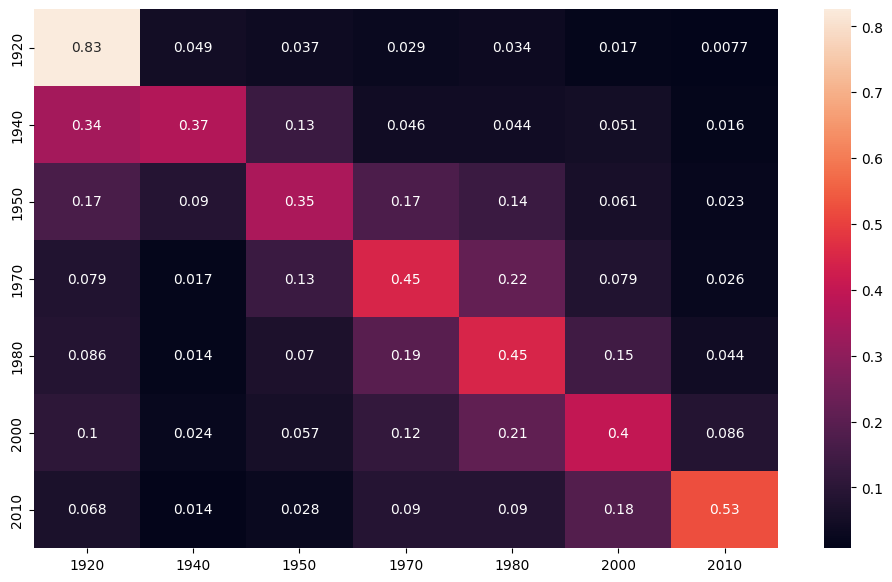

In [14]:
# test the model  
def test(model):  
  print('Now testing')              
  model.eval()   
  y_pred = []   
  y_true = [] 
  running_loss = 0.0 
  running_correct = 0
  with torch.no_grad():
      for _, data in tqdm(enumerate(dataloaders['test'])):                
          data, target = data[0].to(device), data[1].to(device)
          
          #   plt.figure() 
          #   plt.imshow(data[4,:,:,:].permute(1, 2, 0).cpu().numpy()) 
          #   plt.show()
          #   plt.savefig('FigureImage1.png')   

          #   plt.figure()
          #   plt.imshow(data2[4,:,:,:].permute(1, 2, 0).cpu().numpy())
          #   plt.show()
          #   plt.savefig('FigureImage2.png') 

          outputs = model(data)   
          #loss = criterion(outputs, torch.max(target, 1)[1])                                
          #loss = criterion(outputs, target)      
          #running_loss += loss.item() 

          _, preds = torch.max(outputs.data, 1)
          #running_correct += (preds == torch.max(target, 1)[1]).sum().item()                               
          running_correct += (preds == target).sum().item() 
          y_true.append(target.cpu())     
          y_pred.append(preds.cpu())     
      #loss = running_loss / len(dataloaders['test'].dataset)   
      accuracy = 100. * running_correct / len(dataloaders['test'].dataset)   
      #print(f'Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}') 
      print(f'Test Acc: {accuracy:.2f}')
      y_true = np.concatenate(y_true)
      y_pred = np.concatenate(y_pred)
      print(f'Pr: {100.*precision_score(y_true, y_pred, average="weighted"):.2f}, Re: {100.*recall_score(y_true, y_pred, average="weighted"):.2f}, F1: {100.*f1_score(y_true, y_pred, average="weighted"):.2f}')
      classes = ('1920', '1940', '1950', '1970', '1980', '2000', '2010')          
      cf_matrix = confusion_matrix(y_true, y_pred)   
      df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes], columns = [i for i in classes])
      plt.figure(figsize = (12,7))
      sn.heatmap(df_cm, annot=True) 
      plt.savefig('ConfusionMatrix1.png')      
      sumdiagonals = 0.
      for i in range(len(cf_matrix)):
        sumdiagonals += (cf_matrix / np.sum(cf_matrix, axis=1)[:, None])[i,i]
      sumdiagonals /= len(cf_matrix) 
      print(f'Sum of diagonals of Confusion Matrix: {100.*sumdiagonals:.2f}') 
      #return loss, accuracy      
      return accuracy

#model.load_state_dict(torch.load('/Data/ndionelis/savemodelbest.pt'))   

accur_toprint = test(model) 
#print(accur_toprint)  


The next step is: Data Fusion

In [10]:
# add cross-view

# We add cross-view.  
# ResNet model      
#class ResNet152(nn.Module):  
class ResNet18(nn.Module):
    def __init__(self, pretrained):
        #super(ResNet152, self).__init__()           
        super(ResNet18, self).__init__() 

        #class MyResNet152(nn.Module):                          
        class MyResNet18(nn.Module):
            def __init__(self, resnet, resnet2):
                super().__init__()
                # # # # create features branch using https://github.com/pytorch/vision/blob/2a52c2dca73513d0d0c3e2a505aed05e5b9aa792/torchvision/models/resnet.py#L230-L246
                self.features = nn.Sequential(
                    resnet.conv1,
                    resnet.bn1,
                    resnet.relu,
                    resnet.maxpool,
                    resnet.layer1,
                    resnet.layer2,
                    resnet.layer3,
                    resnet.layer4
                )
                self.avgpool = resnet.avgpool
                self.fc = resnet.fc
                self.features2 = nn.Sequential(
                    resnet2.conv1,
                    resnet2.bn1,
                    resnet2.relu,
                    resnet2.maxpool,
                    resnet2.layer1,
                    resnet2.layer2,
                    resnet2.layer3,
                    resnet2.layer4
                )
                self.avgpool2 = resnet2.avgpool
                self.fc2 = resnet2.fc

            def _forward_impl(self, x: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
                x = self.features(x)
                x = self.avgpool(x)
                x = torch.flatten(x, 1)
                x = self.fc(x)
                x2 = self.features2(x2)
                x2 = self.avgpool2(x2)
                x2 = torch.flatten(x2, 1)
                x2 = self.fc2(x2) 
                return x, x2

            def forward(self, x: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
                return self._forward_impl(x, x2) 

        model = torchvision.models.resnet18(pretrained=True)
        model2 = torchvision.models.resnet18(pretrained=True)
        self.model = MyResNet18(model, model2)
        
        self.l0 = nn.Linear(1024, len(lb.classes_))      
        #self.l0 = nn.Sequential(nn.Linear(512, 512), nn.ReLU(inplace=True), nn.Linear(512, 128))    
        #self.ll11 = nn.Sequential(nn.Linear(2048, 512, bias=False), nn.BatchNorm1d(512), nn.ReLU(inplace=True), nn.Linear(512, 128, bias=True))

    def forward(self, x, x2):
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x2 = self.model.features2(x2)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1) 
        x2 = F.adaptive_avg_pool2d(x2, 1).reshape(batch, -1)
        x = torch.cat((x, x2), 1) 
        l0 = self.l0(x)
        return l0  

#model = ResNet152(pretrained=True).to(device)      
model = ResNet18(pretrained=True).to(device)
#model = nn.DataParallel(ResNet152(pretrained=True)).to(device)
#model = nn.DistributedDataParallel(ResNet152(pretrained=True)).to(device)

#print(model)    

model.train()


/home/ndionelis/anaconda3/envs/forsegme/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ndionelis/anaconda3/envs/forsegme/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet18(
  (model): MyResNet18(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e

In [ ]:
# train the model

# model training for cross-view
# training and validation
def validate(model):  
  print('Now validating')             
  model.eval()   
  running_loss = 0.0 
  running_correct = 0
  with torch.no_grad():
      for _, data in tqdm(enumerate(dataloaders['val'])): 
          data, target = data[0].to(device), data[1].to(device)
          data, data2 = data
          outputs = model(data, data2) 
          #loss = criterion(outputs, torch.max(target, 1)[1])                        
          #loss = criterion(outputs, target)    
          #running_loss += loss.item()
          _, preds = torch.max(outputs.data, 1)
          #running_correct += (preds == torch.max(target, 1)[1]).sum().item()                            
          running_correct += (preds == target).sum().item() 
      #loss = running_loss / len(dataloaders['val'].dataset)
      accuracy = 100. * running_correct / len(dataloaders['val'].dataset)   
      #print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}') 
      print(f'Val Acc: {accuracy:.2f}')
      #return loss, accuracy   
      return accuracy

best_test_bpd = 0
#for epoch in range(200):  # # # loop over the dataset multiple times                                                                          
for epoch in range(120):  # # loop over the dataset multiple times                   
   print("Epoch:", epoch) 
   for idx, batch in enumerate(tqdm(train_dataloader)):
        model.train() 
        # # get the inputs                
        #pixel_values = batch["pixel_values"].to(device)                    
        #labels = batch["labels"].to(device)    
        pixel_values, labels = batch[0].to(device), batch[1].to(device) 
        # print(pixel_values.shape)               
        # print(labels.shape)
        pixel_values, pixel_values2 = pixel_values 
        if epoch > 8:       
          if random.random() < 0.5:   
              applier = T.RandomHorizontalFlip(p=1.0)   
              pixel_values = applier(pixel_values) 
              pixel_values2 = applier(pixel_values2) 
          if random.random() < 0.5:
              applier = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
              pixel_values = applier(pixel_values)   
              pixel_values2 = applier(pixel_values2)  
          if random.random() < 0.5: 
              s = 1 
              applier = T.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)     
              pixel_values = applier(pixel_values) 
              pixel_values2 = applier(pixel_values2)
          if random.random() < 0.5:  
              pixel_values = cutout(pixel_values)
              pixel_values2 = cutout(pixel_values2) 
        
        # zero the parameter gradients          
        optimizer.zero_grad() 
       
        # forward + backward + optimize    
        #outputs = model(pixel_values=pixel_values, labels=labels)
        outputs = model(pixel_values, pixel_values2)  
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        #print(loss)                          
        print("Loss:", loss.item())  

        if (epoch % howoften == 0) and (idx == 0):   
          accToCheck = validate(model)   
          if accToCheck > best_test_bpd:     
              best_test_bpd = accToCheck  
              
              #torch.save(model.state_dict(), '/Data/ndionelis/modelsavebest.pt')  
              torch.save(model.state_dict(), './modelsavebest.pt')
        
#torch.save(model.state_dict(), '/Data/ndionelis/modelsave.pt')  
torch.save(model.state_dict(), './modelsave.pt') 


In [ ]:
# testing

# model evaluation
def test(model):  
  print('Now testing')              
  model.eval()   
  y_pred = []   
  y_true = [] 
  running_loss = 0.0 
  running_correct = 0
  with torch.no_grad():
      for _, data in tqdm(enumerate(dataloaders['test'])):                 
          data, target = data[0].to(device), data[1].to(device)
          data, data2 = data

          #   plt.figure() 
          #   plt.imshow(data[4,:,:,:].permute(1, 2, 0).cpu().numpy()) 
          #   plt.show()
          #   plt.savefig('FigureImage1.png')   

          #   plt.figure()
          #   plt.imshow(data2[4,:,:,:].permute(1, 2, 0).cpu().numpy())
          #   plt.show()
          #   plt.savefig('FigureImage2.png') 

          outputs = model(data, data2)  
          #loss = criterion(outputs, torch.max(target, 1)[1])                                
          #loss = criterion(outputs, target)      
          #running_loss += loss.item() 
          _, preds = torch.max(outputs.data, 1)
          #running_correct += (preds == torch.max(target, 1)[1]).sum().item()                               
          running_correct += (preds == target).sum().item() 
          y_true.append(target.cpu())     
          y_pred.append(preds.cpu())     
      #loss = running_loss / len(dataloaders['test'].dataset) 
      accuracy = 100. * running_correct / len(dataloaders['test'].dataset)   
      #print(f'Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}') 
      print(f'Test Acc: {accuracy:.2f}')
      y_true = np.concatenate(y_true)
      y_pred = np.concatenate(y_pred)
      print(f'Pr: {100.*precision_score(y_true, y_pred, average="weighted"):.2f}, Re: {100.*recall_score(y_true, y_pred, average="weighted"):.2f}, F1: {100.*f1_score(y_true, y_pred, average="weighted"):.2f}')
      classes = ('1920', '1940', '1950', '1970', '1980', '2000', '2010')          
      cf_matrix = confusion_matrix(y_true, y_pred)   
      df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes], columns = [i for i in classes])
      plt.figure(figsize = (12,7))
      sn.heatmap(df_cm, annot=True) 
      plt.savefig('ConfusionMatrixDataFusion.png')      
      sumdiagonals = 0.
      for i in range(len(cf_matrix)):
        sumdiagonals += (cf_matrix / np.sum(cf_matrix, axis=1)[:, None])[i,i]
      sumdiagonals /= len(cf_matrix) 
      print(f'Sum of diagonals of Confusion Matrix: {100.*sumdiagonals:.2f}') 
      #return loss, accuracy      
      return accuracy

model.load_state_dict(torch.load('./modelsavebest.pt'))  

accur_toprint = test(model)  
#print(accur_toprint)   
